In [1]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import tflearn
import ipdb as pdb
import time

for k in range(5,10):
    
    tf.reset_default_graph()
    
    print('---------' + str(k) + '------------')
    
    MAX_EPISODE = 2000
    MAX_EPISODE_LEN = 200

    NUM_T = 1
    NUM_R = 4
    SIGMA2 = 1e-9

    t_factor = 0.8
    noise_sigma = 0.12

    config = {'state_dim':3, 'action_dim':2};
    train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                    'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                    'random_seed':int(time.clock()*1000%1000), 'noise_sigma':noise_sigma, 'sigma2':SIGMA2}
    
    IS_TRAIN = False
#     rate = 3.0
    res_path = 't_M_08_nB/'
    model_path = 'model_M_08_nB/my_train_model_'+str(k)+'-2000'
    meta_path = model_path+'.meta'
    init_path = ''
    init_seqCnt = 40
    
    user_config = [{'id':'1', 'model':'AR', 'num_r':NUM_R, 'rate':1.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'2', 'model':'AR', 'num_r':NUM_R, 'rate':2.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'3', 'model':'AR', 'num_r':NUM_R, 'rate':3.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000}]
    
    if not os.path.exists(res_path):
        os.mkdir(res_path) 
    
    print(user_config)
    # 0. initialize the session object
    sess = tf.Session() 

    # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
    # sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) 

    # 1. include all user in the system according to the user_config
    user_list = [];
    for info in user_config:
        info.update(config)
        info['model_path'] = model_path + '_' + info['id']
        info['meta_path'] = info['model_path']+'.meta'
        info['init_path'] = init_path
        info['init_seqCnt'] = init_seqCnt
        user_list.append(MecTermRL(sess, info, train_config))
        print('Initialization OK!----> user ' + info['id'])

    # 2. create the simulation env
    env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)

    sess.run(tf.global_variables_initializer())
    
    tflearn.config.is_training(is_training=IS_TRAIN, session=sess)

    env.init_target_network()

    res_r = []
    res_p = []
    res_b = []
    res_o = []
    res_d = []
    # 3. start to explore for each episode
    for i in range(MAX_EPISODE):

        cur_init_ds_ep = env.reset()

        cur_r_ep = np.zeros(len(user_list))
        cur_p_ep = np.zeros(len(user_list))
        cur_op_ep = np.zeros(len(user_list))
        cur_ts_ep = np.zeros(len(user_list))
        cur_ps_ep = np.zeros(len(user_list))
        cur_rs_ep = np.zeros(len(user_list))
        cur_ds_ep = np.zeros(len(user_list))
        cur_ch_ep = np.zeros(len(user_list))
        cur_of_ep = np.zeros(len(user_list))

        for j in range(MAX_EPISODE_LEN):

            # first try to transmit from current state
            [cur_r, done, cur_p, cur_op, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()

            cur_r_ep += cur_r
            cur_p_ep += cur_p
            cur_op_ep += cur_op
            cur_ts_ep += cur_ts
            cur_ps_ep += cur_ps
            cur_rs_ep += cur_rs
            cur_ds_ep += cur_ds
            cur_ch_ep += cur_ch
            cur_of_ep += cur_of


            if done:
                res_r.append(cur_r_ep/MAX_EPISODE_LEN)
                res_p.append(cur_p_ep/MAX_EPISODE_LEN)
                res_b.append(cur_ds_ep/MAX_EPISODE_LEN)
                res_o.append(cur_of_ep/MAX_EPISODE_LEN)
                res_d.append(cur_ds)
                print('%d:r:%s,p:%s,op:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s,rbuf:%s' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_op_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep, cur_ds))

    name = res_path+'test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
    np.savez(name, res_r, res_p, res_b, res_o, res_d)
    
    tflearn.config.is_training(is_training=False, session=sess)
    #Create a saver object which will save all the variables
    saver = tf.train.Saver() 
    saver.save(sess, model_path)

    sess.close()

---------5------------
[{'penalty': 1000, 'num_r': 4, 'rate': 1.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '1', 't_factor': 0.8, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 2.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '2', 't_factor': 0.8, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 3.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '3', 't_factor': 0.8, 'dis': 100}]
Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[-12.51931807 -14.09563046 -21.65143429],p:[0.93011597 1.13625219 1.22898077],op:[0.57570377 0.24617464 0.        ],tr:[1.23166761 1.00580177 0.93261767],pr:[1.54295636 1.49082555 1.34634655],rev:[1.09  2.065 3.015],dbuf:[ 2.3638008  15.18107894 59.09794062],ch:[4.26634707 3.70093177 3.32389513],ibuf:[13.5, 40.0, 44.0],rbuf:[ 15.59909814  78.9935202  191.2071564 ]
1:r:[-21.29926362 -47.15       -67.31081278],p:[0.07856401 0.         0.00081269],op:[0. 0. 

22:r:[ -5.34032015 -23.58457235 -63.17591442],p:[0.20504557 0.33221504 0.17606414],op:[0.00303432 0.         0.        ],tr:[0.         0.64572015 0.37675164],pr:[1.17850636 0.30137468 0.        ],rev:[1.03  2.045 3.185],dbuf:[ 18.37840514 104.63426027 308.83700669],ch:[4.35391838 3.87907292 3.1328831 ],ibuf:[32.5, 14.0, 19.0],rbuf:[  4.70243255 233.58103467 580.64967207]
23:r:[ -2.95663294 -29.27301989 -54.90596988],p:[0.21393085 0.45074847 0.21165465],op:[0.07328316 0.         0.        ],tr:[0.         1.00843422 0.60319807],pr:[1.30953394 0.         0.        ],rev:[1.055 1.835 3.205],dbuf:[  3.29460434 128.33516068 266.06366346],ch:[4.94204175 4.74937797 4.4184884 ],ibuf:[2.5, 38.5, 9.0],rbuf:[  1.         203.81315571 529.36038534]
24:r:[ -4.30320059 -25.87663974 -53.05670457],p:[0.26618866 0.43548005 0.15658042],op:[0.0333948 0.        0.       ],tr:[0.         0.92558996 0.47376523],pr:[1.32737041 0.         0.        ],rev:[1.06 1.95 2.81],dbuf:[  9.53266455 111.96399672 259.0

45:r:[-11.37674814 -29.50552235 -30.30368582],p:[0.1051608  0.41933766 0.52184929],op:[0. 0. 0.],tr:[0.03227019 0.87040951 0.53844311],pr:[0.84101496 0.         1.35680957],rev:[1.2  1.85 3.05],dbuf:[ 52.67730875 130.7541055  130.64445763],ch:[3.73448996 4.50034954 5.03585735],ibuf:[18.0, 24.5, 35.5],rbuf:[ 83.34297084 220.41809855 266.44946366]
46:r:[ -8.12963101 -26.92069755 -39.54066755],p:[0.23232482 0.54054481 0.34851803],op:[0. 0. 0.],tr:[0.2921198  1.04348167 0.14535945],pr:[0.95150527 0.         1.31856165],rev:[1.13 1.89 3.1 ],dbuf:[ 31.35516213 112.98169552 183.76261654],ch:[4.18749917 4.92244945 3.82883861],ibuf:[47.0, 20.5, 31.0],rbuf:[ 24.27498491 189.80366577 358.21578131]
47:r:[ -5.29421082 -32.91960928 -40.03219693],p:[0.20048344 0.53773169 0.27529367],op:[0.026842 0.       0.      ],tr:[0.24888734 0.92512916 0.08247602],pr:[1.02472168 0.         1.23640573],rev:[0.905 2.13  2.98 ],dbuf:[ 17.37803652 143.08877895 189.1492378 ],ch:[4.2571683  3.85377641 3.7533643 ],ibuf:

69:r:[-15.2131028  -25.71709599 -50.22838658],p:[0.29553286 0.15045595 0.05041968],op:[0. 0. 0.],tr:[0.56936602 0.04710086 0.        ],pr:[0.         1.03458552 0.65390813],rev:[1.085 1.975 2.965],dbuf:[ 64.24419942 122.56724203 249.12514591],ch:[3.63742384 4.93319458 3.29506067],ibuf:[22.0, 25.5, 10.5],rbuf:[125.12679695 204.16272419 472.71837474]
70:r:[-12.36902142 -27.6899732  -63.91126006],p:[3.50296898e-01 1.85720376e-01 3.01394694e-04],op:[0. 0. 0.],tr:[0.71626008 0.01070434 0.        ],pr:[0.15693532 1.12401695 0.00918113],rev:[0.995 2.11  3.15 ],dbuf:[ 47.83323119 131.02105096 319.54424453],ch:[4.13780921 4.37342497 3.55461145],ibuf:[47.0, 47.0, 7.0],rbuf:[ 71.36092022 242.05574088 635.1637748 ]
71:r:[ -7.0248154 -33.997411  -66.82     ],p:[0.31812481 0.04814001 0.        ],op:[0. 0. 0.],tr:[0.56926977 0.         0.        ],pr:[0.34769872 0.67152694 0.        ],rev:[1.025 1.975 2.94 ],dbuf:[ 22.39908443 168.06145472 334.1       ],ch:[3.61083285 5.02607398 5.15262642],ibuf:[25.

92:r:[-13.89349681 -15.80695543 -69.27896284],p:[0.01632372 0.40679674 0.00070046],op:[0. 0. 0.],tr:[0.         0.39749345 0.00178856],pr:[0.30684516 1.16278271 0.        ],rev:[1.02 1.95 3.28],dbuf:[ 68.81453527  62.76290769 346.36679578],ch:[3.83689287 3.06907829 4.56895235],ibuf:[3.5, 20.0, 18.0],rbuf:[146.13096716  97.94476755 673.64228704]
93:r:[-10.48878835 -12.50096969 -68.865     ],p:[0.10551913 0.39714346 0.        ],op:[0. 0. 0.],tr:[0.         0.40303274 0.        ],pr:[0.89822334 1.2422514  0.        ],rev:[1.04  1.895 3.07 ],dbuf:[ 48.22317637  46.61911    344.325     ],ch:[4.44695264 4.65611719 3.42881236],ibuf:[25.0, 17.5, 44.0],rbuf:[ 53.35533167  67.44317123 658.        ]
94:r:[ -2.59858606 -21.60089075 -67.19195453],p:[0.15580432 0.4427472  0.00184386],op:[0.02822393 0.         0.        ],tr:[0.         0.00891947 0.00515909],pr:[1.12407348 1.50807989 0.        ],rev:[0.88  2.065 3.105],dbuf:[  5.63180055  90.29456594 335.88601812],ch:[4.08528389 4.58616482 4.7862673

115:r:[-11.48129068  -8.9855191  -71.371     ],p:[0.25758396 0.81760073 0.        ],op:[0.         0.07342656 0.        ],tr:[0.42393974 1.10170682 0.        ],pr:[0.27096722 1.44739867 0.        ],rev:[1.   2.19 3.16],dbuf:[ 47.1030952    9.28650387 356.855     ],ch:[3.45463946 5.37999892 3.26680489],ibuf:[24.0, 22.5, 28.5],rbuf:[ 85.0186095    3.91214245 660.5       ]
116:r:[-13.24816042 -11.11526291 -59.86818752],p:[0.30084506 0.66723409 0.00468414],op:[0. 0. 0.],tr:[0.51232475 0.56117421 0.        ],pr:[0.49427245 1.43870214 0.09173866],rev:[0.93 1.96 3.04],dbuf:[ 54.20699985  28.88695088 299.15357208],ch:[3.7403555  4.39530332 3.76803798],ibuf:[47.5, 49.0, 4.5],rbuf:[ 32.18056078  41.02472921 594.15226889]
117:r:[ -7.58905561 -18.57723225 -59.52113661],p:[0.1412547  1.09315841 0.01524272],op:[0.         0.17182914 0.        ],tr:[0.03418426 0.47885843 0.01544199],pr:[0.95952812 1.84005699 0.09514815],rev:[1.085 1.96  3.055],dbuf:[ 32.29509008  42.28665913 296.99597427],ch:[3.29377

138:r:[-23.26410995 -15.43499002 -67.53065219],p:[0.03553279 1.06001485 0.05429438],op:[0. 0. 0.],tr:[0.09288816 0.0149063  0.11123049],pr:[0.        1.9014032 0.       ],rev:[0.965 1.985 3.095],dbuf:[114.89923795  34.77435603 335.48148571],ch:[4.79125462 4.12023805 3.84700194],ibuf:[23.5, 21.5, 34.5],rbuf:[197.92236759  35.23809979 631.25390287]
139:r:[-27.15539261 -12.24841889 -56.51520184],p:[0.00370376 0.71485936 0.05515759],op:[0. 0. 0.],tr:[0.00999766 0.17450849 0.19053915],pr:[0.         1.58023924 0.        ],rev:[0.96 1.86 3.03],dbuf:[135.62881258  32.64771999 280.36970549],ch:[3.93383277 3.38699094 4.80961027],ibuf:[43.5, 14.5, 8.0],rbuf:[233.50046877  35.55045505 575.89217057]
140:r:[-27.9404529  -15.78152788 -62.62168179],p:[0.00773188 1.01764043 0.02330585],op:[0. 0. 0.],tr:[0.02036872 0.10705684 0.03243787],pr:[0.         1.74178567 0.2237193 ],rev:[1.06  1.995 3.1  ],dbuf:[139.39298938  38.20202214 312.17617477],ch:[3.56152093 3.4019778  3.82859341],ibuf:[30.0, 10.5, 18.

161:r:[-17.04815635 -24.35285095 -59.431     ],p:[0.02054807 0.9540215  0.        ],op:[0. 0. 0.],tr:[0.06526808 0.07116778 0.        ],pr:[0.         1.78104979 0.        ],rev:[1.   2.21 2.75],dbuf:[ 84.4188588   83.60339475 297.155     ],ch:[4.45170539 3.23435381 3.43454179],ibuf:[1.0, 20.0, 14.5],rbuf:[187.94638477  91.55648625 564.5       ]
162:r:[-22.313      -24.53707844 -59.31544045],p:[0.         0.8284064  0.00229867],op:[0. 0. 0.],tr:[0.         0.22280693 0.        ],pr:[0.         1.52028265 0.07432412],rev:[1.105 2.15  2.97 ],dbuf:[111.565       89.54913604 296.48525558],ch:[4.26907325 4.46865429 4.18223917],ibuf:[2.0, 16.0, 9.0],rbuf:[223.          97.3820837  588.13517583]
163:r:[-20.47607647 -11.57271187 -48.14116957],p:[0.00110817 0.66448599 0.04867909],op:[0. 0. 0.],tr:[0.00165033 0.68678966 0.        ],pr:[0.00245494 1.36048647 0.64938108],rev:[1.045 1.985 2.835],dbuf:[102.33605559  31.28411984 238.75868427],ch:[4.03548218 3.75762513 4.14770794],ibuf:[4.0, 37.5, 14.

184:r:[-21.43562102 -23.09289761 -42.38265758],p:[7.82721048e-04 1.08481708e+00 5.69305900e-01],op:[0. 0. 0.],tr:[0.00277419 0.23614073 0.61064508],pr:[0.         1.50247741 1.02810209],rev:[0.86  1.96  3.135],dbuf:[107.14679628  72.07180485 189.14105186],ch:[4.18926085 3.96959072 2.75953289],ibuf:[26.5, 20.5, 13.0],rbuf:[197.94516125  64.77637209 312.25056544]
185:r:[-19.66716914 -20.33874038 -45.46446567],p:[0.03254816 0.87239689 0.45569293],op:[0. 0. 0.],tr:[0.05971308 0.2217226  0.47146665],pr:[0.03577451 1.65345837 1.1064922 ],rev:[1.025 2.03  3.29 ],dbuf:[ 97.03391934  66.79782609 209.09461126],ch:[3.53188038 3.49227198 2.91023603],ibuf:[0.0, 42.5, 37.0],rbuf:[185.90248177  73.463806   379.40823084]
186:r:[-10.00835901 -26.15750361 -36.5300789 ],p:[0.18143987 0.62587246 0.45161662],op:[0. 0. 0.],tr:[0.22604697 0.27948121 0.71699969],pr:[0.82079715 1.13513644 0.58469504],rev:[0.985 2.03  3.   ],dbuf:[ 42.78420012 105.75261979 164.58572951],ch:[5.56751415 4.10742895 3.38911115],ibu

207:r:[ -4.41592951 -21.87447345 -30.60417379],p:[0.26351058 0.83927881 2.        ],op:[0.03907315 0.         0.        ],tr:[0. 0. 0.],pr:[1.33791297 1.64169859 2.5198421 ],rev:[1.075 1.995 3.13 ],dbuf:[ 9.97629847 75.80121477 73.02086897],ch:[4.82293747 6.05288842 4.89705555],ibuf:[32.0, 39.0, 5.0],rbuf:[  1.         109.66028106 127.03158004]
208:r:[ -3.97995807 -28.17398624 -27.33198637],p:[0.23737173 0.63910226 1.99385722],op:[0.13205772 0.         0.01      ],tr:[0.         0.         0.01222799],pr:[1.43367398 1.3009815  2.5198421 ],rev:[0.93  2.045 3.045],dbuf:[  5.12261263 115.30584075  56.50564308],ch:[4.90907826 3.45262728 3.66132922],ibuf:[28.5, 3.0, 0.0],rbuf:[  1.         151.80369941 105.10582472]
209:r:[ -3.74609533 -29.23098491 -26.51217379],p:[0.18939286 0.60087718 2.        ],op:[0.00538306 0.         0.        ],tr:[0.01149148 0.         0.        ],pr:[1.11990613 1.28608656 2.5198421 ],rev:[1.13 1.99 2.92],dbuf:[ 10.93943986 122.11983736  52.56086897],ch:[3.3458095

229:r:[-27.20090844 -17.91839246 -21.34147856],p:[0.04298187 0.31397663 2.45535181],op:[0.         0.         0.06730618],tr:[0.13354749 0.         1.84478994],pr:[0.         1.35518687 1.51685801],rev:[1.06 2.08 2.87],dbuf:[134.28526755  77.03289701   5.80107309],ch:[3.64605909 4.14241369 3.31099959],ibuf:[31.0, 10.0, 9.0],rbuf:[216.29050226 154.96262694   1.        ]
230:r:[-20.30271155 -27.56075096 -22.47195703],p:[0.13922455 0.39639006 2.5122916 ],op:[0.         0.         0.07700863],tr:[0.34764745 0.         2.06853964],pr:[0.         1.17760089 1.61634239],rev:[0.965 1.86  3.05 ],dbuf:[ 95.94457574 121.94815254   8.7877761 ],ch:[4.08944267 3.67644497 4.05138618],ibuf:[47.0, 20.5, 47.5],rbuf:[170.47051017 156.97982246   2.        ]
231:r:[-17.80827264 -35.46763617 -22.39795454],p:[0.08536541 0.70854119 2.38762528],op:[0.         0.         0.11290546],tr:[0.20417163 0.         2.16060641],pr:[0.         1.38855139 1.56974941],rev:[0.935 2.075 2.98 ],dbuf:[ 85.62674694 148.9965333

251:r:[ -3.0948241  -16.86651854 -23.89963844],p:[0.21502444 1.84956555 2.56022023],op:[0.05739671 0.10552336 0.20272114],tr:[0.         1.84587118 2.0364361 ],pr:[1.28622368 0.94482026 1.83565096],rev:[1.    1.925 2.905],dbuf:[4.57727458 6.12903647 8.98053765],ch:[4.14965337 3.8810163  4.65036199],ibuf:[19.5, 5.0, 48.0],rbuf:[ 3.46517887 13.99661857  6.6504577 ]
252:r:[-21.21662776 -13.69318235 -21.97824925],p:[0.03455103 1.5195576  2.41046718],op:[0.         0.03255353 0.10816204],tr:[0.00372878 1.67266322 2.33457247],pr:[0.34431426 0.94676963 1.6451795 ],rev:[1.295 2.015 3.105],dbuf:[104.70109771   6.3814663    9.14607774],ch:[4.28946207 3.27046367 5.03722594],ibuf:[29.0, 43.5, 49.0],rbuf:[218.39139177   5.05577913   3.        ]
253:r:[-14.67933931 -13.80380599 -19.1189947 ],p:[0.03065406 1.51701554 2.20275777],op:[0.         0.00087427 0.05459656],tr:[0.00389653 1.65089649 2.1326693 ],pr:[0.34616108 0.38832585 1.40528722],rev:[0.965 1.92  3.04 ],dbuf:[72.17053434  8.30343782  5.300

274:r:[-18.92151679 -12.07128228 -38.24360102],p:[0.02396809 1.24149658 1.96993795],op:[0. 0. 0.],tr:[0.         0.42490457 2.18125146],pr:[0.3720269  1.93816878 0.15279849],rev:[1.03  2.195 3.005],dbuf:[ 93.64886053  10.69654838 112.42048695],ch:[4.20396482 3.49545616 4.02628329],ibuf:[42.5, 37.0, 32.5],rbuf:[174.09461975   3.71174848 166.69000955]
275:r:[-21.90392697  -9.69439152 -18.60503229],p:[0.03456228 0.98823117 2.14080769],op:[0.         0.         0.02197122],tr:[0.06421809 0.2512588  2.46618381],pr:[0.         1.88859819 1.02056656],rev:[1.055 2.055 3.085],dbuf:[108.1371437   8.9427107   6.514005 ],ch:[3.12823167 4.79248028 5.0690801 ],ibuf:[10.0, 23.5, 8.0],rbuf:[208.15638262   6.52860124   4.9646181 ]
276:r:[-20.39814757 -10.94259332 -18.62634935],p:[0.02897416 1.00906755 2.18801015],op:[0.00000000e+00 0.00000000e+00 4.42120947e-05],tr:[0.06999885 0.44479997 2.02815119],pr:[0.         1.81321693 0.96875351],rev:[0.905 2.08  2.845],dbuf:[100.83177155  14.3502646    5.609572

296:r:[-22.366       -9.06536566 -21.51408008],p:[0.         1.02322271 2.4420899 ],op:[0.         0.00400759 0.07487847],tr:[0.         0.22253292 1.81604204],pr:[0.         1.88531113 1.78447519],rev:[0.855 2.06  3.05 ],dbuf:[111.83         4.23761642   6.89166528],ch:[2.78015379 3.57525257 3.91291998],ibuf:[23.5, 11.0, 25.5],rbuf:[194.5          3.60740359   0.        ]
297:r:[-24.10106116  -9.75693102 -18.86739143],p:[0.00445848 1.08173824 2.15128458],op:[0.         0.00600237 0.11702163],tr:[0.00626078 0.26745844 2.08709452],pr:[0.         1.89885851 1.56196053],rev:[1.045 2.015 2.88 ],dbuf:[120.32696675   5.27503079   3.60470895],ch:[3.69136449 3.87394798 4.68199998],ibuf:[12.0, 29.0, 9.0],rbuf:[219.74784396   1.52949919   2.50836445]
298:r:[-18.9871492   -9.00859748 -22.93681379],p:[0.00709132 0.98665179 2.5337037 ],op:[0.         0.0037205  0.14535617],tr:[0.01981856 0.25039057 1.85316457],pr:[0.         1.74981878 1.79571267],rev:[0.965 1.82  2.84 ],dbuf:[94.65209303  5.428095

318:r:[-26.23324973  -9.47847089 -22.9227704 ],p:[0.00559007 1.03967779 2.49659347],op:[0.         0.04718153 0.03591198],tr:[0.01210706 0.5778392  2.1359934 ],pr:[0.02535578 1.68641003 1.30924734],rev:[1.045 1.945 2.935],dbuf:[130.94264566   3.91798172  13.31363393],ch:[3.68448647 3.0737272  3.90386134],ibuf:[28.0, 33.0, 46.5],rbuf:[229.50743235   3.35244495   3.89958006]
319:r:[-23.96683383  -8.75023927 -21.89841986],p:[0.00872467 0.98830021 2.52463904],op:[0.         0.0144025  0.02874826],tr:[0.         0.49528591 1.81169568],pr:[0.14136329 1.65946624 1.4437894 ],rev:[1.095 2.11  3.   ],dbuf:[119.48518222   3.64308808   7.35660729],ch:[3.87369602 3.40149325 3.36070553],ibuf:[28.5, 1.5, 21.0],rbuf:[219.22734171   4.98035692   7.75793395]
320:r:[-26.59359599 -10.16751338 -21.55227506],p:[0.01737098 1.14522536 2.46217132],op:[0.         0.01413528 0.05311477],tr:[0.         0.88064982 2.14297312],pr:[0.21330677 1.38372279 1.37081522],rev:[1.005 2.    2.94 ],dbuf:[132.27314061   4.4631

341:r:[-21.00269062  -9.68123382 -20.87001263],p:[0.12757819 0.95481831 2.29300287],op:[0.         0.1873339  0.16945462],tr:[0.34254622 0.61033548 2.08466328],pr:[0.         1.79040882 1.58754294],rev:[0.885 1.88  2.87 ],dbuf:[99.91032559  2.720081    5.85176379],ch:[3.8351292  4.34338851 3.77804034],ibuf:[19.0, 22.0, 31.0],rbuf:[127.49075527   1.93836314   5.32354591]
342:r:[-15.45801405  -9.00541918 -21.61824162],p:[0.19186428 0.95197407 2.50968254],op:[0.         0.10796482 0.09293995],tr:[0.41342199 0.56050125 1.9093181 ],pr:[0.         1.68654705 1.53953472],rev:[0.905 1.86  2.91 ],dbuf:[69.61549896  2.62954027  3.98630839],ch:[3.50839435 3.48156088 3.59988871],ibuf:[36.5, 23.0, 9.5],rbuf:[134.81560197   1.58860175   8.87696739]
343:r:[-20.82662697  -9.84721262 -28.73690256],p:[0.04240889 1.04654698 2.32691068],op:[0.         0.12105799 0.01412373],tr:[0.08332489 0.60339886 2.13442777],pr:[0.         1.72765329 1.01124533],rev:[1.   2.03 2.89],dbuf:[102.43677924   2.5318644   50.

363:r:[-11.90850507 -11.52192825 -22.38458917],p:[0.09003098 1.34193976 2.51537899],op:[0.         0.00780511 0.18661148],tr:[0.16105576 1.06331975 2.05622877],pr:[0.27091877 1.02848949 1.68923989],rev:[0.945 1.89  3.035],dbuf:[55.94128621  3.6198463   3.84332715],ch:[3.59221537 2.90046587 4.16811269],ibuf:[1.0, 37.0, 9.5],rbuf:[103.60509477   2.15477508   7.        ]
364:r:[ -5.28577035 -10.83556183 -23.56291349],p:[0.15120458 1.2282974  2.67716741],op:[0.00970145 0.05028254 0.15356594],tr:[0.16033787 0.9381221  1.70014525],pr:[0.74014496 1.20334432 1.77132093],rev:[1.005 1.82  2.98 ],dbuf:[19.99261035  3.03461181  4.58523363],ch:[3.38260984 3.2827113  3.17229687],ibuf:[15.5, 21.5, 1.5],rbuf:[46.51101258  0.42868616  9.2325437 ]
365:r:[ -8.70576685 -12.91958552 -21.96061237],p:[0.12824718 1.37512336 2.53386617],op:[0.         0.14554551 0.10953964],tr:[0.0772575  1.15747438 1.88956826],pr:[0.88789045 1.50435071 1.47355425],rev:[1.03 2.01 2.89],dbuf:[38.39894726  3.77117256  4.0668293 

385:r:[-13.76297321  -8.53528447 -24.84639849],p:[0.19114954 0.94353608 2.68243442],op:[0.         0.05909901 0.29601745],tr:[0.21003083 0.48280683 1.8636839 ],pr:[0.84129328 1.6576678  1.92343016],rev:[1.075 1.975 2.865],dbuf:[61.1688843   2.57101883  5.09391777],ch:[4.39626951 4.33941278 3.31554913],ibuf:[31.0, 5.0, 27.5],rbuf:[35.73517973  2.          1.46311926]
386:r:[ -5.58262561 -10.82150728 -27.43118914],p:[0.33949094 1.21389908 2.74138026],op:[0.12424606 0.01966871 0.59181675],tr:[0.2999954  0.5931626  2.23495065],pr:[1.34202683 1.67950723 2.16413304],rev:[1.055 2.01  3.165],dbuf:[9.36364809 4.76482505 3.82806554],ch:[3.91302452 4.11948458 4.17680581],ibuf:[33.0, 41.0, 5.0],rbuf:[1. 1. 2.]
387:r:[ -6.20994672 -10.43795771 -23.71120301],p:[0.45707588 1.16407552 2.47886285],op:[0.24394875 0.02886363 0.40174075],tr:[0.57611803 0.74848109 2.31463217],pr:[1.50512636 1.63933778 1.82850818],rev:[1.085 2.06  2.875],dbuf:[3.00874834 4.47222244 3.33187101],ch:[3.52408796 4.34426393 4.26

408:r:[ -4.71394456 -12.43239371 -21.44474709],p:[0.32439211 1.16238831 2.43826482],op:[0.17898713 0.33333212 0.12612474],tr:[0.         0.99295666 2.40550764],pr:[1.58556969 1.81563897 1.51446491],rev:[1.11  2.015 2.915],dbuf:[3.43455331 2.33315144 4.64815339],ch:[4.07860478 3.99414071 4.61685973],ibuf:[13.5, 15.5, 33.5],rbuf:[3.         2.29378722 2.        ]
409:r:[ -4.38640336 -11.84216093 -23.76335025],p:[0.29433772 1.23177116 2.59668518],op:[0.13452407 0.17494548 0.10962721],tr:[0.         0.58059532 2.01355595],pr:[1.50407795 1.83790101 1.66878811],rev:[1.02 1.95 3.  ],dbuf:[ 4.77754533  2.94213889 10.56425574],ch:[3.34161735 3.4070474  3.91263587],ibuf:[28.5, 14.0, 20.5],rbuf:[0.67264261 1.11516829 2.        ]
410:r:[ -4.81786743  -9.7965242  -24.38522267],p:[0.24604606 1.05825416 2.67407595],op:[0.01204298 0.09824124 0.16301403],tr:[0.19146329 0.52217482 2.02371406],pr:[1.09224544 1.73871537 1.77308025],rev:[0.99  1.925 3.145],dbuf:[13.76577539  2.72280476  8.44251411],ch:[3.9

431:r:[-18.02075884 -10.17335325 -23.12972899],p:[0.08028882 1.10182216 2.61178887],op:[0.         0.08633568 0.14000194],tr:[0.21448562 0.9244144  2.29997561],pr:[0.         1.49416706 1.61546077],rev:[1.   2.01 3.15],dbuf:[86.89224159  3.34045255  5.57701279],ch:[5.04926803 3.76702441 5.37991756],ibuf:[18.0, 34.0, 34.5],rbuf:[175.10287661   3.           6.        ]
432:r:[-26.41254271 -11.49787795 -22.2737604 ],p:[0.01473849 1.1989057  2.48864084],op:[0.         0.17551015 0.2034754 ],tr:[0.02318185 0.82335939 2.03000732],pr:[0.         1.76485106 1.73910881],rev:[1.035 2.135 2.925],dbuf:[131.4731738    2.51275579   3.6841526 ],ch:[3.16035987 3.39015463 3.91805995],ibuf:[34.0, 9.5, 7.0],rbuf:[236.36362939   1.           2.        ]
433:r:[-27.608      -10.31193893 -22.38220836],p:[0.         1.12286458 2.49301497],op:[0.         0.10277072 0.19492772],tr:[0.         0.79718193 2.14694477],pr:[0.         1.58413622 1.59384323],rev:[1.005 2.065 2.92 ],dbuf:[138.04         2.53428289   

453:r:[ -3.42930321 -11.81553747 -22.18785283],p:[0.34864977 1.21501235 2.4902095 ],op:[0.00031581 0.16534344 0.1906109 ],tr:[0.         0.49255614 1.85048225],pr:[1.11564609 1.9283091  1.71701904],rev:[1.03 1.94 2.94],dbuf:[3.18789298 3.86345571 3.70644809],ch:[4.85055874 3.38911708 3.66784916],ibuf:[18.5, 36.0, 6.0],rbuf:[1.73857163 2.19238249 3.        ]
454:r:[ -3.02453852 -14.9469353  -22.03924248],p:[0.24547857 1.35531149 2.46443873],op:[0.09569649 0.42025094 0.15503263],tr:[0.04865223 1.04433574 1.99395562],pr:[1.24996779 2.02581825 1.74411184],rev:[0.885 2.085 2.935],dbuf:[1.47569046 3.71217932 5.41735803],ch:[3.64926442 4.21607843 4.36674307],ibuf:[10.5, 40.0, 43.5],rbuf:[0. 2. 2.]
455:r:[ -4.69963507 -11.70159669 -23.73300485],p:[0.36930129 1.11691631 2.66459491],op:[0.1795092  0.29021222 0.18298885],tr:[0.41801814 0.55677986 1.87000425],pr:[1.41811306 1.92876998 1.8062634 ],rev:[0.96  1.905 2.895],dbuf:[1.54575609 2.22284198 4.76167374],ch:[4.88935809 3.01668379 3.57760089],

476:r:[ -2.334097   -14.10440012 -36.7491522 ],p:[0.18345272 1.50844337 2.52917973],op:[0.         0.14618822 0.        ],tr:[1.23122524e-03 1.03942836e+00 1.95381093e+00],pr:[0.87572445 1.75335019 0.97512466],rev:[0.815 2.055 3.155],dbuf:[ 4.33237635  4.33673697 82.57857186],ch:[4.47709698 3.60646871 3.53399094],ibuf:[14.5, 48.5, 40.0],rbuf:[ 2.10886559  1.         85.21288045]
477:r:[ -3.37360031 -10.48667185 -22.54942231],p:[0.31435449 1.12282119 2.58980038],op:[0.         0.12518676 0.0033858 ],tr:[0.         0.87010893 1.79171806],pr:[1.17535975 1.59842419 1.5588777 ],rev:[1.045 1.915 3.145],dbuf:[4.2938219  2.51304098 9.01966435],ch:[3.19925526 4.10725331 3.06556252],ibuf:[27.5, 22.0, 26.5],rbuf:[1.42805016 3.         3.07200122]
478:r:[ -4.39883013 -11.36304698 -36.3211152 ],p:[0.41034634 1.23877058 2.43661458],op:[0.04346391 0.07289639 0.        ],tr:[0.03683363 0.89637519 1.89377876],pr:[1.41051819 1.64408846 0.89270187],rev:[1.075 2.005 2.99 ],dbuf:[ 3.84174038  4.34855619 84

499:r:[ -3.98499651  -9.51457302 -23.66136465],p:[0.30964334 1.0994075  2.56458661],op:[0.         0.00301926 0.20399701],tr:[0.         1.00323978 2.24364472],pr:[1.10081609 1.13879251 1.74666826],rev:[1.065 2.035 3.02 ],dbuf:[7.53924889 3.47579494 7.56347838],ch:[5.04206133 3.59897615 4.67737198],ibuf:[17.5, 19.0, 37.5],rbuf:[10.33678257  4.92646013  3.        ]
500:r:[ -9.76400194  -9.23408968 -22.42301396],p:[0.25380628 1.00701354 2.5460633 ],op:[0.         0.07083955 0.15397246],tr:[0.         1.04851916 2.26843452],pr:[1.00006997 1.2977983  1.63598289],rev:[0.995 1.85  3.045],dbuf:[38.66775855  3.05632463  4.1136393 ],ch:[3.74936882 4.43452846 4.61684892],ibuf:[37.0, 27.0, 8.0],rbuf:[35.9860066  0.         3.       ]
501:r:[ -3.35340369 -10.73195851 -21.81203802],p:[0.28222557 1.17568839 2.42458687],op:[0.         0.09030102 0.14950462],tr:[0.         0.88232164 2.34166549],pr:[0.95165233 1.62930543 1.50434309],rev:[0.905 2.11  2.92 ],dbuf:[5.47799567 3.02021606 6.09653048],ch:[4

522:r:[ -6.38954754 -19.27388731 -24.43923311],p:[0.40044733 0.58227038 2.62301523],op:[0.30301841 0.         0.26425902],tr:[0.19763505 0.50483535 2.16089142],pr:[1.67923473 1.29288944 1.93576772],rev:[0.945 1.915 3.115],dbuf:[ 3.80910777 73.07862133  6.70519524],ch:[4.27295196 3.22848556 4.47104331],ibuf:[33.5, 47.5, 48.0],rbuf:[ 2.         70.95504306  3.        ]
523:r:[ -3.7113643   -7.09414737 -24.67827494],p:[0.32171084 0.76704267 2.61378793],op:[0.08720397 0.00273873 0.30349106],tr:[0.33291346 0.78811246 2.08893644],pr:[1.19509065 1.21188471 1.94676384],rev:[1.005 1.895 2.975],dbuf:[2.20022904 4.67948085 6.70021493],ch:[3.58347027 4.09183097 4.06508798],ibuf:[20.5, 19.0, 47.0],rbuf:[1.         3.40613468 2.        ]
524:r:[ -2.81824576  -8.58395999 -23.32129013],p:[0.23859879 0.85985328 2.53438224],op:[0.01652475 0.00149793 0.25658774],tr:[0.15042737 0.59324835 1.84215873],pr:[1.10641584 1.57205436 1.95207017],rev:[1.05  1.955 2.99 ],dbuf:[3.88628696 8.46575189 4.96765143],ch:[

545:r:[ -4.98418915  -6.87550181 -19.99588364],p:[0.37472454 0.64530231 2.38729838],op:[0.         0.         0.01008768],tr:[0.         0.82167671 2.10803881],pr:[1.14475754 1.07255628 1.11943762],rev:[0.985 1.88  2.895],dbuf:[9.93196402 8.5654165  4.0839756 ],ch:[4.09873074 4.34152518 3.7651376 ],ibuf:[37.5, 10.5, 17.5],rbuf:[5.54849204 7.65340053 2.48447944]
546:r:[ -4.8217149   -6.83023108 -20.97952396],p:[0.32716648 0.66842189 2.33980242],op:[0. 0. 0.],tr:[0.08700702 0.67458427 2.39357744],pr:[1.10487242 1.29853395 1.11599585],rev:[0.99  1.915 3.19 ],dbuf:[11.02191513  7.41427967 11.30552293],ch:[4.23722528 4.06998779 4.4860963 ],ibuf:[43.0, 16.0, 46.0],rbuf:[2.62411209 4.37635615 3.1986192 ]
547:r:[ -3.72509414  -8.29116264 -20.43468463],p:[0.33180367 0.86052714 2.37033068],op:[0.         0.00201741 0.00011803],tr:[0.06278154 0.79406379 1.88712839],pr:[1.05367029 1.34761113 1.23344301],rev:[1.045 2.01  2.935],dbuf:[5.35332396 6.95403121 7.35547464],ch:[3.50835016 3.72364463 3.651

568:r:[ -5.3804934   -7.15029958 -26.25423455],p:[0.3167217  0.66812819 2.25191439],op:[0.31538873 0.         0.        ],tr:[0.         0.15106927 1.84345161],pr:[1.71193827 1.65093707 0.76414235],rev:[1.055 1.835 3.07 ],dbuf:[ 1.61804957  9.02637044 41.19459709],ch:[4.05257814 3.80687863 3.42892824],ibuf:[12.0, 6.0, 7.5],rbuf:[  1.          12.59873077 102.5563289 ]
569:r:[ -5.82488812  -7.15289941 -37.28018107],p:[0.35152454 0.62182325 2.42887898],op:[0.33269754 0.         0.        ],tr:[0.         0.44856568 1.92966735],pr:[1.74864044 1.49219573 0.97544787],rev:[1.01 1.82 3.2 ],dbuf:[ 1.75555757 10.89156694 89.24574607],ch:[3.93604643 4.8686432  2.88612125],ibuf:[13.0, 31.0, 37.5],rbuf:[ 1.5076477   6.84771786 96.47695575]
570:r:[ -4.87974094 -23.64563436 -38.4834911 ],p:[0.33180027 1.10420997 2.33500924],op:[0.22917953 0.         0.        ],tr:[0.         1.08647506 1.88394736],pr:[1.63991259 0.89594037 0.98055042],rev:[1.06  2.2   3.245],dbuf:[ 1.95951256 74.05977282 99.0170860

590:r:[ -3.55063005 -10.62026349 -60.34149255],p:[0.33103253 0.71612199 0.11115289],op:[0.01022388 0.         0.        ],tr:[0.57793846 0.2642591  0.22001248],pr:[0.67798898 1.58993913 0.09814403],rev:[1.08  1.915 3.025],dbuf:[  4.10289413  24.45643796 297.2613471 ],ch:[4.80172832 3.56967472 4.38760391],ibuf:[1.0, 18.5, 32.5],rbuf:[  1.          30.66035363 573.86869834]
591:r:[ -3.7054581  -12.08201297 -29.72472976],p:[0.32580389 0.96443858 0.34351355],op:[0.10711168 0.         0.        ],tr:[0.62876026 0.27811107 0.00803136],pr:[1.09618432 1.82584275 1.10711215],rev:[0.935 2.12  2.76 ],dbuf:[  1.21066768  21.83252178 134.88310671],ch:[4.93765669 4.33042587 4.10458321],ibuf:[0.5, 25.5, 8.5],rbuf:[2.79623524e-01 2.87092370e+01 3.37471297e+02]
592:r:[ -3.54397385  -9.03236969 -33.23326694],p:[0.30819879 0.85858218 0.43293636],op:[0.0650588 0.        0.       ],tr:[0.3811494 0.4357693 0.       ],pr:[1.1432952  1.69089748 0.92274203],rev:[0.925 2.075 2.87 ],dbuf:[  2.78956554  10.818561

612:r:[ -3.15830151  -9.41826972 -44.25374981],p:[0.22651181 0.68385364 0.22712852],op:[0. 0. 0.],tr:[0.         0.69542765 0.00105785],pr:[0.94062826 1.28916901 0.77084539],rev:[0.8   1.94  2.905],dbuf:[  6.73103523  19.73720283 212.18360824],ch:[2.9229929  3.74522889 4.64673402],ibuf:[34.5, 24.5, 32.5],rbuf:[  6.37434809  15.58066883 459.11935053]
613:r:[ -3.35314235 -19.98793514 -50.65760573],p:[0.24796702 0.45043812 0.07964753],op:[0.00250577 0.         0.        ],tr:[0.00000000e+00 2.28384189e-01 4.35326181e-05],pr:[1.06720943 1.3784446  0.51699742],rev:[0.99  2.17  2.755],dbuf:[  6.74680009  81.92215071 250.10212732],ch:[4.03565897 5.4279162  3.9527201 ],ibuf:[18.0, 39.0, 46.0],rbuf:[  7.07419419 151.63424138 493.59180974]
614:r:[ -4.7535516   -8.36700783 -39.22472041],p:[0.36676994 0.75344969 0.39552755],op:[0. 0. 0.],tr:[0.         0.91266885 0.2143952 ],pr:[1.18608336 1.16980584 1.14205326],rev:[1.01  1.955 2.84 ],dbuf:[  9.09696031  11.69705167 180.30249998],ch:[4.05470778 3

635:r:[ -5.13040719 -10.56702924 -49.43693185],p:[0.55078824 0.96376974 1.00421413],op:[0.00674088 0.         0.        ],tr:[0.68854481 0.28981152 0.        ],pr:[0.69471411 1.86695936 1.59449375],rev:[1.115 2.085 3.035],dbuf:[  3.35087118  14.28435645 207.01609414],ch:[3.74782967 3.78526179 3.88289305],ibuf:[26.0, 18.0, 30.5],rbuf:[1.96534851e-01 3.64582397e+00 3.18601250e+02]
636:r:[ -4.7826853  -15.09591378 -53.92312416],p:[0.51113464 1.21399309 1.0866298 ],op:[0.04164411 0.         0.        ],tr:[0.81429114 0.00874986 0.17222991],pr:[0.89558636 2.12009578 1.62769853],rev:[1.125 2.085 3.155],dbuf:[  1.80227658  26.91984542 226.15042885],ch:[3.49669924 3.57089785 3.66069564],ibuf:[12.5, 31.5, 46.0],rbuf:[  0.          22.7308723  317.01431224]
637:r:[ -4.03425474  -6.66671993 -34.8770541 ],p:[0.44504075 0.69452476 0.59220841],op:[0.02660381 0.00332057 0.        ],tr:[0.8083719  0.35797225 0.02765955],pr:[0.5728119  1.61625212 1.31933442],rev:[0.88 1.95 3.05],dbuf:[  1.30549106   5.

658:r:[ -4.21407065 -12.9229626  -55.99947279],p:[0.30997769 0.9772508  0.14954776],op:[0. 0. 0.],tr:[0.00028954 0.13418654 0.0661505 ],pr:[1.21083119 1.9033374  0.32407235],rev:[1.075 1.98  3.06 ],dbuf:[  8.67124557  25.52478094 274.01545339],ch:[4.00605623 3.25612177 3.32994392],ibuf:[31.5, 38.5, 29.0],rbuf:[  4.27585257  26.99521204 562.95543055]
659:r:[ -2.79204649 -11.90470392 -46.99059266],p:[0.20035131 1.00111963 0.20953554],op:[0.         0.00776134 0.        ],tr:[1.62943822e-01 5.06768505e-01 9.57103920e-05],pr:[0.83144854 1.80791373 0.59197889],rev:[1.01 2.14 3.08],dbuf:[  5.94617988  19.16828083 226.57154189],ch:[3.52355161 4.19269481 4.51674117],ibuf:[2.5, 43.0, 12.5],rbuf:[  5.62152782  12.41142694 510.08508066]
660:r:[ -3.39167404 -12.0257219  -46.22816461],p:[0.27005413 0.9831601  0.15399353],op:[0.00515711 0.00021954 0.        ],tr:[0.26217886 0.329585   0.00049439],pr:[0.94137917 1.85387455 0.61373514],rev:[1.08  2.135 2.96 ],dbuf:[  5.94992082  20.7934239  224.981081

681:r:[ -6.88896847  -8.89622729 -49.20586138],p:[0.58994711 0.77021498 0.24073809],op:[0.20527444 0.         0.        ],tr:[0.73595846 0.88245526 0.        ],pr:[1.43267721 1.29782156 0.524151  ],rev:[0.955 2.055 3.045],dbuf:[  2.63598006  13.67253743 236.39978318],ch:[3.68872654 3.80930395 4.12746098],ibuf:[34.5, 30.0, 5.0],rbuf:[  2.           4.94463665 509.1698001 ]
682:r:[ -4.69395932  -8.10876214 -56.69730757],p:[0.45950317 0.67933899 0.15422479],op:[0.03558424 0.         0.        ],tr:[0.8300915  0.49759954 0.        ],pr:[0.87651683 1.45453859 0.35151025],rev:[0.925 1.93  3.205],dbuf:[  3.66630046  13.37025116 277.31754606],ch:[5.44561275 3.09462244 3.5439429 ],ibuf:[36.0, 18.0, 21.5],rbuf:[  0.94269262  13.57237495 592.19795033]
683:r:[ -2.72708141 -15.57891098 -73.65702108],p:[0.21782941 0.99434343 0.01361655],op:[0.         0.00456611 0.        ],tr:[0.25640965 0.30301805 0.        ],pr:[0.71403042 1.87470367 0.06042198],rev:[0.98  1.95  3.235],dbuf:[  4.92223073  37.9381

703:r:[ -2.02182369 -15.90497447 -42.85602834],p:[0.17175402 0.96990447 0.60689308],op:[0. 0. 0.],tr:[0.06357791 0.0012889  0.        ],pr:[0.87899079 1.96806272 1.22293921],rev:[0.91  1.925 3.005],dbuf:[  3.23895768  40.72869353 190.00441846],ch:[4.33725883 3.60135092 4.19295608],ibuf:[7.5, 44.5, 7.0],rbuf:[  1.00189622  35.62967447 363.41215714]
704:r:[ -2.44142053 -10.7930403  -42.0431304 ],p:[0.17861943 0.58757008 0.77348667],op:[0. 0. 0.],tr:[5.63565660e-05 1.23233970e-01 8.41174812e-04],pr:[1.05747061 1.57033374 1.66677182],rev:[1.055 1.965 3.03 ],dbuf:[  5.06232553  30.46239832 179.27618532],ch:[3.93594804 3.60579323 4.2937555 ],ibuf:[7.0, 5.0, 25.0],rbuf:[  6.49460672  59.28645752 297.47740074]
705:r:[ -2.828932   -15.31031366 -51.7027103 ],p:[0.25615039 0.85457437 0.88802613],op:[0.02310633 0.         0.        ],tr:[0.00078752 0.         0.14095836],pr:[1.26069553 1.89348274 1.39832528],rev:[1.155 1.925 3.03 ],dbuf:[  2.97439112  42.3685935  222.9925061 ],ch:[4.46016551 3.248

726:r:[ -2.7782139  -10.85673688 -31.56306632],p:[0.23081374 0.78225111 0.72672021],op:[0.06499954 0.         0.        ],tr:[0.04151125 0.65508698 0.27224387],pr:[1.25289247 1.45349285 1.46364977],rev:[0.995 2.08  3.165],dbuf:[  2.05853857  22.9936402  128.7465231 ],ch:[3.42064346 3.65047736 3.69555493],ibuf:[9.5, 36.5, 28.5],rbuf:[  1.          30.78403479 314.32127222]
727:r:[ -5.43526696  -9.12362081 -54.33994885],p:[0.41094665 0.63327795 0.74884554],op:[0.17086111 0.         0.        ],tr:[0.         0.68880938 0.02209996],pr:[1.6182713  1.29371556 1.35231328],rev:[0.935 1.97  2.985],dbuf:[  3.9040242   20.28698599 241.74592281],ch:[3.77007551 4.2833237  3.75793889],ibuf:[45.5, 29.0, 46.5],rbuf:[  0.41081819  26.49501212 368.61735102]
728:r:[ -6.53827031 -11.86851776 -17.0470489 ],p:[0.51423067 0.7255534  1.20836426],op:[0.1380041 0.        0.       ],tr:[0.         0.53550499 0.43318389],pr:[1.64806433 1.46469872 1.99438347],rev:[0.98  1.995 2.755],dbuf:[ 6.60196057 30.32045284 

749:r:[ -2.35044524  -7.90301713 -25.02276457],p:[0.19926792 0.83211629 0.99154388],op:[0.03177612 0.08246179 0.        ],tr:[0.07090283 1.05573451 0.59059848],pr:[1.10507991 1.34310345 1.65152105],rev:[1.005 1.855 2.955],dbuf:[ 2.51046457  2.93196234 85.45206777],ch:[3.13916862 3.75220833 3.81978301],ibuf:[1.5, 8.5, 42.5],rbuf:[  3.8581675    0.         185.07609387]
750:r:[ -3.04402999  -7.53607328 -43.39561655],p:[0.29306185 0.79952145 0.7169861 ],op:[0.0121623  0.02122293 0.        ],tr:[0.27992851 1.14401652 0.44482142],pr:[0.97166203 1.16576847 1.11798038],rev:[1.02  2.005 2.965],dbuf:[  3.01118423   4.85059091 188.29863882],ch:[3.31442169 4.13703831 3.16639563],ibuf:[21.5, 21.0, 40.0],rbuf:[  2.57334317   0.         320.43963862]
751:r:[ -4.07649178  -7.36939827 -21.49391792],p:[0.35244475 0.72165213 0.899486  ],op:[0.0013603  0.00307331 0.        ],tr:[0.23111561 0.86810531 0.50087431],pr:[0.96247227 1.14593958 1.6763485 ],rev:[0.95  2.035 3.105],dbuf:[ 6.23025699  7.85797349 7

772:r:[ -4.36245722 -13.08023347 -53.13957732],p:[0.38592498 0.84421596 0.84352289],op:[0.07992758 0.00107532 0.        ],tr:[0.44010247 0.51937873 0.15791189],pr:[1.19442043 1.67717364 1.42084522],rev:[0.95  2.03  3.025],dbuf:[  3.17818377  31.58951611 231.95697088],ch:[3.28835633 4.27834495 3.80766018],ibuf:[29.5, 43.0, 40.0],rbuf:[  0.          10.21969115 329.24857835]
773:r:[ -4.18988389  -8.94381722 -42.72297052],p:[0.35217729 0.72421613 0.62146915],op:[0.09524119 0.00632133 0.        ],tr:[0.23207588 0.360249   0.2176899 ],pr:[1.35398165 1.58085377 1.17969364],rev:[1.01  1.975 3.02 ],dbuf:[  3.05268044  15.49758784 188.75608665],ch:[4.3505883  2.96800075 3.83700102],ibuf:[30.0, 16.5, 21.5],rbuf:[  4.          26.16195572 346.02329219]
774:r:[ -3.87498202  -8.51260451 -54.20108325],p:[0.34998441 0.77356061 0.59457523],op:[0.05248731 0.00924435 0.        ],tr:[0.50901832 0.49186117 0.        ],pr:[1.13828739 1.60328536 1.28109218],rev:[1.06 2.09 3.16],dbuf:[  3.27604125  11.250823

795:r:[ -4.02755905 -16.44676063 -51.13528267],p:[0.32634594 0.64820153 0.57933266],op:[0.00185187 0.         0.        ],tr:[0.00571161 0.3225835  0.        ],pr:[1.2054336  1.34858482 1.12564446],rev:[1.005 1.98  2.92 ],dbuf:[  7.00988288  56.305742   232.50310712],ch:[3.48668611 3.44744052 5.17350946],ibuf:[40.0, 12.5, 27.5],rbuf:[  1.40869654  74.26633701 386.37110844]
796:r:[ -4.60120488 -18.25296357 -49.08147131],p:[0.35589994 0.76411459 0.47184333],op:[0.01369594 0.         0.        ],tr:[0. 0. 0.],pr:[1.30736445 1.81562164 1.10511119],rev:[0.98  1.845 2.92 ],dbuf:[  8.22218945  60.70023416 226.53362344],ch:[4.15218883 5.57706354 3.56121251],ibuf:[48.5, 46.0, 31.0],rbuf:[  5.28986578  51.87567195 393.97776214]
797:r:[ -2.47226284 -12.42761033 -45.25913756],p:[0.19293516 0.59930891 0.54678945],op:[0.07413969 0.         0.        ],tr:[0.00763229 0.14090589 0.        ],pr:[1.26964625 1.56186501 1.31946627],rev:[0.965 1.95  2.83 ],dbuf:[  1.67832013  38.1656952  204.42410975],ch:[

818:r:[ -3.66423493 -15.48514364 -31.27765523],p:[0.31700575 0.74467594 0.76411023],op:[0.03634713 0.         0.        ],tr:[0.         0.         0.02909348],pr:[1.37857315 1.80490473 1.62978705],rev:[1.09 1.92 2.99],dbuf:[  4.1870595   47.6386804  125.82386708],ch:[5.42421385 3.8653219  3.75973773],ibuf:[25.5, 42.0, 10.5],rbuf:[  2.6310114   65.01905305 276.72389468]
819:r:[ -2.41823734 -16.15457701 -42.27724225],p:[0.20803888 0.73288857 0.5921814 ],op:[0.02214051 0.         0.        ],tr:[0.03702194 0.01146954 0.13446545],pr:[1.16287554 1.74767262 1.39672872],rev:[1.005 2.155 3.09 ],dbuf:[  2.88401104  51.45734215 187.69895526],ch:[4.41192594 3.37979357 4.56502984],ibuf:[14.5, 3.0, 34.5],rbuf:[  4.75985199  82.17156926 346.26116422]
820:r:[ -4.27118628 -18.24920034 -45.89700665],p:[0.35008903 0.75593823 0.65540259],op:[0.01001148 0.         0.        ],tr:[0.0479638  0.         0.54368512],pr:[1.26546246 1.81553629 1.2087337 ],rev:[1.075 1.925 3.065],dbuf:[  6.9519109   61.0084726

841:r:[ -3.93566395 -18.13847771 -23.3570523 ],p:[0.29387832 0.47180875 1.18510756],op:[0.05965551 0.         0.        ],tr:[0.         0.18525498 0.0999442 ],pr:[1.36606809 1.37131728 2.03254434],rev:[0.925 2.105 2.745],dbuf:[ 5.53696644 71.82003846 69.38095928],ch:[4.64592761 3.76775138 3.92544804],ibuf:[35.5, 23.5, 21.0],rbuf:[  1.15321921 133.18554864 143.50229246]
842:r:[ -3.99500051 -19.51887369 -24.72983834],p:[0.3010766  0.67922987 0.90644927],op:[0.09911398 0.         0.        ],tr:[0.00476561 0.         0.25227588],pr:[1.46258311 1.69150718 1.73900743],rev:[1.075 2.13  2.8  ],dbuf:[ 3.96737925 70.42517351 87.39122073],ch:[3.31602537 4.66566228 4.84148735],ibuf:[19.5, 24.5, 25.5],rbuf:[  1.59734594 112.19856464 187.24333724]
843:r:[ -5.43075768 -16.56093248 -30.76573007],p:[0.38418934 0.72266325 0.80564808],op:[0.20592072 0.         0.        ],tr:[0.00077324 0.         0.42015141],pr:[1.65888676 1.77533074 1.63745843],rev:[0.975 1.87  3.01 ],dbuf:[  3.54938597  53.89813249 

864:r:[ -2.38937292  -6.3090374  -35.6853568 ],p:[0.2030499  0.66359332 0.65032174],op:[0.00475236 0.01360363 0.        ],tr:[6.48159562e-04 8.12495511e-01 2.95801506e-04],pr:[1.13633613 1.26118014 1.66291355],rev:[1.035 1.905 2.9  ],dbuf:[  3.63477413   4.45730934 152.41391436],ch:[4.23240681 4.35720276 4.40119916],ibuf:[14.0, 5.5, 35.0],rbuf:[  3.59457437   2.6526612  282.35813004]
865:r:[ -2.19723842 -10.12715874 -39.86609294],p:[0.12055165 0.77744043 0.69991025],op:[0.00012697 0.         0.        ],tr:[0.         0.73542485 0.        ],pr:[0.93973635 1.46823964 1.61179642],rev:[0.955 2.075 3.15 ],dbuf:[  6.15904768  19.53817653 171.33405457],ch:[4.13441675 3.5753602  4.55042921],ibuf:[5.0, 30.5, 28.0],rbuf:[  8.33962201   4.767102   335.64071688]
866:r:[ -2.60527233  -8.30131079 -38.15482851],p:[0.18667765 0.64572052 0.49689208],op:[0.00087016 0.00105724 0.        ],tr:[0.         0.53334693 0.        ],pr:[1.08867531 1.26461734 1.33092579],rev:[1.045 2.045 3.02 ],dbuf:[  5.524449

887:r:[ -3.54417538  -7.91244892 -26.52899848],p:[0.36913123 0.8238428  1.46439543],op:[0.00906804 0.0233322  0.        ],tr:[0.68917413 0.79167634 0.1536517 ],pr:[0.56879381 1.38964253 2.2220365 ],rev:[0.955 1.985 3.07 ],dbuf:[ 2.59290615  5.67524474 74.06917535],ch:[4.41349838 3.09578738 3.48124629],ibuf:[14.0, 16.5, 20.5],rbuf:[  2.93613662   9.0521524  159.36235996]
888:r:[ -4.17006897  -7.9350575  -23.14893461],p:[0.42618362 0.83115722 1.76664845],op:[0.00035398 0.04609287 0.        ],tr:[0.5761635  0.68662096 0.31955785],pr:[0.64276954 1.53674312 2.3558654 ],rev:[1.07  2.055 2.88 ],dbuf:[ 3.78884065  4.58528362 45.07873511],ch:[3.10948871 3.54171125 4.65432426],ibuf:[17.5, 2.5, 37.0],rbuf:[ 3.52443687  5.1144586  77.9153508 ]
889:r:[ -2.85506222  -5.88131506 -27.79166432],p:[0.2224304  0.58821523 1.24255083],op:[1.61094022e-05 8.16331441e-03 0.00000000e+00],tr:[0.31199265 0.63189439 0.36396254],pr:[0.70537644 1.29334462 2.02340201],rev:[0.865 1.76  2.97 ],dbuf:[ 5.3774506   5.551

910:r:[ -1.88554751 -16.07929341 -24.93163483],p:[0.10972193 0.59926215 1.13339941],op:[0. 0. 0.],tr:[0.         0.11748217 0.54627643],pr:[0.90470261 1.59092381 1.85683523],rev:[0.9   1.855 3.015],dbuf:[ 5.03886035 56.42598103 79.32219791],ch:[3.42518845 3.30958103 3.57946573],ibuf:[5.5, 36.0, 35.0],rbuf:[  4.55947858  65.31880449 157.37766651]
911:r:[ -3.92031977 -19.3035959  -26.49738829],p:[0.2460461  0.79795643 1.21187498],op:[0. 0. 0.],tr:[0.         0.         0.54062359],pr:[1.1889309  1.83796764 1.87226922],rev:[1.115 1.96  3.015],dbuf:[ 9.75975482 64.59972229 84.01194226],ch:[4.15522819 3.45356852 3.3158408 ],ibuf:[28.0, 47.0, 28.0],rbuf:[ 13.21381991  71.40647133 148.42143654]
912:r:[ -4.42091747  -8.02087688 -24.17084593],p:[0.29651678 0.52506555 1.32940812],op:[0.00179842 0.         0.        ],tr:[0.         0.3518305  0.29597318],pr:[1.19940506 1.36682645 2.11068382],rev:[0.95  1.92  3.115],dbuf:[10.17197896 19.10176229 67.67790483],ch:[4.02732961 3.21775241 3.61687604],

933:r:[ -4.49774138 -21.02492576 -42.51309826],p:[0.3647635  0.78813098 0.46989142],op:[0.15483697 0.         0.        ],tr:[0.66767095 0.         0.00220319],pr:[1.27874019 1.81866074 1.42566392],rev:[1.07  2.015 2.895],dbuf:[  1.7046882   73.59938957 193.76983449],ch:[4.53728925 4.17068271 4.06862915],ibuf:[10.5, 42.0, 49.0],rbuf:[  2.          81.26785175 342.42657815]
934:r:[ -4.29345115 -18.71951657 -47.57771383],p:[0.34289808 0.67324111 0.52232909],op:[0.13983239 0.         0.        ],tr:[0.28103876 0.09374107 0.        ],pr:[1.36766067 1.6705354  1.47665004],rev:[1.    1.965 3.215],dbuf:[  2.15803709  66.6679384  216.99540574],ch:[3.47067575 3.75827076 3.84544406],ibuf:[15.0, 42.5, 37.5],rbuf:[  2.10446583  82.64470499 385.16999275]
935:r:[ -5.78174666  -7.39532425 -50.18244108],p:[0.41101473 0.75330021 0.59601267],op:[0.21257321 0.03769489 0.        ],tr:[0.26172601 0.2027643  0.        ],pr:[1.57719138 1.71302919 1.42026248],rev:[0.99  1.835 3.055],dbuf:[  3.96521583   5.336

955:r:[ -4.46836216 -35.90805926 -24.78000789],p:[0.28201023 0.09596165 1.33460494],op:[0.2371348 0.        0.       ],tr:[0.08945291 0.03259996 0.26928643],pr:[1.57652897 0.34241906 2.1067295 ],rev:[0.98 2.01 2.98],dbuf:[  1.5760097  175.70183047  70.51584199],ch:[3.94696145 3.61628206 3.52085429],ibuf:[17.5, 24.5, 16.5],rbuf:[  1.         351.49619561 137.29681584]
956:r:[ -3.79643056 -25.49927888 -19.04642211],p:[0.31440137 0.19783176 1.66483208],op:[0.09721714 0.         0.        ],tr:[0.         0.0521436  0.57293839],pr:[1.46274179 0.9574813  2.23768319],rev:[1.04  2.065 2.915],dbuf:[  2.5174125  119.58312386  28.63882734],ch:[3.90644075 3.98213937 4.10328193],ibuf:[18.5, 16.5, 8.5],rbuf:[  1.         227.57501937  29.37568543]
957:r:[ -3.87966535 -22.25868113 -18.16999984],p:[0.23968594 0.6380575  1.75066713],op:[0.21272281 0.         0.        ],tr:[0.04487819 0.         0.65532331],pr:[1.51217625 1.65941727 2.28144113],rev:[0.95  1.985 2.96 ],dbuf:[ 1.30197674 85.77110573 20.

978:r:[ -4.12136838  -9.18923835 -34.12736985],p:[0.44369112 0.92817996 1.11547194],op:[0.03080413 0.00086412 0.        ],tr:[0.56913933 0.58660359 0.        ],pr:[0.8821553  1.53852306 2.06163964],rev:[0.97 2.01 3.12],dbuf:[  1.62703176   8.78442887 126.01797147],ch:[3.58990625 2.98682007 3.79158413],ibuf:[6.5, 23.5, 27.0],rbuf:[  0.30842147   0.98193025 238.67207288]
979:r:[ -3.1889152   -7.81187629 -28.42062126],p:[0.27311264 0.80995645 1.60546061],op:[0.01831785 0.00097891 0.        ],tr:[0.47700232 0.61696602 0.02082842],pr:[0.69670106 1.50785033 2.32332549],rev:[0.965 2.135 3.025],dbuf:[ 4.28735606  6.62196721 77.88468195],ch:[3.54863504 3.60986526 3.51076798],ibuf:[2.5, 4.0, 17.5],rbuf:[ 10.01974866   6.58075469 153.66921908]
980:r:[ -3.14579577  -8.39624431 -33.94362233],p:[0.29275473 0.76478374 1.35915194],op:[2.58615869e-06 8.31083502e-04 0.00000000e+00],tr:[0.60056082 0.90324185 0.03191815],pr:[0.50712612 1.27941556 2.18403663],rev:[0.895 1.99  3.105],dbuf:[  4.01868627  11.

1000:r:[ -2.81943945 -34.70150847 -26.85628323],p:[0.22975111 0.26946108 1.4159783 ],op:[0.05785906 0.         0.        ],tr:[0.         0.43786388 0.54029467],pr:[1.30136206 0.47084578 2.08017588],rev:[0.98  2.235 3.045],dbuf:[  2.59279062 162.72909925  77.64228406],ch:[3.80408236 4.26075651 3.83311928],ibuf:[17.5, 23.0, 30.5],rbuf:[  4.18302197 288.25806823 115.40588846]
1001:r:[ -2.37591612 -41.40871508 -25.37345242],p:[0.20641824 0.33361071 1.01470246],op:[0.03081305 0.         0.        ],tr:[0.         0.52482533 0.51242178],pr:[1.21149976 0.15917054 1.81906276],rev:[1.04  2.035 3.12 ],dbuf:[  2.39032905 193.69914701  86.27916352],ch:[4.9273749  3.55608522 4.19092412],ibuf:[7.5, 38.5, 7.5],rbuf:[  0.71370209 308.70082598 165.20309225]
1002:r:[ -2.84407323 -19.48075231 -18.17839957],p:[0.21858856 0.351408   1.76450488],op:[0.09252858 0.         0.        ],tr:[0.         0.42864299 0.75978622],pr:[1.33983971 0.71247758 2.2025515 ],rev:[0.975 2.095 2.92 ],dbuf:[ 1.7756807  83.3474

1023:r:[ -2.94024347  -6.73949401 -35.76522021],p:[0.14150688 0.6620129  0.48506737],op:[0. 0. 0.],tr:[0.09370737 0.93369309 0.        ],pr:[0.83722197 0.98137322 1.50897058],rev:[0.875 1.9   2.86 ],dbuf:[  9.04094198   7.21695394 159.42340636],ch:[4.26367613 4.82652618 3.49917694],ibuf:[19.5, 12.5, 31.5],rbuf:[  8.31413115   9.48673769 301.70588436]
1024:r:[ -4.5516134  -29.41247168 -36.46111513],p:[0.24913595 0.41317666 0.42838539],op:[0. 0. 0.],tr:[0.00173394 0.46131764 0.04509957],pr:[1.12782952 0.89642102 1.38444896],rev:[0.94 2.07 3.05],dbuf:[ 12.79262898 130.53529182 165.17016025],ch:[3.59837141 3.17186266 4.93252709],ibuf:[46.0, 39.5, 15.0],rbuf:[  8.08730749 181.95226771 339.09029473]
1025:r:[ -3.93041438 -28.20578515 -38.65596077],p:[0.25303619 0.29886433 0.54988442],op:[0. 0. 0.],tr:[0.04198181 0.50068686 0.3119752 ],pr:[1.13238881 0.76821206 1.46602096],rev:[1.015 1.95  3.21 ],dbuf:[  9.53062429 129.07435269 171.28442715],ch:[4.53910894 3.48641919 4.8347034 ],ibuf:[39.0, 49

1046:r:[ -3.70920913 -30.66264015 -31.80099658],p:[0.29333481 0.08754006 0.75399473],op:[0.08555693 0.         0.        ],tr:[0.0472528  0.03202495 0.        ],pr:[1.3988132  0.51283422 1.78081677],rev:[1.025 2.    3.085],dbuf:[  3.39037599 149.81159827 128.84519383],ch:[4.77781106 3.93074875 3.50892745],ibuf:[24.0, 13.5, 13.0],rbuf:[  1.         304.52816448 273.83664667]
1047:r:[ -3.67452652 -22.71047989 -32.06512135],p:[0.30717354 0.34076741 0.66630026],op:[0.08121342 0.         0.        ],tr:[0.33270694 0.06484705 0.05979286],pr:[1.22996245 1.23340945 1.62450093],rev:[0.94  2.005 3.13 ],dbuf:[  2.83715391  99.92170313 133.67359618],ch:[4.24930097 3.8746725  4.56856931],ibuf:[30.5, 18.0, 6.0],rbuf:[  1.         159.34870023 295.1412422 ]
1048:r:[ -2.79586874 -21.01395249 -25.24905612],p:[0.22576157 0.51239929 0.63097738],op:[0.01321235 0.         0.        ],tr:[0.14291676 0.0224405  0.29325607],pr:[1.05728782 1.57895431 1.55902585],rev:[1.055 2.085 3.01 ],dbuf:[  4.42038703  84.5

1068:r:[ -2.42417796  -9.13349712 -33.95058872],p:[0.22508117 0.87674054 0.46949566],op:[0.03664029 0.00362169 0.        ],tr:[0.29252029 0.94679613 0.5868433 ],pr:[0.95463353 1.18395423 0.91401152],rev:[0.93 1.92 2.88],dbuf:[  1.6520316   10.45299658 150.97311728],ch:[3.95535953 3.83461792 4.61412995],ibuf:[7.5, 43.0, 25.5],rbuf:[  2.2469185    4.89323839 301.32903535]
1069:r:[ -3.91984467  -9.17432235 -23.74757639],p:[0.31284748 0.93239876 0.78948651],op:[0.001475   0.00017816 0.        ],tr:[0.10426084 0.84463721 0.8172594 ],pr:[1.16589602 1.24007673 1.30165162],rev:[1.08 2.04 2.96],dbuf:[ 7.02632411  8.56853508 87.15842142],ch:[3.10096158 3.01357237 4.34893805],ibuf:[40.0, 13.5, 40.0],rbuf:[  4.98287483   4.8710078  208.21779521]
1070:r:[ -2.24966009  -8.03161642 -28.04358962],p:[0.18678258 0.83165966 0.98880966],op:[0.00610997 0.04160077 0.        ],tr:[0.0037628  0.95103093 0.70699419],pr:[1.09882819 1.24160568 1.37984696],rev:[0.975 1.83  3.15 ],dbuf:[  3.53259847   5.2276648  1

1090:r:[ -3.13386328 -21.00362038 -44.30085141],p:[0.23518633 0.40192786 0.29653474],op:[0.02711223 0.         0.        ],tr:[0.07940425 0.04876109 0.        ],pr:[1.15805102 1.38468368 1.27907591],rev:[0.885 1.905 2.925],dbuf:[  5.17737415  88.94098731 209.64286732],ch:[3.0542599  3.46976768 4.24299068],ibuf:[33.5, 24.0, 43.5],rbuf:[  1.88799084 118.31104623 372.68481718]
1091:r:[ -4.01598771  -8.01555867 -45.87685792],p:[0.4078195  0.71127703 0.22972502],op:[0.02295399 0.00244799 0.        ],tr:[0.59372692 0.51742614 0.        ],pr:[0.89160666 1.39390732 1.06392211],rev:[0.98  1.975 2.935],dbuf:[  2.84899894  11.52879248 220.19528896],ch:[4.04584577 3.14914699 3.02455427],ibuf:[25.0, 2.5, 37.5],rbuf:[3.11614284e-01 1.75632704e+01 4.11715577e+02]
1092:r:[ -3.34837406  -7.98402377 -49.16068925],p:[0.32601576 0.79952309 0.22993898],op:[0.00738108 0.00492697 0.        ],tr:[0.23797218 0.56214649 0.        ],pr:[1.08641461 1.57731095 1.13146867],rev:[1.14  2.11  2.875],dbuf:[  3.4059968 

1113:r:[ -2.82738791 -30.40654653 -38.26055996],p:[0.23497422 0.31742563 0.46341226],op:[0.00775033 0.         0.        ],tr:[0.        0.1391082 0.       ],pr:[1.20299778 1.1563774  1.48391275],rev:[1.015 2.015 2.96 ],dbuf:[  4.42795727 139.33570757 172.76630956],ch:[2.71856617 3.30863791 4.66758251],ibuf:[28.5, 43.0, 23.0],rbuf:[  1.         186.90288079 318.21744908]
1114:r:[ -2.43321454 -23.51567696 -36.18799383],p:[0.20935787 0.46077223 0.71875219],op:[0.03200299 0.         0.        ],tr:[0.         0.08550056 0.10245616],pr:[1.1835441  1.45843309 1.71748326],rev:[0.945 2.095 3.155],dbuf:[  2.51163836  99.14749556 152.18988151],ch:[4.40728057 3.60878662 4.08693832],ibuf:[12.5, 46.0, 19.0],rbuf:[  1.44433718 156.21327053 286.01211636]
1115:r:[ -2.75400261 -10.01318844 -33.07260901],p:[0.22946183 0.915972   0.62134491],op:[0.01152903 0.         0.        ],tr:[0.         0.44691348 0.00086898],pr:[1.17869165 1.68724158 1.68246604],rev:[1.015 2.01  2.805],dbuf:[  4.13037878  13.427

1135:r:[ -5.20003855  -7.47171428 -44.4985792 ],p:[0.45388548 0.70030902 0.3381835 ],op:[0. 0. 0.],tr:[0.48876272 0.89205179 0.        ],pr:[0.77366252 1.11416652 1.36147589],rev:[1.065 1.98  3.015],dbuf:[  7.84477365   9.34621069 208.96555604],ch:[3.36510624 4.13814373 4.10482903],ibuf:[44.5, 15.0, 34.5],rbuf:[  5.7292679    9.75633767 365.20482183]
1136:r:[ -3.15077455  -9.22391889 -37.77342651],p:[0.24903713 0.41641647 0.59309398],op:[0. 0. 0.],tr:[0.22341736 0.46788974 0.03219309],pr:[0.8166643  1.02062184 1.66355506],rev:[1.015 1.82  2.935],dbuf:[  5.79238758  29.46293566 165.14337333],ch:[3.93559293 3.28037874 3.73526431],ibuf:[9.5, 15.0, 39.0],rbuf:[  4.4836695   81.29768332 286.85037119]
1137:r:[ -4.42545296 -16.24503298 -36.4292341 ],p:[0.33413054 0.3609512  0.7730659 ],op:[5.42659924e-05 0.00000000e+00 0.00000000e+00],tr:[0.03484458 0.6833912  0.36043967],pr:[1.25295402 0.87421862 1.67449133],rev:[1.105 1.885 3.015],dbuf:[  8.75987239  66.78711678 151.22353453],ch:[4.61025076

1158:r:[ -3.64349649 -16.78156209 -44.10537944],p:[0.2902455  0.55532596 0.30793388],op:[0.02355501 0.         0.        ],tr:[0.         0.60614065 0.        ],pr:[1.2538481  1.10893199 1.02307975],rev:[0.905 1.87  3.06 ],dbuf:[  5.66546203  61.69477206 208.20954215],ch:[4.84021071 3.33959949 3.92879001],ibuf:[44.5, 45.5, 13.5],rbuf:[  2.          76.48547071 420.88404987]
1159:r:[ -2.97164864  -6.53778833 -46.21184276],p:[0.25586171 0.6161701  0.26323333],op:[0.02159189 0.         0.        ],tr:[0.0147761  0.64446896 0.        ],pr:[1.24120427 1.2283721  0.85193952],rev:[1.055 1.89  2.965],dbuf:[  3.76009928   8.04213762 220.52988071],ch:[3.34459335 4.39116144 4.22867492],ibuf:[18.0, 7.5, 13.5],rbuf:[  3.35954623  10.93178718 436.11209597]
1160:r:[ -2.77982305 -26.4691275  -40.98107066],p:[0.24352708 0.38600569 0.26128581],op:[0.03936951 0.         0.        ],tr:[0.01094961 0.54342541 0.        ],pr:[1.25546386 0.83801547 1.25454583],rev:[0.945 2.02  2.85 ],dbuf:[  2.58325162 116.9

1180:r:[ -3.97907941  -7.94482976 -14.19757327],p:[0.24914911 0.83546229 1.53270344],op:[0.         0.00636496 0.00282203],tr:[0.         0.90926998 0.58268123],pr:[1.12373418 1.29798806 2.16418687],rev:[1.04  2.105 2.71 ],dbuf:[9.92943251 6.05105869 9.56684727],ch:[4.96830819 3.83416369 3.98174853],ibuf:[27.5, 19.0, 9.5],rbuf:[10.75316328  4.58976573  3.51991097]
1181:r:[ -3.41527117  -8.03519412 -24.13811151],p:[0.18237542 0.79499561 1.02113036],op:[0. 0. 0.],tr:[0.         1.04217892 0.46591278],pr:[0.98383235 1.13723051 1.75249303],rev:[1.015 2.04  2.97 ],dbuf:[ 9.781339    8.37614633 79.84534313],ch:[3.63524693 5.08620255 3.28949204],ibuf:[2.0, 37.0, 23.0],rbuf:[  8.23353035   9.11811317 173.3188367 ]
1182:r:[ -4.35489082  -8.57102611 -33.57831028],p:[0.24519766 0.79110013 0.47163544],op:[0. 0. 0.],tr:[0.         0.92893226 0.20963626],pr:[1.1001411  1.30883534 1.30468013],rev:[1.005 2.125 2.95 ],dbuf:[ 11.9665477   11.2111252  149.02613375],ch:[4.16551448 3.82864352 3.54488831],i

1203:r:[ -5.69088906  -9.1635264  -32.63976378],p:[0.36877006 0.85798597 0.65321983],op:[0.         0.01105325 0.        ],tr:[0.10325283 0.62615555 0.        ],pr:[1.11544728 1.54215027 1.68029758],rev:[1.025 1.945 3.105],dbuf:[ 13.70364296  11.05606317 137.07002562],ch:[3.61957343 3.54155577 4.18278912],ibuf:[47.0, 42.0, 12.0],rbuf:[  8.25997846   9.76052171 296.94048435]
1204:r:[ -3.92455511  -7.71027481 -40.26673203],p:[0.28759192 0.77262018 0.47060518],op:[4.14238023e-05 4.31049118e-02 0.00000000e+00],tr:[0.22656909 0.50758848 0.        ],pr:[0.92520417 1.68450605 1.51236294],rev:[0.97 1.92 3.15],dbuf:[  8.11744163   5.92237046 182.50945284],ch:[3.29616805 5.9158241  4.01100671],ibuf:[37.5, 40.5, 27.0],rbuf:[  2.           4.74254822 354.52741281]
1205:r:[ -3.54015458  -8.22616522 -29.61394486],p:[0.26150002 0.83756869 0.63237416],op:[0.         0.00494905 0.        ],tr:[0.1909052  0.45017198 0.09731875],pr:[0.85203291 1.63128718 1.63856728],rev:[0.945 1.97  3.04 ],dbuf:[  7.2407

1226:r:[ -5.06518942  -8.8602945  -29.92677805],p:[0.44466421 0.77783442 0.63209073],op:[0.12769345 0.         0.        ],tr:[0.51557258 0.83339335 0.41413868],pr:[1.32572365 1.33565514 1.38789331],rev:[1.03  2.06  3.075],dbuf:[  2.43164041  13.18809557 124.35026102],ch:[3.5434459  4.32928857 3.5038637 ],ibuf:[27.0, 38.0, 25.5],rbuf:[  0.          16.19030103 280.09360299]
1227:r:[ -2.49083121  -7.64894022 -33.80354529],p:[0.19297402 0.68068446 0.50084299],op:[0.07884126 0.         0.        ],tr:[0.09686393 0.75131533 0.18982178],pr:[1.18570687 1.24928854 1.40089217],rev:[0.885 1.995 3.205],dbuf:[  1.58154486  11.01732249 148.98400703],ch:[2.89942464 3.56465417 4.17121936],ibuf:[2.5, 7.5, 1.0],rbuf:[  0.           6.37922597 323.85720895]
1228:r:[ -4.02262794  -8.98382271 -34.25977683],p:[0.34011819 0.71864577 0.55250269],op:[0.00982723 0.         0.        ],tr:[0.         0.92236097 0.05879957],pr:[1.31283051 1.13985724 1.52704611],rev:[1.105 2.06  3.175],dbuf:[  6.11532298  16.173

1248:r:[ -4.43008357  -8.39322778 -41.44681164],p:[0.30083327 0.73403782 0.49329259],op:[0.00101305 0.         0.        ],tr:[0.00000000e+00 9.60279871e-01 3.21259842e-04],pr:[1.20437095 1.03054119 1.55688572],rev:[1.01  2.    2.915],dbuf:[ 10.07656516  12.60462604 187.5023547 ],ch:[3.05946047 3.50742497 3.2644577 ],ibuf:[42.5, 14.5, 45.0],rbuf:[  5.97912057  16.33578678 316.55860404]
1249:r:[ -1.79989721 -10.71604206 -35.70149919],p:[0.13696091 0.8499047  0.41684344],op:[0.00370663 0.         0.        ],tr:[0.         1.20426608 0.03627324],pr:[1.00224275 0.88389295 1.38680551],rev:[0.965 2.135 2.95 ],dbuf:[  3.3727848   19.58402242 161.83375821],ch:[4.21924146 3.94815022 4.41026249],ibuf:[3.5, 16.0, 27.5],rbuf:[  2.          25.36819426 332.88425003]
1250:r:[ -3.10058143 -10.97953763 -27.11270798],p:[0.23848612 0.895746   0.60062234],op:[0.08180801 0.         0.        ],tr:[0.         1.13248334 0.14567505],pr:[1.33441826 0.87305006 1.52316714],rev:[0.91  1.975 2.89 ],dbuf:[  2.69

1271:r:[ -4.36242052  -8.20980232 -17.46670076],p:[0.3576729  0.6943106  1.79498655],op:[0.         0.         0.00048168],tr:[0.39174472 0.86953205 0.8488162 ],pr:[0.67275879 1.09612912 2.1782752 ],rev:[0.885 1.975 3.125],dbuf:[ 7.50518669 13.27658759 15.51477478],ch:[3.78929328 4.30859115 3.864621  ],ibuf:[43.5, 22.5, 1.0],rbuf:[ 8.09941015 24.36776487 21.21144838]
1272:r:[ -3.26473033  -9.94814217 -13.04120236],p:[0.27358517 0.80526503 1.41561663],op:[9.77149272e-05 0.00000000e+00 1.06063040e-02],tr:[0.39197226 1.05694475 1.08688531],pr:[0.55123897 1.03139877 1.85876227],rev:[0.905 2.13  2.79 ],dbuf:[ 5.3763362  17.53010967  8.15709438],ch:[3.32151821 4.22109789 4.89162773],ibuf:[9.5, 6.5, 21.5],rbuf:[ 4.23399397 14.83129579  2.        ]
1273:r:[ -3.99173829  -8.96342662 -16.43893568],p:[0.32546749 0.70287337 1.5599804 ],op:[0. 0. 0.],tr:[0.52684205 0.82976725 0.63986876],pr:[0.44865705 1.26642245 2.15610831],rev:[0.97  1.985 2.995],dbuf:[ 6.93999204 16.70219832 19.79546243],ch:[3.9

1293:r:[ -3.57897499 -11.86402005 -34.94978531],p:[0.28153237 0.93796076 0.50194897],op:[0.01859131 0.         0.        ],tr:[0.         1.41553656 0.1662444 ],pr:[1.24714288 0.55363178 1.50675493],rev:[0.925 1.91  2.91 ],dbuf:[  5.88992761  21.8016697  154.67096758],ch:[3.61568865 4.5284875  4.53372573],ibuf:[41.5, 30.5, 17.0],rbuf:[  1.87597458  18.66633268 264.40013349]
1294:r:[ -2.604248   -11.05900632 -33.86244839],p:[0.19059153 1.01562958 0.64692582],op:[0.00121395 0.         0.        ],tr:[0.         1.52990452 0.39195916],pr:[1.07895326 0.3358598  1.59043771],rev:[1.045 1.9   3.205],dbuf:[  5.34902089  14.66984846 143.43520908],ch:[3.3421166  4.40245679 4.38572564],ibuf:[10.5, 7.5, 10.5],rbuf:[  6.33394491  14.34713769 255.02062644]
1295:r:[ -3.86071363  -9.46519203 -32.40625966],p:[0.24782677 0.86570275 0.66590223],op:[0.02473242 0.         0.        ],tr:[0.         1.27623255 0.17744621],pr:[1.21924128 0.82309043 1.66420844],rev:[0.875 2.055 2.92 ],dbuf:[  8.40120061  12.6

1316:r:[ -4.24841563 -10.19706748 -26.97793923],p:[0.2115686  0.90623598 0.78415731],op:[0. 0. 0.],tr:[0.05594511 0.73922646 0.42583694],pr:[0.95526749 1.42279022 1.52546005],rev:[1.075 2.075 2.995],dbuf:[ 12.77933402  14.73589832 103.52340389],ch:[4.9112501  2.71944201 3.80522867],ibuf:[0.5, 33.5, 26.5],rbuf:[ 13.25747911  16.0966643  235.24060312]
1317:r:[ -4.56735383  -9.34547401 -25.62109803],p:[0.23396273 0.85858308 0.90062159],op:[0. 0. 0.],tr:[0.04222688 0.99581217 0.76037893],pr:[1.07845616 1.21472627 1.46120148],rev:[1.135 2.04  3.09 ],dbuf:[13.47825992 12.38404686 92.08062669],ch:[4.44822675 4.86675391 4.49805398],ibuf:[12.0, 41.0, 18.0],rbuf:[ 14.86339159   6.89231331 191.6839171 ]
1318:r:[ -4.33474815  -9.72269103 -15.90057676],p:[0.22535593 0.85525916 1.4299104 ],op:[0.         0.         0.01951237],tr:[0.13287822 1.15032201 0.73204086],pr:[0.89978606 0.62592212 2.06935574],rev:[1.015 1.835 2.965],dbuf:[12.65950375 14.40308879 21.52597288],ch:[3.7380298  4.74920386 4.7205

1339:r:[ -8.60680907  -8.21541943 -18.57507612],p:[0.47861285 0.78487968 1.83316542],op:[0.         0.         0.01221165],tr:[0.41835593 0.33317224 0.46966583],pr:[0.91601265 1.62325549 2.34422591],rev:[1.145 1.86  2.905],dbuf:[23.88953133  9.68190986 19.06029802],ch:[2.90252007 3.39743042 4.76095016],ibuf:[45.5, 37.5, 31.5],rbuf:[ 7.62628434 18.21445441 53.32406512]
1340:r:[ -3.75623136  -6.69612426 -34.57711239],p:[0.32470654 0.65258025 0.86473807],op:[4.24573976e-05 7.28827419e-03 0.00000000e+00],tr:[0.50183774 0.48557556 0.23700231],pr:[0.53464993 1.51008635 1.80513263],rev:[1.05  1.955 3.11 ],dbuf:[  5.791197     7.08588019 138.29603918],ch:[3.64109453 4.81313702 4.41282007],ibuf:[3.0, 10.0, 42.0],rbuf:[  8.13874461   6.19779395 255.573012  ]
1341:r:[ -4.27075464 -10.55132858 -38.04797378],p:[0.33222487 1.00211702 0.85174551],op:[0. 0. 0.],tr:[0.47941496 0.70418971 0.06669471],pr:[0.44970466 1.58201125 1.84034863],rev:[0.855 2.21  3.16 ],dbuf:[  8.06477859  12.67196225 156.170048

1361:r:[ -5.78884502  -8.20771442 -16.79586766],p:[0.50728145 0.76215525 1.7494076 ],op:[0.16808593 0.         0.15133789],tr:[0.67789215 0.77108623 0.99754147],pr:[1.33592783 1.40846691 2.17427357],rev:[0.89  2.125 2.72 ],dbuf:[ 1.9295299  10.55236192  7.94951878],ch:[3.3331154  5.21291726 4.38877048],ibuf:[26.0, 21.5, 33.5],rbuf:[ 1.         10.58937174  2.30153704]
1362:r:[ -5.42340166  -7.69112638 -26.56202351],p:[0.53069633 0.7636845  1.25008443],op:[0.04887649 0.00158553 0.        ],tr:[0.49250315 0.59696049 0.82759157],pr:[1.1303281  1.50901911 1.77895492],rev:[1.05  2.02  3.155],dbuf:[ 3.93409576  7.84483101 82.80674022],ch:[3.06216633 4.1377507  3.72324318],ibuf:[41.0, 28.0, 24.0],rbuf:[  0.26827086  12.08157142 133.69070212]
1363:r:[ -7.00241791  -9.26158893 -21.10169091],p:[0.57974468 0.85379508 2.06872115],op:[0.13603113 0.         0.        ],tr:[0.52988712 0.79049543 0.83651365],pr:[1.42843842 1.38797224 2.32423992],rev:[1.07  1.99  3.155],dbuf:[ 6.38105728 12.15614135 22

1383:r:[ -5.11444668  -7.70401915 -34.01502523],p:[0.39337893 0.77836342 0.56429967],op:[0.         0.02081694 0.        ],tr:[0.37985643 0.5955252  0.        ],pr:[0.83962671 1.60151174 1.55599456],rev:[1.03 1.98 3.06],dbuf:[  9.83707615   6.55288133 147.50313948],ch:[4.20592789 5.68140132 4.06040278],ibuf:[47.0, 36.5, 0.5],rbuf:[  9.26829918   4.12947308 301.30108799]
1384:r:[ -4.66746941  -7.70713194 -45.47110235],p:[0.32741478 0.73626618 0.64961317],op:[0.         0.02402489 0.        ],tr:[0.06162212 0.43401876 0.        ],pr:[1.1467875  1.57696065 1.71747786],rev:[1.04  1.77  3.175],dbuf:[ 10.240756     8.12401709 201.37098506],ch:[3.73409431 3.55192739 5.09989998],ibuf:[40.0, 48.0, 45.5],rbuf:[  6.31807603   9.80879429 337.00442885]
1385:r:[ -4.40671374  -8.01144679 -21.5868658 ],p:[0.35256377 0.75510237 1.1658606 ],op:[0.00014031 0.         0.        ],tr:[0.238626   0.65935917 0.00833212],pr:[1.01713681 1.45394291 2.02468324],rev:[1.07 2.03 2.79],dbuf:[ 7.92540545  9.85313908 

1406:r:[ -3.64329629  -7.22571353 -38.38270715],p:[0.34158043 0.72403346 0.51594019],op:[0.00014553 0.01554794 0.        ],tr:[0.66585959 0.68230462 0.22821322],pr:[0.28898995 1.4593639  1.37827952],rev:[0.94  2.06  2.835],dbuf:[  4.54744305   6.54531155 171.27592821],ch:[3.57924559 4.16976628 3.35361526],ibuf:[2.5, 16.0, 38.5],rbuf:[  6.35957366   9.22183822 284.20145331]
1407:r:[ -5.06836329  -8.27373927 -18.26085728],p:[0.50265175 0.69776376 1.600183  ],op:[0.         0.00012064 0.00093931],tr:[0.86299518 0.75769465 0.66478587],pr:[0.28929198 1.22425406 2.20110245],rev:[0.96  1.95  3.035],dbuf:[ 5.23574633 13.45332032 27.25939382],ch:[4.05439455 3.68922585 4.61228542],ibuf:[32.0, 27.0, 24.5],rbuf:[ 3.5270929  20.65922519 58.736632  ]
1408:r:[ -4.32348735 -10.38233098 -30.67449737],p:[0.42538502 0.94309601 0.77644882],op:[0. 0. 0.],tr:[0.87799455 1.19095902 0.41474498],pr:[0.24785916 1.06484297 1.55588657],rev:[1.02  2.195 3.035],dbuf:[  4.60203597  14.18781467 122.3145339 ],ch:[4.47

1429:r:[ -4.27437371  -8.32381319 -28.89808594],p:[0.27234031 0.72179177 0.67594951],op:[0. 0. 0.],tr:[0.40386603 0.87522377 0.17305747],pr:[0.58496605 1.22587793 1.69126114],rev:[0.99  2.04  2.935],dbuf:[ 10.47825614  12.74739508 117.45244918],ch:[3.28113183 4.4983328  4.79894592],ibuf:[9.0, 33.0, 15.5],rbuf:[  9.23358309  20.7796609  229.63627757]
1430:r:[ -4.1714825  -11.15852324 -37.86057832],p:[0.34281153 0.98776412 0.54544815],op:[0. 0. 0.],tr:[0.82333464 1.31637029 0.        ],pr:[0.23698967 0.73255183 1.61359172],rev:[0.95  1.935 2.92 ],dbuf:[  7.14495144  16.28205126 167.48496547],ch:[5.5473098  4.50959047 4.40848847],ibuf:[20.5, 44.0, 13.0],rbuf:[  7.76241953  21.21557674 274.28165661]
1431:r:[ -3.75667692 -12.11088409 -35.82614887],p:[0.22610862 1.0731794  0.52710919],op:[0.00051361 0.         0.        ],tr:[0.33890255 1.49653525 0.        ],pr:[0.69761627 0.46028144 1.5847849 ],rev:[1.025 2.01  2.935],dbuf:[  9.71849552  17.6272446  158.0463768 ],ch:[3.95096616 4.36383534 

1452:r:[ -3.46170355  -9.82825149 -33.47155379],p:[0.27915372 0.83231475 0.47128606],op:[0.0013957 0.        0.       ],tr:[0.06839306 0.92207537 0.75403229],pr:[1.09663145 1.22474499 0.77175553],rev:[0.97  1.985 2.76 ],dbuf:[  6.08654093  15.84866739 148.50632649],ch:[3.27748091 4.30356007 4.55920375],ibuf:[37.5, 41.0, 6.0],rbuf:[  1.80136425   8.63592805 252.84243601]
1453:r:[ -4.08782217  -8.26605949 -40.00291785],p:[0.29071051 0.70120275 0.57881966],op:[0. 0. 0.],tr:[0.11109015 0.9674719  0.94171744],pr:[1.02858854 1.09856823 0.99526976],rev:[0.95  1.935 3.085],dbuf:[  8.81069028  13.28218767 176.86180297],ch:[3.7604622  4.47970596 4.79770387],ibuf:[46.0, 35.0, 47.5],rbuf:[  8.06426129   8.79197396 277.10255921]
1454:r:[ -5.34662673 -10.025032   -46.16956313],p:[0.33293115 0.74178784 0.68507381],op:[0. 0. 0.],tr:[0.07004209 0.70392441 0.98083932],pr:[1.18777048 1.39357638 0.3931127 ],rev:[1.045 2.045 3.22 ],dbuf:[ 13.41588772  20.45364636 203.44486332],ch:[4.70788001 3.36177814 3.3

1475:r:[ -3.00696905 -13.97292425 -23.60709819],p:[0.15244833 1.193463   0.75082838],op:[0. 0. 0.],tr:[0.24276097 1.54971587 0.86398426],pr:[0.73030169 0.67128533 1.49468382],rev:[0.97 2.16 2.99],dbuf:[ 8.93691219 22.12610125 88.00235575],ch:[3.79613253 3.81104006 4.64913955],ibuf:[9.0, 27.0, 11.0],rbuf:[  8.38746679  14.79976041 137.26638558]
1476:r:[ -4.23065929  -9.43318936 -33.20778817],p:[0.19433645 0.81356285 0.76922349],op:[0. 0. 0.],tr:[0.02685103 1.1580775  0.6097571 ],pr:[1.01951463 0.81034146 1.59257255],rev:[1.015 1.84  3.305],dbuf:[ 13.37983853  14.62343263 135.27000144],ch:[3.41140732 4.21057664 4.73551323],ibuf:[20.5, 41.5, 14.5],rbuf:[ 14.22686772  15.81620672 235.03407009]
1477:r:[ -3.02819994 -10.77801272 -29.06469097],p:[0.13123703 0.93638373 0.80177554],op:[0. 0. 0.],tr:[0.         0.96416997 0.43001089],pr:[0.96615771 1.30963677 1.62872721],rev:[0.985 2.155 3.015],dbuf:[  9.89151841  16.43471437 113.25243342],ch:[3.24876305 4.28791715 3.31613444],ibuf:[11.0, 33.5, 

1498:r:[ -2.5585572   -8.68043089 -18.33143875],p:[0.18522341 0.81243979 1.59844592],op:[0.09083761 0.         0.        ],tr:[0.         0.50490425 1.41221987],pr:[1.29803152 1.65813534 1.35286956],rev:[0.92 2.06 2.85],dbuf:[ 1.75034509 10.9045629  27.7193571 ],ch:[2.74493836 3.15234087 3.28620849],ibuf:[7.0, 25.0, 11.0],rbuf:[ 2.          4.39208289 27.98211401]
1499:r:[ -3.44251358 -10.16666969 -28.28876588],p:[0.23721164 1.00780015 0.9525221 ],op:[0.12490384 0.00078756 0.        ],tr:[0.         0.63079059 0.96786475],pr:[1.41749508 1.73561708 1.00363887],rev:[0.97  2.215 2.965],dbuf:[  2.72794876  10.48984019 103.34294544],ch:[3.26420105 4.7568574  3.61715075],ibuf:[17.5, 40.5, 20.0],rbuf:[  1.40556998  10.38945198 218.6992742 ]
1500:r:[ -4.26354082  -7.87520379 -35.05386848],p:[0.28199027 0.7661511  0.83761445],op:[0.00494293 0.00456794 0.        ],tr:[0.         0.4123127  1.12539384],pr:[1.18622098 1.59834131 1.03658404],rev:[0.93  1.825 3.175],dbuf:[  9.84037602   8.54725697 1

1521:r:[ -4.0932853   -7.86339788 -17.95944819],p:[0.20786674 0.78146325 1.66988466],op:[0.         0.00507729 0.        ],tr:[0.05552854 0.71154172 0.97913103],pr:[1.05930553 1.36286074 1.92815356],rev:[1.14  1.905 2.88 ],dbuf:[12.15175696  7.85536757 23.00185464],ch:[5.23172878 3.18223423 3.12491771],ibuf:[7.0, 33.5, 31.0],rbuf:[12.0331851   3.16225953 25.54308247]
1522:r:[ -3.48424197 -12.39298515 -16.18428416],p:[0.18722693 1.11539291 1.51211268],op:[0. 0. 0.],tr:[0.0265114  1.28013958 1.05746825],pr:[1.02130199 0.81145039 1.78758062],rev:[0.96  1.95  2.785],dbuf:[ 9.9321326  17.34920923 20.43691351],ch:[4.73732531 3.85148541 3.74975651],ibuf:[23.0, 44.5, 22.0],rbuf:[ 5.43732225 16.18200752  9.99022615]
1523:r:[ -3.6031991  -11.07393914 -15.8531207 ],p:[0.20989401 1.03661868 1.4621545 ],op:[0. 0. 0.],tr:[0.05703288 1.65858647 1.41008953],pr:[1.022044   0.47314353 1.6573867 ],rev:[0.965 2.085 3.04 ],dbuf:[ 9.62023508 13.90494868 20.77942339],ch:[3.27978419 4.71578592 4.42471334],ibu

1544:r:[ -4.01619241 -11.37323696 -17.31573124],p:[0.25581571 1.08002116 1.69166838],op:[0. 0. 0.],tr:[0.12959173 1.27389976 1.58735231],pr:[1.03258059 0.8098104  1.40939917],rev:[1.08  2.01  2.915],dbuf:[ 9.8483335  13.66533845 18.91192093],ch:[4.4950116  3.28844498 3.98185751],ibuf:[24.5, 33.0, 44.5],rbuf:[ 8.06553732 18.257967   28.14970417]
1545:r:[ -3.62494095 -10.40633869 -15.91137874],p:[0.24000462 1.06240568 1.54322699],op:[0.00000000e+00 2.94183501e-05 0.00000000e+00],tr:[0.08658914 1.65883959 1.57193194],pr:[1.01640828 0.36458267 1.48690095],rev:[1.09 2.04 3.01],dbuf:[ 8.52452001  9.53428957 17.8278139 ],ch:[4.2077363  4.25710564 4.57652422],ibuf:[8.5, 5.0, 31.5],rbuf:[ 5.90051577 12.77572416 21.73342207]
1546:r:[ -2.78198245  -9.24654364 -30.5538864 ],p:[0.16734853 0.99983863 0.7122292 ],op:[0.        0.0085623 0.       ],tr:[0.         1.27263049 0.50159644],pr:[0.85544158 0.98067652 1.44785561],rev:[0.855 2.055 2.9  ],dbuf:[  7.21597105   5.89668096 124.28026402],ch:[3.654

1567:r:[-11.53244203  -9.7845933  -17.81189032],p:[0.15344809 0.99164752 1.652858  ],op:[0.         0.00033917 0.        ],tr:[0.         1.14452108 1.67367819],pr:[1.05607834 1.04228776 1.25306724],rev:[1.065 2.05  3.025],dbuf:[51.52428654  9.24349918 22.94513151],ch:[5.5560698  3.60190823 4.46031708],ibuf:[47.0, 26.5, 2.0],rbuf:[48.78433271  2.22362365 21.65091246]
1568:r:[ -3.48654852 -12.52688472 -30.76975207],p:[0.16552912 1.18177645 0.87672938],op:[0. 0. 0.],tr:[0.09045335 1.28694223 1.04507837],pr:[0.91285118 0.87724467 1.23581462],rev:[1.015 2.06  2.86 ],dbuf:[ 10.81157789  15.36336573 118.77958527],ch:[3.73396979 2.93308823 3.96236406],ibuf:[11.5, 27.0, 44.5],rbuf:[ 13.83909423   6.1626205  160.32140112]
1569:r:[ -5.90195184 -10.11125222 -16.27225813],p:[0.33021883 0.99746263 1.48083724],op:[0.         0.00069519 0.        ],tr:[0.65866446 1.41171208 1.50775991],pr:[0.66691209 0.68666284 1.18424549],rev:[1.135 2.035 2.775],dbuf:[16.30100585 10.62994838 22.12780108],ch:[5.07428

1589:r:[ -3.98080594  -8.54103102 -20.30828109],p:[0.29167709 0.80062602 1.90506485],op:[0.         0.00018129 0.        ],tr:[0.         0.89679181 1.36456686],pr:[1.16779082 1.20810367 1.79207359],rev:[0.98  2.125 3.05 ],dbuf:[ 8.2369459  10.6728627  25.33881161],ch:[3.45046374 3.22377989 2.95271913],ibuf:[42.5, 2.0, 43.5],rbuf:[ 4.94183561  6.61773756 22.17191046]
1590:r:[ -3.43766031  -8.18284197 -14.64900521],p:[0.2556443  0.7625418  1.29212995],op:[0. 0. 0.],tr:[0.         1.06295884 1.29514412],pr:[1.12934873 1.10980274 1.29464786],rev:[1.    1.985 2.7  ],dbuf:[ 6.9625294  10.4125377  21.55982799],ch:[3.76299031 4.32895152 4.01400741],ibuf:[31.5, 48.5, 5.0],rbuf:[ 5.63025337 10.94768362 27.0416039 ]
1591:r:[ -3.61484964 -10.36611381 -18.45699154],p:[0.23229887 0.95555254 1.69682626],op:[0.         0.00144864 0.        ],tr:[0.         0.90566048 1.65650046],pr:[1.02216462 1.40922014 1.33036405],rev:[0.94  2.135 2.915],dbuf:[ 8.78229331 13.55052208 24.41190748],ch:[4.2026754  3.9

1612:r:[ -4.02370778  -9.79071222 -16.15141496],p:[0.19249249 0.89381507 1.48432598],op:[0. 0. 0.],tr:[0.         1.0571533  0.91915237],pr:[1.09050618 0.88667392 1.75369871],rev:[0.955 1.935 2.72 ],dbuf:[12.41883945 13.20095839 21.38403575],ch:[6.13184772 3.69087102 3.3591237 ],ibuf:[30.5, 20.5, 12.5],rbuf:[ 3.39876497 18.73455569 21.92978496]
1613:r:[ -4.42640522 -10.8299941  -16.38313357],p:[0.30557296 0.87191713 1.49383202],op:[0.02979076 0.         0.        ],tr:[0.         1.15280038 1.41291313],pr:[1.36557    0.8737252  1.63995208],rev:[1.025 2.07  3.075],dbuf:[ 8.71747749 19.27328536 22.16238714],ch:[4.2747031  3.50435798 3.60956007],ibuf:[47.5, 7.0, 21.0],rbuf:[ 3.57721795 15.69488415 25.4269588 ]
1614:r:[ -4.58723047 -11.62924267 -16.92424983],p:[0.38070621 0.97094149 1.56993853],op:[0.05336237 0.         0.        ],tr:[6.13609300e-04 1.34252901e+00 1.27219179e+00],pr:[1.43906628 0.82448898 1.60055908],rev:[1.075 2.16  2.825],dbuf:[ 5.57340941 19.30855361 21.82370811],ch:[3

1635:r:[ -4.31451006  -7.41435911 -17.20881917],p:[0.35139642 0.68176883 1.56097374],op:[0.00726076 0.0025742  0.        ],tr:[0.         0.90024386 1.69748996],pr:[1.24296832 1.12766028 1.31602664],rev:[0.985 1.9   2.97 ],dbuf:[ 7.22626315  9.6980743  23.60514609],ch:[3.28474449 5.05774644 4.19209638],ibuf:[42.0, 29.0, 37.5],rbuf:[ 2.          6.29330272 28.79667932]
1636:r:[ -3.29807942  -9.03407447 -17.5216132 ],p:[0.24736042 0.80807224 1.60172734],op:[0.01885155 0.         0.        ],tr:[0.02577229 0.91897331 1.52774636],pr:[1.22318907 1.32468298 1.31265432],rev:[0.965 2.085 2.84 ],dbuf:[ 5.84191811 12.84748272 23.53897239],ch:[4.15346952 4.10497149 4.00004079],ibuf:[35.0, 39.5, 28.5],rbuf:[ 1.73337838  7.76874025 28.41986512]
1637:r:[ -2.65273208  -7.38707381 -18.35585815],p:[0.22773381 0.69199569 1.70333934],op:[0.02040297 0.0004999  0.        ],tr:[0.01667935 0.5991871  1.51645313],pr:[1.20318263 1.43798067 1.3915476 ],rev:[1.025 2.005 2.96 ],dbuf:[ 3.33818919  9.23554546 23.64

1658:r:[ -3.28026972 -10.33995094 -17.15036462],p:[0.18782534 1.01358084 1.62179941],op:[0. 0. 0.],tr:[0.         1.09450289 1.5282969 ],pr:[1.0067542  1.1097734  1.41268609],rev:[0.935 2.095 2.875],dbuf:[ 8.88833485 11.15652095 20.8798469 ],ch:[3.46806075 3.66901877 4.17527013],ibuf:[20.0, 37.0, 34.5],rbuf:[ 5.64916094 15.14474256 21.30340129]
1659:r:[ -3.19431992  -9.80817533 -17.24620746],p:[0.22519972 0.9334938  1.60446273],op:[0. 0. 0.],tr:[0.         1.51105771 1.68584329],pr:[1.00784252 0.72636998 1.46665935],rev:[1.005 2.145 3.065],dbuf:[ 6.9636109  11.70112477 22.05252827],ch:[4.08968753 4.62433766 4.48533809],ibuf:[14.0, 31.5, 35.0],rbuf:[13.43149562 13.01446247 17.49947245]
1660:r:[ -3.73426763  -7.8310198  -18.95530514],p:[0.24953035 0.74577726 1.77510933],op:[0. 0. 0.],tr:[0.00592355 0.99059597 1.33721424],pr:[1.02976077 0.96748381 1.72223977],rev:[0.9  1.99 2.97],dbuf:[ 8.69012403  9.32400851 23.77215231],ch:[4.46921675 3.6148874  3.47163183],ibuf:[33.0, 1.5, 30.5],rbuf:[

1681:r:[ -4.91450823 -11.28494069 -19.51205005],p:[0.31693359 1.07680539 1.74426679],op:[0.21828944 0.         0.        ],tr:[0.         1.65301961 1.61899792],pr:[1.60597663 0.52898498 1.27046293],rev:[0.88  1.955 2.975],dbuf:[ 3.16361975 13.35248768 27.78957866],ch:[4.31580614 5.24791621 3.97701676],ibuf:[31.0, 49.0, 3.5],rbuf:[ 0.94986857  3.59908196 20.60782999]
1682:r:[ -4.68736181 -11.13437155 -33.69598603],p:[0.31059137 1.07087714 1.25546373],op:[0.19479443 0.         0.        ],tr:[0.         1.13132705 1.3237349 ],pr:[1.58218831 1.01077106 0.96792707],rev:[0.925 1.99  3.015],dbuf:[  3.22137708  12.83677201 118.26138111],ch:[5.54555712 3.49850172 3.30477899],ibuf:[31.0, 38.5, 29.0],rbuf:[  0.           8.08037741 173.66760601]
1683:r:[ -4.51628897  -7.45643871 -18.19255678],p:[0.2646789  0.77555244 1.59635429],op:[0.25957449 0.00258984 0.        ],tr:[0.         1.04702389 1.7235674 ],pr:[1.60889727 1.01462034 1.16130875],rev:[0.94  1.985 2.935],dbuf:[ 1.61130958  6.15650259 

1704:r:[ -6.51385163  -7.51697581 -38.89890224],p:[0.62855535 0.68483443 0.46894998],op:[0.07940898 0.         0.        ],tr:[1.03293288 0.51435214 0.37250053],pr:[1.10525973 1.48711923 1.09222114],rev:[1.04 1.84 3.04],dbuf:[  4.25068496  10.19150189 175.73651209],ch:[4.25833921 3.68735113 3.81750172],ibuf:[42.0, 40.5, 20.0],rbuf:[  0.           8.2057251  335.05566598]
1705:r:[ -6.89060649  -6.81743674 -18.38856803],p:[0.54145401 0.65745643 1.66217856],op:[0.22296086 0.         0.        ],tr:[0.52409332 0.57006447 1.56736496],pr:[1.51023442 1.3725796  1.26333099],rev:[0.995 1.915 2.94 ],dbuf:[ 3.87643767  7.78892637 25.4556977 ],ch:[3.51915095 4.26680828 3.86972992],ibuf:[41.5, 13.5, 3.0],rbuf:[ 0.          7.97118664 24.86080947]
1706:r:[ -4.17018464  -8.98248793 -15.92671797],p:[0.28409336 0.87167928 1.41153995],op:[0.20793664 0.         0.        ],tr:[0.33919284 0.98954699 1.55971449],pr:[1.40207499 1.29422342 1.349848  ],rev:[0.895 2.15  2.935],dbuf:[ 1.16972338 10.04526841 23.

1727:r:[ -3.34715742  -9.0576513  -17.80903194],p:[0.16245906 0.89970704 1.75471003],op:[0.         0.00266636 0.        ],tr:[1.05722324e-03 4.91569202e-01 1.26159486e+00],pr:[1.02865236 1.56505144 1.87069356],rev:[0.925 1.915 3.055],dbuf:[10.23742452  9.19332027 18.85675858],ch:[4.3766471  3.30313303 4.56542854],ibuf:[25.5, 34.0, 40.5],rbuf:[ 4.55808265  7.5437574  25.04231642]
1728:r:[ -2.30204305  -6.97531496 -15.13178339],p:[0.14248278 0.70166612 1.43417547],op:[0.00247234 0.004199   0.        ],tr:[0.         0.77297995 1.14733383],pr:[1.02936147 1.33866221 1.7955162 ],rev:[0.985 2.035 2.87 ],dbuf:[ 5.71201084  6.64197004 18.29189834],ch:[3.25972783 4.67558993 4.55125311],ibuf:[11.5, 17.5, 31.5],rbuf:[ 6.76113568  4.82647067 16.92999404]
1729:r:[ -2.58479114  -7.42749289 -15.79328351],p:[0.15275404 0.74853966 1.50483905],op:[0.0000000e+00 7.9161345e-05 0.0000000e+00],tr:[0.09471331 0.60204236 1.08970618],pr:[0.75556692 1.45866517 1.88678989],rev:[0.805 1.98  3.01 ],dbuf:[ 6.81379

1750:r:[ -3.76453236 -10.99805837 -15.91770771],p:[0.3279643  1.07746015 1.53274768],op:[0.00281353 0.         0.        ],tr:[0.47080508 1.34496059 1.12269994],pr:[0.64000428 0.79764785 1.82111401],rev:[1.1   2.1   2.835],dbuf:[ 5.59154878 11.89188596 18.27863119],ch:[3.1757814  4.03811956 3.78260582],ibuf:[2.5, 16.5, 35.0],rbuf:[13.07376021  7.97831112 13.23721065]
1751:r:[ -4.8602148  -11.04851331 -37.80986312],p:[0.29885325 1.09878511 0.79159741],op:[0. 0. 0.],tr:[0.36614206 1.55281273 0.51458873],pr:[0.85627282 0.60434307 1.55746316],rev:[1.075 2.    2.945],dbuf:[ 12.34694404  11.29116206 157.38541917],ch:[4.69897752 4.12649538 3.27130597],ibuf:[35.5, 36.0, 46.0],rbuf:[  6.01702346   4.56884198 220.58962131]
1752:r:[ -4.73340024  -7.35238681 -18.17304509],p:[0.29458596 0.76603395 1.85249547],op:[0.         0.00482998 0.        ],tr:[0.30963452 0.9718485  1.5757582 ],pr:[0.73770161 1.20295176 1.72452306],rev:[0.955 2.025 3.36 ],dbuf:[11.8835629   5.92737688 16.76540683],ch:[2.93083

1773:r:[ -4.11470896  -8.55272252 -18.97488833],p:[0.33374118 0.80773055 1.90819126],op:[0.07684016 0.         0.        ],tr:[0.09915906 0.73711403 1.05139143],pr:[1.39932871 1.35275307 2.05760991],rev:[1.02  2.025 2.985],dbuf:[ 4.15029147 10.45439074 18.54679131],ch:[4.02267578 3.0218184  3.36746357],ibuf:[30.5, 27.0, 43.0],rbuf:[ 0.         14.02658062 18.19973288]
1774:r:[ -4.56892901  -9.62166923 -16.1781296 ],p:[0.36432132 0.90471473 1.71632247],op:[0.07956157 0.         0.        ],tr:[0.16085558 0.88275879 0.91194717],pr:[1.43543657 1.27262648 2.05638834],rev:[1.115 2.03  2.755],dbuf:[ 5.08932966 11.91975696 12.23774922],ch:[3.85082553 3.33246487 3.73470133],ibuf:[29.0, 37.5, 48.5],rbuf:[ 0.98013996 12.42294595  5.8328981 ]
1775:r:[ -4.32626181  -9.91977907 -17.5591461 ],p:[0.37459277 0.9646898  1.95651733],op:[0.04713607 0.         0.        ],tr:[0.51568355 0.99046647 1.00585742],pr:[1.07677191 1.13920495 2.16916016],rev:[0.995 1.995 3.075],dbuf:[ 4.76215537 11.01130348  9.53

1796:r:[ -2.76684023  -9.44835914 -15.25287516],p:[0.23410589 0.92277018 1.65447614],op:[0.04248326 0.         0.        ],tr:[0.47508803 0.98522556 1.26576597],pr:[0.8793031  1.10093128 1.74938581],rev:[1.025 2.07  3.06 ],dbuf:[ 2.77063523 10.3309883  10.08533025],ch:[5.53379604 3.54903205 4.31328095],ibuf:[12.5, 15.0, 9.5],rbuf:[ 1.66040693 11.76863175 18.46964571]
1797:r:[ -2.45653298  -9.93808232 -15.43507567],p:[0.21289003 0.99229449 1.64664566],op:[0.05171188 0.         0.        ],tr:[0.26797772 1.07627876 1.63447359],pr:[1.0536335  0.97416228 1.52192859],rev:[0.95  2.025 3.035],dbuf:[ 1.69858855  9.99863183 11.30955193],ch:[4.0151888  3.60496288 5.50932532],ibuf:[8.5, 11.0, 35.5],rbuf:[ 0.          5.91179244 11.21956537]
1798:r:[ -2.59075803 -11.61761063 -14.57714305],p:[0.21294535 1.16672534 1.51535486],op:[0.07394022 0.         0.        ],tr:[0.24411662 1.26060893 1.31510031],pr:[1.15214857 1.00842632 1.65783995],rev:[0.91  2.175 3.075],dbuf:[ 1.47836739 11.41903946 12.2715

1819:r:[ -2.44282945  -8.69673767 -16.8158277 ],p:[0.18140047 0.82509552 1.75658724],op:[0.01392959 0.00785797 0.        ],tr:[0.03474977 0.68064185 1.7147912 ],pr:[1.05386056 1.57608717 1.49776759],rev:[1.025 2.05  3.07 ],dbuf:[ 4.40094496 10.16554863 13.815649  ],ch:[4.09001963 4.62362646 4.54347609],ibuf:[10.0, 43.5, 36.0],rbuf:[7.2002094  7.3006846  7.75577556]
1820:r:[ -4.58969158  -8.23040089 -17.0199441 ],p:[0.25472372 0.84815952 1.7703585 ],op:[0.         0.04453987 0.        ],tr:[0.27864696 0.64667068 1.47325333],pr:[0.95601386 1.62602622 1.70091772],rev:[1.065 2.15  3.105],dbuf:[12.75950907  5.44402879 14.28538032],ch:[4.36938247 3.55156244 3.29472494],ibuf:[44.5, 6.5, 23.0],rbuf:[10.56783733  4.16052532  9.16578927]
1821:r:[ -2.67706285 -10.0267869  -18.47689816],p:[0.13617882 0.97846882 1.86977129],op:[0.00153918 0.0315995  0.        ],tr:[0.01057387 0.65536732 1.31927771],pr:[1.01136918 1.61724809 1.8493744 ],rev:[0.975 2.055 3.165],dbuf:[ 7.8765943   9.7312017  17.593639

1842:r:[ -6.72608829  -8.66666985 -21.15915294],p:[0.44143429 0.81417306 0.97321532],op:[0.         0.00692588 0.        ],tr:[0.66914733 0.98341001 1.04258297],pr:[0.42517802 1.17163246 1.04740889],rev:[1.085 1.955 3.085],dbuf:[15.9730697  10.48939158 66.8671521 ],ch:[3.85410218 3.72846565 4.13819001],ibuf:[10.5, 40.0, 22.0],rbuf:[  8.63492992  14.66214475 221.00162756]
1843:r:[ -9.11616346 -10.43049221 -63.46393007],p:[0.60583422 0.84799936 0.31092627],op:[0. 0. 0.],tr:[0.83335434 1.18541321 0.41991653],pr:[0.32778161 0.69208587 0.26469129],rev:[1.07  1.765 3.42 ],dbuf:[ 21.34744861  18.23248664 304.8825994 ],ch:[3.25651383 4.03913905 3.25262345],ibuf:[38.5, 42.5, 29.0],rbuf:[ 20.27281135  20.00018516 576.07843405]
1844:r:[ -8.24377893 -12.25211147 -18.0820211 ],p:[0.57142063 0.93787625 1.33535202],op:[0. 0. 0.],tr:[0.95505765 1.10835106 1.21753306],pr:[0.00631553 0.78946954 1.75150408],rev:[0.93  1.95  3.025],dbuf:[18.36206947 23.74550737 36.99602459],ch:[4.30961493 3.25365226 4.453

1865:r:[ -3.19647355 -10.92914283 -21.90552666],p:[0.15146044 0.8080926  1.03082102],op:[4.48495297e-05 0.00000000e+00 0.00000000e+00],tr:[0.20580407 1.03230008 1.14041456],pr:[0.75146748 1.09158106 1.03724542],rev:[0.895 1.995 3.   ],dbuf:[ 9.922156   22.32201031 68.29479252],ch:[5.00606154 4.45633309 4.04260936],ibuf:[21.5, 49.0, 4.0],rbuf:[  9.40788754  23.22377107 168.46800347]
1866:r:[ -4.04675718 -10.46149758 -19.78677192],p:[0.28534752 0.73508951 1.08322079],op:[0.00622413 0.         0.        ],tr:[0.32492689 0.89382835 1.16761418],pr:[0.92787114 1.10461521 0.97311397],rev:[1.    1.895 2.995],dbuf:[ 8.57091995 22.90390763 55.60502805],ch:[3.65805356 3.31300079 3.34176008],ibuf:[42.5, 46.5, 4.0],rbuf:[  4.09488165  25.81128776 174.8543701 ]
1867:r:[ -3.05342491 -10.1175316  -16.98611903],p:[0.19283743 0.62158766 1.48668884],op:[0.00052328 0.         0.        ],tr:[0.29802344 0.90143377 2.01209948],pr:[0.75194491 1.11333151 0.98178207],rev:[0.915 2.03  3.03 ],dbuf:[ 7.53269603 2

1888:r:[ -8.24227534  -8.04889892 -19.36787016],p:[0.51781364 0.68707074 1.61805879],op:[0. 0. 0.],tr:[0.74863773 0.5585435  1.33563095],pr:[0.24633147 1.45215029 1.64136179],rev:[1.07 1.87 3.18],dbuf:[20.49883131 12.761665   32.11699934],ch:[3.14919003 3.58174908 3.93808631],ibuf:[4.0, 35.5, 17.5],rbuf:[19.00615893  7.3612408  58.10145277]
1889:r:[ -7.04808243  -6.82338434 -16.73071079],p:[0.44092847 0.58222208 1.26265416],op:[0. 0. 0.],tr:[0.80513359 0.78749371 1.48158225],pr:[0.34116804 1.29151679 1.30899925],rev:[1.   2.02 2.92],dbuf:[17.60327327 10.82803842 33.14738746],ch:[3.78017749 5.18287547 4.64383503],ibuf:[46.5, 22.0, 24.0],rbuf:[17.23967308 10.19789931 49.88369872]
1890:r:[ -3.99502742  -6.67852806 -18.2973079 ],p:[0.22381652 0.52831242 1.10487714],op:[0.         0.00017212 0.        ],tr:[0.47270861 0.53969149 1.27185677],pr:[0.5921386  1.28397882 1.05364471],rev:[1.08 1.97 3.01],dbuf:[11.02247619 12.2532586  47.29145394],ch:[5.06974857 3.99244914 4.40193298],ibuf:[2.5, 1

1911:r:[ -2.02518766  -8.63770511 -40.37904478],p:[0.16725895 0.74892369 0.70796082],op:[0.05428996 0.00305827 0.        ],tr:[0.15498097 0.78021055 0.94592046],pr:[1.09118529 1.34980109 1.01033349],rev:[0.925 2.095 3.265],dbuf:[  1.26398217  13.10924724 173.57679127],ch:[4.30095719 3.59322419 3.48425898],ibuf:[2.0, 9.0, 10.0],rbuf:[  2.67942125   4.42772064 271.74920988]
1912:r:[ -4.27109134  -7.69734711 -35.94238948],p:[0.34757813 0.70296968 0.73613106],op:[0.00059867 0.00969014 0.        ],tr:[0.52580644 0.59714924 0.93819282],pr:[0.8055168  1.47581889 0.90958909],rev:[1.105 1.905 2.935],dbuf:[  7.42838463   9.98034243 150.26670503],ch:[3.71895075 3.59745595 3.81894793],ibuf:[44.0, 40.5, 37.5],rbuf:[  1.12424955  11.73384837 254.943618  ]
1913:r:[ -3.93853227  -8.04214005 -41.15871845],p:[0.29376208 0.67614859 0.66523057],op:[0.0057494 0.        0.       ],tr:[0.35152478 0.66758721 0.77019654],pr:[0.87070945 1.38757105 1.09027676],rev:[0.95  2.04  3.085],dbuf:[  7.71220179  13.16475

1934:r:[ -2.31161572  -6.39108184 -39.96729922],p:[0.20168749 0.65645672 0.67116288],op:[0.02071226 0.02017343 0.        ],tr:[0.19406269 0.79963398 0.38543536],pr:[1.01045092 1.26664028 1.49356137],rev:[1.    1.915 3.03 ],dbuf:[  2.66208849   4.89020328 172.98998096],ch:[4.69256855 4.27174682 3.57632739],ibuf:[14.5, 10.5, 40.5],rbuf:[  2.10235727   2.79691706 270.7006543 ]
1935:r:[ -3.95260245  -6.55437965 -32.52538434],p:[0.33592301 0.62832537 0.87720199],op:[0.02445273 0.07604311 0.        ],tr:[0.41700485 0.90110847 1.01318908],pr:[0.99607303 1.41134172 1.39295613],rev:[0.95 2.01 2.94],dbuf:[  5.34798289   4.59715909 127.53884225],ch:[4.57236559 5.29078252 4.63426037],ibuf:[48.5, 6.0, 42.0],rbuf:[  4.31614439   7.445094   148.77095789]
1936:r:[ -3.0673202   -8.12692016 -29.52589884],p:[0.27202131 0.77177798 0.82901894],op:[0.01430763 0.01842381 0.        ],tr:[0.29882178 0.53131139 0.95666661],pr:[0.97659325 1.52042523 1.4576037 ],rev:[0.94  1.89  2.965],dbuf:[  3.88344343   9.0265

1957:r:[ -4.28272655 -10.70351533 -35.82616439],p:[0.22574554 0.78162164 0.9500516 ],op:[0. 0. 0.],tr:[0.07270018 1.22225513 0.81994365],pr:[1.11002963 0.63225808 1.4779147 ],rev:[1.07  1.905 3.02 ],dbuf:[ 12.38381131  22.25271125 141.12875809],ch:[5.24556587 3.90064047 3.61431402],ibuf:[35.0, 5.5, 40.0],rbuf:[ 12.45403853  15.59735789 184.4283317 ]
1958:r:[ -4.94760672 -11.44742691 -28.4564601 ],p:[0.14019791 0.83652388 0.79877406],op:[0. 0. 0.],tr:[0.27912063 1.40811427 0.94805299],pr:[0.77922877 0.66340424 1.26812599],rev:[1.05  2.    2.895],dbuf:[ 19.13011734  23.7761793  110.33133809],ch:[5.01966772 4.47645868 3.71587343],ibuf:[20.0, 41.0, 6.0],rbuf:[ 18.33011951  26.69629905 141.76420531]
1959:r:[ -4.96872926 -10.67543225 -30.16776514],p:[0.20594056 0.76835453 0.8968293 ],op:[0. 0. 0.],tr:[0.13992012 1.36362785 1.22862371],pr:[1.01672961 0.59565808 1.29647013],rev:[1.015 1.93  2.925],dbuf:[ 16.60602405  22.64297999 114.96565379],ch:[3.82905182 4.07357988 4.33497755],ibuf:[46.0, 2

1980:r:[ -4.60564529  -9.98554461 -38.0542294 ],p:[0.31422809 0.72655942 0.7299802 ],op:[0.2097947 0.        0.       ],tr:[0.25436752 0.72845426 0.3922818 ],pr:[1.47367203 1.266382   1.45881092],rev:[0.955 1.825 3.2  ],dbuf:[  2.06731504  20.86534616 161.07193878],ch:[3.43389303 3.66169296 2.3938712 ],ibuf:[31.5, 41.0, 6.5],rbuf:[  1.           7.03274756 276.28145672]
1981:r:[ -2.48271104  -9.32422409 -42.00567326],p:[0.22088624 0.61826485 0.74157906],op:[0.04405456 0.         0.        ],tr:[0.23719786 0.69136575 0.46128832],pr:[0.96041703 1.153797   1.39153258],rev:[1.025 1.93  3.26 ],dbuf:[  1.81592325  21.89052645 180.36520377],ch:[3.97212179 3.69507129 3.07855669],ibuf:[1.0, 3.0, 4.0],rbuf:[  0.84664954  19.96745014 285.43581997]
1982:r:[ -2.58491552  -9.95576805 -32.54774779],p:[0.23558949 0.65281407 0.96241013],op:[0.03430035 0.         0.        ],tr:[0.18076864 0.67910254 0.98778562],pr:[1.06001483 1.22598343 1.42061672],rev:[1.075 1.97  2.895],dbuf:[  2.12898406  23.6662773

Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[-11.15851097 -13.71684461 -14.72393597],p:[0.67798845 1.18718343 1.28880581],op:[0.58861931 0.2363484  0.19073416],tr:[1.0268478  0.86521166 1.10888329],pr:[1.54362847 1.75604011 1.78267915],rev:[1.   2.08 2.88],dbuf:[ 5.1282443  11.64294955 14.43808116],ch:[4.04533205 3.10889901 4.75175634],ibuf:[22.0, 42.5, 8.5],rbuf:[35.48482848 43.34741732 73.3555923 ]
1:r:[-19.28893076 -36.80431785 -43.58079118],p:[0.00412654 0.00961883 0.36144764],op:[0. 0. 0.],tr:[0.         0.         0.42323827],pr:[0.10850347 0.18574315 1.15098586],rev:[0.88  2.025 3.05 ],dbuf:[ 96.27959201 183.63683602 203.44605015],ch:[5.34873861 4.00936445 4.5924142 ],ibuf:[9.0, 2.0, 48.0],rbuf:[163.29930691 369.85137036 343.1551746 ]
2:r:[ -7.04555425 -49.703      -30.62066718],p:[0.17468164 0.         0.4122801 ],op:[0.00230172 0.         0.        ],tr:[0.         0.         0.58445637],pr:[1.07048193 0.         1.13160852]

23:r:[-16.26719066 -30.67365309 -35.54922705],p:[0.12070713 0.09227289 0.33695748],op:[0. 0. 0.],tr:[0.08461425 0.08033704 0.5129523 ],pr:[0.77771936 0.55152174 0.86449506],rev:[1.025 1.955 2.955],dbuf:[ 76.5076682  149.67734968 164.26783587],ch:[4.77390514 3.39121043 4.18326475],ibuf:[46.0, 35.5, 19.0],rbuf:[ 78.53327739 300.12824401 334.51052833]
24:r:[-13.4620374  -49.26473844 -46.44188744],p:[0.21571664 0.00757951 0.33647933],op:[0. 0. 0.],tr:[4.84936095e-01 1.56967245e-04 5.52283392e-01],pr:[0.25474804 0.13687971 0.33936219],rev:[1.045 2.085 2.975],dbuf:[ 58.6815213  246.02051163 218.75026398],ch:[4.87330359 3.60560711 3.37534516],ibuf:[41.5, 45.5, 8.0],rbuf:[102.56317253 435.0926652  424.67088453]
25:r:[-14.91423348 -33.69700337 -51.61496782],p:[0.17153324 0.16279199 0.31697813],op:[0. 0. 0.],tr:[0.17064196 0.00330606 0.64196713],pr:[0.70827799 1.06545972 0.        ],rev:[1.105 2.095 3.025],dbuf:[ 67.7098379  161.97333715 245.39571409],ch:[3.93906664 3.0114231  3.53745906],ibuf:[

47:r:[-18.83319016 -23.42523356 -27.91975438],p:[0.03594811 0.29049139 0.56922935],op:[0. 0. 0.],tr:[0.         0.         0.87744977],pr:[0.42882589 1.31543709 1.08872062],rev:[1.05  1.99  2.885],dbuf:[ 92.72802621 105.50651205 116.82959804],ch:[4.30612002 4.41577834 4.06856557],ibuf:[45.0, 43.0, 15.5],rbuf:[169.23482259 177.91258248 199.26592121]
48:r:[ -7.63879667 -20.68078948 -42.33590634],p:[0.18280119 0.11979409 0.18926475],op:[0. 0. 0.],tr:[0.0369906  0.         0.27209632],pr:[1.0268524  0.95484422 0.55131216],rev:[0.9  1.9  3.07],dbuf:[ 30.88193566  98.61218375 204.10894154],ch:[3.76286886 4.53857524 3.63112939],ibuf:[35.5, 13.5, 10.0],rbuf:[  2.73139894 202.53115688 459.31830416]
49:r:[ -4.75880993 -42.59401943 -50.91820694],p:[0.26170028 0.01252903 0.18799089],op:[0.08417638 0.         0.        ],tr:[0.03680015 0.         0.        ],pr:[1.38383065 0.19086605 0.96911767],rev:[1.025 1.925 2.915],dbuf:[  9.95898333 212.46893585 247.07139911],ch:[3.85626033 3.38926054 4.146429

70:r:[ -2.98764052 -27.46940972 -50.17801939],p:[0.26394419 0.05627026 0.08520526],op:[0.03922005 0.         0.        ],tr:[0.46109353 0.         0.0172971 ],pr:[0.97136873 0.51929208 0.69001677],rev:[1.115 2.005 2.995],dbuf:[  2.81163295 135.09623824 247.48188665],ch:[4.31349844 4.05884807 3.91060808],ibuf:[8.0, 13.0, 29.0],rbuf:[  4.12716843 310.14158306 486.53722641]
71:r:[ -3.51175765 -48.847      -64.83411331],p:[0.20473455 0.         0.01163595],op:[0.02888872 0.         0.        ],tr:[0.32669291 0.         0.04244123],pr:[0.99365791 0.         0.        ],rev:[0.99 2.15 3.14],dbuf:[  8.21385731 244.235      323.70512874],ch:[4.06543318 4.13477026 3.9019383 ],ibuf:[30.5, 18.5, 7.5],rbuf:[ 11.95438456 448.5        627.01175409]
72:r:[ -2.94254631 -33.47417274 -56.13677957],p:[0.20195075 0.11132422 0.03760833],op:[0.05184802 0.         0.        ],tr:[0.08518016 0.1200881  0.06632718],pr:[1.1909893  0.69861291 0.07063052],rev:[1.02  2.1   2.915],dbuf:[  4.56078043 162.91789501 27

93:r:[ -5.29727329 -35.40927171 -49.06554484],p:[0.15538524 0.07792875 0.27780705],op:[0. 0. 0.],tr:[0.         0.         0.60870744],pr:[1.06086276 0.75066816 0.26756527],rev:[0.89 2.05 2.96],dbuf:[ 20.27095676 173.92920838 234.21544212],ch:[3.83423725 3.38515222 4.17105646],ibuf:[41.5, 39.5, 44.5],rbuf:[  7.32744701 299.36636703 461.24545783]
94:r:[ -9.64462471 -22.91524979 -48.83872204],p:[0.04948645 0.21180232 0.26744672],op:[0. 0. 0.],tr:[0.0045309  0.         0.48018822],pr:[0.59499905 1.1839499  0.08341581],rev:[1.03 1.97 2.9 ],dbuf:[ 46.2436656  106.10415626 233.49574145],ch:[3.33709548 3.32814331 3.25191234],ibuf:[13.0, 36.5, 13.0],rbuf:[ 99.09400997 193.71002031 480.27919422]
95:r:[ -4.01036496 -25.80456985 -68.82040784],p:[0.0790353  0.17565571 0.02601844],op:[0.02074953 0.         0.        ],tr:[0.         0.         0.04049748],pr:[0.87452032 1.10998258 0.        ],rev:[0.985 1.955 2.915],dbuf:[ 16.06043145 121.99662093 343.06130145],ch:[3.5636174  4.34228436 3.91213541]

116:r:[-23.01954083 -34.91155852 -38.99624271],p:[0.00590303 0.02268337 1.77818575],op:[0. 0. 0.],tr:[6.48247415e-03 9.41407753e-05 0.00000000e+00],pr:[0.         0.35270758 2.35126912],rev:[1.135 1.98  3.175],dbuf:[114.86158315 173.6504578  123.85378352],ch:[4.0516942  4.37590455 3.48491898],ibuf:[4.5, 22.0, 28.5],rbuf:[230.20350517 347.43965501 193.24617678]
117:r:[-25.8451665  -29.43046787 -38.22330071],p:[0.02319225 0.26012772 1.7616721 ],op:[0. 0. 0.],tr:[0.05602627 0.32995656 0.01125911],pr:[0.         0.87273885 2.28444096],rev:[0.98  2.17  2.845],dbuf:[128.29814241 136.74723038 120.64961952],ch:[3.48560517 4.1746553  3.244798  ],ibuf:[30.0, 7.5, 40.0],rbuf:[214.79474546 200.96091749 149.85998524]
118:r:[-22.25919164 -16.65716823 -42.34229911],p:[0.00611209 0.39626345 1.55040439],op:[0. 0. 0.],tr:[0.01500953 0.35584019 0.02174444],pr:[0.         1.20408974 2.1608586 ],rev:[0.97  2.045 3.255],dbuf:[111.05147454  67.43530327 149.69532014],ch:[4.12782134 3.68024377 3.60416258],ibuf

139:r:[-19.66457895 -10.66167298 -51.53615797],p:[0.07229536 1.06937716 0.02418404],op:[0.         0.16165318 0.        ],tr:[0.14677181 0.         0.        ],pr:[0.17971166 2.10495039 0.38490457],rev:[0.97  1.935 2.865],dbuf:[ 95.43108016   4.06715164 256.71342806],ch:[3.37853224 3.87681323 3.62010665],ibuf:[19.0, 2.0, 12.0],rbuf:[147.70330705   5.46253925 508.01908673]
140:r:[-18.32530117 -10.13408904 -53.17723614],p:[0.13557053 1.11472918 0.03208573],op:[0.         0.00722169 0.        ],tr:[0.39144038 0.07875703 0.        ],pr:[0.         1.96402831 0.34298728],rev:[1.04  2.04  2.725],dbuf:[ 86.20368475   5.79241026 264.60275138],ch:[5.14216916 3.41349817 4.45815633],ibuf:[36.0, 0.5, 7.0],rbuf:[165.71192408   4.71714517 483.40254439]
141:r:[-27.95228983 -11.21679683 -52.63432286],p:[0.00629847 1.21703577 0.07664685],op:[0.         0.00272135 0.        ],tr:[0.01721411 0.04175446 0.        ],pr:[0.         2.02070159 0.73272884],rev:[1.015 1.95  2.985],dbuf:[139.50951038   7.293699

162:r:[ -5.9644755  -13.76269558 -62.05502005],p:[0.23692513 0.9040089  0.00381665],op:[0. 0. 0.],tr:[0.         0.66053051 0.00128931],pr:[1.23280898 1.2111858  0.09280928],rev:[1.15  2.005 3.06 ],dbuf:[ 20.34537221  32.65312211 310.12243408],ch:[5.09871669 4.52108645 4.63923994],ibuf:[25.0, 4.5, 30.0],rbuf:[  8.43820376  31.15673741 623.18028193]
163:r:[ -3.62316692 -16.3587952  -66.73388323],p:[0.2229706  1.21596415 0.11644537],op:[0.04426048 0.         0.        ],tr:[0.         0.86554958 0.16106193],pr:[1.28488155 1.31979846 0.        ],rev:[1.005 2.115 2.975],dbuf:[  7.42659124  33.15541007 329.01160144],ch:[5.02738994 4.39133801 3.97814108],ibuf:[29.5, 45.5, 39.5],rbuf:[  3.          31.43039196 602.28761351]
164:r:[ -2.93469081 -13.31824185 -52.68843269],p:[0.21671665 0.8654785  0.17090961],op:[0.09993789 0.         0.        ],tr:[0.         1.01522943 0.46778089],pr:[1.3580612  0.83987265 0.        ],rev:[1.01  1.975 2.985],dbuf:[  2.0072721   31.97206944 256.605779  ],ch:[4

185:r:[-23.76659906 -21.27204471 -37.44143214],p:[0.00880988 1.04480734 0.3452039 ],op:[0. 0. 0.],tr:[0.02229754 0.         0.48312651],pr:[0.00733368 1.59387949 0.68717926],rev:[1.03  1.935 2.985],dbuf:[118.48060006  64.56793004 173.39900449],ch:[4.2690162  4.17425067 3.76713749],ibuf:[21.5, 15.0, 27.5],rbuf:[221.57375712  83.22410249 390.43884677]
186:r:[-12.82174973 -22.36438729 -54.28818141],p:[0.10504266 1.02964446 0.23798213],op:[0. 0. 0.],tr:[0.         0.         0.50452447],pr:[0.92017198 1.58242871 0.17796082],rev:[0.99  1.965 3.01 ],dbuf:[ 59.90704213  70.63615793 261.92162173],ch:[5.12933073 5.17732483 3.96925307],ibuf:[41.0, 8.0, 11.5],rbuf:[ 54.96560343  84.5142575  477.00294283]
187:r:[ -9.53739522 -22.01987788 -46.26730236],p:[0.07353018 1.067971   0.37622043],op:[0. 0. 0.],tr:[0.         0.         0.52154791],pr:[0.61874327 1.73765766 0.93568521],rev:[0.985 1.86  3.055],dbuf:[ 44.74576898  67.38054925 216.28769448],ch:[4.44105799 4.15146551 3.92886884],ibuf:[26.5, 38.

208:r:[ -4.83287186 -19.32672351 -46.78087204],p:[0.50760502 0.79961355 1.99902493],op:[0.04218961 0.         0.        ],tr:[0.82702546 0.00355966 1.88298583],pr:[0.69807433 1.56556406 0.        ],rev:[0.89  2.005 3.   ],dbuf:[  2.17257408  64.64907555 153.94336312],ch:[3.64264699 5.06732433 3.13228649],ibuf:[2.0, 9.5, 25.0],rbuf:[  0.          96.6752558  248.40283464]
209:r:[ -7.18484953 -16.95831467 -45.76653769],p:[0.6650008  0.79325595 1.99902674],op:[0.1038473 0.        0.       ],tr:[9.90710575e-01 1.66512877e-04 2.08372153e+00],pr:[1.10074528 1.67156425 0.        ],rev:[0.98  1.89  3.115],dbuf:[  5.17032329  53.06133541 148.87161872],ch:[4.1670419  3.34903288 4.28385424],ibuf:[42.0, 12.0, 39.0],rbuf:[  2.          55.6538473  245.25569492]
210:r:[ -6.77962851 -19.16683546 -35.65615095],p:[0.63595063 0.95725765 2.00432167],op:[0.09097798 0.         0.        ],tr:[0.91322443 0.         2.24450496],pr:[1.11288173 1.69122869 0.07102712],rev:[1.07 2.01 2.89],dbuf:[ 4.82099818 57.5

231:r:[-26.81626846 -21.16730575 -42.01397212],p:[2.76495568e-04 7.76520077e-01 1.76266242e+00],op:[0. 0. 0.],tr:[0.         0.54886189 1.94969955],pr:[0.01170061 1.10515871 0.        ],rev:[0.875 1.87  3.07 ],dbuf:[134.07028246  74.77572565 139.56336373],ch:[5.0312993  3.97463538 3.45717855],ibuf:[43.5, 38.5, 36.5],rbuf:[216.15987772  81.69588074 260.56008917]
232:r:[-24.39270889 -21.86782376 -37.7563844 ],p:[0.01887928 0.84327663 1.832429  ],op:[0. 0. 0.],tr:[0.05128746 0.40391383 1.92957714],pr:[0.0476631  1.20566098 0.        ],rev:[0.855 1.915 2.995],dbuf:[121.20837319  75.60805353 115.48476189],ch:[4.28769759 3.90898076 3.75931526],ibuf:[47.5, 29.0, 16.5],rbuf:[198.70988828  90.08503858 229.58457239]
233:r:[-27.39829336 -24.53377803 -25.20272314],p:[0.00247838 1.05958137 1.94140926],op:[0. 0. 0.],tr:[0.0059707  0.32172395 2.08251505],pr:[0.         1.45619674 0.75264045],rev:[1.11  2.065 2.86 ],dbuf:[136.89233154  80.28563525  48.35724541],ch:[4.69561898 4.36441988 3.91591266],ib

254:r:[ -3.27133159 -21.21752207 -27.12071095],p:[0.27399811 1.1474412  1.82507566],op:[0.02891002 0.         0.        ],tr:[0.47278128 0.         2.06877366],pr:[0.97751388 1.9200949  0.54689815],rev:[1.07  2.11  2.915],dbuf:[ 4.24033274 60.18996225 62.60052817],ch:[3.7604834  3.55331356 3.90859366],ibuf:[22.5, 30.5, 44.5],rbuf:[  8.18699747  68.48102016 104.36563719]
255:r:[ -3.96032501 -21.33014537 -44.6201634 ],p:[0.21130816 1.15667189 1.89229387],op:[0.01122336 0.         0.        ],tr:[0.02747115 0.         2.09554996],pr:[1.16324282 1.89643191 0.01726651],rev:[1.095 2.065 3.11 ],dbuf:[ 10.90036439  60.38385123 147.40906229],ch:[3.30326005 3.60070784 4.68741139],ibuf:[21.5, 35.0, 34.5],rbuf:[ 14.34748501  68.71361702 233.93670605]
256:r:[-20.13864174 -20.47993148 -41.79478777],p:[0.01799073 1.1325372  1.94459071],op:[0. 0. 0.],tr:[0.01188789 0.         1.99565162],pr:[0.17955163 1.82342112 0.        ],rev:[0.915 2.05  3.26 ],dbuf:[ 99.97357935  57.09816931 131.19031042],ch:[3.6

277:r:[-19.738      -34.1906867  -50.00460475],p:[0.         0.24472999 2.        ],op:[0. 0. 0.],tr:[0.         0.43996021 1.87286722],pr:[0.         0.45977643 0.        ],rev:[0.96  1.915 3.22 ],dbuf:[ 98.69       161.16423406 170.02302376],ch:[3.57222741 3.60694694 2.86002409],ibuf:[5.5, 42.0, 39.0],rbuf:[197.5        245.05267217 308.42655602]
278:r:[-19.69654623 -10.4231713  -38.95505974],p:[5.42386083e-04 3.54802619e-01 2.00489297e+00],op:[0. 0. 0.],tr:[8.07722395e-04 4.98633174e-01 2.28401143e+00],pr:[0.         1.06174092 0.09656044],rev:[0.865 1.745 3.155],dbuf:[ 98.46103568  37.92375177 114.57958008],ch:[3.7391323  4.17518051 4.65126982],ibuf:[12.0, 19.5, 41.5],rbuf:[184.83845552  56.42518169 196.38562664]
279:r:[-22.05371591 -19.54340593 -28.23180618],p:[0.10340409 0.38214881 1.99864358],op:[0. 0. 0.],tr:[0.22885844 0.14509869 1.81992445],pr:[0.         1.35508893 0.61410736],rev:[0.945 2.14  2.995],dbuf:[106.13241603  82.43107712  61.21328762],ch:[3.80693887 4.04845154 3.6

300:r:[ -4.11455365 -39.33477027 -35.46600219],p:[0.32568209 0.00883238 1.32296567],op:[0.08609366 0.         0.        ],tr:[0.41773208 0.         1.32857429],pr:[1.16059322 0.20150646 0.67844566],rev:[0.905 2.095 2.915],dbuf:[  4.10173826 196.32055631 124.41138409],ch:[3.6224439  4.15490213 3.9499381 ],ibuf:[33.0, 3.5, 20.0],rbuf:[  0.         382.19870841 201.59601037]
301:r:[ -6.34128139 -44.46404465 -50.73855065],p:[0.31503157 0.01961641 1.69638739],op:[0.00564906 0.         0.        ],tr:[0.61088198 0.01905994 1.66436433],pr:[0.47961778 0.24422385 0.        ],rev:[0.965 1.84  2.9  ],dbuf:[ 18.87918194 221.53556683 185.83725768],ch:[3.81506546 5.30444739 3.45459703],ibuf:[44.0, 47.0, 47.0],rbuf:[ 32.50180657 362.34324322 294.12713477]
302:r:[ -5.47323146 -26.81368096 -48.99146749],p:[0.2705049  0.04173388 1.56274374],op:[0.03368239 0.         0.        ],tr:[0.46603649 0.01631738 1.70096853],pr:[0.8646971 0.4189651 0.       ],rev:[1.    1.9   3.115],dbuf:[ 15.19866607 132.3990494

323:r:[-28.64295779 -11.36217736 -47.72873747],p:[3.02850667e-04 1.29572916e+00 1.49168214e+00],op:[0.         0.03741945 0.        ],tr:[0.         0.71483904 1.7920635 ],pr:[0.01385067 1.67664968 0.        ],rev:[1.12  2.175 3.09 ],dbuf:[143.20267494   3.48494237 178.97640178],ch:[3.87558095 3.36281218 3.97448444],ibuf:[41.0, 8.0, 15.5],rbuf:[262.22986595   3.72744295 275.08730023]
324:r:[-18.91677779 -10.76398982 -47.52504977],p:[0.0938478  1.18818029 1.60596095],op:[0.         0.03712885 0.        ],tr:[0.19203538 0.76259698 1.7139674 ],pr:[0.00269724 1.59501702 0.07358421],rev:[0.92  1.92  2.965],dbuf:[ 90.82997703   4.80758334 173.38681072],ch:[2.81731637 3.99510652 3.57006695],ibuf:[10.0, 48.5, 4.5],rbuf:[155.05347512   2.68165441 239.98967891]
325:r:[-15.60520569 -11.18890571 -42.13832275],p:[0.0995183  1.27749468 1.50186945],op:[0.         0.02549573 0.        ],tr:[0.25211997 0.49147788 1.61733788],pr:[0.02007737 1.78956208 0.5596228 ],rev:[1.07  2.015 2.84 ],dbuf:[ 74.045296

346:r:[ -3.85745573 -12.89146309 -68.56110063],p:[0.1583406  1.3523203  0.00509316],op:[0.02315861 0.         0.        ],tr:[0.         0.43475244 0.        ],pr:[0.94223251 1.79422581 0.11455633],rev:[0.955 2.14  3.06 ],dbuf:[ 12.02731035  10.3645035  342.60177678],ch:[3.86663925 4.2623251  3.76165311],ibuf:[24.5, 28.5, 34.5],rbuf:[ 47.51908344  10.70434983 623.5887335 ]
347:r:[-27.48       -11.71444061 -48.18746265],p:[0.         1.20291702 0.18982027],op:[0.        0.0006914 0.       ],tr:[0.         0.15383548 0.        ],pr:[0.         1.82624262 1.14194244],rev:[0.95  2.025 3.18 ],dbuf:[137.4         10.42786612 233.34450261],ch:[4.14804293 3.55823946 4.68096401],ibuf:[37.0, 0.0, 36.0],rbuf:[227.          10.62611554 443.61151261]
348:r:[-18.829      -13.05933486 -54.37993789],p:[0.         1.32927486 0.10935178],op:[0. 0. 0.],tr:[0.         0.28793503 0.17512383],pr:[0.         1.72134361 0.57566345],rev:[0.905 1.9   2.915],dbuf:[ 94.145       12.12568002 267.5256181 ],ch:[3.92

369:r:[-22.2438682  -11.66798168 -60.02186988],p:[8.58322312e-04 1.33529398e+00 1.68858675e-02],op:[0.         0.01088629 0.        ],tr:[0.00154196 0.05540897 0.04258861],pr:[0.         2.05877974 0.        ],rev:[0.91  1.925 2.88 ],dbuf:[111.18500809   4.49269753 299.43391472],ch:[3.07690992 4.06688613 4.46978831],ibuf:[28.5, 31.0, 6.0],rbuf:[210.19160755   0.74377984 573.48227781]
370:r:[-26.3057727  -12.12120916 -66.24771497],p:[0.00227078 1.3944058  0.05985591],op:[0.         0.01103823 0.        ],tr:[0.00797527 0.04854873 0.14182743],pr:[0.         2.08175126 0.        ],rev:[0.965 2.    2.975],dbuf:[131.43803231   4.38828457 328.84433847],ch:[3.5713618  3.95335219 3.53049891],ibuf:[41.0, 23.0, 42.5],rbuf:[232.40494648   4.72748967 609.13451413]
371:r:[-25.35788988 -13.31747452 -62.22442053],p:[0.04708299 1.51259522 0.04035358],op:[0.         0.01414199 0.        ],tr:[0.16212257 0.15071507 0.06224164],pr:[0.         2.10690006 0.        ],rev:[0.935 1.975 2.965],dbuf:[124.90612

392:r:[ -2.21470247 -12.6525867  -47.38983022],p:[0.14301565 1.32064912 0.27416324],op:[0.0120523 0.        0.       ],tr:[0.06702657 0.47574567 0.17245615],pr:[0.96769518 1.66713527 1.11998397],rev:[0.965 2.04  2.99 ],dbuf:[  4.87079415  10.43696883 225.98262141],ch:[3.71969181 4.19025518 3.3689136 ],ibuf:[1.5, 32.0, 44.5],rbuf:[  3.81252114  11.42381163 384.01197595]
393:r:[ -2.39569998 -14.77864806 -28.77860173],p:[0.16514517 1.53632716 0.51007683],op:[0.08329026 0.         0.        ],tr:[7.09763083e-05 5.06226352e-01 5.66917687e-01],pr:[1.25011048 1.66209707 1.13721882],rev:[0.945 2.03  2.87 ],dbuf:[  2.041083    12.44015389 123.48993547],ch:[4.04052941 5.1116298  3.82612402],ibuf:[0.5, 41.0, 5.0],rbuf:[  0.54374288  13.33531652 238.17269821]
394:r:[ -8.01417241 -13.51983928 -40.16929839],p:[0.17772865 1.36244959 0.55114381],op:[0. 0. 0.],tr:[0.         0.49485823 0.60160442],pr:[1.11207852 1.64960848 1.32141887],rev:[0.975 1.985 3.16 ],dbuf:[ 32.96171625  13.10121292 178.80073966

415:r:[ -5.2407068  -11.38593085 -42.5284976 ],p:[0.47523651 1.28408071 0.18054849],op:[0.11543893 0.         0.        ],tr:[0.74194057 0.52317027 0.26059762],pr:[1.14185697 1.39358782 0.79277765],rev:[0.975 1.945 2.885],dbuf:[  2.57651612   5.56642605 205.42054823],ch:[3.98119178 3.77834975 4.07022412],ibuf:[27.5, 2.0, 15.0],rbuf:[  1.37938762   7.64838337 381.32494555]
416:r:[-15.95930923 -12.72245393 -45.8235146 ],p:[0.3164794  1.42035682 0.23591608],op:[0. 0. 0.],tr:[5.49360867e-01 4.06590439e-01 4.45791917e-04],pr:[0.11761702 1.6053537  1.22768697],rev:[0.975 2.015 2.98 ],dbuf:[ 67.13737      6.79799683 219.6809298 ],ch:[3.30710356 4.98492516 4.91590913],ibuf:[43.0, 7.5, 49.0],rbuf:[104.6044226    8.11117248 399.37344796]
417:r:[ -4.98450971 -12.68445962 -42.85565636],p:[0.38133646 1.4098419  0.28565188],op:[0.0474388 0.        0.       ],tr:[0.50881304 0.45110839 0.        ],pr:[0.9440167  1.50567652 1.31260866],rev:[0.995 1.87  3.14 ],dbuf:[  7.77153795   7.02862196 202.8522067

438:r:[-10.0003154  -12.0498072  -54.82694224],p:[0.05418197 1.39599087 0.13517259],op:[0.         0.00150217 0.        ],tr:[0.         0.20033755 0.27229796],pr:[0.54669031 1.88862522 0.        ],rev:[1.065 1.925 2.865],dbuf:[ 47.83429801   4.34931417 268.72780754],ch:[5.8598459  3.6843693  3.39172647],ibuf:[12.5, 33.0, 15.5],rbuf:[116.16193863   2.1430877  534.04040739]
439:r:[-20.797      -12.97677149 -65.11861727],p:[0.         1.51794497 0.03496678],op:[0. 0. 0.],tr:[0.         0.20468844 0.06231344],pr:[0.         1.82681694 0.        ],rev:[0.92  2.045 3.025],dbuf:[103.985        4.16605861 324.19441508],ch:[4.30594644 3.55014641 3.49778524],ibuf:[12.5, 1.5, 24.0],rbuf:[196.5          4.19892449 616.53731137]
440:r:[-26.216      -13.06336046 -63.805     ],p:[0.         1.50517075 0.        ],op:[0. 0. 0.],tr:[0.         0.33578293 0.        ],pr:[0.         1.82909952 0.        ],rev:[0.89  2.02  2.975],dbuf:[131.08         5.10997236 319.025     ],ch:[4.32264264 4.6901595  4.0

462:r:[-10.5159923   -9.97927962 -59.83869916],p:[0.26601429 1.16955826 0.3216762 ],op:[0.         0.00463509 0.        ],tr:[0.69104785 0.87476248 0.62080585],pr:[0.         1.16193929 0.        ],rev:[0.995 1.925 3.065],dbuf:[ 41.93938969   2.92866408 286.3264476 ],ch:[4.5976997  4.16460866 4.0335737 ],ibuf:[16.5, 15.5, 47.5],rbuf:[ 77.29043078   1.58936024 536.33882987]
463:r:[-28.56858434 -10.16639079 -54.52974562],p:[0.07976381 1.19156597 0.20650035],op:[0.        0.0057692 0.       ],tr:[0.18797241 0.74322954 0.53664055],pr:[0.         1.26159025 0.        ],rev:[1.165 1.94  3.075],dbuf:[139.65236936   2.93854719 264.38871421],ch:[4.47862008 4.44171523 4.73058977],ibuf:[42.5, 7.5, 2.0],rbuf:[2.37905519e+02 2.77953052e-01 5.09671890e+02]
464:r:[-19.20751241 -11.29616531 -60.07333811],p:[0.18118337 1.31627355 0.09288164],op:[0.         0.01008386 0.        ],tr:[0.43897609 0.8394578  0.22749014],pr:[0.         1.40646776 0.        ],rev:[0.98 2.1  2.83],dbuf:[ 88.79022721   3.42653

484:r:[-17.24277756 -10.82831335 -35.88305906],p:[0.06331968 1.24338939 0.43776079],op:[0.         0.04324694 0.        ],tr:[0.00630361 0.23115987 0.09508139],pr:[0.59248439 1.87394563 1.4620555 ],rev:[1.07  1.9   3.065],dbuf:[ 83.68110047   2.67611355 161.90486354],ch:[3.14695712 3.84628703 4.51885947],ibuf:[29.5, 17.5, 21.0],rbuf:[123.74239937   3.03274342 322.57262166]
485:r:[-15.96440929 -11.74673711 -32.52513629],p:[0.0427046  1.34519299 0.47924918],op:[0.         0.05534087 0.        ],tr:[0.00094196 0.27832746 0.16279339],pr:[0.62818706 1.9575248  1.46006292],rev:[1.05 2.02 2.92],dbuf:[ 78.11386254   2.71233108 143.4557142 ],ch:[4.45392131 3.71115758 3.33289172],ibuf:[36.5, 18.0, 3.5],rbuf:[120.67419589   1.21524309 262.92873808]
486:r:[ -7.43999473 -11.26239944 -35.10603779],p:[0.10980402 1.29655444 0.69632302],op:[0.         0.03769643 0.        ],tr:[0.         0.24747769 0.30028405],pr:[0.88875817 1.88762816 1.64647153],rev:[1.055 1.9   2.985],dbuf:[ 32.80781293   2.9419622

506:r:[ -5.03530597 -10.06774069 -30.66379841],p:[0.17636221 1.09477796 1.66637643],op:[0.01380059 0.10312484 0.        ],tr:[0.0550944  0.36374465 0.        ],pr:[1.08428829 1.87481917 2.3702931 ],rev:[0.92  1.915 2.98 ],dbuf:[17.57001796  2.42259151 86.66393479],ch:[3.77427214 3.59418418 3.94518035],ibuf:[38.0, 8.5, 16.5],rbuf:[  6.94085835   2.         138.44138095]
507:r:[ -2.02201362 -12.48368748 -30.0249453 ],p:[0.15514181 1.41277961 1.91119264],op:[0.04751286 0.02586631 0.        ],tr:[0.06954088 0.23858645 0.        ],pr:[1.11188907 1.91924309 2.48187307],rev:[0.96  1.94  2.845],dbuf:[ 2.00388111  4.8726009  73.67702086],ch:[4.49314356 3.34626811 4.4209946 ],ibuf:[0.0, 38.5, 33.5],rbuf:[  3.           7.07893174 106.12538503]
508:r:[ -4.7680235  -12.14664363 -31.40795548],p:[0.29018238 1.38341519 1.91215025],op:[0.08383772 0.01563842 0.        ],tr:[0.07955596 0.4197861  0.0043422 ],pr:[1.36273079 1.92017097 2.48146485],rev:[1.01  2.125 3.02 ],dbuf:[ 8.87931359  4.77107386 80.5

529:r:[ -4.22577785 -11.7316138  -30.98467222],p:[0.1655333  1.35232068 1.68111623],op:[0.         0.00983422 0.        ],tr:[0.13743037 0.67817466 0.        ],pr:[0.93909396 1.57123665 2.37793237],rev:[1.04  1.99  3.035],dbuf:[14.50755747  4.17187287 87.67871202],ch:[4.34462329 4.62141705 4.31526014],ibuf:[11.5, 42.5, 15.0],rbuf:[  4.19513433   1.         146.41352624]
530:r:[ -2.17237594 -11.61401123 -32.15594837],p:[0.16179503 1.33738477 1.74501367],op:[0.02999118 0.00356831 0.        ],tr:[0.01460914 0.52603422 0.        ],pr:[1.1373203  1.61587968 2.40762528],rev:[1.    1.935 2.99 ],dbuf:[ 3.19043117  4.43193267 90.97919487],ch:[5.49830791 4.3879161  4.85406526],ibuf:[2.5, 41.5, 34.0],rbuf:[  0.           3.66962307 150.47494421]
531:r:[ -6.11108067 -11.94902673 -26.57643482],p:[0.30111518 1.39879509 1.81152444],op:[0.10892633 0.         0.        ],tr:[0.2129003  0.70464759 0.        ],pr:[1.3682344  1.36936922 2.43795087],rev:[1.005 2.005 2.83 ],dbuf:[14.15374275  3.79332999 60.

552:r:[ -5.76594918 -13.28793197 -31.08049622],p:[0.24047269 1.53854382 2.03303024],op:[0.000419   0.03615785 0.        ],tr:[0.38508541 0.74993897 0.12001307],pr:[0.37510662 1.54745946 2.50476451],rev:[0.87  2.11  2.935],dbuf:[19.19407834  3.45159266 74.08127151],ch:[3.30811567 3.60520956 3.16346435],ibuf:[20.5, 27.5, 39.5],rbuf:[ 44.21885117   2.68779299 101.54448455]
553:r:[-19.21661747 -12.67563713 -26.11584844],p:[0.28686594 1.48407341 2.11027305],op:[0.         0.02240226 0.        ],tr:[0.54347243 0.42642286 0.31633079],pr:[0.34303358 1.67500775 2.51567869],rev:[1.035 2.05  2.985],dbuf:[84.60844971  3.119159   46.16832004],ch:[4.12653535 4.00279452 5.20017455],ibuf:[46.5, 12.0, 10.0],rbuf:[76.19879743  4.21100246 40.59810438]
554:r:[ -4.13041265 -12.94902747 -27.96014817],p:[0.37566475 1.53068877 1.96590466],op:[0.08962201 0.0105815  0.        ],tr:[0.80570596 0.5118051  0.15533051],pr:[1.05488358 1.76596776 2.48626542],rev:[1.02  2.13  2.905],dbuf:[ 2.04059272  3.0943267  61.16

575:r:[-15.88595831 -11.69961194 -26.14009371],p:[0.18217999 1.35667465 1.99939193],op:[0. 0. 0.],tr:[0.49130877 0.43553684 0.19568992],pr:[0.         1.6139591  2.49014432],rev:[1.045 1.87  2.995],dbuf:[72.14259215  4.23107379 50.72479135],ch:[4.08690455 3.77114403 4.31642308],ibuf:[33.5, 40.0, 17.5],rbuf:[144.23824683   4.10081067  79.3331513 ]
576:r:[-20.33358929 -11.631638   -26.98260761],p:[0.21406238 1.33178236 2.24980617],op:[0. 0. 0.],tr:[0.42127923 0.61599434 0.5372363 ],pr:[0.         1.5381354  2.51957971],rev:[1.045 1.955 3.1  ],dbuf:[93.1054512   4.88689576 44.92079126],ch:[3.41910146 5.78678575 3.77126187],ibuf:[39.0, 46.5, 42.0],rbuf:[163.74415371   6.67405132  50.63679882]
577:r:[-19.14231765 -13.6606576  -22.05215523],p:[0.01535227 1.6139089  2.27401783],op:[0.         0.00022397 0.12927193],tr:[0.03683771 0.64995917 0.77273886],pr:[0.00609358 1.60366083 2.51751245],rev:[0.99  2.135 3.165],dbuf:[95.09749742  3.7379734  14.12918603],ch:[4.53219492 3.98395995 3.88540328]

597:r:[-18.23264097 -11.54806522 -29.08891038],p:[0.03351465 1.24844476 2.01717087],op:[0.         0.12088715 0.        ],tr:[0.10499121 0.51057401 0.03598123],pr:[0.         1.88120497 2.51971127],rev:[0.91 1.94 2.88],dbuf:[89.82261877  2.96704939 64.75771709],ch:[4.13490132 4.30923317 3.33790291],ibuf:[13.0, 30.0, 33.0],rbuf:[174.00175897   1.          97.86150055]
598:r:[-24.375      -12.29957181 -26.91665071],p:[0.         1.37587182 2.06754112],op:[0.         0.09630163 0.        ],tr:[0.         0.34266362 0.21584935],pr:[0.         1.93683625 2.51156526],rev:[0.855 2.11  3.08 ],dbuf:[121.875        2.61092095  51.88160864],ch:[4.38864982 3.92652807 3.8350602 ],ibuf:[33.0, 2.5, 30.0],rbuf:[204.           2.19147631 100.517078  ]
599:r:[-21.60189275 -11.11475698 -28.2838755 ],p:[0.00210916 1.27506746 2.0043621 ],op:[0.        0.0481695 0.       ],tr:[0.         0.22603138 0.01598727],pr:[0.06374417 1.88186232 2.5198421 ],rev:[1.005 2.02  3.045],dbuf:[107.92509727   2.64430652  61.

620:r:[-14.01319222 -10.95658589 -29.51568934],p:[0.26391758 1.18661078 2.11528745],op:[0.        0.1246249 0.       ],tr:[0.6988771  0.85801129 0.26509677],pr:[0.         1.44157805 2.5198421 ],rev:[1.04  2.055 3.035],dbuf:[59.50925787  2.33350194 62.96694855],ch:[4.56644391 4.25795297 3.46015921],ibuf:[20.5, 5.5, 27.5],rbuf:[88.7245798   3.         77.51222675]
621:r:[-19.71163821 -12.24288907 -27.79029036],p:[0.18220199 1.39157183 2.07748045],op:[0.         0.05627948 0.        ],tr:[0.36862354 0.91530203 0.20944034],pr:[0.0983804 1.3965357 2.5198421],rev:[1.07 2.02 3.06],dbuf:[91.27011125  3.3003928  55.85223397],ch:[3.67246991 4.01296783 4.5072237 ],ibuf:[32.0, 40.0, 32.5],rbuf:[152.59921258   3.21364492  98.64351259]
622:r:[-17.703536   -12.62511734 -32.73189113],p:[0.06172489 1.46211971 2.00200156],op:[0.         0.01907495 0.        ],tr:[0.12154351 1.13473199 0.00330017],pr:[0.35958878 1.22086926 2.5198421 ],rev:[1.065 2.07  2.98 ],dbuf:[86.04868429  3.87780033 83.57939324],ch

643:r:[ -8.83578746 -10.94376044 -25.6705252 ],p:[0.09657382 1.29005466 2.00273884],op:[0.         0.00069293 0.        ],tr:[0.         0.31433309 0.03720943],pr:[0.89887262 1.63409477 2.50932652],rev:[0.925 1.95  3.01 ],dbuf:[40.31598456  3.0888985  48.24307248],ch:[3.86649453 4.62054173 2.69838533],ibuf:[42.0, 2.5, 12.0],rbuf:[ 47.2254768    2.87660854 104.69280988]
644:r:[ -3.72934476 -11.68381206 -32.16397712],p:[0.09934637 1.34910476 1.99473008],op:[0.         0.00593367 0.        ],tr:[0.         0.4224414  0.15138922],pr:[0.9153894  1.81385263 2.48699193],rev:[0.965 1.97  3.005],dbuf:[14.67286884  4.21752326 81.03068254],ch:[3.72976949 4.36268621 2.99231654],ibuf:[13.5, 46.5, 40.5],rbuf:[ 23.42212038   2.         113.82377042]
645:r:[-13.06239488 -12.10637417 -30.36511826],p:[0.02836078 1.38242863 1.98382204],op:[0.         0.04305225 0.        ],tr:[0.         0.43203584 0.21595678],pr:[0.33604606 1.8912945  2.4628859 ],rev:[0.91  1.97  3.025],dbuf:[64.1775434   3.51263533 72.

666:r:[ -3.90260018 -13.58716154 -32.15418425],p:[0.26794988 1.55976893 1.99901312],op:[0.01323737 0.04596576 0.        ],tr:[0.66496377 0.66947897 0.        ],pr:[0.72008064 1.54243975 2.51942595],rev:[0.875 2.    3.065],dbuf:[ 8.26551087  3.70642002 80.81039653],ch:[5.57510379 2.52081002 3.70288079],ibuf:[45.0, 35.0, 15.0],rbuf:[  4.08070191   4.11824105 124.11481016]
667:r:[ -8.125744   -12.00008795 -29.58684552],p:[0.22296991 1.41330279 1.97915327],op:[0.         0.01231526 0.        ],tr:[0.51920627 0.45572805 0.00112625],pr:[0.59621072 1.64382736 2.5108987 ],rev:[1.08  2.005 2.98 ],dbuf:[31.70992341  2.97571802 68.76809693],ch:[4.84673255 3.78593122 4.30282657],ibuf:[40.0, 19.5, 18.0],rbuf:[ 32.91660234   2.06919068 111.59500944]
668:r:[-16.96044676 -11.6274603  -31.91124167],p:[0.12348158 1.36850365 2.12010524],op:[0.         0.00485871 0.        ],tr:[0.20079572 0.51020551 0.26562707],pr:[0.4564539  1.63248156 2.5198421 ],rev:[0.95  2.075 3.015],dbuf:[79.86297064  3.20280718 74

689:r:[ -2.93624392 -12.74277199 -25.7279945 ],p:[0.23627366 1.39415608 1.63225767],op:[0.03344591 0.13909812 0.        ],tr:[0.16635916 0.3342301  0.00526895],pr:[1.09235265 2.01605309 2.35234209],rev:[1.08  2.085 2.79 ],dbuf:[ 3.89243664  2.38369196 63.34966584],ch:[3.45844097 4.07920953 4.30893995],ibuf:[4.0, 11.5, 22.0],rbuf:[  3.3158103    3.86444653 108.47779157]
690:r:[ -4.37652323 -15.98446159 -21.08921074],p:[0.23545578 1.83550262 1.89154235],op:[0.01045147 0.02590446 0.        ],tr:[0.38911867 0.51281876 0.18511456],pr:[0.68968181 1.99565431 2.44121941],rev:[1.075 2.205 2.805],dbuf:[12.04632609  5.46602486 29.78435979],ch:[4.17489741 3.53354157 3.15947521],ibuf:[19.5, 48.0, 14.0],rbuf:[37.19381609  1.03896586 49.7332061 ]
691:r:[-27.88594904 -13.59495506 -20.25961272],p:[0.00834735 1.57448695 1.96157713],op:[0.         0.04582158 0.22652733],tr:[0.02280931 0.4803533  0.55193908],pr:[0.         1.97629206 2.49712261],rev:[0.93  2.235 3.025],dbuf:[139.09585129   3.16243379  13.

711:r:[ -7.47892696 -12.16636275 -31.82844229],p:[0.05078892 1.39453439 1.98986869],op:[0.         0.05878743 0.00896859],tr:[0.        0.6322649 0.       ],pr:[0.5995798  1.48267482 2.51934962],rev:[0.995 2.03  3.235],dbuf:[35.36307803  2.69894085 79.18872039],ch:[3.70907828 4.52474444 3.79703973],ibuf:[9.0, 6.0, 1.0],rbuf:[ 88.0840395    3.12144165 145.61530854]
712:r:[-17.50635162 -10.93700196 -28.05619227],p:[0.08726773 1.26389601 2.00099868],op:[0.        0.0252152 0.       ],tr:[0.         0.50351648 0.00362955],pr:[0.74348091 1.43038611 2.5198421 ],rev:[1.035 1.79  2.805],dbuf:[84.04104909  3.12056163 60.24101419],ch:[2.59627665 3.53221345 4.57825479],ibuf:[40.5, 28.0, 48.0],rbuf:[ 98.80381818   3.3870386  104.30566909]
713:r:[ -8.44595721 -10.23853688 -23.59684547],p:[0.06440298 1.1698873  2.01898084],op:[0.         0.04182897 0.00992188],tr:[0.         0.56859133 0.06819555],pr:[0.60241826 1.49730011 2.5198421 ],rev:[0.825 2.    3.045],dbuf:[39.65366676  2.72403374 36.82811883

733:r:[-26.298      -12.26731943 -30.79701374],p:[0.         1.34031951 2.10400278],op:[0.         0.08225879 0.        ],tr:[0.         0.75893146 0.32398446],pr:[0.        1.473372  2.5198421],rev:[1.08  1.955 3.245],dbuf:[131.49         4.43346482  69.82495759],ch:[3.79592056 4.28609152 4.37428945],ibuf:[19.0, 46.0, 39.0],rbuf:[235.           6.76096822 119.23468813]
734:r:[-25.61664369 -11.35054929 -31.37227586],p:[0.0161358  1.30781152 2.02464871],op:[0.         0.04888045 0.        ],tr:[0.03449335 0.37682174 0.06756702],pr:[0.         1.56876133 2.51543682],rev:[0.94 1.9  3.25],dbuf:[127.43778632   2.48506769  75.87543071],ch:[3.1728185  3.014239   3.66944683],ibuf:[41.5, 3.5, 18.5],rbuf:[222.60133069   0.35809193 151.89923027]
735:r:[-18.23068339 -13.35030651 -33.42128195],p:[0.31410779 1.4678345  2.00858017],op:[0.         0.11766311 0.        ],tr:[0.64013501 0.35432487 0.01325249],pr:[0.         1.90695306 2.51952999],rev:[1.12  1.985 2.935],dbuf:[78.58910535  3.33162821 86.

755:r:[-17.53271031 -16.01162019 -27.47913269],p:[0.08979978 1.54448294 1.83478934],op:[0.         0.34554178 0.        ],tr:[0.20837601 0.54115831 0.1017242 ],pr:[0.         2.15217006 2.42916642],rev:[0.99 2.08 3.  ],dbuf:[84.07156034  4.45711202 64.00408986],ch:[3.372656   3.10773682 4.43030665],ibuf:[8.5, 47.0, 22.5],rbuf:[164.82479744   4.         116.32187601]
756:r:[-15.09504061 -13.20730756 -20.20785186],p:[0.16310586 1.44598655 1.96776203],op:[0.         0.14185562 0.        ],tr:[0.35566846 0.35931847 0.3954569 ],pr:[0.         2.00658723 2.44006299],rev:[0.885 2.075 2.945],dbuf:[68.95096864  2.52285109 22.32877825],ch:[3.42207041 3.86684669 4.57765677],ibuf:[16.5, 12.5, 4.5],rbuf:[122.36630727   2.41441193  26.39602182]
757:r:[-21.18101966 -12.15685997 -29.37709953],p:[0.05402032 1.32143452 2.12477189],op:[0.         0.12971001 0.        ],tr:[0.14726587 0.66563691 0.3618307 ],pr:[0.         1.61398116 2.4873465 ],rev:[1.075 2.07  3.05 ],dbuf:[103.7442853    2.73851869  61.8

777:r:[-18.80049036 -12.55444661 -27.15225312],p:[1.74920251e-03 1.47494956e+00 2.12016368e+00],op:[0.         0.00757886 0.        ],tr:[0.         0.39773682 0.27640631],pr:[0.04823203 1.67189113 2.51358011],rev:[1.01  1.935 3.12 ],dbuf:[93.93248368  3.47109615 50.9547186 ],ch:[4.55746981 3.7237725  3.2296636 ],ibuf:[4.5, 29.5, 17.0],rbuf:[196.85359334   3.38373768  83.00271639]
778:r:[-30.51413517 -12.32565055 -20.683919  ],p:[0.00725481 1.35344901 2.02791783],op:[0.         0.10570281 0.07054353],tr:[0.01932811 0.42113517 0.19130651],pr:[0.00412338 1.81450088 2.5198421 ],rev:[1.075 1.955 2.805],dbuf:[152.28048342   3.26217981  19.48114087],ch:[3.80194315 4.79403199 3.76136737],ibuf:[46.5, 35.5, 0.5],rbuf:[256.80970281   0.          33.34379021]
779:r:[-23.08911819 -12.83898665 -34.80751818],p:[0.02077517 1.44282937 2.05499235],op:[0.         0.04838176 0.        ],tr:[0.01433027 0.48976015 0.14374963],pr:[0.31741924 1.70647014 2.5198421 ],rev:[0.97  1.94  3.135],dbuf:[114.61458402 

799:r:[-20.44984423 -14.32585108 -32.38617379],p:[0.16793289 1.39304437 2.        ],op:[0.         0.27985622 0.        ],tr:[0.32297372 0.82519116 0.        ],pr:[0.03079142 1.83525529 2.5198421 ],rev:[1.05  2.02  3.145],dbuf:[95.5319057   4.71323181 81.93086897],ch:[2.96310693 4.05527394 4.06309737],ibuf:[23.0, 46.0, 19.0],rbuf:[162.24697157   0.42340017 144.03158004]
800:r:[ -5.95945035 -11.73104582 -28.53188542],p:[0.27459768 1.34091909 2.09840817],op:[0.0459219  0.06063989 0.        ],tr:[0.37293356 0.50928543 0.19554015],pr:[1.01725687 1.76533022 2.5198421 ],rev:[1.065 2.01  2.98 ],dbuf:[16.97646842  2.59287017 58.72310019],ch:[4.8307465  3.18932915 3.94777107],ibuf:[32.0, 20.0, 22.5],rbuf:[ 2.67256718  0.         75.42355068]
801:r:[ -2.34444684 -12.43384309 -21.30463131],p:[0.16656618 1.33650892 2.04993407],op:[0.03614758 0.1234955  0.11618945],tr:[0.02404693 0.67877229 0.30929093],pr:[1.13971908 1.80996326 2.5198421 ],rev:[0.965 1.915 2.895],dbuf:[ 3.61368377  3.76903862 19.87

822:r:[-21.802024   -13.41645516 -40.83843345],p:[0.1589686  1.36105061 1.972669  ],op:[0.         0.24364985 0.        ],tr:[0.3486527  0.32183548 0.03905664],pr:[0.29573091 2.0126016  2.50192503],rev:[0.93 1.87 3.3 ],dbuf:[102.65137597   2.89425743 125.28540735],ch:[4.54528669 3.76415483 4.4903362 ],ibuf:[45.5, 30.0, 46.0],rbuf:[102.6232772    1.         197.80366453]
823:r:[-19.27883445 -14.18318327 -34.17588485],p:[0.18859022 1.2676818  1.98849189],op:[0.         0.45192599 0.        ],tr:[0.48549896 0.66010674 0.02650174],pr:[0.         1.99727381 2.51097164],rev:[1.045 2.035 3.115],dbuf:[88.85056354  2.13160493 91.33974881],ch:[4.13992415 3.45811195 3.52220193],ibuf:[28.5, 2.0, 29.5],rbuf:[140.40020748   3.         145.00532279]
824:r:[-18.96396632 -15.73063949 -29.41962548],p:[0.21328543 1.4721954  1.84997084],op:[0.         0.42601257 0.        ],tr:[0.37470266 0.82732249 0.        ],pr:[0.15018249 2.05234567 2.45489722],rev:[0.965 2.135 2.91 ],dbuf:[86.28841445  2.7248789  73.

844:r:[-32.22653814 -11.64510165 -28.08711767],p:[2.08949366 1.20707291 1.77724725],op:[1.91035385 0.1942774  0.        ],tr:[2.01969488 0.39978076 0.00304364],pr:[2.51977793 1.77362871 2.42149631],rev:[0.87  1.965 2.745],dbuf:[ 1.13879028  2.17149591 69.3456982 ],ch:[3.46241922 3.42580361 4.42904402],ibuf:[19.0, 1.5, 39.0],rbuf:[  1.           2.71447033 103.09201195]
845:r:[-32.34009759 -12.87365629 -33.63925513],p:[2.16010057 1.24186445 1.61755367],op:[1.83959888 0.30291665 0.        ],tr:[2.08362392e+00 7.82438985e-01 1.87860730e-04],pr:[2.51971566 1.63606373 2.34740399],rev:[1.1   2.165 3.255],dbuf:[  1.71250995   2.57703772 103.49412903],ch:[4.02383611 4.74986207 3.90779111],ibuf:[35.0, 5.0, 26.0],rbuf:[  0.           0.56899076 207.48163068]
846:r:[-32.21703621 -12.80743471 -27.13394052],p:[2.0683737  1.19329684 1.7046239 ],op:[1.9316263 0.3540816 0.       ],tr:[2.09938324 0.45436253 0.06846228],pr:[2.5198421  1.82702325 2.3753747 ],rev:[1.08 1.9  2.93],dbuf:[ 1.08518106  2.1420

867:r:[ -2.18828694 -13.79253217 -29.72166559],p:[0.19762027 1.4908832  1.96058018],op:[0.00724439 0.15216985 0.        ],tr:[0.13610009 0.41297405 0.00390623],pr:[0.96141715 2.00526757 2.50151282],rev:[0.97  2.025 3.155],dbuf:[ 2.74684807  3.2405387  70.18512081],ch:[5.72679019 3.24153011 3.34512604],ibuf:[9.5, 20.5, 16.0],rbuf:[  1.92557614   2.51897791 145.91619095]
868:r:[ -4.82303339 -11.82389368 -30.15097696],p:[0.40921477 1.1659381  1.97665807],op:[0.         0.25651033 0.        ],tr:[0.08331223 0.70958276 0.        ],pr:[1.14764368 1.79071712 2.50984927],rev:[1.025 2.035 3.   ],dbuf:[ 7.74657599  2.22153122 71.68856199],ch:[4.3370391  4.04220046 2.93526782],ibuf:[44.0, 11.0, 16.5],rbuf:[  2.80881786   5.         114.53014694]
869:r:[ -2.95242171 -12.41105507 -30.50517379],p:[0.27813875 1.25622958 2.        ],op:[0.0062565  0.20958542 0.        ],tr:[0.         0.75420733 0.        ],pr:[1.19663395 1.53577677 2.5198421 ],rev:[1.085 1.88  3.015],dbuf:[ 3.38629837  3.42267514 72.

890:r:[ -3.79290278 -12.39172608 -32.52959725],p:[0.32269819 1.44827543 1.88680263],op:[0.06086289 0.00450292 0.        ],tr:[0.         1.44670598 0.03293165],pr:[1.40970932 0.62472047 2.46527053],rev:[1.05 1.87 3.04],dbuf:[ 3.62207094  3.84749633 87.17588111],ch:[4.44503479 4.45481819 4.0685521 ],ibuf:[27.0, 10.0, 25.0],rbuf:[  2.           1.07504581 133.35956253]
891:r:[ -3.75541724 -28.63715628 -35.80573245],p:[0.33083273 0.35676239 1.78037802],op:[0.05144044 0.         0.        ],tr:[0.         0.43162231 0.00070989],pr:[1.368489   0.29216449 2.42348332],rev:[1.025 2.005 3.035],dbuf:[  3.48615939 128.91528561 107.81354138],ch:[2.6120099  4.72379081 4.30711944],ibuf:[32.5, 43.5, 38.5],rbuf:[  2.         299.74264022 160.66135665]
892:r:[ -3.58599077 -39.23788696 -27.5628806 ],p:[0.32782755 0.05658885 1.74862882],op:[0.00302127 0.         0.00362539],tr:[0.00189953 0.11582782 0.00035881],pr:[1.31317822 0.         2.41086525],rev:[1.2  1.93 3.05],dbuf:[  4.69600137 193.92588063  67

913:r:[ -2.78800771 -19.88768901 -28.38162465],p:[0.20701162 0.20553131 1.6744809 ],op:[0.00249477 0.         0.        ],tr:[0.05696193 0.33006319 0.05391918],pr:[1.05102948 0.80138429 2.36434083],rev:[1.055 1.83  2.96 ],dbuf:[ 5.55978295 91.21719255 74.92888736],ch:[4.01713965 4.9958868  3.2486277 ],ibuf:[8.5, 28.5, 23.5],rbuf:[  3.64805513 168.2105045  131.84799802]
914:r:[ -4.80397729 -22.63728648 -28.19517624],p:[0.32920722 0.3049356  1.8877984 ],op:[0.00011409 0.         0.        ],tr:[0.00032493 0.23238323 0.05246823],pr:[1.23251743 0.74353376 2.46343221],rev:[1.015 1.98  2.815],dbuf:[ 10.84703403 100.98900824  65.46394528],ch:[4.40132446 3.93429623 4.41279326],ibuf:[49.0, 8.0, 30.0],rbuf:[  5.56063415 208.81660143  89.81991149]
915:r:[ -3.27992783 -25.01806471 -31.01903023],p:[0.17648388 0.31999329 1.79205401],op:[0. 0. 0.],tr:[0.00613324 0.         0.07391259],pr:[1.02943937 1.35484162 2.41258533],rev:[1.01 1.96 3.15],dbuf:[  9.34028391 112.29059197  83.41299092],ch:[3.782646

936:r:[ -2.75326736 -39.01413659 -30.23727892],p:[0.23857565 0.04620852 2.01160728],op:[0.02003039 0.         0.        ],tr:[0.3212194  0.03192899 0.02682948],pr:[0.74092986 0.38997126 2.5198421 ],rev:[0.89  1.875 2.91 ],dbuf:[  3.42209511 193.22234214  70.72210351],ch:[3.34105772 5.00442145 3.63956979],ibuf:[8.0, 31.5, 30.0],rbuf:[  0.         322.11995069 102.66568393]
937:r:[ -3.83677803 -25.64721571 -29.61783602],p:[0.26978429 0.17940521 2.03412207],op:[0.16114195 0.         0.        ],tr:[0.13772088 0.25042536 0.07964831],pr:[1.41576478 0.76125265 2.5198421 ],rev:[0.945 2.175 2.915],dbuf:[  1.94684059 121.05987011  66.72429722],ch:[4.48530359 4.78556988 4.42380013],ibuf:[17.5, 14.0, 45.5],rbuf:[  2.4763782  246.66439724 108.60191758]
938:r:[ -4.04065724 -36.87553239 -37.25417379],p:[0.31439673 0.20758071 2.        ],op:[0.12729952 0.         0.        ],tr:[0.01317879 0.51670897 0.        ],pr:[1.50512001 0.02759894 2.5198421 ],rev:[1.1   2.055 3.14 ],dbuf:[  2.53543654 176.0744

958:r:[ -5.39278321 -20.82545611 -27.36195056],p:[0.43948469 0.429779   1.9376521 ],op:[0.13216583 0.         0.        ],tr:[0.52249927 0.23542337 0.        ],pr:[1.36046028 1.38519985 2.49312816],rev:[0.98 1.94 2.93],dbuf:[ 4.09789546 86.93612047 59.30366898],ch:[4.10858637 4.97680515 3.7916766 ],ibuf:[33.0, 42.0, 14.0],rbuf:[  1.         105.87535556 101.37436732]
959:r:[ -6.19262311 -13.90746016 -25.79957973],p:[0.50758961 0.86152529 1.98415886],op:[0.18679554 0.03119281 0.01529176],tr:[0.69413456 0.63316381 0.04534007],pr:[1.42219491 1.65923485 2.51525765],rev:[1.16  2.035 3.06 ],dbuf:[ 3.18770974 33.82857675 49.01987363],ch:[4.48801282 4.14283851 4.96278344],ibuf:[38.5, 38.5, 0.0],rbuf:[  6.02132332   3.18781849 102.95982397]
960:r:[ -4.68683257 -10.74015416 -30.01539699],p:[0.42415168 0.93407589 2.08243614],op:[0.09536536 0.21045545 0.        ],tr:[0.7835095  1.31965063 0.22593912],pr:[1.14035834 1.51928013 2.5100261 ],rev:[0.92 1.87 2.86],dbuf:[ 2.65348132  7.91951732 66.779539

980:r:[ -3.55007293 -44.34220742 -24.42116715],p:[0.26146297 0.03879656 1.98419367],op:[0.1364338  0.         0.01580633],tr:[0.37073547 0.09627667 0.        ],pr:[1.29413333 0.02088939 2.5198421 ],rev:[0.995 2.045 2.955],dbuf:[  1.83449393 220.15917448  42.10583577],ch:[4.88963619 3.27298149 3.83194576],ibuf:[7.5, 26.5, 2.5],rbuf:[  1.         412.06678756  91.19031684]
981:r:[ -5.22901111 -43.32503522 -32.29917379],p:[0.39570586 0.00718027 2.        ],op:[0.2131271 0.        0.       ],tr:[0.46924789 0.         0.        ],pr:[1.46700811 0.14878809 2.5198421 ],rev:[1.045 2.075 3.185],dbuf:[  1.79173731 216.33796537  81.49586897],ch:[4.30614683 4.12842641 3.94369052],ibuf:[17.5, 23.0, 8.5],rbuf:[  3.22023697 408.24238261 141.53158004]
982:r:[ -4.88780002 -32.03225691 -36.05981023],p:[0.39697284 0.0657468  2.00010155],op:[0.17810441 0.         0.        ],tr:[5.83542948e-01 0.00000000e+00 5.45001633e-04],pr:[1.26722588 0.75076082 2.5198421 ],rev:[0.925 2.    3.235],dbuf:[  1.43591027 1

1003:r:[ -4.30314201 -37.26400956 -34.44666024],p:[0.33881887 0.00782735 1.85858824],op:[0.00046901 0.         0.        ],tr:[0.49382396 0.         0.        ],pr:[0.75193015 0.16105351 2.45879802],rev:[1.    1.805 3.005],dbuf:[  7.94419483 186.0069537   97.88977155],ch:[3.43809994 4.45501696 3.63400337],ibuf:[41.0, 36.5, 33.0],rbuf:[  1.05769734 365.28929807 142.24039604]
1004:r:[ -2.76419468 -45.13825641 -26.8454471 ],p:[2.21204154e-01 2.11955618e-05 1.71772844e+00],op:[0.00100849 0.         0.01309694],tr:[0.30582113 0.         0.        ],pr:[7.55808966e-01 1.61842151e-03 2.40087879e+00],rev:[0.885 2.12  3.03 ],dbuf:[  4.93246744 225.69043421  64.99422005],ch:[5.15284632 3.92555569 3.93355251],ibuf:[30.5, 21.0, 2.5],rbuf:[  0.         444.6763157  131.17983232]
1005:r:[ -2.2399686  -46.41935977 -27.31078767],p:[0.17628172 0.01886345 1.78645713],op:[0.00437464 0.         0.00838981],tr:[0.05610755 0.         0.        ],pr:[1.00351138 0.29332952 2.43048687],rev:[0.95  2.095 3.055],

1026:r:[ -3.07235408 -50.169      -28.51417379],p:[0.22534453 0.         2.        ],op:[0.07467402 0.         0.        ],tr:[0.10050104 0.         0.        ],pr:[1.22835942 0.         2.5198421 ],rev:[1.01 2.12 2.95],dbuf:[  3.36102852 250.845       62.57086897],ch:[3.08997312 4.61313082 4.97690751],ibuf:[4.0, 42.0, 18.0],rbuf:[  0.         466.         104.03158004]
1027:r:[ -3.77303117 -37.91355368 -30.74717379],p:[0.34143572 0.16119744 2.        ],op:[0.05421905 0.         0.        ],tr:[0.13527973 0.13557786 0.        ],pr:[1.3152279  0.09564248 2.5198421 ],rev:[1.08  2.03  2.925],dbuf:[  3.03896482 183.11987071  73.73586897],ch:[2.93460231 4.24297108 5.38044913],ibuf:[31.5, 8.0, 33.0],rbuf:[  4.07415221 367.75593197 114.03158004]
1028:r:[ -4.75316111 -39.46907196 -31.92678188],p:[0.32490956 0.18457743 1.99519045],op:[0.21120654 0.         0.        ],tr:[0.20354044 0.10450256 0.        ],pr:[1.50033458 0.73609755 2.51781149],rev:[0.92  2.07  2.965],dbuf:[  2.3211616  189.96226

1048:r:[ -2.99898236 -43.23789258 -31.17791838],p:[0.16435935 0.06210609 2.01247076],op:[0. 0. 0.],tr:[0.0551261  0.1459427  0.10596853],pr:[0.90825159 0.         2.49842886],rev:[0.985 1.925 2.985],dbuf:[  8.42053759 213.70521941  75.39076157],ch:[3.55747961 3.51406815 3.67320953],ibuf:[2.5, 44.5, 42.0],rbuf:[  6.82446091 400.31146099 118.12052085]
1049:r:[ -4.04040903 -44.42067955 -24.06398153],p:[0.34771754 0.00651859 2.0773314 ],op:[0.01142593 0.         0.        ],tr:[0.14686915 0.01680723 0.26009909],pr:[1.16091528 0.         2.50324551],rev:[0.995 2.015 2.985],dbuf:[  5.83630605 221.84265422  37.22665149],ch:[3.12117666 3.74759223 3.74206297],ibuf:[47.0, 22.5, 25.5],rbuf:[  3.67857424 422.13855393  69.83108139]
1050:r:[ -3.0726321  -20.97985025 -20.13473641],p:[0.23757603 0.59770403 1.93952308],op:[0.00209944 0.         0.01553984],tr:[0.         0.65217912 0.31408382],pr:[1.13091669 0.15260309 2.45131305],rev:[0.99  2.015 2.945],dbuf:[ 5.77614188 80.99108996 22.47116532],ch:[4

1070:r:[ -3.19267168 -11.42900265 -23.03379026],p:[0.25788848 1.33045747 2.05121066],op:[0.01072219 0.         0.01526274],tr:[0.08610767 1.6346038  0.25025501],pr:[1.05640793 0.39790488 2.49839518],rev:[0.885 2.01  2.935],dbuf:[ 5.21893166  3.9267146  32.51001543],ch:[3.39723145 5.32923539 3.70383961],ibuf:[37.5, 9.5, 11.5],rbuf:[ 6.37122733  5.14849283 50.90515781]
1071:r:[ -2.17831179 -34.84612781 -19.15673456],p:[0.14953522 0.18534056 2.03190401],op:[0.0027909  0.         0.02095764],tr:[0.01986638 0.48467197 0.35957057],pr:[0.97477885 0.0083437  2.48972218],rev:[0.89  1.97  2.925],dbuf:[  4.79851427 166.81701677  13.6692068 ],ch:[3.74406748 5.15181886 4.942967  ],ibuf:[19.5, 15.0, 1.5],rbuf:[  4.20805662 310.39686493  19.51707689]
1072:r:[ -2.02027791 -17.08841693 -36.23944764],p:[0.15999016 1.09387812 2.02905937],op:[0.0044282 0.        0.       ],tr:[0.         1.0889194  0.25409065],pr:[1.05013878 0.52790745 2.5022794 ],rev:[0.95  2.265 3.18 ],dbuf:[  3.52465521  41.68696002 10

1092:r:[ -2.75916737 -17.58164442 -26.80534128],p:[0.1888623  0.65935814 2.21568975],op:[0. 0. 0.],tr:[0.         0.7838955  0.57374145],pr:[0.97583303 0.35938079 2.49789953],rev:[0.855 2.075 3.055],dbuf:[ 6.24134499 61.53389654 45.39911641],ch:[4.72223867 3.74761832 4.12717297],ibuf:[26.0, 19.0, 45.5],rbuf:[  1.8333944  205.34474309  42.17180246]
1093:r:[ -3.74454641 -28.2680789  -24.48371278],p:[0.2294784  0.09059356 2.05282316],op:[0. 0. 0.],tr:[0.02731065 0.10599042 0.28437248],pr:[1.11833449 0.51108328 2.49018831],rev:[1.07  1.885 3.075],dbuf:[  9.54359603 137.7166521   40.30563754],ch:[4.51552164 3.96314559 4.09899191],ibuf:[18.0, 38.5, 6.5],rbuf:[  2.87097138 292.08526087  66.58784117]
1094:r:[ -4.17084335 -41.78161149 -27.45502652],p:[0.37762612 0.00375224 2.0049031 ],op:[0.01637188 0.         0.        ],tr:[0.46469864 0.00767034 0.02641966],pr:[0.97585705 0.06460449 2.51820234],rev:[0.925 1.985 2.995],dbuf:[  5.09429659 208.75796776  57.07900853],ch:[3.6517712  3.68211716 4.2

1114:r:[ -3.81176396 -14.58065543 -35.89659636],p:[0.31906453 0.55630906 1.94087323],op:[0.05180035 0.         0.        ],tr:[0.09892557 0.65912268 0.        ],pr:[1.31084535 1.1787839  2.49423966],rev:[0.975 1.95  3.   ],dbuf:[  4.22422448  50.65091483 101.84805251],ch:[4.5030444  3.73897233 3.9737521 ],ibuf:[36.5, 45.0, 43.0],rbuf:[  0.          67.41868408 144.15206805]
1115:r:[ -4.92631655  -8.75829507 -27.84309395],p:[0.43090766 0.90998796 1.99259622],op:[0.02777059 0.06356629 0.        ],tr:[0.01738957 1.10149315 0.        ],pr:[1.44009633 1.19719688 2.51670977],rev:[1.105 1.795 2.945],dbuf:[ 6.28445293  4.84930539 59.51162085],ch:[4.10004376 3.98815066 3.68201133],ibuf:[45.0, 28.0, 13.5],rbuf:[ 3.08389094  2.55831598 99.1580459 ]
1116:r:[ -5.12890701 -10.55839922 -25.43317379],p:[0.43563311 1.20025932 2.        ],op:[0.088385   0.03258286 0.        ],tr:[0.20927135 0.99447881 0.        ],pr:[1.46093282 1.13561043 2.5198421 ],rev:[1.035 1.875 2.91 ],dbuf:[ 4.68381065  3.47830902

1136:r:[ -6.22748516 -25.1185289  -27.90617954],p:[0.48750731 0.1874072  2.00185047],op:[0.13607562 0.         0.        ],tr:[0.         0.02530328 0.00428501],pr:[1.64307456 1.10882721 2.5198421 ],rev:[1.035 1.845 2.89 ],dbuf:[  6.1941085  118.09635635  59.45687873],ch:[3.5956122  4.30419196 3.74432989],ibuf:[48.5, 39.5, 26.5],rbuf:[  1.         181.67390232  99.67457739]
1137:r:[ -4.50620439 -22.4819259  -32.92917379],p:[0.35686383 0.23990138 2.        ],op:[0.13328169 0.         0.        ],tr:[0. 0. 0.],pr:[1.54320985 1.23671324 2.5198421 ],rev:[1.035 1.97  3.08 ],dbuf:[  2.92520124 102.81357451  84.64586897],ch:[3.64097091 3.72425379 3.89957536],ibuf:[29.0, 29.5, 19.5],rbuf:[  1.16096843 176.15735298 131.53158004]
1138:r:[ -4.31962957 -24.35380269 -31.17061806],p:[0.2976082  0.36458233 2.05062304],op:[0.20207701 0.         0.        ],tr:[0.14820953 0.         0.11946181],pr:[1.53895843 1.41915976 2.5198421 ],rev:[1.055 1.97  3.095],dbuf:[  1.61073923 107.18572016  73.82816889],c

1158:r:[ -3.43798424 -27.08561692 -21.37118406],p:[0.18787716 0.11159085 2.07021258],op:[0.         0.         0.23662317],tr:[0.18876683 0.         0.73718007],pr:[0.84741803 0.88078352 2.51403517],rev:[1.    2.045 2.945],dbuf:[  9.67483462 130.96445068  14.58249011],ch:[4.02796133 4.31015125 3.83663954],ibuf:[17.0, 33.0, 27.0],rbuf:[  9.76302888 265.84329581  11.23667883]
1159:r:[ -2.64970675 -41.51125923 -24.01206269],p:[0.21487662 0.02866287 2.14811235],op:[0.04778189 0.         0.31071861],tr:[0.19682496 0.         1.07362107],pr:[1.10647162 0.2456706  2.5198421 ],rev:[0.99  1.815 3.08 ],dbuf:[  2.74219324 206.40978129  21.707075  ],ch:[4.47186349 4.11010236 5.48028657],ibuf:[8.5, 33.5, 40.0],rbuf:[  0.         347.36587972   3.87107203]
1160:r:[ -2.75384554 -22.93163927 -20.54032919],p:[0.23228141 0.14018153 2.10605729],op:[0.01467553 0.         0.26757563],tr:[0.00359322 0.         0.9036464 ],pr:[1.19744256 1.02995273 2.5071776 ],rev:[1.015 1.945 3.   ],dbuf:[  3.89095022 109.0

1180:r:[ -4.2118236  -12.9544634  -28.08681128],p:[0.33296261 0.74152461 1.96981325],op:[0.00615261 0.         0.        ],tr:[0.15049602 0.         0.        ],pr:[1.10418194 1.79012323 2.50701667],rev:[1.045 1.96  3.01 ],dbuf:[ 7.49450934 35.11133261 61.64152643],ch:[3.45056731 3.92629665 3.53714921],ibuf:[39.5, 27.0, 10.5],rbuf:[ 10.31919322  60.9753534  111.09666642]
1181:r:[ -3.9965653   -9.73727441 -31.98161924],p:[0.22830957 1.01012065 1.94339481],op:[0.         0.07064102 0.        ],tr:[5.41257484e-04 5.48220090e-01 0.00000000e+00],pr:[1.17188714 1.64476952 2.49535418],rev:[1.09  1.98  3.065],dbuf:[10.85044355  5.45590548 82.17230369],ch:[6.03759377 2.92948603 3.53434071],ibuf:[27.5, 17.0, 25.5],rbuf:[ 11.01432044   3.07331213 139.42916394]
1182:r:[ -2.49065365 -10.76841826 -29.02327129],p:[0.13566063 1.19015201 1.91875911],op:[0.         0.07658266 0.03032019],tr:[0.02549983 0.90829326 0.02857103],pr:[0.91703424 1.50529824 2.48856494],rev:[0.975 2.06  3.14 ],dbuf:[ 7.02684302

1202:r:[ -5.65372353  -7.14804176 -23.95875133],p:[0.47659978 0.7912817  2.36156122],op:[0.15349097 0.02363535 0.        ],tr:[0.66432427 1.08961082 0.75537314],pr:[1.38882134 0.92437101 2.50000602],rev:[1.03  1.765 3.075],dbuf:[ 3.06498726  3.14352679 25.33130796],ch:[4.49589595 5.08516033 3.47686674],ibuf:[32.0, 20.0, 44.5],rbuf:[0.         2.21328166 8.42416937]
1203:r:[ -4.57461216 -12.60825196 -22.32671238],p:[0.37284203 1.41618863 2.15655457],op:[0.1337362  0.00098189 0.        ],tr:[0.48678202 1.11782019 0.50786917],pr:[1.35804842 1.15929842 2.47886817],rev:[1.    2.14  3.045],dbuf:[ 2.60993181  6.35443865 25.37137912],ch:[5.08520623 4.11363423 4.30229948],ibuf:[33.5, 28.5, 20.5],rbuf:[ 0.77294475  2.54954698 32.15253287]
1204:r:[ -3.45191002 -29.98332539 -27.79689698],p:[0.29166789 0.26511039 2.24492069],op:[0.00849981 0.         0.        ],tr:[0.08038455 0.2995101  0.47880041],pr:[1.12705904 0.99073809 2.50951901],rev:[0.99  2.235 3.06 ],dbuf:[  5.25284215 139.31221155  49.18

1225:r:[ -4.91885013 -11.03145055 -30.17003759],p:[0.45885823 1.22153503 1.97857121],op:[0.04834998 0.00082896 0.        ],tr:[0.51723756 0.63917151 0.        ],pr:[1.06453739 1.56150438 2.51069612],rev:[0.955 2.105 2.955],dbuf:[ 4.30592222  6.26269296 71.70733937],ch:[3.22333101 3.74356065 4.77895805],ibuf:[38.0, 26.5, 25.5],rbuf:[  1.           7.77104429 114.36077506]
1226:r:[ -3.54504103 -31.3489035  -29.01620926],p:[0.34258513 0.1422256  1.99496052],op:[0.06631193 0.         0.        ],tr:[0.59878893 0.         0.        ],pr:[1.01453804 1.03362998 2.51771179],rev:[1.03  2.075 3.015],dbuf:[  1.36932295 151.05549345  65.28262529],ch:[4.01178146 4.72728483 4.97285641],ibuf:[1.5, 41.5, 32.5],rbuf:[  1.         249.77400472 131.9576426 ]
1227:r:[ -4.31952203  -9.01442251 -27.66999969],p:[0.40596936 1.01169486 1.99453494],op:[0.00709761 0.00088032 0.00546506],tr:[0.65197428 0.82323483 0.        ],pr:[0.70274236 1.09310738 2.5198421 ],rev:[0.97 1.93 3.03],dbuf:[ 5.07493145  4.56910561 

1248:r:[ -2.93544396 -14.29849742 -31.74494225],p:[0.25142717 1.66038158 1.90689869],op:[0.00022349 0.00067942 0.        ],tr:[0.35785247 1.13213301 0.        ],pr:[0.67019881 0.96142741 2.47972213],rev:[0.93  2.025 3.045],dbuf:[ 4.61119366  5.05004733 82.44876354],ch:[4.57840012 3.13381908 4.60230344],ibuf:[14.0, 15.5, 27.5],rbuf:[  2.86753145   3.52722445 140.55557383]
1249:r:[ -3.99839029  -9.17308259 -37.4670238 ],p:[0.31102066 1.04351961 1.99990345],op:[0.00317381 0.00911472 0.        ],tr:[0.24831215 1.02161425 0.        ],pr:[0.99572236 1.16072219 2.51980148],rev:[1.005 2.085 3.075],dbuf:[  7.42417258   3.76003987 107.33898117],ch:[3.8072876  4.25234195 4.10965653],ibuf:[46.0, 6.5, 35.0],rbuf:[  3.24042267   2.3263649  146.03970499]
1250:r:[ -4.88280053 -31.78146156 -36.59091214],p:[0.25986981 0.11248719 1.98925283],op:[0.01530591 0.         0.        ],tr:[0.05802807 0.24396453 0.        ],pr:[1.22104316 0.55769217 2.51527022],rev:[0.97  1.965 2.99 ],dbuf:[ 13.40697396 154.4078

1270:r:[ -3.99907128 -10.83152065 -33.59975938],p:[0.31467316 1.22958099 1.99207699],op:[0.09919442 0.00333905 0.        ],tr:[0.21684298 1.28339213 0.        ],pr:[1.35175216 0.96758733 2.51648317],rev:[1.045 2.05  2.935],dbuf:[ 3.44065318  4.84080196 88.31571748],ch:[4.38519623 4.71687162 4.29449773],ibuf:[22.0, 32.5, 42.5],rbuf:[  1.           2.32190658 126.20336679]
1271:r:[ -2.65003459  -8.74135263 -29.94032785],p:[0.21225331 0.98584702 1.99082457],op:[0.04336916 0.01916598 0.        ],tr:[0.11817961 1.00170078 0.        ],pr:[1.15317629 1.15517661 2.51592774],rev:[0.945 2.02  3.085],dbuf:[ 3.0252743   3.50624332 70.06865661],ch:[4.03025807 4.21309889 3.00974053],ibuf:[23.5, 9.5, 21.5],rbuf:[  4.8633939    4.05752394 135.31445109]
1272:r:[ -3.79757404  -8.65178309 -28.516607  ],p:[0.32338712 0.95307975 1.89052491],op:[0.0872724  0.03282013 0.        ],tr:[0.31002115 0.87990612 0.02991522],pr:[1.26559691 1.29207553 2.46749981],rev:[1.09  1.91  3.135],dbuf:[ 2.56148926  3.82291989 

1293:r:[ -2.5507916   -8.90957146 -33.04153936],p:[0.20722544 1.00475106 1.97566082],op:[0.07652179 0.00043966 0.        ],tr:[0.2906272  1.03353036 0.        ],pr:[1.13089749 0.95745201 2.50945235],rev:[0.95 1.96 2.99],dbuf:[ 1.40406882  4.34022853 86.18126414],ch:[4.52653721 3.77635373 3.97970286],ibuf:[1.0, 9.0, 32.0],rbuf:[  1.           3.70130501 128.10952994]
1294:r:[ -3.57819265 -48.978      -33.36381027],p:[0.21078232 0.         1.94293467],op:[0.0061952 0.        0.       ],tr:[0.00160813 0.         0.00186441],pr:[1.0967684  0.         2.49497246],rev:[0.925 1.985 2.975],dbuf:[  9.21186277 244.89        89.10166436],ch:[5.07799088 3.53434994 2.69268419],ibuf:[39.0, 49.0, 44.5],rbuf:[ 11.98381337 446.         140.13262635]
1295:r:[ -3.98465785 -48.47141445 -31.635751  ],p:[0.11411358 0.03138155 1.89001944],op:[0. 0. 0.],tr:[0.         0.00077449 0.00393774],pr:[0.93387554 0.35277522 2.47192923],rev:[0.98 2.15 2.86],dbuf:[ 15.35874592 241.10181011  82.57797733],ch:[4.71418937 

1316:r:[ -1.89526869 -36.91145891 -20.7885272 ],p:[0.14359493 0.04029707 2.06090075],op:[0.01962601 0.         0.03169789],tr:[0.01111701 0.         0.26433726],pr:[1.065868   0.43292988 2.51980383],rev:[0.965 2.01  2.93 ],dbuf:[  2.94750564 182.94541161  20.23869037],ch:[3.18612472 3.13542818 4.87755265],ibuf:[0.0, 37.5, 4.5],rbuf:[  4.78952128 352.91402471  39.62332584]
1317:r:[ -4.34738293 -11.93155215 -21.56436888],p:[0.29415521 1.30988801 2.07097722],op:[0.0597561  0.00035037 0.0465711 ],tr:[0.08517561 0.76493021 0.29389077],pr:[1.33530238 1.36601032 2.51430384],rev:[0.91  1.995 2.995],dbuf:[ 7.58046244  7.24822577 23.11991179],ch:[4.4584724  3.16483353 4.41777324],ibuf:[38.0, 29.5, 1.0],rbuf:[ 1.          2.53100895 47.21714738]
1318:r:[ -5.89856207 -22.61453873 -36.07829219],p:[0.4309349  0.39094862 2.0987575 ],op:[0.18109952 0.         0.        ],tr:[0.2928217  0.29728418 0.29758359],pr:[1.49131548 1.2099178  2.50592352],rev:[0.975 2.06  3.41 ],dbuf:[ 5.01143333 97.43474896 96

1338:r:[ -4.22615798  -8.7722759  -21.01402469],p:[0.14409834 0.89383565 2.22084321],op:[0.         0.12473179 0.10527465],tr:[0.         1.23939702 0.62892189],pr:[1.01795465 1.4036639  2.51786399],rev:[1.015 1.935 2.98 ],dbuf:[15.3668561   3.11868187 12.02540923],ch:[4.05518013 5.3801349  3.80745474],ibuf:[12.0, 20.5, 21.5],rbuf:[11.40906941  2.80396373  5.06401866]
1339:r:[ -3.85079679  -9.48294401 -24.08721834],p:[0.16649312 1.00305502 2.03452735],op:[0.         0.07742346 0.02636427],tr:[0.         1.0028858  0.15545161],pr:[1.05143803 1.42325082 2.5198421 ],rev:[0.93  1.895 2.945],dbuf:[12.59425913  4.19558088 38.00042704],ch:[4.50976557 4.40501203 3.91610784],ibuf:[33.0, 38.5, 10.5],rbuf:[ 8.71239397  2.         69.36277232]
1340:r:[ -2.56149704  -9.43854184 -26.4133608 ],p:[0.16755139 0.92885537 2.26873039],op:[0.00972617 0.03363356 0.        ],tr:[0.         0.88188935 0.68049932],pr:[1.10230466 1.34128828 2.5198421 ],rev:[1.005 1.82  3.06 ],dbuf:[ 5.7163825   8.69315214 41.31

1361:r:[ -3.47108749 -11.28397096 -36.01419638],p:[0.34386378 1.26146964 1.49412255],op:[0.01101506 0.         0.        ],tr:[0.66197316 1.43111673 0.        ],pr:[0.5902493  0.66154933 2.28631443],rev:[1.02  2.1   3.055],dbuf:[  3.16028413   5.96106912 120.30608005],ch:[3.72156975 4.36306152 2.93893854],ibuf:[3.5, 2.5, 41.0],rbuf:[  0.           3.96678772 194.73711346]
1362:r:[ -2.81779917  -8.42437612 -34.49976305],p:[0.29650769 0.92704472 1.37381383],op:[0.00743121 0.         0.        ],tr:[0.73320719 0.92746553 0.        ],pr:[0.42879163 1.2294593  2.22286441],rev:[0.87 2.09 2.87],dbuf:[  1.93144007   5.04009188 117.54626209],ch:[4.30718981 3.24143842 4.07364499],ibuf:[15.0, 18.0, 41.5],rbuf:[  1.           4.61503496 170.92711724]
1363:r:[ -3.91164686  -8.69177999 -30.18388364],p:[0.3714872  0.9464982  1.43541769],op:[0.08146842 0.01827915 0.        ],tr:[0.57654955 0.93642615 0.02581603],pr:[1.07235584 1.28917039 2.24793466],rev:[0.905 2.135 2.98 ],dbuf:[ 1.44000931  4.8678059

1384:r:[ -4.22934256 -10.37561144 -21.21672844],p:[0.28684365 1.12455265 2.0764967 ],op:[0.00207446 0.         0.42631544],tr:[0.         0.97960107 0.79330383],pr:[1.13674962 1.20347132 2.50727286],rev:[0.955 2.085 2.925],dbuf:[9.58998821 6.89595113 5.97115689],ch:[3.69230866 4.38339332 2.95574275],ibuf:[40.0, 22.0, 3.0],rbuf:[7.57251078 2.38552217 2.40485121]
1385:r:[ -4.62650955 -48.33247461 -19.35283081],p:[1.53142233e-01 1.07305506e-03 1.94878021e+00],op:[0.         0.         0.30202324],tr:[0.03201744 0.         0.81672818],pr:[0.98496657 0.03893226 2.44181354],rev:[1.035 1.97  2.835],dbuf:[ 17.00685844 241.61945083   6.73201602],ch:[3.48741603 4.0120649  3.60730814],ibuf:[14.5, 46.0, 31.5],rbuf:[ 18.10319793 432.2135484    9.70881605]
1386:r:[ -3.9939863   -9.48303187 -20.94130386],p:[0.20281925 1.03048516 1.99917541],op:[0. 0. 0.],tr:[0.29133921 0.57590253 0.34327699],pr:[0.81022657 1.4670578  2.44506757],rev:[0.92  2.07  2.915],dbuf:[11.8571613   6.19575295 24.73950295],ch:[4

1407:r:[ -4.24638491  -8.7768742  -24.83508865],p:[0.25392863 0.9337978  2.02570556],op:[0. 0. 0.],tr:[0.37708984 0.94890566 0.36722978],pr:[0.70761373 0.94641994 2.44618808],rev:[0.98  1.855 2.99 ],dbuf:[11.07477935  6.53245894 43.14722066],ch:[4.34847299 4.88097774 4.0849003 ],ibuf:[40.5, 14.0, 40.5],rbuf:[19.55928442  5.93488096 75.81642764]
1408:r:[ -5.9598578  -54.91361714 -26.07508954],p:[2.53020895e-01 7.78016851e-04 1.89451689e+00],op:[0. 0. 0.],tr:[0.34370618 0.00196211 0.18857115],pr:[0.71024725 0.         2.43581419],rev:[0.965 2.275 2.875],dbuf:[ 19.67845323 274.53696501  54.59477211],ch:[3.87459848 4.52995044 3.71402455],ibuf:[35.5, 48.5, 35.5],rbuf:[ 17.70931332 503.10757772  85.62293326]
1409:r:[ -6.10482743 -12.32583551 -21.21352541],p:[0.20746958 1.3048513  2.09924179],op:[0. 0. 0.],tr:[0.23915921 0.59780341 0.48654858],pr:[0.88071946 1.66909676 2.4603511 ],rev:[1.01 2.11 3.11],dbuf:[22.22535404  9.43512572 22.09795536],ch:[3.82971719 2.78771734 3.82749338],ibuf:[42.0,

1430:r:[ -2.26067599 -27.68442002 -36.14474251],p:[0.15383109 0.27242628 1.78487508],op:[0.0016473 0.        0.       ],tr:[0.09939414 0.27747895 0.        ],pr:[0.94457147 1.02085906 2.42595396],rev:[1.025 2.1   3.145],dbuf:[  5.08424419 127.52504894 109.32870927],ch:[4.13891878 4.66081622 3.47183099],ibuf:[10.0, 47.5, 25.5],rbuf:[  8.65850585 207.83239694 169.30920869]
1431:r:[ -5.22680789 -10.69206967 -37.68687861],p:[0.14747359 1.1430782  1.83694845],op:[0. 0. 0.],tr:[0.09468831 1.02966106 0.        ],pr:[0.91422882 1.0315346  2.44913387],rev:[1.    1.915 3.075],dbuf:[ 20.23509577   7.73722018 114.95645501],ch:[4.60467276 4.05376338 4.90732393],ibuf:[21.0, 39.5, 46.5],rbuf:[ 19.21657427  10.90434539 171.67322518]
1432:r:[ -6.40263315 -11.68789303 -34.80024998],p:[0.15720924 1.236729   1.66926377],op:[0. 0. 0.],tr:[0.04903954 1.21400369 0.        ],pr:[0.90616966 0.96783545 2.37222181],rev:[1.005 2.005 3.245],dbuf:[ 25.72479627   8.97030499 107.23069904],ch:[3.06585266 3.66602635 3.

1453:r:[ -4.22940536  -9.69318578 -29.65705814],p:[0.32817245 1.00961318 1.79574536],op:[0.16666401 0.         0.        ],tr:[0.45544874 0.78842707 0.00083875],pr:[1.33175353 1.27739524 2.42997199],rev:[0.995 2.115 3.   ],dbuf:[ 1.35356839  8.08140173 76.45547623],ch:[3.76950579 3.88262579 3.86135337],ibuf:[0.5, 4.5, 19.0],rbuf:[  1.          14.33553856 132.83785084]
1454:r:[ -3.94159088  -8.79281473 -28.0533347 ],p:[0.28728519 0.88507639 1.92563622],op:[0.1519752  0.         0.01630595],tr:[0.2079499  0.79219249 0.0035536 ],pr:[1.41553836 1.09675669 2.4938791 ],rev:[1.055 1.92  3.   ],dbuf:[ 2.13753891  8.561018   62.58898656],ch:[3.53469825 3.82481726 4.04016837],ibuf:[18.0, 9.0, 4.5],rbuf:[  6.99068342  15.21016305 106.90149928]
1455:r:[ -3.03819068  -9.37014844 -26.08239598],p:[0.26773673 0.94583654 1.91448902],op:[0.03655667 0.         0.        ],tr:[0.38831243 1.00387165 0.10675496],pr:[1.00206201 0.96135194 2.46542001],rev:[0.945 1.895 3.165],dbuf:[ 3.0192175   9.01728069 53.

1476:r:[ -6.21591426 -11.67477683 -31.10869276],p:[0.4122679  1.2181299  1.97250207],op:[0.01398273 0.         0.        ],tr:[0.06262132 0.93909213 0.        ],pr:[1.42518841 1.26020064 2.50818286],rev:[1.2   2.105 2.96 ],dbuf:[14.02954577  9.64868813 76.64338106],ch:[2.94044882 3.58040342 3.47638958],ibuf:[47.0, 25.0, 23.5],rbuf:[  7.47207769   6.14144652 113.86342747]
1477:r:[ -3.00069836  -9.65426224 -25.9965267 ],p:[0.24031262 0.98605051 2.02875767],op:[0.04500285 0.         0.        ],tr:[0.06500716 0.71425    0.06969385],pr:[1.2659147  1.29729335 2.5198421 ],rev:[1.015 2.05  2.99 ],dbuf:[ 3.59087308  8.82929093 48.8323266 ],ch:[3.8683074  3.9720211  3.20998973],ibuf:[22.0, 2.0, 8.5],rbuf:[ 1.          9.69132852 88.59280917]
1478:r:[ -4.72438123 -36.37710795 -30.41823751],p:[0.33627455 0.09378534 2.02326166],op:[0.0892137 0.        0.       ],tr:[0.20120511 0.         0.05309462],pr:[1.38052082 0.74897692 2.5198421 ],rev:[1.025 1.825 3.1  ],dbuf:[  6.60237617 178.13412617  71.1

1499:r:[ -1.96812929 -44.94301708 -27.81187528],p:[0.14646522 0.09936286 1.86889332],op:[0.01896201 0.         0.        ],tr:[0.01983091 0.13944346 0.        ],pr:[1.04152735 0.22915953 2.46338181],rev:[0.905 2.105 2.925],dbuf:[  3.22355708 220.74057098  64.30364343],ch:[4.18400743 3.02446904 3.38107309],ibuf:[9.0, 48.0, 32.0],rbuf:[  2.04253352 395.27940121 124.32363778]
1500:r:[ -2.77923111 -34.05038737 -32.53126858],p:[0.17510275 0.14444282 1.95307877],op:[0.00067485 0.         0.        ],tr:[0.32275338 0.24320436 0.02432159],pr:[0.78920777 0.4072199  2.49624847],rev:[1.075 1.845 3.06 ],dbuf:[  6.86505187 164.47422392  84.53319217],ch:[4.66574254 3.13557625 3.72866701],ibuf:[6.0, 49.0, 19.0],rbuf:[  2.47589839 287.91514878 126.88598704]
1501:r:[ -4.28515048 -12.68237763 -28.42528851],p:[0.38922376 1.35187638 1.86561767],op:[0.02518009 0.         0.        ],tr:[0.45141454 1.19392891 0.02041278],pr:[1.07265903 1.04580946 2.45793817],rev:[1.1   2.125 2.99 ],dbuf:[ 4.84959829  9.3368

1522:r:[ -7.033737   -10.74929961 -27.27565505],p:[0.30704448 1.10522324 2.30302845],op:[0. 0. 0.],tr:[0.59736421 1.15882702 0.58537108],pr:[0.41913015 0.82701152 2.51964102],rev:[0.97 1.96 3.09],dbuf:[22.88690597  9.53756842 44.25713721],ch:[4.46377661 3.3342435  3.82518392],ibuf:[27.5, 10.0, 26.5],rbuf:[18.2011285   4.83229121 23.49758144]
1523:r:[ -7.40068357 -11.08108232 -23.63725418],p:[0.37157846 1.17926911 2.25056036],op:[0.         0.00026425 0.14578647],tr:[0.73473571 1.41659179 0.84292398],pr:[0.2719202  0.72917355 2.51449397],rev:[0.94  1.995 3.055],dbuf:[22.14027947  8.22407707 22.33239791],ch:[4.25389343 4.44048427 4.20073891],ibuf:[39.0, 36.5, 30.0],rbuf:[25.66881752  7.33000634  3.        ]
1524:r:[ -7.85410096 -10.32219228 -21.4659766 ],p:[0.37984372 1.00013482 2.2650912 ],op:[0.         0.         0.22780653],tr:[0.64680468 0.91419141 0.83543234],pr:[0.38349884 1.14216649 2.51920442],rev:[0.97  2.035 3.13 ],dbuf:[24.07675612 11.60556863  7.61397351],ch:[4.0681707  3.46

1545:r:[ -4.67018077  -9.16301559 -21.55406041],p:[0.33903768 0.87314309 2.14233976],op:[0.00996047 0.         0.16566221],tr:[0.53571529 0.88382313 0.65888082],pr:[0.71810671 1.02369437 2.51902058],rev:[0.98  1.925 3.035],dbuf:[ 9.39097764 10.8893543  15.45022341],ch:[4.05977051 4.30527737 4.29864635],ibuf:[30.5, 5.5, 15.0],rbuf:[ 1.          8.99650026 14.64780271]
1546:r:[ -4.61113336 -11.70163816 -25.06193016],p:[0.35970522 1.13069743 2.12333564],op:[0.1653546 0.        0.       ],tr:[0.57396123 1.04853724 0.4279705 ],pr:[1.3444068  0.87201312 2.50752113],rev:[1.02  1.93  3.095],dbuf:[ 2.05327363 13.28029345 40.37622512],ch:[4.47279787 3.00203891 4.30542498],ibuf:[24.0, 13.5, 17.0],rbuf:[ 1.         15.38992873 48.90167403]
1547:r:[ -3.15248882 -10.76672898 -23.7127871 ],p:[0.28508924 1.06588356 2.00964132],op:[0.04389258 0.         0.00948338],tr:[0.34205886 1.11405287 0.27307598],pr:[1.09001584 0.82604076 2.49543141],rev:[1.16  1.895 3.025],dbuf:[ 2.60317128 11.19830245 37.798947

1568:r:[ -3.86895254  -9.43804802 -28.61073483],p:[0.41163088 0.88173314 1.78036113],op:[0.03408674 0.         0.        ],tr:[0.70697325 0.81456748 0.        ],pr:[0.77318934 1.03641237 2.42380884],rev:[0.98 1.84 2.76],dbuf:[ 1.51605789 11.92091456 71.83922883],ch:[3.60352948 3.25007799 2.8009952 ],ibuf:[2.5, 19.0, 32.5],rbuf:[ 0.20885534 16.80402876 99.73823216]
1569:r:[ -4.40292508 -11.01832187 -30.4082022 ],p:[0.29383004 1.08243566 1.70580421],op:[0. 0. 0.],tr:[0.55654344 1.12987116 0.        ],pr:[0.5168181  0.87291055 2.38935111],rev:[1.01  1.945 3.13 ],dbuf:[10.26142372 11.79418296 83.80884253],ch:[4.73364191 3.82681996 4.32762415],ibuf:[26.0, 25.5, 12.0],rbuf:[ 13.32769104  13.94365938 160.12977825]
1570:r:[ -3.4328608  -12.02209621 -34.7216369 ],p:[0.18267063 1.19528892 1.71517449],op:[0. 0. 0.],tr:[0.14610848 0.991976   0.        ],pr:[0.8758621  1.04974674 2.39379293],rev:[1.015 2.05  2.92 ],dbuf:[  9.85747866  12.29892443 105.00120483],ch:[3.894861   3.07404467 3.83402415],

1591:r:[ -2.59240306 -13.64561989 -26.67813076],p:[0.20126056 1.33395301 2.00330281],op:[0.00893073 0.         0.        ],tr:[0.         1.14498717 0.0073789 ],pr:[1.14173589 1.03244629 2.5198421 ],rev:[0.995 2.08  2.865],dbuf:[ 4.55436364 14.86997896 53.25854122],ch:[3.79995179 3.34346971 3.40081836],ibuf:[22.0, 35.0, 21.0],rbuf:[ 3.10234785 15.51330838 88.55580006]
1592:r:[ -2.57942049 -11.32639241 -35.61752663],p:[0.18470941 1.1491326  2.001722  ],op:[0.07736022 0.         0.        ],tr:[0.         1.44757328 0.00595265],pr:[1.26939684 0.46734642 2.5198421 ],rev:[0.875 1.965 2.965],dbuf:[ 2.41431742 10.66665814 98.01875306],ch:[3.66340763 4.15322379 3.51646151],ibuf:[16.0, 3.5, 47.0],rbuf:[  0.          13.84471545 134.84105023]
1593:r:[ -4.89594345 -11.01398507 -29.71411198],p:[0.36825485 1.13120858 1.99999126],op:[0.04000431 0.         0.        ],tr:[0.         1.57188146 0.        ],pr:[1.42047658 0.33599117 2.51983843],rev:[1.06  1.87  2.885],dbuf:[ 8.14935123  9.82158201 68.

1614:r:[ -3.60819214  -7.88544904 -28.11559219],p:[0.23007041 0.79304976 1.95357645],op:[0.         0.00795401 0.00011595],tr:[0.17911013 0.9285109  0.        ],pr:[0.83966865 1.31772191 2.50007068],rev:[1.01  2.12  3.115],dbuf:[ 8.83814447  7.38709467 62.43026485],ch:[3.78048682 4.2244315  5.3133552 ],ibuf:[9.5, 26.5, 2.5],rbuf:[  7.74424436   6.86712895 125.49572033]
1615:r:[ -4.77303465  -8.63100824 -36.63332293],p:[0.32642792 0.80248411 1.94789002],op:[0.         0.00104594 0.        ],tr:[0.15245432 0.8558616  0.        ],pr:[1.1143349  1.27874153 2.49763176],rev:[1.11 2.05 3.19],dbuf:[ 10.80805649  11.01383905 105.25101373],ch:[3.35615279 4.740447   4.48737064],ibuf:[36.0, 19.5, 43.0],rbuf:[  4.64215573   3.47232575 181.47364876]
1616:r:[ -2.8995171   -6.41679183 -27.6128869 ],p:[0.18759777 0.63874099 1.96286342],op:[3.76358903e-05 2.28108349e-02 0.00000000e+00],tr:[0.0616783  0.76510581 0.        ],pr:[1.002388   1.34578764 2.50401807],rev:[1.05  1.94  2.895],dbuf:[ 6.99216932  

1636:r:[ -2.86711579  -8.7798315  -29.69333419],p:[0.18813566 0.89770962 1.87530754],op:[0.01095861 0.04689393 0.02421865],tr:[0.         0.48306039 0.01970022],pr:[1.05825985 1.64839165 2.47281104],rev:[0.85 2.03 3.13],dbuf:[ 6.37180789  6.11501566 72.48562338],ch:[3.83385141 2.68191387 3.06207421],ibuf:[28.5, 6.5, 2.0],rbuf:[  1.           3.59938049 132.59833255]
1637:r:[ -3.73629632  -8.44643328 -18.18428704],p:[0.29742331 0.81492641 1.90219025],op:[0.06653739 0.14183833 0.07523694],tr:[0.01054027 0.62007173 0.22678856],pr:[1.39167984 1.70385598 2.47798749],rev:[1.08  1.85  2.745],dbuf:[ 4.1230537   3.96157696 11.82434741],ch:[3.45196438 4.2621854  4.51602805],ibuf:[22.5, 23.0, 0.5],rbuf:[ 1.          3.09864892 19.55546621]
1638:r:[ -5.10265343  -8.74055215 -27.92700814],p:[0.40332815 0.89505836 1.96663143],op:[0.03637814 0.03692498 0.        ],tr:[0.41181837 0.40882249 0.4673062 ],pr:[1.21473988 1.75709099 2.39281943],rev:[1.08  2.155 3.   ],dbuf:[ 7.92501556  6.42342705 60.96978

1659:r:[ -3.65249255  -8.77400428 -34.44880342],p:[0.20376571 0.96164132 1.89229958],op:[0.         0.01178429 0.        ],tr:[0.         0.91281873 0.01023637],pr:[0.99783634 1.43477853 2.47270554],rev:[0.945 2.11  2.915],dbuf:[10.11183453  4.93299686 96.55203403],ch:[3.91973731 4.39725131 4.9758138 ],ibuf:[17.5, 26.5, 47.0],rbuf:[6.93273280e+00 8.43258227e-03 1.33411619e+02]
1660:r:[ -3.89981926  -8.28037039 -29.56361565],p:[0.24719595 0.89947479 1.99884091],op:[0.00184886 0.01919237 0.        ],tr:[0.         0.43829725 0.02485252],pr:[1.1430023  1.68590675 2.51638971],rev:[0.92  2.095 2.94 ],dbuf:[ 9.53730386  4.65516548 67.86444183],ch:[3.29323948 3.62199395 5.2198133 ],ibuf:[43.5, 1.5, 22.5],rbuf:[  3.17895966   6.39217627 102.25155321]
1661:r:[ -3.01750085 -10.32462091 -35.21254039],p:[0.17937579 1.10296009 2.04039763],op:[0.00446693 0.00577672 0.        ],tr:[0.         0.56867718 0.15400027],pr:[0.95173864 1.63380168 2.51312098],rev:[0.87  1.995 3.045],dbuf:[ 7.7337955   7.273

1682:r:[ -2.98050421 -11.46796539 -22.05790881],p:[0.13503857 1.17648787 1.9739512 ],op:[0. 0. 0.],tr:[0.         0.40723268 0.24630173],pr:[0.91529544 1.82025808 2.46037188],rev:[0.9  2.06 2.91],dbuf:[ 9.50097834 10.28031225 31.33149588],ch:[3.44317335 3.38892203 3.4585539 ],ibuf:[14.5, 40.0, 14.0],rbuf:[11.44091144  6.50184751 54.66527942]
1683:r:[ -5.45734862  -9.96240439 -30.85085567],p:[0.1571734  0.97859767 1.99373977],op:[0. 0. 0.],tr:[0.         0.74445773 0.40680193],pr:[1.00074983 1.36166521 2.43810444],rev:[1.06  2.04  3.165],dbuf:[20.99980695 10.66811497 74.50468757],ch:[3.29617389 3.51518838 3.76497467],ibuf:[18.0, 19.0, 25.0],rbuf:[29.85003349  5.77541044 89.01872621]
1684:r:[ -7.27559949 -10.07198483 -29.63729948],p:[0.15812109 1.04524931 2.0972187 ],op:[0. 0. 0.],tr:[9.00861259e-04 1.02482909e+00 4.99640802e-01],pr:[1.05858383 1.13023423 2.44346889],rev:[1.07  1.995 3.015],dbuf:[30.05315387  8.54995171 64.29774928],ch:[3.38355773 4.05856182 3.44659197],ibuf:[25.5, 34.5,

1705:r:[ -4.84096801 -41.62323765 -22.64760009],p:[0.33969823 0.1235387  2.0087809 ],op:[0.07064746 0.         0.        ],tr:[0.29213517 0.35039844 0.23804503],pr:[1.23837837 0.         2.47920338],rev:[0.995 1.9   2.855],dbuf:[  7.79101239 203.1746401   32.88676447],ch:[4.13643283 4.82360258 3.51022103],ibuf:[31.5, 48.0, 15.5],rbuf:[  1.         357.92031284  43.05031806]
1706:r:[ -4.17374187  -8.97306814 -20.36096332],p:[0.27446904 0.97928943 1.946472  ],op:[0.20917012 0.         0.03120443],tr:[0.28391674 0.52305768 0.34070839],pr:[1.43648773 1.67311549 2.44692412],rev:[1.03 2.16 2.89],dbuf:[ 1.52314298  5.69376367 22.69775927],ch:[4.27828101 4.3481053  5.28042289],ibuf:[5.0, 12.0, 2.0],rbuf:[ 0.32275503  4.76536407 27.38158009]
1707:r:[ -2.6787297   -7.38954698 -25.4293721 ],p:[0.20847284 0.78684678 1.80549732],op:[0.01738839 0.00166252 0.        ],tr:[0.05262914 0.58098884 0.08692057],pr:[1.05400903 1.39733964 2.42397424],rev:[0.91  1.965 2.98 ],dbuf:[ 4.35919924  5.40736283 54.9

1728:r:[ -2.31492129  -8.14839838 -33.18001178],p:[0.16936337 0.88105074 1.98874751],op:[0.00056431 0.00711739 0.        ],tr:[0.20411753 0.4703115  0.        ],pr:[0.83577238 1.67691859 2.51508741],rev:[0.945 2.07  3.03 ],dbuf:[ 4.77749899  5.21526679 86.35015864],ch:[3.90210648 4.98613741 3.56872542],ibuf:[15.0, 13.5, 30.5],rbuf:[  9.35998729   6.43318143 133.48251779]
1729:r:[ -4.64884715  -9.16355405 -24.31731583],p:[0.27906821 0.99320496 1.96894599],op:[0.         0.         0.00608874],tr:[0.35793746 0.5593791  0.        ],pr:[0.81529469 1.66381307 2.50925375],rev:[1.055 2.095 2.9  ],dbuf:[12.0815075   6.08957172 42.58519008],ch:[5.50816335 4.16616836 3.75375232],ibuf:[33.0, 37.0, 6.5],rbuf:[ 9.3535705  11.36156666 85.26407547]
1730:r:[ -3.79389344  -8.96868459 -31.90330175],p:[0.2245429  0.91036407 2.00075836],op:[0. 0. 0.],tr:[0.02132377 0.60025164 0.00200211],pr:[0.87034264 1.48021224 2.5198421 ],rev:[0.9   1.995 3.04 ],dbuf:[ 9.98775107  8.42886    79.48617438],ch:[3.51381573

1751:r:[ -2.71819585  -7.83330941 -35.14157138],p:[0.2543325  0.81947262 1.90668078],op:[0.03957325 0.         0.        ],tr:[0.48109862 0.90930345 0.0517994 ],pr:[0.96231971 1.34577402 2.47156183],rev:[1.035 2.065 3.055],dbuf:[ 1.83474887  6.38764245 99.44062571],ch:[4.58596064 5.59263551 3.50585616],ibuf:[0.5, 41.5, 46.5],rbuf:[  0.76137336   3.48450529 152.82775535]
1752:r:[ -2.36921634  -8.82106909 -32.26813512],p:[0.19742    0.81142701 1.95788672],op:[0.01721834 0.         0.        ],tr:[0.10514692 0.43882597 0.00966122],pr:[1.08037502 1.49184374 2.50050071],rev:[0.985 1.87  3.1  ],dbuf:[ 3.26054822 11.64826507 83.02520669],ch:[3.79185477 4.31807674 3.838173  ],ibuf:[16.5, 16.5, 17.0],rbuf:[  4.15390721   4.36605667 134.96761384]
1753:r:[ -4.57729726  -7.51987844 -33.10627897],p:[0.29710953 0.7849349  1.97724108],op:[0. 0. 0.],tr:[0.        0.5919545 0.       ],pr:[1.21354923 1.35218336 2.51019803],rev:[1.135 1.89  3.04 ],dbuf:[11.00210504  6.20199637 86.44175182],ch:[4.13225067

1774:r:[ -3.89838129 -51.394      -29.09812613],p:[0.32195843 0.         1.76374129],op:[0.02837296 0.         0.03664719],tr:[0.04470427 0.         0.        ],pr:[1.33308591 0.         2.43276115],rev:[1.115 2.13  3.19 ],dbuf:[  5.47865102 256.97        73.47509116],ch:[2.81683142 3.78332086 4.25021548],ibuf:[28.5, 48.0, 5.0],rbuf:[  0.         474.         161.48765201]
1775:r:[ -4.37730309  -9.26519396 -27.87940462],p:[0.31173916 0.85123707 1.75982038],op:[0.16810497 0.         0.        ],tr:[0.01555676 0.86728516 0.        ],pr:[1.54898798 1.0972559  2.41440763],rev:[1.01  1.995 2.96 ],dbuf:[ 2.69275046 12.27648685 69.00420792],ch:[3.64109724 3.39147649 4.63164294],ibuf:[24.0, 5.0, 18.5],rbuf:[  0.          11.0917882  127.61847454]
1776:r:[ -4.05396378  -9.19095569 -36.99727737],p:[0.29250385 0.8915491  1.76914973],op:[0.15393541 0.         0.        ],tr:[0.02381598 0.78452909 0.        ],pr:[1.49452718 1.3439916  2.41831553],rev:[0.945 2.    3.06 ],dbuf:[  2.41224853  10.29281

1797:r:[ -4.32088904  -6.81973302 -29.53619258],p:[0.44781845 0.73922002 2.00666581],op:[2.92043703e-02 2.33606768e-05 0.00000000e+00],tr:[0.87100857 0.43506387 0.01392678],pr:[0.89126758 1.57469561 2.5198421 ],rev:[1.165 1.99  3.255],dbuf:[ 2.52353252  4.52892987 67.41433037],ch:[4.73755169 3.40662105 4.31875426],ibuf:[21.0, 8.5, 9.5],rbuf:[  3.50378402   4.56810607 153.74622424]
1798:r:[ -4.53576276  -7.71979503 -32.26007022],p:[0.3445806  0.80860626 2.00127575],op:[0.         0.00045497 0.        ],tr:[0.53566393 0.75366115 0.00858504],pr:[0.44552343 1.38336348 2.5198421 ],rev:[0.87 1.97 2.99],dbuf:[ 8.8955899   6.23652561 81.24932129],ch:[3.59077786 4.76101288 4.73642413],ibuf:[30.5, 36.5, 43.0],rbuf:[  8.26252688   3.70089292 135.3145718 ]
1799:r:[ -5.75148464  -8.28129376 -26.70214221],p:[0.35228449 0.88450102 1.99976562],op:[0.         0.01488197 0.00023437],tr:[0.46709451 0.34855236 0.        ],pr:[0.59172579 1.72415648 2.5198421 ],rev:[0.875 1.94  2.98 ],dbuf:[14.66604349  5.4

1819:r:[ -4.19149757  -8.19217674 -36.34236745],p:[0.31755342 0.78096931 1.82040513],op:[0.04504609 0.         0.        ],tr:[0.15627567 0.66398216 0.02020138],pr:[1.20601861 1.46508213 2.43583332],rev:[1.05  2.195 3.27 ],dbuf:[  6.45350738   9.72211131 108.89563206],ch:[4.3293124  4.69671655 3.82300953],ibuf:[33.5, 6.5, 17.5],rbuf:[  7.56802524  19.68714317 180.29305976]
1820:r:[ -4.1602789   -7.76261764 -27.32480251],p:[0.35133182 0.74691207 1.98808047],op:[0.05725268 0.00296505 0.        ],tr:[0.44407179 0.42306717 0.00148786],pr:[1.05436418 1.52887351 2.5144984 ],rev:[0.94 1.83 2.93],dbuf:[ 4.45801447  8.81800355 57.10079381],ch:[4.43286417 4.02278602 3.6714317 ],ibuf:[33.0, 24.5, 13.0],rbuf:[ 3.          3.6864467  95.80274675]
1821:r:[ -5.6262146   -8.82253822 -31.1161104 ],p:[0.41487397 0.90323005 1.94894407],op:[0.10527936 0.00629229 0.        ],tr:[0.38015539 0.49101878 0.        ],pr:[1.36737524 1.7744059  2.49798428],rev:[0.98 2.22 3.12],dbuf:[ 7.32493988  7.73179753 77.622

1841:r:[ -3.91185062  -7.78439738 -35.44419065],p:[0.24463928 0.82254818 2.00416403],op:[0.         0.00901829 0.        ],tr:[0.24083556 0.2681959  0.00567009],pr:[0.59777433 1.77503072 2.51952082],rev:[0.875 1.985 3.205],dbuf:[ 9.77368188  5.65932831 97.05439184],ch:[3.41318891 2.86617851 4.00402086],ibuf:[3.0, 10.5, 23.0],rbuf:[ 10.27802233   3.50996399 158.96181877]
1842:r:[ -9.19192226  -6.81121931 -25.19553925],p:[0.15741922 0.71839149 2.05493065],op:[0.         0.01228765 0.        ],tr:[0.16115664 0.19957274 0.38214922],pr:[0.80505798 1.71070318 2.47060039],rev:[0.95 1.88 2.98],dbuf:[39.6628426   4.82893094 43.78047042],ch:[4.95655145 3.40888307 3.95626168],ibuf:[47.5, 1.0, 26.5],rbuf:[44.25707623  1.03683845 51.95007671]
1843:r:[ -4.25743667  -8.03062523 -21.82689822],p:[0.24127189 0.81781585 2.13691349],op:[0.         0.00192767 0.        ],tr:[0.         0.46240468 0.46451605],pr:[0.94078969 1.6311372  2.46631544],rev:[0.965 2.015 3.02 ],dbuf:[11.63630757  7.36338522 23.6579

1864:r:[ -5.33780793 -52.52304805 -33.61863163],p:[0.39489972 0.06839707 2.02644458],op:[0.19441317 0.         0.        ],tr:[0.32194799 0.15117897 0.06606773],pr:[1.48751202 0.01111843 2.51887678],rev:[0.975 2.175 3.185],dbuf:[  3.11652383 259.87935723  87.03537494],ch:[5.86383842 4.14059808 4.24543037],ibuf:[41.5, 48.5, 28.5],rbuf:[  2.53269881 451.04051971 148.5110971 ]
1865:r:[ -3.81341616  -8.29639039 -29.8974268 ],p:[0.24556289 0.8558442  2.00325577],op:[0.19425697 0.00519824 0.        ],tr:[0.05682181 0.78125602 0.01179233],pr:[1.4804644  1.45921961 2.5198421 ],rev:[0.955 2.01  2.995],dbuf:[ 1.47428654  7.04025427 69.35690307],ch:[3.3892512  3.6923163  4.50761063],ibuf:[6.5, 41.0, 19.5],rbuf:[  3.6836117    2.31150816 112.17311349]
1866:r:[ -3.85528997  -9.10502602 -33.64091643],p:[0.30284751 0.954068   1.99579721],op:[1.14243747e-01 1.00402800e-04 0.00000000e+00],tr:[0.02681572 0.87946448 0.        ],pr:[1.46483116 1.40968486 2.5180678 ],rev:[1.09  2.13  3.055],dbuf:[ 2.592799

1887:r:[ -5.1168824   -6.52019201 -23.77702285],p:[0.417241   0.63278158 2.05421291],op:[0.         0.00907842 0.        ],tr:[0.32717165 0.49481519 0.33040111],pr:[0.83934228 1.48597554 2.49562668],rev:[1.055 1.815 2.875],dbuf:[ 8.89477216  6.92656011 36.71659767],ch:[5.52607855 5.02365635 4.61399122],ibuf:[33.5, 28.5, 22.5],rbuf:[11.19721307  3.13732564 32.29444349]
1888:r:[ -5.82473234  -7.56113931 -30.08626878],p:[0.44993097 0.74435712 2.11560013],op:[0.         0.00303011 0.        ],tr:[0.22965681 0.68443732 0.45605769],pr:[0.95576795 1.42469046 2.4809449 ],rev:[1.03 2.1  3.1 ],dbuf:[11.12642304  7.91020754 65.80733855],ch:[4.9051902  3.47813991 3.79295917],ibuf:[41.0, 1.5, 43.5],rbuf:[ 9.9150471   2.68696367 76.09948126]
1889:r:[ -5.10533744  -8.65002842 -28.14857665],p:[0.38554658 0.85251283 2.08731278],op:[0.         0.00108191 0.        ],tr:[0.12373275 0.87432169 0.19020465],pr:[0.90466122 1.29912965 2.51983698],rev:[0.975 2.05  3.125],dbuf:[10.10482393  9.10635229 57.250371

1910:r:[ -5.66187692  -8.13088384 -29.99904024],p:[0.4656975  0.82021527 1.98809822],op:[0.         0.02913821 0.01157962],tr:[0.55316481 0.67429821 0.        ],pr:[0.72161092 1.5711183  2.5197066 ],rev:[1.13  1.905 3.145],dbuf:[ 9.68148463  6.68027987 70.00808759],ch:[4.62728238 4.33172589 3.9478778 ],ibuf:[37.0, 47.5, 1.0],rbuf:[  8.0448541    1.41111181 127.77371953]
1911:r:[ -4.855032    -7.97854261 -28.8268369 ],p:[0.37624152 0.80951292 1.9999426 ],op:[0.         0.00031959 0.        ],tr:[0.26034049 0.81206231 0.        ],pr:[0.72586525 1.31139916 2.51981797],rev:[1.07 1.97 2.82],dbuf:[ 9.22549923  7.49941264 64.1364806 ],ch:[3.96010427 3.78623875 3.40985725],ibuf:[1.0, 33.5, 15.0],rbuf:[17.75885171  3.30750027 75.03640665]
1912:r:[ -5.13673489  -6.72065914 -31.50766535],p:[0.38011965 0.70674949 1.99904726],op:[0.         0.00235901 0.        ],tr:[0.39471414 0.89795472 0.        ],pr:[0.76170682 1.06924869 2.51944106],rev:[0.965 1.9   2.895],dbuf:[10.47888857  5.23895594 77.5764

1933:r:[ -3.99696561  -8.86955125 -27.14717379],p:[0.23954429 0.7428231  2.        ],op:[0.00129325 0.00243328 0.        ],tr:[0.000957   0.44327736 0.        ],pr:[1.18476112 1.5803325  2.5198421 ],rev:[0.97  1.95  2.945],dbuf:[10.3513266  14.53750111 55.73586897],ch:[3.66157444 4.04004214 4.48086241],ibuf:[46.0, 34.0, 15.5],rbuf:[  5.25774929  20.68548189 100.53158004]
1934:r:[ -4.42223099  -6.77761752 -32.93521019],p:[0.15661577 0.5727646  1.95794968],op:[0. 0. 0.],tr:[0.00413947 0.42982329 0.        ],pr:[1.04192562 1.42744494 2.50193044],rev:[1.06 1.88 2.99],dbuf:[15.8465241  10.97750355 86.35806384],ch:[3.72728325 4.19201469 4.00420086],ibuf:[20.5, 9.0, 29.5],rbuf:[ 23.28698209  13.54635273 127.11391188]
1935:r:[ -5.39321004 -10.00354085 -28.72058216],p:[0.17734911 0.85531565 1.97554526],op:[0. 0. 0.],tr:[0.00167909 0.82921623 0.        ],pr:[1.07109845 1.06567718 2.50945256],rev:[1.105 1.95  2.815],dbuf:[19.87208569 15.80507808 64.58110056],ch:[4.48990981 3.63664998 4.46198187],

1955:r:[ -5.41631988  -7.73531223 -19.46796502],p:[0.25749275 0.79971905 1.98969981],op:[0.         0.01352525 0.29872555],tr:[0.14353297 0.66329867 0.72118177],pr:[1.06373235 1.51022678 2.49343358],rev:[1.055 1.925 2.925],dbuf:[16.78188929  6.14678916  5.80281082],ch:[3.93619211 3.94282104 3.95231026],ibuf:[37.5, 38.0, 4.5],rbuf:[7.04693749 2.03326547 3.81037451]
1956:r:[ -4.40072345  -7.02342618 -25.34230103],p:[0.23692253 0.72539221 2.25243388],op:[0.         0.00088485 0.        ],tr:[0.07064009 0.61563004 0.66552672],pr:[1.08034793 1.46734171 2.45739337],rev:[0.96  2.005 3.09 ],dbuf:[12.52671605  6.06604851 36.61414983],ch:[3.56617416 3.80080459 3.10199362],ibuf:[43.0, 22.0, 38.0],rbuf:[ 4.80239517  6.75829262 31.41598109]
1957:r:[ -5.14943628  -9.8039407  -21.65967201],p:[0.16930315 0.95214582 2.10139011],op:[0.00000000e+00 1.42177997e-04 3.52636434e-01],tr:[0.03871413 0.69943944 0.98349939],pr:[0.99006874 1.60629889 2.5006525 ],rev:[1.045 2.165 3.07 ],dbuf:[18.97505523 10.928183

1977:r:[ -4.09481191  -7.95613598 -32.37273837],p:[0.35949089 0.84487294 1.99841268],op:[0.07015346 0.01227048 0.        ],tr:[0.35105322 0.69498481 0.        ],pr:[1.2418706 1.5108272 2.5191715],rev:[1.035 1.985 2.875],dbuf:[ 3.28828577  5.49494302 81.9271848 ],ch:[4.02702029 4.262615   4.53367932],ibuf:[28.5, 33.0, 44.0],rbuf:[  1.53958107   1.         115.16570016]
1978:r:[ -3.1439309   -6.98085935 -27.70982359],p:[0.29707691 0.7108918  2.13964168],op:[0.04870286 0.00169711 0.        ],tr:[0.44027921 0.68223852 0.36047026],pr:[1.03066898 1.38494342 2.51457671],rev:[1.045 1.935 2.97 ],dbuf:[ 1.88846365  6.40074014 52.9634507 ],ch:[4.34485245 5.50950578 4.31433281],ibuf:[6.5, 31.5, 30.0],rbuf:[ 2.          8.26547874 48.99060614]
1979:r:[ -6.67711396  -7.96268863 -23.73272281],p:[0.54572477 0.81296365 2.20620895],op:[0.16269625 0.01302076 0.06582372],tr:[0.57473969 0.48625892 0.60982188],pr:[1.49868724 1.66692456 2.51983851],rev:[1.12 2.03 2.96],dbuf:[ 5.048729    6.77406669 27.782307

Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
---------7------------
[{'penalty': 1000, 'num_r': 4, 'rate': 1.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '1', 't_factor': 0.8, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 2.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '2', 't_factor': 0.8, 'dis': 100}, {'penalty': 1000, 'num_r': 4, 'rate': 3.0, 'action_bound': 2, 'data_buf_size': 100, 'model': 'AR', 'id': '3', 't_factor': 0.8, 'dis': 100}]
Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[-13.03315663 -14.68624817 -19.10924919],p:[0.92465463 0.96320135 0.90570711],op:[0.62363019 0.35946989 0.17820061],tr:[1.27991587 0.9927719  0.84802473],pr:[1.82401888 1.33514525 1.21158571],rev:[1.

21:r:[-18.33724263 -39.38864701 -35.72347655],p:[0.05244417 0.00605092 0.57739971],op:[0. 0. 0.],tr:[0.         0.         0.67893762],pr:[0.55847565 0.11793634 1.25934818],rev:[0.885 1.79  3.08 ],dbuf:[ 89.5884464  196.70119843 155.5213942 ],ch:[3.83525054 3.6571619  3.82320318],ibuf:[42.0, 16.0, 37.5],rbuf:[107.30486957 350.4127313  265.84284143]
22:r:[ -3.36695644 -30.50227398 -27.63967043],p:[0.21775151 0.08943865 0.6342142 ],op:[0.02029216 0.         0.        ],tr:[0.         0.         0.83758885],pr:[1.21739716 0.76437899 1.20723565],rev:[1.14  1.94  2.885],dbuf:[  7.31303543 148.9338241  112.82978431],ch:[4.96288508 3.42324274 4.41073389],ibuf:[4.5, 20.5, 17.5],rbuf:[  2.29113666 255.62420141 185.5351012 ]
23:r:[ -6.50091863 -43.11600425 -24.40641261],p:[0.11116015 0.00799823 0.70292075],op:[0.01225862 0.         0.        ],tr:[0.         0.         0.82559349],pr:[0.79608257 0.16346556 1.26518584],rev:[1.07  2.085 3.02 ],dbuf:[ 27.56784215 215.26009189  93.91523313],ch:[4.25

44:r:[-28.077      -39.6098418  -41.37886308],p:[0.         0.01495891 0.15419228],op:[0. 0. 0.],tr:[0.         0.02969196 0.        ],pr:[0.         0.         1.06177238],rev:[1.015 2.095 2.975],dbuf:[140.385      197.45085256 200.726624  ],ch:[5.99813058 3.67917989 3.29696201],ibuf:[41.0, 1.0, 1.5],rbuf:[244.         414.06160878 384.14552476]
45:r:[-27.712      -41.11886867 -46.0313259 ],p:[0.         0.00212914 0.18249861],op:[0. 0. 0.],tr:[0.         0.00893713 0.00723629],pr:[0.         0.         1.12086536],rev:[0.905 1.905 2.97 ],dbuf:[138.56       205.50917761 222.85668502],ch:[4.04468242 4.64477307 4.9184726 ],ibuf:[47.5, 25.0, 32.0],rbuf:[228.5        404.21257498 400.37967025]
46:r:[-28.38114117 -37.84849076 -39.77264092],p:[0.0348414  0.05843182 0.29606425],op:[0. 0. 0.],tr:[0.0427973  0.13493893 0.        ],pr:[0.29439074 0.23135805 1.33056172],rev:[1.055 1.9   2.945],dbuf:[140.51204974 186.90518108 187.0206345 ],ch:[5.06597516 4.1726741  5.3179063 ],ibuf:[48.5, 11.5, 3

67:r:[ -8.64484042 -44.41443023 -67.18039993],p:[0.2780934  0.07754585 0.20171564],op:[0. 0. 0.],tr:[0.         0.16106003 0.36758733],pr:[1.30150105 0.         0.        ],rev:[1.11 1.98 3.3 ],dbuf:[ 32.1004663  218.97031732 327.83337414],ch:[3.1161823  3.70943503 3.4384043 ],ibuf:[43.0, 41.5, 29.0],rbuf:[  4.69978944 405.28799374 615.48253365]
68:r:[-17.84226516 -44.19436561 -61.21540891],p:[0.03777037 0.1884504  0.15821798],op:[0. 0. 0.],tr:[0.         0.30490834 0.39776204],pr:[0.3319875 0.5222761 0.       ],rev:[1.02  2.3   3.045],dbuf:[ 87.70051089 213.43381197 299.74832552],ch:[4.20565662 3.44900915 4.49293842],ibuf:[44.5, 43.5, 49.0],rbuf:[182.10249977 338.06311115 578.44759286]
69:r:[-25.10153044 -19.18839066 -55.01753564],p:[0.01642752 0.32157062 0.15388711],op:[0. 0. 0.],tr:[0.03797955 0.35664447 0.47094537],pr:[0.         0.99461044 0.        ],rev:[0.925 1.99  2.98 ],dbuf:[124.85055136  83.07912859 268.93219364],ch:[3.69925079 3.18439618 4.50863519],ibuf:[45.5, 18.5, 12.5]

90:r:[ -2.65580381 -38.30358411 -41.30768621],p:[0.16283631 0.08864064 0.41748354],op:[0.01779866 0.         0.        ],tr:[6.96587522e-07 2.35794500e-01 5.09347431e-02],pr:[1.12358846 0.         1.45679877],rev:[0.975 1.975 2.975],dbuf:[  6.05361994 187.9722951  189.83908941],ch:[3.35494919 4.32545967 3.88530764],ibuf:[11.5, 18.5, 44.5],rbuf:[  0.72301517 366.34110001 337.9532966 ]
91:r:[ -5.50431634 -35.63627655 -40.93226838],p:[0.13667987 0.11840807 0.3814444 ],op:[0.00218909 0.         0.        ],tr:[0.         0.27899813 0.05866505],pr:[1.00398483 0.         1.40124362],rev:[1.135 1.955 2.845],dbuf:[ 21.96682343 173.44506004 189.40356596],ch:[3.07356246 3.96350794 3.54322826],ibuf:[6.0, 24.0, 39.5],rbuf:[ 33.78554752 359.20037407 316.51826493]
92:r:[-14.2943043  -35.93666842 -53.51878518],p:[0.02375033 0.12117984 0.12265677],op:[0.00305849 0.         0.        ],tr:[0.01501059 0.3386388  0.00233488],pr:[0.36329239 0.         0.77685746],rev:[1.055 1.92  3.185],dbuf:[ 70.39916897

113:r:[ -3.19921837 -22.22037248 -39.6823923 ],p:[0.14647393 0.22688518 1.04805315],op:[0.00505248 0.         0.        ],tr:[0.31215464 0.         0.        ],pr:[0.49817937 1.17751954 1.94709676],rev:[0.92  1.895 3.08 ],dbuf:[  9.93503559 102.02645527 156.48983533],ch:[4.21345732 3.9695651  4.54365171],ibuf:[1.5, 45.0, 19.0],rbuf:[ 40.39617271 188.49609207 245.58064721]
114:r:[-16.7066374  -31.59097233 -41.65816869],p:[0.06073894 0.06554041 0.94130602],op:[0. 0. 0.],tr:[0.11544042 0.18238678 0.        ],pr:[0.143585   0.2746221  1.70068781],rev:[0.865 1.99  2.98 ],dbuf:[ 81.10362919 155.3332453  170.63860252],ch:[3.58650811 5.49296799 3.80718989],ibuf:[4.5, 1.5, 13.5],rbuf:[125.694916   308.09822322 269.36243887]
115:r:[-13.37214657 -26.72948195 -41.48438214],p:[0.15716806 0.27893863 1.20867445],op:[0. 0. 0.],tr:[0.30124536 0.60502005 0.        ],pr:[0.43218313 0.43517007 2.02368531],rev:[1.01 2.11 3.  ],dbuf:[ 60.57401064 122.48986439 159.07493262],ch:[3.82182671 4.31209367 3.358758

136:r:[-16.43043341 -15.3009436  -40.14457891],p:[0.13979147 1.40729673 1.20120607],op:[0.         0.34537932 0.        ],tr:[0.31163318 0.         0.        ],pr:[0.30785679 2.41118145 1.91764712],rev:[1.02  1.985 2.98 ],dbuf:[ 76.56050809   6.39767623 152.67465183],ch:[4.23009354 3.39409933 4.30366571],ibuf:[19.5, 28.5, 3.5],rbuf:[ 99.60200567   6.09021276 215.97057696]
137:r:[ -2.68792544 -17.99460579 -42.52241759],p:[0.17999796 1.50021755 1.39283206],op:[0.04358917 0.32345507 0.        ],tr:[0.09558714 0.01431087 0.13255462],pr:[1.11935381 2.44037646 2.10910052],rev:[0.935 1.97  2.935],dbuf:[  4.49614209  17.02612443 156.89880558],ch:[3.29875771 4.38514752 4.23725205],ibuf:[20.0, 45.0, 48.0],rbuf:[  6.0256       5.03674775 186.66897302]
138:r:[-11.16960046 -16.81148627 -21.38464596],p:[0.06600054 1.29620101 0.86172856],op:[0.         0.6250329  0.01363709],tr:[0.09589198 0.45843602 0.40077963],pr:[0.41402004 2.41315    1.76394143],rev:[0.89  2.025 2.78 ],dbuf:[53.20798067  7.208075

159:r:[-19.012      -17.94061239 -40.5025114 ],p:[0.         1.25850966 1.98637053],op:[0. 0. 0.],tr:[0.         0.         2.07782575],pr:[0.         1.94691411 0.03018704],rev:[0.85 2.06 2.92],dbuf:[ 95.06        39.36267562 123.05773562],ch:[3.60960544 3.37686788 3.77420593],ibuf:[13.0, 26.0, 49.0],rbuf:[183.          48.61717792 211.39744179]
160:r:[-25.224      -17.03725322 -33.03018009],p:[0.         1.24456004 2.08122212],op:[0. 0. 0.],tr:[0.         0.         2.32966605],pr:[0.         1.94045103 0.68245483],rev:[1.105 2.08  3.155],dbuf:[126.12        35.40386465  81.90201554],ch:[3.52032671 3.12784409 4.21168544],ibuf:[14.0, 13.0, 34.5],rbuf:[235.          40.90979496  63.0758238 ]
161:r:[-22.498      -19.87071652 -21.56620734],p:[0.         1.27257272 2.08433045],op:[0.         0.         0.00274145],tr:[0.         0.         2.26889053],pr:[0.         1.99296334 0.80313191],rev:[1.02 1.98 3.03],dbuf:[112.49        48.45067362  24.3481607 ],ch:[3.70817078 4.46591569 4.360061

183:r:[-13.48175453 -11.32108375 -44.57116925],p:[0.26383398 0.59645445 0.16638971],op:[0.         0.01153634 0.        ],tr:[0.37253865 0.05466129 0.10706048],pr:[0.56644544 1.66311572 0.89508177],rev:[0.98  1.965 2.86 ],dbuf:[ 56.85541335  32.28578706 216.20025774],ch:[3.40541558 5.24763957 4.51027881],ibuf:[44.5, 1.0, 11.0],rbuf:[ 52.70318117  56.0403874  382.57155116]
184:r:[-11.70080997 -12.08840755 -47.17264964],p:[0.05211347 0.47995813 0.1790453 ],op:[0. 0. 0.],tr:[0.07851215 0.06515211 0.00382405],pr:[0.41558421 1.532884   1.10015015],rev:[0.84  1.73  3.085],dbuf:[ 56.41951107  41.24371243 228.70143618],ch:[3.99293045 4.50385033 5.49356212],ibuf:[22.0, 32.5, 35.0],rbuf:[ 91.18072626  58.89277913 431.20515848]
185:r:[-24.7069157  -18.26012959 -56.10049093],p:[0.00548521 0.4916831  0.12546279],op:[0. 0. 0.],tr:[0.01041594 0.01616747 0.00183211],pr:[0.03533595 1.56910125 0.97821885],rev:[1.02 1.99 3.18],dbuf:[123.31517027  71.63332415 275.48394295],ch:[3.12242847 4.00152674 4.0254

206:r:[-13.4416226  -41.05862639 -19.85680261],p:[0.26350806 0.10448203 1.36287335],op:[0. 0. 0.],tr:[0.56897784 0.15688789 0.00314226],pr:[0.19807406 0.37922885 2.16107591],rev:[0.94  1.885 2.75 ],dbuf:[ 56.6677905  201.11385083  44.76907895],ch:[3.86668402 2.99376562 3.77151987],ibuf:[20.5, 44.5, 4.0],rbuf:[ 55.08962057 314.27665286 121.1563667 ]
207:r:[ -5.01470937 -43.63689477 -34.3275152 ],p:[0.4375981  0.02313655 1.23649104],op:[0.13172682 0.         0.        ],tr:[0.74928175 0.06167887 0.08043363],pr:[1.13918749 0.10939947 2.10937105],rev:[0.89  1.915 3.09 ],dbuf:[  2.30054988 217.25901194 122.17793452],ch:[3.71603103 4.28819973 4.24735691],ibuf:[18.0, 47.5, 21.5],rbuf:[  0.         396.28433371 201.53906288]
208:r:[ -5.17533501 -22.29800946 -37.40160892],p:[0.42959467 0.18729017 1.27177868],op:[0.15738869 0.         0.        ],tr:[0.5311583  0.08854433 0.0926864 ],pr:[1.30593478 0.93460707 2.13174535],rev:[1.04 1.91 3.07],dbuf:[  2.39734047 103.99844042 136.13689758],ch:[3.29

229:r:[-25.339      -41.70415002 -22.02196003],p:[0.         0.07861349 2.01893639],op:[0.         0.         0.06680284],tr:[0.         0.         0.25656827],pr:[0.         0.67001819 2.51115544],rev:[0.95  2.05  3.005],dbuf:[126.695      205.37621055  26.68023086],ch:[3.80669651 4.23768358 4.52668212],ibuf:[31.5, 42.0, 5.5],rbuf:[221.5        317.99636111  67.85822298]
230:r:[-26.55445702 -25.15463244 -24.68553193],p:[2.07101474e-05 2.17906184e-01 1.95821034e+00],op:[0. 0. 0.],tr:[0.         0.         0.16746821],pr:[1.60597111e-03 1.16595818e+00 2.48009986e+00],rev:[1.005 2.275 2.885],dbuf:[132.77145669 117.05691483  45.09924591],ch:[4.20779074 3.76057407 4.71958434],ibuf:[34.0, 17.0, 30.0],rbuf:[234.67880578 238.80836345  77.48638626]
231:r:[-14.09414587 -40.15426211 -30.68318983],p:[0.07578763 0.00222994 1.81153726],op:[0. 0. 0.],tr:[0.         0.00191192 0.12358347],pr:[0.70329035 0.05262171 2.41634366],rev:[0.995 1.92  3.09 ],dbuf:[ 67.43922426 200.68211282  80.95445866],ch:[3

252:r:[ -4.0175287  -27.72427204 -32.0341116 ],p:[0.37064906 0.15647667 1.90554643],op:[0.02428649 0.         0.        ],tr:[0.00187203 0.         0.        ],pr:[1.30546227 0.95374915 2.47922605],rev:[1.025 1.91  3.02 ],dbuf:[  4.29022176 132.36229329  83.94870089],ch:[4.35669049 2.94102965 3.61113005],ibuf:[36.0, 9.5, 31.5],rbuf:[  3.4953945  200.75017032 139.65478928]
253:r:[ -2.39100425 -26.72483611 -25.20249716],p:[0.2120122  0.26453445 1.71459568],op:[0.03236752 0.         0.00475424],tr:[0.04203272 0.         0.        ],pr:[1.14532028 1.28039457 2.39388511],rev:[1.025 2.025 2.985],dbuf:[  2.17983242 123.04280263  57.23848873],ch:[3.68082841 3.73770061 3.68816677],ibuf:[5.5, 49.0, 3.5],rbuf:[  3.49062739 197.92108614 122.53988228]
254:r:[ -3.40476221 -20.64711541 -28.14347747],p:[0.26580338 0.42527808 1.66159427],op:[0. 0. 0.],tr:[0.00181855 0.         0.        ],pr:[0.97238898 1.49786437 2.3589151 ],rev:[0.92  1.97  3.085],dbuf:[ 6.39167575 86.22445398 74.25361653],ch:[3.9701

275:r:[ -5.81136134 -13.56134481 -36.837774  ],p:[0.41659498 1.35396674 1.51411188],op:[0.28236389 0.         0.        ],tr:[0.64350142 0.85562847 0.        ],pr:[1.45350692 1.38261206 2.17625755],rev:[0.945 2.1   3.005],dbuf:[  1.09845185  13.64805451 123.62439486],ch:[4.15658447 4.45574807 3.83507439],ibuf:[7.5, 38.0, 18.0],rbuf:[  2.          10.35189508 183.74848968]
276:r:[ -5.7469989  -14.1589848  -36.86667981],p:[0.44922917 1.39914    1.68739006],op:[0.19288525 0.         0.        ],tr:[0.56466738 0.30595383 0.07498158],pr:[1.48136889 1.72395899 2.24483093],rev:[1.055 1.9   2.855],dbuf:[  3.05041756  14.82932389 116.83779646],ch:[3.97068452 3.56158249 3.34344368],ibuf:[49.0, 39.5, 31.0],rbuf:[  2.          13.51743666 138.03749794]
277:r:[ -5.1117545  -17.18435632 -37.82414292],p:[0.43208853 1.70707736 1.59485613],op:[0.10296215 0.         0.        ],tr:[0.16974527 0.0885567  0.32309396],pr:[1.48321592 2.21758023 2.02794832],rev:[1.055 2.175 2.975],dbuf:[  4.15674538  17.6386

297:r:[ -8.36550962 -11.38994645 -31.43506656],p:[0.1653661  0.86594698 1.66147708],op:[0. 0. 0.],tr:[0.         1.15573032 1.95614567],pr:[0.98943955 0.53986685 0.55402736],rev:[0.995 1.805 3.05 ],dbuf:[35.21290414 22.3118531  90.71624975],ch:[4.08043791 3.99905182 5.39705599],ibuf:[33.0, 4.5, 8.0],rbuf:[ 34.11208922  26.38056566 115.96539477]
298:r:[ -8.61924977 -20.31057515 -30.59502193],p:[0.23330511 1.82596605 1.77678519],op:[0.         0.         0.00357496],tr:[0.         1.56614572 1.20329355],pr:[1.04158313 0.41468812 1.28062911],rev:[1.115 1.88  2.975],dbuf:[33.76404464 28.51423385 81.76070364],ch:[3.60386346 3.51728926 4.13668557],ibuf:[22.0, 49.0, 3.0],rbuf:[ 36.68337325  28.83323147 104.87068287]
299:r:[ -5.09194392 -15.88298466 -36.86260131],p:[0.15048678 1.28420016 1.67003814],op:[0. 0. 0.],tr:[0.         1.24161022 0.69565338],pr:[1.00661129 0.79105076 1.61955987],rev:[1.09  1.955 2.94 ],dbuf:[ 19.4402485   28.04691684 117.51148095],ch:[4.10117054 3.84457989 3.7769167 ]

320:r:[ -3.26933999 -18.00536806 -44.89966265],p:[0.19760112 0.68665658 1.55026669],op:[0.07020655 0.         0.        ],tr:[0.         0.03247058 0.40373183],pr:[1.27269757 1.64363483 1.85575215],rev:[0.92 2.01 3.13],dbuf:[  5.63439319  62.56057706 162.4876456 ],ch:[3.89771495 4.41863236 3.04517421],ibuf:[21.0, 6.0, 34.5],rbuf:[  3.          72.77891748 208.60320245]
321:r:[ -4.78693826 -19.4308737  -29.63492415],p:[0.35552691 0.93484997 0.86670712],op:[0.10104613 0.         0.        ],tr:[0.         0.         0.77080959],pr:[1.52458689 1.85985151 1.24858085],rev:[1.095 2.105 2.955],dbuf:[  5.67176982  59.76036953 113.50633587],ch:[4.72466324 3.79627229 3.74258436],ibuf:[30.0, 18.0, 14.5],rbuf:[  3.98788645  67.02969718 201.62191234]
322:r:[ -5.01051132 -18.2200031  -28.45985914],p:[0.31789587 0.71351095 1.38447619],op:[0.07746904 0.         0.00126207],tr:[0.01334317 0.02341175 0.91413556],pr:[1.45067401 1.69782702 1.46775243],rev:[1.055 1.94  3.08 ],dbuf:[ 9.23796021 62.55957746 

343:r:[ -4.23254602 -21.42252297 -34.82982754],p:[0.24292678 0.90005147 1.08395584],op:[0.0534805 0.        0.       ],tr:[0.         0.04188079 0.        ],pr:[1.31812333 1.5075505  1.88819551],rev:[0.995 1.855 2.92 ],dbuf:[  9.30643878  71.11055589 130.79090423],ch:[4.47620474 3.37062091 3.97253251],ibuf:[31.0, 10.0, 15.5],rbuf:[  2.          71.11374215 221.86089736]
344:r:[ -4.70313632 -24.09291597 -42.50530207],p:[0.33688929 1.19744098 1.26759925],op:[0.08255121 0.         0.        ],tr:[0. 0. 0.],pr:[1.48822849 1.83821448 2.00742249],rev:[1.06  2.11  3.055],dbuf:[  6.73806149  72.56694047 161.82254015],ch:[4.64495625 3.29391244 3.73036489],ibuf:[33.0, 20.0, 31.5],rbuf:[  0.          74.3571046  241.01550157]
345:r:[ -3.61341919 -19.03966114 -37.37469221],p:[0.26895878 1.07382883 1.08819456],op:[0.11138181 0.         0.        ],tr:[0.05253293 0.         0.03971677],pr:[1.41658764 1.94043108 1.87090227],rev:[1.07  1.88  3.005],dbuf:[  2.85347197  52.2451526  143.34567875],ch:[3.9

366:r:[ -8.1779828  -27.03793147 -46.71461177],p:[0.23549036 1.16694968 1.05493263],op:[0. 0. 0.],tr:[0.08550041 0.04234756 0.        ],pr:[1.0019856  1.7793811  1.49272993],rev:[1.08  2.155 3.215],dbuf:[ 31.47029978  88.51167027 191.37575377],ch:[4.7780111  3.55714706 3.98774168],ibuf:[42.5, 27.0, 4.5],rbuf:[ 41.00279699  93.6542685  348.95401454]
367:r:[ -8.75114308 -23.43405231 -39.53847254],p:[0.1654383  0.85142779 1.12164612],op:[0. 0. 0.],tr:[0.         0.04450853 0.        ],pr:[0.8962827  1.58122743 1.92995663],rev:[0.92  1.945 2.975],dbuf:[ 37.13818318  83.11314987 152.82651801],ch:[3.53922423 3.03727076 4.36329652],ibuf:[33.0, 26.0, 20.0],rbuf:[ 37.74345931  89.85280827 229.00867371]
368:r:[ -9.9332411  -19.27675857 -43.85465365],p:[0.23714232 0.67346456 1.54716308],op:[0. 0. 0.],tr:[0.         0.01688579 0.        ],pr:[1.01272221 1.59787474 2.22926477],rev:[1.13  1.925 3.2  ],dbuf:[ 40.18051267  69.44521043 157.38674517],ch:[3.7968766  3.24157497 3.36226331],ibuf:[21.0, 17.

389:r:[ -8.88914632 -17.13060575 -54.49978753],p:[0.19311267 0.50777726 0.50969677],op:[0. 0. 0.],tr:[0.05932547 0.26181285 0.7665403 ],pr:[0.89901007 1.45327009 0.14952831],rev:[1.045 2.02  2.995],dbuf:[ 36.72122458  65.34193854 252.11106684],ch:[3.75332026 3.41586618 3.62616079],ibuf:[21.0, 31.5, 27.5],rbuf:[ 38.33289292  92.48341115 443.28627761]
390:r:[ -3.14986949 -24.38198603 -30.29043665],p:[0.19657303 0.74937029 0.57748329],op:[0.04198213 0.         0.03468608],tr:[0.         0.20075456 0.51858107],pr:[1.22905557 1.56443587 1.15898077],rev:[0.865 2.01  2.955],dbuf:[  6.20714102  91.93511839 126.96540849],ch:[3.36993207 4.42941342 4.06956063],ibuf:[28.0, 44.5, 0.5],rbuf:[  0.          93.46191322 263.4426167 ]
391:r:[ -3.07813721 -18.48644692 -25.33152028],p:[0.22196776 0.5940746  0.84274378],op:[0.0448491  0.         0.03304935],tr:[0.00211623 0.56275351 0.47421784],pr:[1.26597594 0.90201252 1.65874238],rev:[0.97  1.965 2.905],dbuf:[ 4.71801137 68.66925066 91.62587633],ch:[5.43

412:r:[ -5.86735233 -22.60486508 -61.41958304],p:[0.43470969 0.56729161 0.06527789],op:[0.22819764 0.         0.        ],tr:[0.69067758 0.23758557 0.        ],pr:[1.39369553 1.33729125 0.57640088],rev:[0.875 1.96  3.175],dbuf:[  2.82046852  90.33266085 304.48679945],ch:[4.40874029 3.18788616 3.8292957 ],ibuf:[31.5, 35.5, 15.0],rbuf:[3.69129535e-02 1.12524637e+02 5.34719824e+02]
413:r:[ -4.46876599 -28.16298014 -44.52935235],p:[0.39862924 0.89437878 0.14052787],op:[0.12005757 0.         0.        ],tr:[0.51987951 0.2213942  0.        ],pr:[1.22263959 1.50614464 0.73068277],rev:[1.045 2.065 3.155],dbuf:[  1.5963574  105.03974935 217.02564693],ch:[3.59138121 3.17699713 3.72635795],ibuf:[12.5, 49.0, 7.0],rbuf:[  3.63721799 116.49223157 491.86344506]
414:r:[ -2.24034628 -23.25146157 -62.34414645],p:[0.19856501 0.59773569 0.00732878],op:[0.03209289 0.         0.        ],tr:[0.2883313  0.65177581 0.        ],pr:[0.99312773 0.74021979 0.16251533],rev:[0.96 1.91 2.9 ],dbuf:[  1.9754154   92.3

435:r:[ -6.36972759 -17.40173854 -22.069135  ],p:[0.35596293 0.49867062 1.44088488],op:[0.05024173 0.00057434 0.01297964],tr:[0.         0.14253403 1.72278298],pr:[1.47766556 1.45561327 0.51210582],rev:[1.135 2.185 2.94 ],dbuf:[15.60045142 67.03889434 52.1910941 ],ch:[4.85196923 3.67384314 4.11042049],ibuf:[39.5, 0.0, 28.0],rbuf:[  2.9841816  118.5217077  206.10980556]
436:r:[ -5.34707714 -24.85351217 -51.04503792],p:[0.36831144 0.59340741 0.23846935],op:[0.05454252 0.         0.        ],tr:[0.00000000e+00 8.77854921e-05 3.98406967e-01],pr:[1.49507873 1.60298098 0.        ],rev:[1.105 2.015 2.86 ],dbuf:[  9.82122739 100.53126459 245.68641554],ch:[3.81201652 4.25674887 4.19449309],ibuf:[43.0, 39.5, 26.0],rbuf:[  2.         121.88624673 518.31860652]
437:r:[ -2.40841982 -20.57272977 -48.5589183 ],p:[0.19679237 0.48691137 0.50722846],op:[0.05348261 0.         0.        ],tr:[0.         0.00792619 0.6664318 ],pr:[1.24502627 1.55100953 0.        ],rev:[1.025 1.98  3.08 ],dbuf:[  2.03110023

457:r:[ -6.81442938 -10.42414375 -39.7318794 ],p:[0.58274413 0.94920135 0.32851671],op:[0.16608218 0.         0.        ],tr:[0.65698357 0.05357179 0.36537656],pr:[1.35974342 1.89945678 0.68559881],rev:[0.99  1.995 3.145],dbuf:[  4.11909439  14.15266484 185.51872868],ch:[3.38809227 3.9476158  3.97044013],ibuf:[39.0, 3.0, 15.0],rbuf:[  2.          11.39428724 433.80492674]
458:r:[ -5.70685806 -15.94580935 -43.5185163 ],p:[0.41344073 0.65599476 0.24463837],op:[0.26206117 0.         0.        ],tr:[0.45036893 0.00309545 0.16202389],pr:[1.51354162 1.72868962 0.52082078],rev:[1.02  1.935 2.965],dbuf:[  1.51421448  53.48925647 207.80704684],ch:[4.05132126 3.97154232 4.1582545 ],ibuf:[10.0, 33.5, 7.0],rbuf:[  0.          74.14298664 463.43106695]
459:r:[ -7.76764408 -16.6158406  -66.99383637],p:[0.56166729 0.62077824 0.04151075],op:[0.25654419 0.         0.        ],tr:[0.56516102 0.00695929 0.00230318],pr:[1.57511153 1.69890807 0.5608663 ],rev:[1.055 1.925 3.305],dbuf:[  6.10976128  58.24807

479:r:[ -4.15737943  -8.30697387 -67.08828824],p:[0.23237563 0.82558062 0.03198778],op:[0.00251958 0.         0.        ],tr:[0.03273898 0.17532299 0.05950719],pr:[1.18505863 1.78634463 0.03647193],rev:[1.005 1.985 3.135],dbuf:[ 11.39108863   8.51164463 334.16192998],ch:[4.61418143 4.55711822 3.93619915],ibuf:[42.5, 7.0, 30.5],rbuf:[  2.39519852  11.66647741 638.30417576]
480:r:[ -3.20065516  -7.38561794 -13.84880477],p:[0.20086178 0.79831821 1.28572993],op:[0.09692124 0.0049693  0.        ],tr:[0.         0.33850123 1.17741147],pr:[1.32902749 1.71500018 1.36881384],rev:[0.885 2.03  2.915],dbuf:[ 4.09195497  4.79658922 17.81482683],ch:[3.20808842 4.11273339 3.47916815],ibuf:[22.0, 6.5, 7.0],rbuf:[ 0.          4.33862248 82.20515349]
481:r:[ -4.602118   -11.93617567 -57.82660305],p:[0.42136459 0.86232076 0.06235127],op:[0.01732049 0.00123834 0.        ],tr:[0.         0.47235787 0.10925332],pr:[1.41128342 1.63594935 0.00565445],rev:[1.17  1.925 2.7  ],dbuf:[  5.46318679  25.13851448 286

501:r:[ -6.86771136  -9.49094043 -32.73438582],p:[0.31830435 0.90262046 0.64267801],op:[0.09065889 0.02695177 0.        ],tr:[0.08545152 0.31739216 0.23709224],pr:[1.42351073 1.84457492 1.63041798],rev:[1.03  1.975 2.86 ],dbuf:[ 17.9800271   10.27181302 137.96480875],ch:[3.73555119 4.03476848 3.26582667],ibuf:[41.0, 24.0, 44.5],rbuf:[  1.09654721   2.46338601 242.99795653]
502:r:[ -3.8004392   -9.93789735 -42.84127828],p:[0.29782766 0.78463154 0.54084836],op:[0.13938866 0.02736261 0.        ],tr:[0.3480231  0.11918783 0.09774269],pr:[1.31403593 1.81249309 1.58888834],rev:[0.925 2.115 3.08 ],dbuf:[  1.51354326  17.20972061 192.57245705],ch:[3.64810777 3.34506453 4.00902411],ibuf:[9.0, 2.5, 39.5],rbuf:[  1.          51.22791306 318.17379244]
503:r:[ -5.02309572 -16.93427633 -15.81937211],p:[0.36821261 0.66208558 1.65940378],op:[0.06407777 0.         0.13796002],tr:[0.26741413 0.         1.51289074],pr:[1.33615278 1.74017182 1.92276051],rev:[1.1   1.985 3.075],dbuf:[ 7.82386323 58.1879583

524:r:[ -6.54819673 -27.43221973 -40.3350734 ],p:[0.48251725 0.70000972 0.42695546],op:[0. 0. 0.],tr:[2.10052086e-04 3.22663992e-01 5.10023807e-03],pr:[1.35629481 1.60351336 1.41008309],rev:[1.13 2.38 3.13],dbuf:[ 13.44029356 109.16070996 184.59714867],ch:[3.67201713 3.4947145  3.26069974],ibuf:[49.0, 49.0, 25.0],rbuf:[  3.69902672 139.76452969 367.96333389]
525:r:[ -3.02046061  -7.58841532 -12.48843772],p:[0.21797682 0.72990552 1.31037064],op:[0.00175057 0.0086372  0.        ],tr:[0.05272388 0.64772059 1.53241521],pr:[1.05574021 1.57491383 1.30355034],rev:[1.005 2.075 2.935],dbuf:[ 6.31320734  8.40036794 10.02736281],ch:[4.44207019 5.74210971 4.72098277],ibuf:[22.5, 28.5, 20.0],rbuf:[ 6.52011132  9.80889431 39.80688977]
526:r:[ -2.18026793 -15.40111294 -37.17572717],p:[0.13588881 0.49001148 0.33225044],op:[0.00697624 0.         0.        ],tr:[0.         0.68133015 0.49442729],pr:[0.98455538 1.12781321 0.32628873],rev:[0.92 2.08 3.18],dbuf:[  5.18673757  57.40510562 172.58861816],ch:[

547:r:[ -2.34179847  -7.29184793 -16.19911895],p:[0.12295022 0.70450779 1.74026181],op:[0.         0.00370145 0.0100834 ],tr:[0.07393775 0.52542108 1.24013801],pr:[0.88649492 1.51255014 1.80331892],rev:[0.975 2.005 2.935],dbuf:[ 6.79098365  8.13086986 10.98178626],ch:[4.13679379 3.31814302 3.30558165],ibuf:[4.5, 10.5, 20.0],rbuf:[ 7.41346643 11.1505587   3.44407238]
548:r:[ -2.72530508  -7.81013316 -13.63821132],p:[0.11515541 0.52960654 1.49527102],op:[0.0002739  0.         0.01242157],tr:[0.10976526 0.18026989 1.50622173],pr:[0.81816149 1.51931291 1.55832672],rev:[1.005 1.965 2.945],dbuf:[ 9.00935306 17.86640422  7.88335287],ch:[3.65247597 3.99070121 4.87731345],ibuf:[0.0, 7.0, 24.5],rbuf:[16.61868162 60.08344006  6.76763916]
549:r:[-12.56928427 -17.99802203 -14.57100209],p:[0.19765417 0.33768254 1.62684678],op:[0.         0.         0.04316677],tr:[0.         0.02464639 1.51998745],pr:[0.90094688 1.37035763 1.74674212],rev:[1.03 2.09 3.08],dbuf:[54.94025454 76.48280854  6.05446868],c

570:r:[ -6.18503098 -16.5042956  -15.55880429],p:[0.59014833 0.38694749 1.60386879],op:[0.00359158 0.         0.        ],tr:[0.81770439 0.         1.86582863],pr:[0.61023369 1.44763638 1.03309551],rev:[0.995 2.    2.75 ],dbuf:[ 7.17555853 67.04357824 13.6392698 ],ch:[3.42145897 3.32416622 4.21494981],ibuf:[44.5, 16.5, 33.0],rbuf:[  4.37855341 126.97272424   3.21517041]
571:r:[ -4.30343337 -11.55012547 -53.77942737],p:[0.31195868 0.87633998 0.32331858],op:[0.00141771 0.         0.        ],tr:[0.40263243 0.         0.37523942],pr:[0.76850371 1.91285085 0.76646917],rev:[0.885 2.02  3.095],dbuf:[  8.98211094  22.69702829 255.96439363],ch:[4.7731919  4.02441429 4.85266544],ibuf:[48.5, 9.0, 27.5],rbuf:[  2.          30.42983083 418.1582822 ]
572:r:[ -3.67084239 -21.769871   -40.06425172],p:[0.16655808 0.55252926 0.38011547],op:[0. 0. 0.],tr:[0.07388599 0.00045553 0.40688412],pr:[1.00498374 1.63245976 0.92583763],rev:[1.085 2.2   2.98 ],dbuf:[ 11.69188872  86.74818477 185.11663978],ch:[4.28

593:r:[ -1.97222509 -24.90027775 -16.00014787],p:[0.14048099 0.25797945 1.77643776],op:[0.00072962 0.         0.01535329],tr:[0.03669274 0.02306102 1.40125452],pr:[0.97913679 1.22559508 1.8146473 ],rev:[1.005 2.08  3.095],dbuf:[  4.2127011  114.18221094   8.32909731],ch:[4.75670909 4.22362807 4.60921318],ibuf:[6.0, 43.5, 20.5],rbuf:[  6.67114652 209.76877973   4.23851608]
594:r:[ -3.80078594  -7.66691748 -14.68405152],p:[0.32152347 0.48834791 1.16554589],op:[0.00046836 0.         0.02355797],tr:[0.21822627 0.         1.06395556],pr:[0.95917612 1.55583737 1.45479427],rev:[0.99 1.74 3.12],dbuf:[ 6.12425633 18.80067087 25.85610332],ch:[4.70264652 3.83697786 4.74606117],ibuf:[33.5, 2.0, 0.0],rbuf:[  1.63961686  38.83252658 135.88227011]
595:r:[ -5.16727116 -10.65191228 -13.87575506],p:[0.39326985 0.49260718 1.53520042],op:[0.         0.         0.00040211],tr:[0.55069387 0.         1.61304695],pr:[0.57642596 1.5474816  1.26120361],rev:[1.025 1.92  2.905],dbuf:[10.10556197 33.55527431  7.95

616:r:[ -4.24101985  -7.22571922 -21.80016807],p:[0.37108634 0.74046391 1.09135585],op:[0.03571132 0.00031323 0.        ],tr:[0.         0.79601759 1.2065326 ],pr:[1.38555233 1.1331397  0.5935616 ],rev:[1.04  1.88  2.885],dbuf:[ 4.93319303  6.49751072 65.34660626],ch:[3.36777277 3.70697446 4.38044801],ibuf:[43.5, 12.5, 4.5],rbuf:[  4.83380997   5.6603442  221.48115924]
617:r:[ -3.1252829   -9.83753313 -18.68300861],p:[0.25964148 0.77666943 1.82934301],op:[0.05621999 0.         0.        ],tr:[0.         0.55751935 2.31790388],pr:[1.32351654 1.61767967 0.47853628],rev:[1.085 2.01  2.87 ],dbuf:[ 2.99195551 18.12088859 20.24132262],ch:[3.90733039 4.7673113  5.20698938],ibuf:[4.0, 39.5, 7.5],rbuf:[ 0.8704237   6.46019629 22.21196928]
618:r:[ -2.82968148 -15.5122141  -16.63821571],p:[0.21111126 0.52892353 1.79677105],op:[0.05811684 0.         0.        ],tr:[0.         0.57965357 2.24596826],pr:[1.23605907 1.31288008 0.68207737],rev:[0.835 2.28  2.98 ],dbuf:[ 3.37928343 56.40412921 11.32023

639:r:[ -6.9576897  -37.90404861 -31.75600025],p:[0.65898217 0.06586344 0.6835803 ],op:[0.18484824 0.         0.        ],tr:[1.1218501  0.         0.68171566],pr:[1.2185111  0.48246305 0.7727639 ],rev:[0.97  2.1   2.975],dbuf:[  1.03523225 186.88570545 131.43678937],ch:[4.08679901 3.00994429 4.08778442],ibuf:[0.0, 44.0, 13.0],rbuf:[  0.         367.50739042 317.10408789]
640:r:[ -5.92294424 -47.84048185 -42.21953389],p:[0.62316855 0.00260129 0.57899801],op:[0.0465423 0.        0.       ],tr:[1.05592858 0.         0.41791103],pr:[0.78534826 0.04287677 1.38117544],rev:[1.09  2.055 3.005],dbuf:[  2.82628702 239.09835757 187.93774917],ch:[4.63018148 3.68470914 3.8058946 ],ibuf:[21.0, 35.5, 46.5],rbuf:[  4.85006969 437.92464695 287.68270546]
641:r:[ -5.23347057 -17.62738533 -14.28676898],p:[0.53382749 0.20424048 1.56968522],op:[0.         0.         0.01414072],tr:[1.27502574 0.         1.72414919],pr:[0.04511711 1.03131162 1.30699766],rev:[0.975 1.88  3.055],dbuf:[ 4.81425317 79.96730749 

662:r:[ -2.99824908  -9.31513501 -31.43514982],p:[0.22979623 0.76315438 0.7995915 ],op:[9.91436213e-05 0.00000000e+00 0.00000000e+00],tr:[0.27713661 0.66701475 0.65393589],pr:[0.81976708 1.50450313 1.14453217],rev:[0.99  2.185 3.3  ],dbuf:[  5.79543049  16.04949991 125.19208922],ch:[4.03492506 3.82156095 4.09769794],ibuf:[24.0, 1.5, 26.5],rbuf:[  2.8961593    4.19642423 326.80638762]
663:r:[ -4.39451622  -8.3035768  -48.57186442],p:[0.41963021 0.76563613 0.19223428],op:[0.06395962 0.00279681 0.        ],tr:[0.39025835 0.4020387  0.02713436],pr:[1.18539244 1.55152737 0.94424702],rev:[0.995 2.025 2.81 ],dbuf:[  2.62898791  10.78056622 235.16995072],ch:[3.14213706 2.84208445 3.58012914],ibuf:[27.5, 3.0, 39.0],rbuf:[  2.          21.68671529 406.72372407]
664:r:[ -7.07557094  -6.79474606 -15.05095253],p:[0.61214444 0.6416763  1.60203832],op:[0.17725618 0.0095117  0.        ],tr:[0.8065562  0.57335782 1.82304361],pr:[1.40882789 1.47267582 1.25130978],rev:[0.955 2.08  3.105],dbuf:[ 3.80183  

685:r:[ -3.90828993 -18.04231878 -35.536756  ],p:[0.42218469 0.26677708 0.69126555],op:[0.02684903 0.         0.        ],tr:[0.7778314  0.21964089 1.01058086],pr:[0.78267465 0.90321278 0.27488616],rev:[0.9   2.08  3.075],dbuf:[  1.58010099  79.54051078 150.03315788],ch:[3.6506899  3.2024172  4.34073318],ibuf:[14.5, 17.5, 31.0],rbuf:[  3.         208.92926624 388.90659598]
686:r:[ -6.55760995 -19.84504574 -60.1520083 ],p:[0.59978731 0.20915312 0.21646793],op:[2.35365322e-05 0.00000000e+00 0.00000000e+00],tr:[0.69325856 0.06831591 0.1707447 ],pr:[0.49476497 1.07614595 0.72104742],rev:[1.04 1.94 3.17],dbuf:[  8.79561584  90.85910376 292.10132439],ch:[3.14498711 4.35800629 3.10021638],ibuf:[33.0, 1.5, 38.5],rbuf:[ 10.70286894 160.60762777 494.14157537]
687:r:[ -6.50396585 -22.51375347 -15.34595858],p:[0.49099348 0.27263013 1.64144527],op:[0.         0.         0.00089531],tr:[0.53575343 0.01913078 1.69210456],pr:[0.4703461  1.27039067 1.27925428],rev:[0.95  1.84  2.975],dbuf:[ 12.88008986

708:r:[ -4.6509374  -21.58225247 -45.98358461],p:[0.34153861 0.4395295  0.57508028],op:[0.00629557 0.         0.        ],tr:[0.00153003 0.55042148 0.36584456],pr:[1.27737032 0.89736849 1.45207708],rev:[1.03  2.135 3.35 ],dbuf:[  9.34131963  90.3300824  206.91471202],ch:[3.72516875 3.64801455 4.1021303 ],ibuf:[47.0, 16.5, 46.0],rbuf:[  3.1899731  153.94200697 352.41567041]
709:r:[ -4.06449271  -6.74836782 -14.06488463],p:[0.38285998 0.47682707 1.54659129],op:[0.00142006 0.         0.09218044],tr:[0.38903832 0.47584027 1.6519501 ],pr:[0.77490064 1.27948617 1.55932595],rev:[0.885 1.775 2.935],dbuf:[ 4.95126198 14.66875645  4.77355391],ch:[3.71245938 3.54369432 5.04996224],ibuf:[45.5, 3.5, 5.5],rbuf:[0.0976728  7.43471221 3.        ]
710:r:[ -4.24795858  -7.18326141 -13.21314697],p:[0.35632642 0.60104782 1.47558523],op:[0.01299523 0.00147382 0.06010083],tr:[0.11779967 0.36628201 1.68216554],pr:[1.19967446 1.51603461 1.48500643],rev:[1.01  2.02  2.995],dbuf:[ 6.46692718 11.81544142  4.6382

731:r:[ -2.05920856 -13.73597315 -20.56199426],p:[0.16094128 0.60086816 1.11031615],op:[0.01219275 0.         0.0041306 ],tr:[0.01431798 0.16876027 0.69312071],pr:[1.08470832 1.58036622 1.61396387],rev:[1.005 2.025 3.1  ],dbuf:[ 3.3706819  44.64513934 58.23210105],ch:[4.76174101 3.17505659 4.60502928],ibuf:[6.0, 25.5, 22.5],rbuf:[  3.6723044   80.67470337 182.36682847]
732:r:[ -3.60425673 -21.98963016 -15.40849747],p:[0.18104718 0.34202199 1.6289414 ],op:[0.         0.         0.01160319],tr:[0.         0.04701337 1.52761002],pr:[1.02404886 1.36061289 1.6575623 ],rev:[0.965 2.025 3.145],dbuf:[10.7793965  96.26727115 11.42070393],ch:[4.87120721 4.08128021 4.34735101],ibuf:[20.5, 33.0, 13.5],rbuf:[  8.69022789 156.47474724   9.80610942]
733:r:[ -3.98702545 -15.33953153 -16.80950431],p:[0.18798473 0.38561139 1.66088852],op:[0. 0. 0.],tr:[0.         0.         1.27557572],pr:[1.06172156 1.41764148 1.74842752],rev:[1.02  2.005 3.08 ],dbuf:[12.4157381  61.27320221 17.61198077],ch:[4.07188406

754:r:[ -5.38094745 -10.98987352 -20.95598806],p:[0.30436052 0.73017243 0.98363381],op:[0. 0. 0.],tr:[0.21068822 0.         1.30491734],pr:[0.75830133 1.79656244 0.74433621],rev:[1.005 1.905 3.095],dbuf:[14.73031634 25.74247024 65.43458786],ch:[3.07941945 3.67453475 4.23547581],ibuf:[8.5, 15.0, 39.0],rbuf:[ 15.70208988  36.68751159 248.14928972]
755:r:[ -5.00260339 -25.4845214  -46.92941476],p:[0.30780682 0.28711977 0.42130756],op:[0.00105951 0.         0.        ],tr:[0.33212549 0.         0.7998956 ],pr:[0.75327977 1.30775329 0.37379858],rev:[0.985 1.995 2.975],dbuf:[ 12.6583634  115.93781609 217.79477131],ch:[3.31711166 3.92105552 4.55748272],ibuf:[18.5, 43.0, 22.5],rbuf:[  1.9380192  180.44934194 382.76116322]
756:r:[ -3.42092296 -21.82244416 -47.79989028],p:[0.31916383 0.22465078 0.44288811],op:[0.01076161 0.         0.        ],tr:[0.45517201 0.         0.81458775],pr:[0.82369599 1.0690755  0.22983535],rev:[0.995 2.055 2.86 ],dbuf:[  3.90759715 100.12618965 221.28392698],ch:[3.38

777:r:[ -2.62322998 -14.83736896 -56.9228025 ],p:[0.2140821  0.4338245  0.11400108],op:[0.06564575 0.         0.        ],tr:[0.04009046 0.         0.        ],pr:[1.26093194 1.50797049 0.64038586],rev:[1.03  2.08  2.775],dbuf:[  1.92703592  56.833865   280.05396916],ch:[3.50410608 4.34499079 2.80205965],ibuf:[1.0, 6.0, 44.5],rbuf:[  4.08421308 120.40590229 471.42282877]
778:r:[ -3.93655634 -13.38850301 -47.52093439],p:[0.32264177 0.41718901 0.27399999],op:[0.00432399 0.         0.        ],tr:[1.78518659e-06 3.97310139e-02 1.13318245e-01],pr:[1.18498087 1.43904283 1.01559293],rev:[0.97  1.825 3.105],dbuf:[  6.60415118  50.25495487 226.6446722 ],ch:[4.02672581 3.07167151 2.85175473],ibuf:[35.5, 12.0, 36.0],rbuf:[  0.48020389  81.2452322  431.21776486]
779:r:[ -2.50033066 -14.81233496 -22.23986714],p:[0.16443479 0.3466438  0.85628018],op:[0.00100977 0.         0.        ],tr:[0.00426856 0.07776074 0.97489316],pr:[1.08333253 1.32533864 0.99511277],rev:[1.08  2.005 3.09 ],dbuf:[ 5.883871 

800:r:[ -2.88278392 -18.86639458 -59.64087932],p:[0.16782879 0.4258772  0.09264196],op:[0.01091718 0.         0.        ],tr:[0.00233794 0.30486203 0.09983949],pr:[1.09058599 1.28715239 0.35393612],rev:[1.04  2.045 3.03 ],dbuf:[  7.26408065  77.29688473 294.49871826],ch:[4.54969365 3.6842723  4.33635663],ibuf:[12.0, 38.0, 31.0],rbuf:[ 13.39302563 128.59711536 546.24487698]
801:r:[ -5.92167428 -25.71647429 -65.14320142],p:[0.29208407 0.28686532 0.04395212],op:[0. 0. 0.],tr:[0.00189265 0.         0.00164844],pr:[1.16951663 1.29366512 0.3840883 ],rev:[1.005 2.05  3.02 ],dbuf:[ 17.92500848 117.10775877 323.95792228],ch:[4.46828419 3.87894512 4.33203109],ibuf:[42.0, 37.5, 49.0],rbuf:[  8.71814408 188.76697676 575.85265258]
802:r:[ -2.25473044 -26.73915434 -62.10427235],p:[0.13482425 0.30551753 0.07815492],op:[0.00592469 0.         0.        ],tr:[0.         0.         0.04059269],pr:[1.01251192 1.23601519 0.38111763],rev:[0.975 2.005 3.05 ],dbuf:[  5.64369468 121.47507068 307.3951648 ],ch:[

823:r:[ -5.36275941 -33.25534887 -59.15349221],p:[0.41136895 0.14561984 0.15688992],op:[0. 0. 0.],tr:[0.58592442 0.         0.16634405],pr:[0.48587048 0.89692533 0.4978292 ],rev:[0.935 1.955 2.94 ],dbuf:[ 10.3590391  160.45195087 289.49186408],ch:[3.13450919 4.14425529 3.58037239],ibuf:[31.5, 48.0, 38.5],rbuf:[  4.14101898 259.61493362 493.66535048]
824:r:[ -3.09480582 -24.77641104 -49.80652593],p:[0.25891781 0.26795073 0.37499242],op:[0.00249907 0.         0.        ],tr:[0.34881682 0.         0.38852888],pr:[0.74500127 1.21259538 0.79952398],rev:[0.99  1.9   3.235],dbuf:[  5.01735397 113.16402581 234.03293292],ch:[3.27512371 3.68765618 3.40377457],ibuf:[15.0, 22.0, 26.5],rbuf:[  6.46204562 159.48092311 435.88942816]
825:r:[ -5.34144863 -30.74908688 -14.42615976],p:[0.23864794 0.16090362 1.15516392],op:[0.       0.       0.000243],tr:[0.22707146 0.         1.42671154],pr:[0.78114217 0.97822577 1.0417983 ],rev:[1.015 1.98  2.97 ],dbuf:[ 17.16132549 147.30928953  25.91452193],ch:[4.8408

846:r:[ -5.36371078 -24.34649895 -31.40781053],p:[0.30465392 0.39183286 0.58001762],op:[0.33196718 0.         0.        ],tr:[0.07346268 0.0994167  0.19665983],pr:[1.69039398 1.37400588 1.40387512],rev:[1.    2.015 3.095],dbuf:[  1.35370973 106.05918055 133.83834774],ch:[3.98320715 3.77005805 2.57159359],ibuf:[10.5, 33.0, 7.0],rbuf:[  1.         141.31548548 305.8930108 ]
847:r:[ -5.09517664 -11.20834231 -16.13696381],p:[0.37921488 0.87517289 1.67248677],op:[0.17332835 0.01265259 0.00149764],tr:[0.08103431 0.2759176  1.72819183],pr:[1.56869048 1.81409916 1.53447431],rev:[0.94 2.02 3.11],dbuf:[ 3.37415395 20.52869213 13.72544244],ch:[3.38798637 3.29938743 4.25909054],ibuf:[37.5, 27.5, 32.0],rbuf:[ 1.         21.30351606  2.00122805]
848:r:[ -3.87987559  -8.3769696  -15.75895617],p:[0.26984329 0.73870163 1.6918926 ],op:[0.1639792  0.03302139 0.0078788 ],tr:[0.05192624 0.48060101 1.27187044],pr:[1.46361071 1.57928794 1.63306905],rev:[0.94  1.945 2.92 ],dbuf:[ 2.04647831 11.01592707 10.803

868:r:[ -4.69659568 -21.48959753 -59.25998611],p:[0.23789295 0.48236707 0.08641523],op:[0. 0. 0.],tr:[0.30277811 0.         0.00211994],pr:[0.540865   1.55683472 0.58938081],rev:[0.905 2.3   2.835],dbuf:[ 13.9672605   88.15330487 292.8433212 ],ch:[3.68446948 4.44187913 3.46486024],ibuf:[1.0, 13.0, 44.5],rbuf:[ 13.27137729 161.63305623 493.19985059]
869:r:[ -5.41658808 -22.34036183 -60.03124629],p:[0.33395351 0.42455981 0.20075829],op:[0. 0. 0.],tr:[0.50109303 0.02577466 0.38324596],pr:[0.51053938 1.48387391 0.37428396],rev:[0.91  1.96  3.055],dbuf:[ 13.72480021  94.7194169  292.12589969],ch:[4.45412608 4.07225584 4.08280683],ibuf:[37.0, 43.0, 36.0],rbuf:[ 16.67351953 133.07028438 495.494015  ]
870:r:[ -4.99419801 -17.32185937 -51.66429785],p:[0.32103228 0.40143667 0.31411159],op:[0. 0. 0.],tr:[0.31708098 0.00429665 0.23245418],pr:[0.7431523  1.44164536 0.96884262],rev:[0.93 2.03 3.1 ],dbuf:[ 12.1296988   70.55183023 245.75702582],ch:[3.6360333  4.59529592 4.7090687 ],ibuf:[43.0, 18.0, 

891:r:[ -7.06911644 -19.16366562 -15.27380855],p:[0.59023082 0.35695618 0.79126321],op:[0.         0.         0.00069744],tr:[0.70279384 0.         0.95739785],pr:[0.42207794 1.40395956 0.86002955],rev:[1.05  2.01  2.785],dbuf:[11.73634934 81.54008075 44.69061708],ch:[3.77897021 4.01700348 3.70101831],ibuf:[28.5, 9.5, 0.0],rbuf:[ 13.5256446  130.70808785 194.70040032]
892:r:[ -6.29025998 -22.68801781 -36.94006891],p:[0.44803153 0.36895824 0.58107138],op:[0. 0. 0.],tr:[0.54039128 0.         0.62049271],pr:[0.37825792 1.39851576 0.79290259],rev:[0.975 2.025 3.235],dbuf:[ 13.5300386   98.6817595  161.45748924],ch:[2.73643098 5.74501042 3.43310738],ibuf:[4.5, 27.0, 20.0],rbuf:[ 15.77015902 152.29684752 384.32094042]
893:r:[ -7.64154503 -20.6333528  -40.31588855],p:[0.61034683 0.30909823 0.54914885],op:[0. 0. 0.],tr:[0.74543153 0.         0.36355497],pr:[0.448032   1.32859926 1.14210282],rev:[1.075 1.995 3.255],dbuf:[ 13.79385191  90.80283491 179.61348893],ch:[3.94467538 3.50204006 3.565209

914:r:[ -8.10207118 -28.83573218 -14.26252235],p:[0.78833768 0.47962502 1.42446522],op:[0.         0.         0.00083888],tr:[0.94783424 0.73864035 1.4226874 ],pr:[0.24344768 0.83101949 1.53734326],rev:[1.01  2.27  2.885],dbuf:[  8.97684865 124.99366002  14.300448  ],ch:[3.81083127 4.84764085 4.37997738],ibuf:[46.0, 18.0, 36.5],rbuf:[  9.74361568 158.0680314   22.6138743 ]
915:r:[ -6.05635936 -20.92745726 -11.20285782],p:[0.56093566 0.32757646 1.17742345],op:[0.        0.        0.0283461],tr:[0.72737066 0.54729044 1.28513154],pr:[0.3758884  0.44560735 1.59068807],rev:[0.945 1.93  2.785],dbuf:[ 7.8443706  91.53422794  7.7835071 ],ch:[3.6341129  3.81378928 4.69813067],ibuf:[38.0, 8.0, 13.5],rbuf:[  6.34818725 195.42044256   9.15695967]
916:r:[ -7.56623579 -37.95647434 -17.13736251],p:[0.72618505 0.1753601  1.78574255],op:[0.         0.         0.01121303],tr:[0.83605968 0.36158818 1.51550933],pr:[0.22149931 0.08734442 1.63834949],rev:[1.005 1.945 3.085],dbuf:[  8.78377676 182.76796778  

937:r:[ -9.87768556  -7.61655707 -31.81111643],p:[0.5307669  0.73142811 0.38268134],op:[0.        0.0028557 0.       ],tr:[0.62441599 0.60646871 0.27878783],pr:[0.31417045 1.44482519 1.03782056],rev:[0.99  1.965 2.87 ],dbuf:[ 28.15775172   8.71143298 143.74832866],ch:[3.73438311 4.32971006 4.14465542],ibuf:[18.5, 18.5, 9.0],rbuf:[ 28.78271219   2.88608822 319.67832187]
938:r:[ -6.42586574 -15.3979301  -24.11351202],p:[0.16235089 0.42773261 0.79970512],op:[0.        0.        0.0005663],tr:[0.19135035 0.71430189 0.8428037 ],pr:[0.75010094 1.05594104 1.07361543],rev:[0.955 1.95  3.225],dbuf:[25.635293  59.8803463 88.5567032],ch:[4.1265246  5.33927073 3.35781118],ibuf:[21.0, 34.0, 7.0],rbuf:[ 23.70974355  69.95141317 269.03045603]
939:r:[ -3.46157464 -14.89992757 -37.73549653],p:[0.26029562 0.35880576 0.37562211],op:[0.01476104 0.         0.        ],tr:[0.05040446 0.25799268 0.33751176],pr:[1.19509947 1.23126828 1.1044485 ],rev:[0.99  1.985 3.095],dbuf:[  6.30560657  60.14740763 173.6525

960:r:[ -5.8414165  -19.70901241 -65.38286974],p:[0.16736653 0.62102896 0.08781607],op:[0. 0. 0.],tr:[0.18456215 0.93158628 0.10564902],pr:[0.73131672 1.00017538 0.34976572],rev:[1.   1.97 3.08],dbuf:[ 22.51242136  73.70390352 323.40170581],ch:[4.53983306 3.89877619 5.19621806],ibuf:[1.0, 42.0, 41.5],rbuf:[ 17.82422459  49.64766763 566.41705204]
961:r:[ -3.98826097  -8.11440761 -56.04179329],p:[0.20812621 0.76419748 0.11528547],op:[0.00182891 0.00972311 0.        ],tr:[0.11713425 0.66478593 0.21381549],pr:[1.02876108 1.49499861 0.05407224],rev:[0.985 2.005 3.18 ],dbuf:[ 11.5430998    9.61521449 275.59754763],ch:[4.42993106 3.46383488 4.19030606],ibuf:[42.0, 24.5, 4.0],rbuf:[ 13.04109116   3.26308382 586.42245363]
962:r:[ -4.64052525 -10.76353411 -65.5148167 ],p:[0.16480018 0.68606651 0.02142484],op:[0. 0. 0.],tr:[0.1992392  0.62693622 0.0642191 ],pr:[0.88657949 1.4219569  0.        ],rev:[1.065 2.1   3.015],dbuf:[ 16.61061889  26.37501001 326.71709003],ch:[5.36901045 3.88209487 4.65075

983:r:[ -5.68204996 -35.78113929 -39.31602833],p:[0.37843157 0.23138155 0.51360355],op:[0. 0. 0.],tr:[0.53138304 0.26055721 0.67648713],pr:[0.7100061  0.63724298 0.8101187 ],rev:[1.08  1.915 3.   ],dbuf:[ 13.27298689 169.6504344  176.03599956],ch:[3.78980397 3.27938282 3.85015183],ibuf:[42.0, 44.0, 16.0],rbuf:[  9.72217153 247.43996323 318.67883457]
984:r:[ -2.79574785 -38.18308708 -13.93960092],p:[0.18857467 0.09114101 1.49216189],op:[5.95921449e-05 0.00000000e+00 1.43182831e-02],tr:[0.17867211 0.11038714 1.25681393],pr:[0.90024837 0.56736017 1.45659896],rev:[1.07  1.955 2.665],dbuf:[  6.4333689  187.26979496   9.4387976 ],ch:[3.36854578 4.25926316 3.27423671],ibuf:[8.5, 45.5, 7.0],rbuf:[  7.25298295 300.95053956   5.68452822]
985:r:[ -5.60864721 -33.35206308 -31.75190991],p:[0.31348026 0.24861365 0.59085179],op:[0. 0. 0.],tr:[0.48145546 0.47405603 0.76838705],pr:[0.55106432 0.33144892 1.20695183],rev:[1.    1.94  2.955],dbuf:[ 15.50402553 156.81576939 135.12547813],ch:[4.04453562 3.9

1006:r:[ -1.91161772 -23.47906292 -23.59068287],p:[0.14851923 0.36510336 0.68693262],op:[0.01499478 0.         0.        ],tr:[0.0012166  0.34933652 0.66875645],pr:[1.07296573 1.06009957 1.06908038],rev:[0.92  2.28  3.215],dbuf:[  3.01752795 102.79118024  90.47610935],ch:[3.60909627 3.43445514 4.537544  ],ibuf:[10.5, 13.5, 2.0],rbuf:[  1.93775821 187.61278233 297.43263427]
1007:r:[ -3.31888387 -25.32736703 -55.03905285],p:[0.26358413 0.25748636 0.11485042],op:[0.06691574 0.         0.        ],tr:[0.13045345 0.06250062 0.01231468],pr:[1.30210139 1.20008801 0.81580272],rev:[1.085 1.95  3.04 ],dbuf:[  3.37442453 116.3373809  270.60124726],ch:[4.42394374 3.30397323 6.65845409],ibuf:[24.5, 32.0, 38.0],rbuf:[  1.         169.48227481 480.37651945]
1008:r:[ -3.90017194 -34.6154052  -39.47078342],p:[0.36486093 0.25705431 0.32877876],op:[0.01042003 0.         0.        ],tr:[0.15393335 0.00054947 0.20662819],pr:[1.10812103 1.08554662 1.17483423],rev:[0.995 2.155 3.01 ],dbuf:[  4.48962117 162.7

1028:r:[ -3.39950274 -27.64805975 -38.81613082],p:[0.28701179 0.23730987 0.31132685],op:[0.05150878 0.         0.        ],tr:[0.07193881 0.16357168 0.05084469],pr:[1.30303605 0.8026832  1.31029436],rev:[1.075 2.11  2.875],dbuf:[  3.45669091 128.74790407 181.62758009],ch:[4.3889886  4.42080577 3.14840358],ibuf:[21.5, 0.5, 39.5],rbuf:[  3.83325164 229.26829958 342.27219096]
1029:r:[ -4.00108123 -35.60882804 -45.15846754],p:[0.34185523 0.23787914 0.18829597],op:[0.07820135 0.         0.        ],tr:[0.09586062 0.01838393 0.13480077],pr:[1.38918116 1.06405585 0.7684929 ],rev:[1.05  2.105 2.905],dbuf:[  3.20314265 168.52897474 218.26049904],ch:[3.91798723 4.55734786 3.30233297],ibuf:[29.5, 47.0, 19.0],rbuf:[  1.04377366 251.51204251 419.34126703]
1030:r:[ -3.7504439  -29.08226164 -35.11923345],p:[0.31862446 0.2536858  0.3604373 ],op:[0.08072205 0.         0.        ],tr:[0.09550808 0.06381607 0.17728627],pr:[1.38002354 1.00830087 1.29216934],rev:[1.05  2.075 3.12 ],dbuf:[  2.77835899 135.2

1050:r:[ -3.42760791 -10.88121623 -51.80496542],p:[0.30573082 0.54861614 0.23248063],op:[2.54156129e-05 0.00000000e+00 0.00000000e+00],tr:[0.46370552 0.75006874 0.02125423],pr:[0.64405176 1.1714749  1.05507307],rev:[0.895 2.1   3.085],dbuf:[  4.90778996  32.46143575 249.72560171],ch:[4.03799048 4.44564119 3.5409179 ],ibuf:[44.0, 23.0, 37.0],rbuf:[  4.53140861  58.69127183 438.73453906]
1051:r:[ -4.03635722 -28.40388357 -44.05193244],p:[0.32044169 0.41316993 0.2231891 ],op:[0.05381462 0.         0.        ],tr:[0.29998018 0.273153   0.1377427 ],pr:[1.00025856 1.08088785 0.96010333],rev:[0.965 2.125 3.   ],dbuf:[  5.21153378 125.49262071 211.3320983 ],ch:[4.35223578 3.33604957 4.49401082],ibuf:[25.5, 19.5, 24.5],rbuf:[  2.         173.6918296  404.93079399]
1052:r:[ -5.14298562 -30.31985456 -10.8938722 ],p:[0.40037567 0.25937928 1.10318538],op:[0.16991575 0.         0.0054813 ],tr:[0.20460705 0.2560954  1.461355  ],pr:[1.47211062 0.73853757 1.23802709],rev:[0.88 2.   2.89],dbuf:[  2.9032

1072:r:[ -4.18543212 -30.86078524 -47.10260059],p:[0.37394089 0.33053963 0.38804148],op:[0.09378351 0.         0.        ],tr:[0.44165365 0.00164657 0.61695297],pr:[1.21000906 1.10795941 0.65094173],rev:[0.92  1.895 3.14 ],dbuf:[  2.21818488 141.0823412  219.99134363],ch:[3.62888706 3.85371962 4.09223826],ibuf:[21.0, 24.5, 21.5],rbuf:[  1.34656985 181.57880376 395.92106104]
1073:r:[ -7.0956269  -33.75164493 -53.254719  ],p:[0.54748794 0.35391131 0.33663455],op:[0.28696107 0.         0.        ],tr:[0.6605777  0.         0.60949323],pr:[1.56141461 1.17302023 0.11289823],rev:[1.11  1.945 2.945],dbuf:[  2.1001738  154.60177232 252.80821316],ch:[3.90132981 3.51406629 3.32909385],ibuf:[26.5, 44.0, 31.0],rbuf:[  2.71586019 198.39595307 475.52170939]
1074:r:[ -3.58467244 -31.86270587 -60.5280597 ],p:[0.31613745 0.28826577 0.29037451],op:[0.07257366 0.         0.        ],tr:[0.3682776  0.         0.59946994],pr:[1.2719847  1.1317715  0.35836743],rev:[1.165 2.02  3.   ],dbuf:[  2.3749178  147.

1095:r:[ -6.3524484  -19.50987942 -50.99411268],p:[0.54735148 0.22916259 0.30654649],op:[0.18633027 0.         0.        ],tr:[0.74983345 0.04811843 0.27760911],pr:[1.35765618 1.17269004 0.67443429],rev:[1.02  1.855 3.32 ],dbuf:[  2.41497171  88.38289363 242.70870393],ch:[3.73894738 3.86119765 3.30246692],ibuf:[36.5, 17.0, 26.0],rbuf:[  0.         143.83830691 499.59131862]
1096:r:[ -7.41081434 -13.26332644 -56.26331194],p:[0.72082547 0.3106033  0.23836542],op:[0.12775695 0.         0.        ],tr:[0.94863011 0.24531145 0.36825878],pr:[1.22782036 1.13031187 0.426516  ],rev:[0.945 1.87  2.9  ],dbuf:[  3.11077516  53.8925004  271.78194273],ch:[4.42782814 3.99334403 4.50950461],ibuf:[42.0, 9.0, 28.5],rbuf:[  0.         107.87533746 449.54504489]
1097:r:[ -3.86785824 -27.90169371 -54.29625136],p:[0.39274741 0.41861046 0.16482899],op:[0.02503781 0.         0.        ],tr:[0.56860425 0.00323214 0.13184344],pr:[0.92797988 1.39704377 0.69251361],rev:[1.045 2.035 2.97 ],dbuf:[  2.62788259 122.7

1118:r:[ -5.49738436 -22.14218981 -23.96278437],p:[0.36679705 0.44793061 0.63084007],op:[0. 0. 0.],tr:[5.39243827e-01 2.61081594e-05 5.40672458e-01],pr:[0.51980128 1.48565677 1.00612103],rev:[0.945 2.05  3.04 ],dbuf:[12.81503959 92.79372456 94.58031911],ch:[3.53155579 3.73608718 3.62966688],ibuf:[39.0, 23.5, 1.5],rbuf:[ 16.19097918 136.36342365 300.14130287]
1119:r:[ -5.94128254 -16.42437063 -10.66764999],p:[0.46240248 0.39408916 1.14900758],op:[0.         0.         0.00249228],tr:[0.9026854  0.01664155 1.3656957 ],pr:[0.06355697 1.44257785 1.45593682],rev:[0.925 2.08  2.83 ],dbuf:[11.21031347 66.35828691  7.27825558],ch:[4.02578446 2.80996557 4.83021257],ibuf:[24.0, 0.0, 2.0],rbuf:[ 15.75152409 124.15612118   5.75922481]
1120:r:[ -6.42978198 -25.76462815 -12.59442639],p:[0.50264838 0.60426615 1.27904398],op:[0. 0. 0.],tr:[0.97787121 0.00207525 1.28726561],pr:[0.12135688 1.66512171 1.63512726],rev:[1.015 2.11  3.045],dbuf:[ 12.04297463 104.65249468  11.81037262],ch:[4.78688612 3.17380

1141:r:[ -4.99934807 -18.45290757 -15.8642995 ],p:[0.40720849 0.4436379  1.68975154],op:[0.13163289 0.         0.01736326],tr:[0.13468772 0.4560707  1.47856504],pr:[1.44325415 1.17561252 1.65780205],rev:[0.935 2.17  3.105],dbuf:[ 3.44308482 74.51902205 11.03690562],ch:[3.84351292 4.00641734 3.85639673],ibuf:[44.0, 24.0, 0.0],rbuf:[  2.71495391 131.66335498   5.67677177]
1142:r:[ -2.62885091  -7.41822458 -42.46127703],p:[0.20905052 0.64576155 0.41415739],op:[0.06298292 0.00051746 0.        ],tr:[0.00248523 0.56956374 0.12240188],pr:[1.28550252 1.38254711 1.34295192],rev:[0.99 1.93 3.03],dbuf:[  2.26291665  11.23996257 195.74008953],ch:[2.36381231 4.0132123  4.45067235],ibuf:[7.0, 11.5, 37.5],rbuf:[  2.63951457   7.39014743 350.42923934]
1143:r:[ -2.47995872 -11.49379774 -12.92491865],p:[0.17634856 0.70673777 1.38646907],op:[2.01614034e-02 0.00000000e+00 4.66928208e-05],tr:[0.1046612  0.44901375 1.42016413],pr:[1.0104143  1.49696562 1.48849955],rev:[1.005 1.97  2.95 ],dbuf:[ 4.53939491 2

1164:r:[ -2.71210454  -9.40104114 -14.07212141],p:[0.19777321 0.42125316 1.58293577],op:[0.08973237 0.         0.00124022],tr:[0.03136877 0.00568724 1.41061911],pr:[1.28632136 1.47039058 1.57279156],rev:[0.885 1.85  2.945],dbuf:[ 2.06029962 30.15507916  6.99356743],ch:[4.19097567 3.61343862 4.32752434],ibuf:[17.0, 13.0, 11.0],rbuf:[ 3.10683512 87.78443613 10.55664788]
1165:r:[ -3.13803743 -26.03790287 -15.36945661],p:[0.23906676 0.25653271 1.57457587],op:[0.08576687 0.         0.00137084],tr:[0.02539895 0.00422795 1.24111906],pr:[1.35365648 1.22274247 1.71227423],rev:[0.975 1.93  2.865],dbuf:[  2.69684175 119.92820588  13.8094146 ],ch:[3.53401459 3.80841269 3.35340502],ibuf:[17.5, 37.5, 19.0],rbuf:[  0.22984326 178.10591637   5.47012616]
1166:r:[ -3.62508491 -28.15013504 -24.18928001],p:[0.29388003 0.29100388 0.74172385],op:[0.07376997 0.         0.        ],tr:[0.09932343 0.         0.71390204],pr:[1.29123226 1.09079211 1.09982198],rev:[0.87 1.93 2.97],dbuf:[  3.4194245  129.11052006 

1187:r:[ -3.80658001 -34.50202836 -22.23664014],p:[0.39237543 0.27297633 0.71848962],op:[0.03699821 0.         0.        ],tr:[0.6403679  0.         0.59291474],pr:[0.90121719 0.96938358 1.29475705],rev:[0.995 1.995 2.945],dbuf:[  1.85795448 161.59108874  82.44361585],ch:[3.76284691 4.29790663 4.19712126],ibuf:[13.0, 24.5, 29.0],rbuf:[  0.         229.62328472 240.46564171]
1188:r:[ -3.45359071 -27.77527708 -29.3137119 ],p:[0.32147725 0.3871035  0.67424656],op:[0.03042742 0.         0.        ],tr:[0.46521232 0.21458883 0.51092182],pr:[0.79956777 1.18846517 1.24532722],rev:[0.91 1.97 3.13],dbuf:[  3.19176676 123.39224548 119.59869709],ch:[3.18369718 4.94106134 3.6738445 ],ibuf:[8.0, 38.0, 15.0],rbuf:[  7.09747123 151.3891999  289.75019296]
1189:r:[ -5.92094363 -27.50448426 -42.66874345],p:[0.4141972  0.55632038 0.52451756],op:[0.00018394 0.         0.        ],tr:[0.64142883 0.42554951 0.13760936],pr:[0.28330455 1.19592918 1.48592437],rev:[0.98 2.19 2.87],dbuf:[ 13.02947252 115.2696059

1210:r:[ -4.21682113  -9.97728286 -43.83235481],p:[0.43449702 0.69047027 0.69146734],op:[0.04909755 0.         0.        ],tr:[0.66977629 0.33405234 0.03383042],pr:[0.90788872 1.59523407 1.70656774],rev:[1.055 1.985 2.995],dbuf:[  1.74032282  22.2676035  191.50308043],ch:[4.70826322 3.81236569 4.36468063],ibuf:[8.0, 12.5, 43.0],rbuf:[  5.89682407  23.64271804 293.92036864]
1211:r:[ -7.06858411 -11.93426611 -34.64469374],p:[0.6316163  0.78277496 0.67559886],op:[0.         0.00676543 0.        ],tr:[0.9543691  0.71458747 0.16841774],pr:[0.15122608 1.48316764 1.6811354 ],rev:[0.955 1.95  2.93 ],dbuf:[ 10.07826876  28.08971512 146.19951415],ch:[4.2183669 4.0269544 4.351845 ],ibuf:[37.5, 48.5, 34.5],rbuf:[  8.39422146   7.88171481 250.58937214]
1212:r:[ -7.61880317  -8.38531974 -13.99702724],p:[0.61172508 0.72465554 1.47222649],op:[0. 0. 0.],tr:[0.96374674 0.47898819 1.31112264],pr:[0.05405161 1.57613507 1.5445394 ],rev:[1.01  2.105 2.86 ],dbuf:[13.62501264 12.94037711 11.09607678],ch:[3.59

1233:r:[ -5.9337317  -24.06937069 -41.89457789],p:[0.54785458 0.31200331 0.24848833],op:[0.00280212 0.         0.        ],tr:[0.79623203 0.11858864 0.03636028],pr:[0.41663949 1.24975472 1.02808312],rev:[1.04  2.065 3.025],dbuf:[  7.64239081 107.86672089 199.53335621],ch:[3.72924841 3.42923687 4.54425081],ibuf:[19.5, 29.5, 2.5],rbuf:[ 11.75559309 168.8313279  394.61131982]
1234:r:[ -6.05259669 -11.82960673 -48.66087718],p:[0.53173042 0.4468189  0.25049401],op:[0. 0. 0.],tr:[1.13548634 0.28843407 0.01091871],pr:[0.06067975 1.38682761 0.94535819],rev:[0.99  1.87  2.745],dbuf:[  8.99376674  41.27527766 233.28462555],ch:[4.83047124 4.43694971 3.98563794],ibuf:[44.5, 17.5, 30.5],rbuf:[  4.34692258  56.44766274 388.24462007]
1235:r:[ -7.9480968  -29.94810628 -59.02048739],p:[0.62972379 0.20601279 0.19185769],op:[0. 0. 0.],tr:[0.99869284 0.13182975 0.00197754],pr:[0.20358569 1.04998737 0.92274515],rev:[1.125 2.11  3.15 ],dbuf:[ 14.55153222 141.5000197  287.42812918],ch:[3.77847601 4.32353721 

1256:r:[ -3.81851517 -36.87329428 -13.77293555],p:[0.39653747 0.2930869  1.40177556],op:[0.00745031 0.         0.        ],tr:[0.63021091 0.07456629 1.27998455],pr:[0.48960982 1.08570745 1.6631932 ],rev:[0.875 2.2   2.92 ],dbuf:[  2.93306491 172.64299541  12.79365551],ch:[3.22762965 4.09977257 4.00659377],ibuf:[6.5, 47.0, 16.0],rbuf:[  0.         254.94525195  11.36444998]
1257:r:[ -4.45279656 -32.18165607 -15.31496975],p:[0.39640658 0.19551947 1.59040604],op:[0.09227578 0.         0.        ],tr:[0.5054057  0.         1.39066849],pr:[1.15473361 0.93838794 1.65724697],rev:[0.83 1.87 3.06],dbuf:[  2.7166886  153.08750152  12.95860723],ch:[3.56157064 4.09526876 3.91993101],ibuf:[45.5, 28.0, 12.0],rbuf:[  2.97057609 214.3224125   14.41690657]
1258:r:[ -2.32307124 -34.65177643 -13.92304033],p:[0.20534692 0.09915791 1.39500494],op:[0.0162856 0.        0.       ],tr:[0.25437355 0.         1.35167498],pr:[0.97342666 0.75929559 1.69831615],rev:[0.99  2.065 3.075],dbuf:[  2.75005531 169.2925656

1279:r:[ -6.0457753  -24.78205703 -51.34479166],p:[0.49467823 0.27206732 0.22037412],op:[0. 0. 0.],tr:[0.83812694 0.0274641  0.05127701],pr:[0.19411756 1.24933969 1.04707971],rev:[1.005 2.045 3.05 ],dbuf:[ 10.44174711 113.02759236 247.90899352],ch:[4.11695132 4.43923326 4.10261077],ibuf:[21.0, 23.5, 41.5],rbuf:[ 15.55110083 177.13924161 431.82865662]
1280:r:[ -6.02729319 -19.06398753 -48.06909519],p:[0.4634502  0.31223543 0.31004811],op:[0. 0. 0.],tr:[0.82196704 0.         0.20341028],pr:[0.18763079 1.31164401 0.86770393],rev:[0.885 2.12  3.005],dbuf:[ 11.59845806  82.8305205  227.94355162],ch:[4.83688167 2.9716629  4.12682426],ibuf:[31.5, 6.5, 41.0],rbuf:[  6.58043419 168.17119729 427.77715771]
1281:r:[ -4.61345194 -24.47331    -15.84540689],p:[0.36517828 0.32636728 1.6308545 ],op:[0.0013316 0.        0.       ],tr:[3.04103192e-01 1.04007324e-03 1.09350378e+00],pr:[1.01905727 1.31194401 1.87277032],rev:[1.08 2.02 2.98],dbuf:[  8.40686478 109.31185863  13.99285436],ch:[3.37716634 2.697

1302:r:[ -7.40097071 -32.95353014 -60.46375401],p:[0.46133518 0.16646656 0.31601439],op:[0. 0. 0.],tr:[6.55857124e-01 0.00000000e+00 5.52338491e-04],pr:[0.5480958  1.01726627 1.04319515],rev:[1.035 1.995 3.185],dbuf:[ 18.55144637 158.10898834 289.67819431],ch:[3.13041026 4.61668785 4.69249602],ibuf:[41.0, 46.0, 38.0],rbuf:[  7.20941532 241.54674523 466.25050258]
1303:r:[ -2.07341275 -17.09637128 -27.28523474],p:[0.14882081 0.28935539 0.60387272],op:[0.00374211 0.         0.        ],tr:[0.14302584 0.         0.52038736],pr:[0.8199898  1.31750118 1.12725274],rev:[0.93  1.845 2.925],dbuf:[  4.26454722  73.90764061 112.27126504],ch:[3.36966702 4.49634157 4.67793634],ibuf:[0.5, 25.0, 48.5],rbuf:[  1.6456389  130.49976432 303.97198012]
1304:r:[ -8.42251827 -18.84226122 -43.77803558],p:[0.46755789 0.38017697 0.38762266],op:[0. 0. 0.],tr:[0.66019552 0.0065338  0.08667981],pr:[0.53929315 1.44157626 1.28639193],rev:[1.095 2.055 2.98 ],dbuf:[ 23.41027577  79.00422712 203.38527145],ch:[3.13744964

1325:r:[ -2.28833764 -31.44772439 -46.04875549],p:[0.17119756 0.4947578  0.52608253],op:[0.06973088 0.         0.        ],tr:[0.01182939 0.         0.56260779],pr:[1.20921769 1.38317749 0.94315704],rev:[0.905 2.055 2.885],dbuf:[  1.80455071 137.4483099  209.2004764 ],ch:[4.39827828 4.98685292 4.88464266],ibuf:[4.5, 31.0, 44.5],rbuf:[  1.         165.36450215 320.34703426]
1326:r:[ -2.81455142 -25.41185204 -47.60384873],p:[0.23113504 0.36717517 0.40426826],op:[0.01546354 0.         0.        ],tr:[0.14863194 0.         0.55083144],pr:[0.99105759 1.38017475 0.53607003],rev:[0.91  2.    2.955],dbuf:[  4.20881373 112.3722534  221.84851321],ch:[4.22866852 4.27720423 3.67559128],ibuf:[33.0, 40.5, 30.5],rbuf:[  7.67200221 164.46505097 404.11970588]
1327:r:[ -5.50810184 -18.86717947 -41.92418259],p:[0.3803089  0.24417564 0.4836119 ],op:[0. 0. 0.],tr:[0.7079746 0.        0.5654955],pr:[0.2829474  1.20568724 0.84196789],rev:[1.015 1.66  2.82 ],dbuf:[ 12.32815313  84.5688718  190.27643676],ch:[3

1348:r:[ -4.62509373 -26.57085384 -14.26516405],p:[0.40117173 0.38811131 1.44517284],op:[0.00142502 0.         0.        ],tr:[0.82221864 0.         1.28083649],pr:[0.39289344 1.25875785 1.60306599],rev:[1.01  2.055 2.91 ],dbuf:[  7.0215986  117.32981683  13.51890649],ch:[4.93303921 3.53291097 4.16794067],ibuf:[25.5, 11.0, 12.0],rbuf:[ 11.0509431  170.24842909  17.21950372]
1349:r:[ -6.63831175 -25.36577848 -15.69499811],p:[0.46270726 0.50553534 1.55593999],op:[0.         0.         0.00209008],tr:[0.78930963 0.         1.15778941],pr:[0.22873053 1.4996562  1.74153205],rev:[0.9   2.015 3.03 ],dbuf:[ 14.68326841 106.6074788   16.15378776],ch:[3.59917699 3.59052516 3.44248213],ibuf:[29.5, 36.0, 1.0],rbuf:[  5.89196826 139.06875935  28.03210658]
1350:r:[ -7.59657771 -19.92241205 -16.15692583],p:[0.56282398 0.36442122 1.50577662],op:[0. 0. 0.],tr:[0.77022256 0.         1.1885001 ],pr:[0.22898939 1.38421011 1.73385166],rev:[1.02 1.81 2.88],dbuf:[15.46992944 85.03521159 20.55356425],ch:[2.81

1371:r:[ -4.08497528 -15.89518768 -17.91484031],p:[0.29654833 0.32848551 1.80158834],op:[0.00309709 0.         0.00207177],tr:[0.3858158  0.40115819 1.3315201 ],pr:[0.59016851 1.01580481 1.82456766],rev:[0.885 1.915 3.04 ],dbuf:[ 8.43905966 66.33651809 17.42779703],ch:[3.26150066 3.85298996 3.44805686],ibuf:[32.0, 12.0, 25.5],rbuf:[ 17.38674886 111.60740036   5.40159718]
1372:r:[ -4.05493957 -22.43600795 -13.59155128],p:[0.26052404 0.38887695 1.43868442],op:[0.00566449 0.         0.02236156],tr:[0.27191994 0.49932827 1.45514466],pr:[0.94764338 1.05663233 1.68515351],rev:[1.    2.145 2.955],dbuf:[ 9.62715666 96.62496183  9.5159172 ],ch:[3.11225795 4.2264312  4.41215601],ibuf:[36.0, 35.0, 24.5],rbuf:[  2.63268127 152.80788025  13.37936898]
1373:r:[ -5.44830914 -20.75014119 -12.51096115],p:[0.27024711 0.35502748 1.33381987],op:[0.         0.         0.04766732],tr:[0.43990545 0.44141461 1.47149603],pr:[0.66058593 0.9931018  1.7071052 ],rev:[1.185 2.05  2.86 ],dbuf:[16.43166136 89.54960687

1394:r:[ -4.70706823 -24.8137846  -15.72649883],p:[0.38706759 0.26275157 1.23998096],op:[0.13300774 0.         0.        ],tr:[0.55182647 0.43392645 0.98480964],pr:[1.28210719 0.76753144 1.55781906],rev:[0.97  2.005 2.965],dbuf:[  2.73232825 113.55886022  29.03325571],ch:[4.55772611 3.79971624 3.12497101],ibuf:[31.0, 43.5, 6.5],rbuf:[  3.00758874 204.20842185  90.97425919]
1395:r:[ -6.56659868 -34.3473018  -16.86754153],p:[0.48914047 0.18836076 1.72625586],op:[0.        0.        0.0004862],tr:[0.74962584 0.20611609 1.29715018],pr:[0.43084227 0.61903196 1.64756214],rev:[1.06  1.965 2.965],dbuf:[ 13.26737478 164.20207868  15.26802555],ch:[4.54100077 3.15701048 3.14506833],ibuf:[26.5, 33.5, 20.0],rbuf:[  2.64395268 261.47038922  24.82598863]
1396:r:[ -2.94893129 -24.09844324 -14.86387671],p:[0.24511493 0.34900116 1.56915584],op:[0.0099229 0.        0.       ],tr:[0.51216132 0.26217473 1.72825877],pr:[0.53635628 0.95411366 1.40038332],rev:[0.965 1.97  3.025],dbuf:[  4.54314314 106.5321697

1417:r:[ -5.08211857 -29.85090214 -13.48034832],p:[0.42856374 0.17615363 1.25037398],op:[0.10275697 0.         0.        ],tr:[0.75830396 0.         1.28261745],pr:[1.18398418 1.07454188 1.47445019],rev:[1.005 2.025 2.825],dbuf:[  4.15776455 142.20836546  17.38678245],ch:[4.39900537 3.37830091 3.8598193 ],ibuf:[31.5, 37.5, 17.5],rbuf:[  2.         227.5916242   31.08647169]
1418:r:[ -4.98367088 -40.018205   -51.15136581],p:[0.37909085 0.12357558 0.40205239],op:[0.03087102 0.         0.        ],tr:[6.64071512e-01 1.29262481e-04 2.86923664e-01],pr:[0.56358126 0.72571214 0.85675125],rev:[0.93 2.24 2.8 ],dbuf:[  8.51987963 195.14800171 239.67473345],ch:[4.01799907 4.17520616 2.93058964],ibuf:[31.5, 33.5, 48.5],rbuf:[ 25.2993945  336.33172013 379.76501767]
1419:r:[ -8.37482405 -37.65593269 -41.82893098],p:[0.50558741 0.10374938 0.50733783],op:[0. 0. 0.],tr:[0.88623984 0.11091617 0.07865413],pr:[0.09719246 0.56039888 1.47522503],rev:[0.99  2.18  2.975],dbuf:[ 21.65062371 184.12968836 188.85

1440:r:[ -8.65357562 -49.10690076 -44.54194566],p:[0.72077882 0.00557203 0.34635825],op:[0. 0. 0.],tr:[1.06360822 0.         0.31163084],pr:[0.         0.03876075 0.6592895 ],rev:[0.975 2.11  3.115],dbuf:[ 14.43672536 245.31162243 208.85539836],ch:[4.39507271 5.22021394 3.68338348],ibuf:[45.0, 40.5, 17.5],rbuf:[ 27.27835568 454.74785053 446.31593199]
1441:r:[ -8.86567493 -47.11087388 -52.84703177],p:[0.64562291 0.03810526 0.23222101],op:[0. 0. 0.],tr:[1.12633858 0.         0.09717775],pr:[0.         0.29510751 0.68422057],rev:[1.095 2.065 3.005],dbuf:[ 18.50345822 234.03015909 254.94631864],ch:[4.15790478 3.80285048 3.34974717],ibuf:[15.0, 39.5, 15.0],rbuf:[  8.73228391 393.47849727 459.72033543]
1442:r:[ -8.3475979  -42.3162855  -61.25068851],p:[0.61594913 0.01923052 0.11084621],op:[0. 0. 0.],tr:[0.97572654 0.         0.03182183],pr:[0.         0.22900939 0.49223587],rev:[0.97  2.075 3.02 ],dbuf:[ 17.10002417 210.81220691 301.81959435],ch:[4.29681451 4.26139806 4.55923619],ibuf:[8.5, 

1463:r:[ -4.10690078 -47.30056385 -16.56937324],p:[0.29206117 0.00658297 1.56148576],op:[0. 0. 0.],tr:[0.53590948 0.         1.54267369],pr:[0.34386459 0.05989924 1.50995994],rev:[0.9   1.965 3.065],dbuf:[  8.85205721 236.23950027  20.38743576],ch:[3.83833506 3.3291244  3.89874045],ibuf:[4.5, 44.5, 26.0],rbuf:[  8.98612959 425.52015179  28.47327408]
1464:r:[ -9.20148555 -44.41510881 -17.94430032],p:[0.67462154 0.01454591 0.98774346],op:[0. 0. 0.],tr:[1.13278504 0.01333763 1.1257818 ],pr:[0.02732815 0.15732945 0.96179053],rev:[1.135 2.08  2.94 ],dbuf:[ 19.0225663  221.49370784  50.21176318],ch:[3.94878784 3.94912509 3.95644054],ibuf:[20.5, 28.0, 26.5],rbuf:[ 15.4773638  409.86658267 196.98553332]
1465:r:[ -4.17469201 -33.86177374 -50.97418461],p:[0.37175772 0.1636135  0.16187064],op:[0.01275434 0.         0.        ],tr:[0.54671291 0.00620624 0.12411815],pr:[0.7518119  0.85891285 0.71620046],rev:[1.015 1.775 3.015],dbuf:[  5.49297744 162.76432873 248.3960976 ],ch:[3.59680298 3.92678017 

1486:r:[ -4.4911633  -13.28040458 -19.41700547],p:[0.29684178 0.55848501 0.8230619 ],op:[0.00203438 0.00680905 0.        ],tr:[0.39918445 0.         0.64791498],pr:[0.8036039  1.64598431 1.58497524],rev:[1.02 2.11 2.92],dbuf:[10.50076991 43.79026055 64.16255115],ch:[4.03365936 3.73279    4.1218711 ],ibuf:[42.5, 0.0, 30.5],rbuf:[  7.66831117  95.94224041 167.92195565]
1487:r:[ -3.19861942 -13.73806053 -40.6732462 ],p:[0.18016547 0.5169187  0.51922716],op:[0.00074609 0.         0.        ],tr:[0.17168859 0.         0.01418043],pr:[0.95768068 1.5987114  1.59063999],rev:[1.085 2.07  2.925],dbuf:[  8.75663485  48.0135545  182.59714478],ch:[3.85814965 3.86450206 4.78082814],ibuf:[15.0, 9.0, 37.5],rbuf:[  7.78374555 103.25771926 301.53591752]
1488:r:[ -3.54699713 -12.63749926 -16.0064936 ],p:[0.26889093 0.48966557 1.58421824],op:[0.00263714 0.         0.        ],tr:[0.23793025 0.00748307 1.15848561],pr:[0.9596151  1.55736182 1.81435446],rev:[0.99  1.925 2.995],dbuf:[ 6.87386279 43.60087346 1

1509:r:[ -8.76527759 -39.30075432 -13.3758175 ],p:[0.46328556 0.05338364 1.20304272],op:[0. 0. 0.],tr:[0.70469986 0.03500129 1.27626728],pr:[0.14430487 0.33506348 1.49415137],rev:[0.83  1.94  2.855],dbuf:[ 25.29496544 194.36842608  18.75737857],ch:[3.28714487 2.71855408 4.20164034],ibuf:[30.0, 16.0, 8.0],rbuf:[ 26.19905281 329.98704685  24.91626855]
1510:r:[ -7.73294923 -35.80566622 -37.04349036],p:[0.30009092 0.2234329  0.43962786],op:[0. 0. 0.],tr:[0.57536363 0.26679258 0.5725234 ],pr:[0.40220618 0.81203276 0.57618017],rev:[0.975 2.1   3.   ],dbuf:[ 26.66110945 170.09101502 167.63233749],ch:[3.66213459 4.11068781 3.69579205],ibuf:[19.5, 47.0, 6.0],rbuf:[ 18.9860389  251.23493195 376.25928594]
1511:r:[-10.5370692  -32.8007099  -16.39483699],p:[0.54207134 0.23971008 1.45385336],op:[0. 0. 0.],tr:[0.7651669  0.00239547 1.61563476],pr:[0.3253665  1.10150377 1.38634399],rev:[1.04  2.165 2.96 ],dbuf:[ 31.00249222 154.4151462   23.82005045],ch:[3.77758762 3.79482727 4.91440002],ibuf:[42.0, 2

1532:r:[ -3.12831577 -25.54128998 -34.35614063],p:[0.29990024 0.19747606 0.36255124],op:[0.05321433 0.         0.        ],tr:[0.41161675 0.1490855  0.37367525],pr:[0.98460162 0.94399181 0.75039568],rev:[0.9   1.92  2.885],dbuf:[  1.51699576 119.80740758 157.27865374],ch:[4.12703282 3.75201689 3.79217373],ibuf:[0.5, 43.0, 11.5],rbuf:[  1.47648074 208.38453818 363.68581391]
1533:r:[ -4.37696192 -24.59310414 -50.8198129 ],p:[0.37928613 0.25185664 0.31978283],op:[0.02813917 0.         0.        ],tr:[0.39861696 0.         0.14178815],pr:[1.1042153  1.25437625 0.75597724],rev:[1.06  1.985 3.01 ],dbuf:[  5.58779748 112.89125496 241.30775116],ch:[3.73525853 3.71708976 3.38261642],ibuf:[44.0, 39.5, 21.5],rbuf:[  3.57510058 185.62474918 443.94692274]
1534:r:[ -2.47587384 -21.43381798 -50.85747587],p:[0.20403056 0.34186935 0.35881009],op:[0.00628949 0.         0.        ],tr:[0.07941833 0.         0.03563947],pr:[1.09392602 1.39222957 1.11367059],rev:[1.005 1.905 3.06 ],dbuf:[  3.96656735  93.4

1555:r:[ -4.207571   -14.70269179 -15.94043326],p:[0.31614584 0.95929953 1.65267269],op:[0.02634054 0.         0.        ],tr:[0.24087757 0.         0.91409523],pr:[1.13780413 1.96947531 2.02258997],rev:[1.01  1.955 2.785],dbuf:[ 7.33839978 35.14147758 13.59525866],ch:[4.0531541  3.30037791 4.20680167],ibuf:[44.5, 32.0, 43.0],rbuf:[ 2.20181357 29.10493866 12.66296147]
1556:r:[ -3.82847298 -14.71055336 -15.95319658],p:[0.3184131  0.95303485 1.66796853],op:[0.02152076 0.         0.        ],tr:[0.23668902 0.         1.03522462],pr:[1.14199439 1.95881012 2.03299045],rev:[1.065 2.095 3.065],dbuf:[ 5.54501026 35.43137284 13.04724185],ch:[4.80269357 4.68625401 4.16052966],ibuf:[38.5, 13.5, 21.5],rbuf:[ 4.24691691 40.73797615 20.85698719]
1557:r:[ -4.13592983 -24.08987043 -29.81926474],p:[0.31770286 0.42550174 0.86147131],op:[0.03078001 0.         0.        ],tr:[0.21058259 0.         0.9075149 ],pr:[1.18513379 1.13119164 1.31453652],rev:[1.01 2.12 2.98],dbuf:[  6.74033452 103.4292825  114.63

1578:r:[ -5.07383197 -10.28685571 -16.81682008],p:[0.37231675 0.72856558 1.6248842 ],op:[0.20264463 0.         0.        ],tr:[0.20549295 0.78506106 1.36977919],pr:[1.54799275 1.15827294 1.80084416],rev:[1.08  1.865 3.285],dbuf:[ 2.37070444 22.29165541 19.08873257],ch:[2.84925532 3.01263317 3.64962438],ibuf:[20.5, 30.0, 8.0],rbuf:[ 3.90991261 14.33320108 30.87532853]
1579:r:[ -4.158321   -10.9188546  -15.75818641],p:[0.26103763 0.74304542 1.51912556],op:[0.22036364 0.         0.        ],tr:[0.02749982 0.70212366 1.2261704 ],pr:[1.54830202 1.26385309 1.71310124],rev:[0.985 1.915 2.855],dbuf:[ 1.53555425 24.8724564  18.02590973],ch:[4.84159015 3.62815348 4.62484957],ibuf:[3.5, 36.5, 30.0],rbuf:[ 0.         26.30465113 13.14567111]
1580:r:[ -4.18795808  -9.77257529 -18.0604997 ],p:[0.29100848 0.63105954 1.68334741],op:[0.19334422 0.         0.        ],tr:[0.07189534 0.54511757 1.09860492],pr:[1.52457628 1.35275606 1.7510991 ],rev:[1.065 1.97  2.9  ],dbuf:[ 1.56568237 23.62049482 22.9686

1601:r:[ -2.68410258 -13.89792927 -31.03826475],p:[0.18165069 0.9751177  1.78679815],op:[5.64977374e-05 0.00000000e+00 0.00000000e+00],tr:[0.19079278 0.         2.10794666],pr:[0.83407171 1.93930466 0.277093  ],rev:[1.015 1.955 3.035],dbuf:[ 6.15222531 30.48493827 83.71939787],ch:[4.00455777 3.98839122 4.73237368],ibuf:[8.0, 26.0, 27.5],rbuf:[  6.58689574  29.13906807 157.49206884]
1602:r:[ -3.80782608 -14.20968803 -34.59046656],p:[0.24039467 1.05727554 1.68901659],op:[0. 0. 0.],tr:[0.37463755 0.         1.79946691],pr:[0.7737961  1.94100915 0.37337126],rev:[1.07 2.06 2.98],dbuf:[  9.42334348  28.75741873 105.39166923],ch:[4.96314619 4.54779053 3.31292668],ibuf:[22.5, 4.0, 27.0],rbuf:[  6.81327055  27.79817048 188.43236731]
1603:r:[ -4.49903737 -16.04518689 -37.54970449],p:[0.29442036 1.27247444 1.81016819],op:[0.00283112 0.         0.        ],tr:[0.53852697 0.         1.95075085],pr:[0.63263148 2.12031006 0.27015935],rev:[0.985 2.035 3.07 ],dbuf:[ 10.60512768  29.326957   115.3417946

1624:r:[ -5.66324815 -14.74888244 -17.03524464],p:[0.4577471  0.99808227 1.54764634],op:[4.4536683e-05 0.0000000e+00 0.0000000e+00],tr:[0.57085519 0.01275363 1.02076035],pr:[0.50449312 1.96153856 1.85454143],rev:[0.995 1.91  2.895],dbuf:[10.00457525 33.82112156 23.27036972],ch:[3.96114598 3.56588011 3.32641915],ibuf:[42.5, 43.5, 26.0],rbuf:[27.59949542 30.64156154 29.9396456 ]
1625:r:[ -6.28864524 -12.33804071 -39.94642257],p:[0.53691129 0.88390615 0.52331692],op:[0. 0. 0.],tr:[0.86024167 0.         0.0394516 ],pr:[0.04349385 1.89130305 1.56889031],rev:[0.99  1.93  2.795],dbuf:[  9.96677444  26.33395774 178.79943596],ch:[3.86362454 3.15449311 3.56152868],ibuf:[2.0, 20.5, 48.0],rbuf:[ 19.25289576  28.2393896  285.33161943]
1626:r:[ -3.46137912 -13.73511534 -17.93490688],p:[0.27518408 0.96660404 1.52577779],op:[0.00537099 0.         0.        ],tr:[0.20587991 0.02920386 1.25513954],pr:[0.95636438 1.9236556  1.78928964],rev:[1.06  1.825 3.045],dbuf:[ 6.08469254 30.01141525 28.64342274],ch

1647:r:[ -3.40453403 -14.32438048 -16.19772912],p:[0.27318999 1.17286359 1.53874784],op:[0.04578057 0.         0.        ],tr:[0.10924385 1.27035928 1.09247261],pr:[1.28227468 0.72500804 1.96154499],rev:[1.015 1.895 2.995],dbuf:[ 4.26384808 24.70735873 19.43873197],ch:[4.20397824 4.87872109 4.59226185],ibuf:[36.5, 27.0, 33.5],rbuf:[ 1.          6.9265361  21.69647915]
1648:r:[ -3.47454373 -26.26019489 -15.54741303],p:[0.26532964 0.64444285 1.43156184],op:[0.03380597 0.         0.        ],tr:[0.27714577 0.79364403 0.98151682],pr:[0.97639264 0.38023133 1.89283805],rev:[0.96  1.835 2.825],dbuf:[  5.40729453 105.52326036  20.47459162],ch:[3.77094239 3.09001087 4.43457199],ibuf:[30.5, 38.5, 25.0],rbuf:[  5.8584665  170.72492865  15.12902503]
1649:r:[ -4.4198233  -21.98133988 -18.87266121],p:[0.42208723 0.53906371 1.77417887],op:[0.00447467 0.         0.        ],tr:[0.71545765 0.50497673 1.36620809],pr:[0.54051964 1.07539909 1.78045905],rev:[1.015 2.165 3.135],dbuf:[ 5.03664056 88.34415086

1670:r:[ -3.27159121  -7.92131762 -15.26649164],p:[0.27520898 0.75453917 1.19304287],op:[0.00339172 0.02855416 0.        ],tr:[0.22704211 0.49789289 0.97672118],pr:[0.9325732  1.58634396 1.73623003],rev:[1.    1.84  3.035],dbuf:[ 5.21392803  8.28285482 28.61074352],ch:[2.85463294 4.06402401 5.1604495 ],ibuf:[32.0, 41.0, 8.5],rbuf:[ 7.14598784  5.82441396 72.90975905]
1671:r:[ -5.0221887   -6.43199945 -22.64845662],p:[0.4026233  0.6546727  1.14220837],op:[0.         0.01123756 0.        ],tr:[0.68271416 0.40646425 0.58035717],pr:[0.41597144 1.5565891  1.80403   ],rev:[0.985 1.915 2.96 ],dbuf:[ 9.00601159  5.52358682 67.55394821],ch:[3.98882657 4.51207771 3.02605851],ibuf:[28.5, 9.5, 33.5],rbuf:[  5.76288047   5.52312555 148.62256606]
1672:r:[ -5.48065579  -8.03276274 -17.32514091],p:[0.39598712 0.7918797  1.46826183],op:[0.         0.04304891 0.        ],tr:[0.63408838 0.68473365 1.33616667],pr:[0.53682436 1.60072114 1.55451332],rev:[1.03 2.04 2.79],dbuf:[11.56379399  6.76666946 27.8952

1693:r:[ -5.41751954  -8.00635055 -21.32124316],p:[0.42593916 0.7098799  1.74989814],op:[0.14450716 0.         0.        ],tr:[0.27167681 0.61893837 1.26526408],pr:[1.48845529 1.32151469 1.93957783],rev:[1.12  1.96  3.255],dbuf:[ 4.26974495 11.63655656 36.61029026],ch:[4.40089392 4.24619414 4.65974491],ibuf:[39.5, 11.0, 32.0],rbuf:[ 1.46689886 14.90938854 42.03161756]
1694:r:[ -5.27563109 -10.47194659 -21.29068585],p:[0.4659606  0.722295   1.54391818],op:[0.00442984 0.         0.        ],tr:[0.59226784 0.55862936 1.01378268],pr:[0.53171577 1.53652221 1.9261851 ],rev:[1.04  2.125 3.01 ],dbuf:[ 7.56253786 23.46793287 44.69670202],ch:[3.65575855 4.21317249 3.99542847],ibuf:[18.0, 36.5, 32.5],rbuf:[ 8.64238366 42.46968766 46.5064423 ]
1695:r:[ -5.74413571 -10.94526833 -20.689875  ],p:[0.42808219 0.4757427  1.3543871 ],op:[0. 0. 0.],tr:[0.88358082 0.32026566 1.10679496],pr:[0.01618443 1.40951766 1.77481534],rev:[0.96  1.88  2.915],dbuf:[11.59739086 35.69663372 49.27389093],ch:[4.85774419 3

1716:r:[ -2.39814168  -7.69258688 -19.05118684],p:[0.20862447 0.80487944 1.60494537],op:[0.03207838 0.0163791  0.        ],tr:[0.08737984 0.8471146  1.67061772],pr:[1.12907915 1.30830754 1.43151255],rev:[0.98  1.945 3.05 ],dbuf:[ 2.3625944   5.61259246 31.05811926],ch:[2.91721441 3.15564203 4.04121509],ibuf:[15.5, 22.5, 43.0],rbuf:[ 1.          0.         32.57394569]
1717:r:[ -3.56578251  -6.90431034 -16.81155695],p:[0.28973404 0.68247281 1.33244123],op:[0.04641779 0.01116592 0.        ],tr:[0.20233317 0.60493789 1.52705961],pr:[1.26583393 1.47024386 1.36572712],rev:[1.075 1.92  2.96 ],dbuf:[ 4.3828394   6.77600237 30.76013576],ch:[4.65100017 3.74218946 4.91085663],ibuf:[40.5, 30.0, 16.0],rbuf:[ 0.          5.67948801 29.44265586]
1718:r:[ -3.40390425  -7.23825704 -17.44700948],p:[0.23598842 0.73839057 1.5645236 ],op:[0.14699773 0.02291753 0.        ],tr:[0.00641559 0.52290486 1.36802879],pr:[1.44204754 1.57806517 1.62377468],rev:[0.995 2.005 2.925],dbuf:[ 1.70007503  5.73896095 24.65

1739:r:[ -5.62403193  -6.99951625 -16.58314637],p:[0.49515465 0.66056383 1.49117604],op:[1.67445476e-01 5.88844123e-05 0.00000000e+00],tr:[0.81426435 0.78260617 1.05955663],pr:[1.30503344 1.00410813 1.87239842],rev:[1.215 1.715 2.88 ],dbuf:[ 1.61615472  8.57267274 23.26869036],ch:[4.56372282 3.36927548 4.43565273],ibuf:[6.5, 23.5, 34.0],rbuf:[ 2.          9.30498691 23.60899029]
1740:r:[ -4.96827546 -12.2370517  -20.47145968],p:[0.37180465 0.87495485 1.78967375],op:[0.21820053 0.         0.        ],tr:[0.51408306 0.99945532 1.19618729],pr:[1.37504727 0.93613405 1.90199333],rev:[0.875 2.015 3.125],dbuf:[ 1.24117027 26.18706463 30.7703484 ],ch:[3.75100466 3.226179   3.57441885],ibuf:[15.5, 26.0, 19.0],rbuf:[ 3.         41.88212639 24.36387425]
1741:r:[ -3.29824989 -14.21043086 -18.88771923],p:[0.27600333 1.0097153  1.62814675],op:[0.10420431 0.         0.        ],tr:[0.36456604 1.10979574 1.29083616],pr:[1.15263495 0.75013196 1.84225684],rev:[0.885 2.05  3.165],dbuf:[ 1.2829437  30.663

1762:r:[ -5.1371796  -12.44212171 -20.49713708],p:[0.34233827 0.77723635 1.59423311],op:[0. 0. 0.],tr:[0.48151561 1.10161606 1.30819413],pr:[0.7050964  0.88605876 1.6974536 ],rev:[1.17 2.03 3.03],dbuf:[11.99236737 31.12115446 38.71636104],ch:[3.51855071 4.86778221 3.61781328],ibuf:[6.0, 16.0, 31.5],rbuf:[ 2.67759797 24.46503572 36.37045326]
1763:r:[ -4.17152217 -11.95895095 -18.45928708],p:[0.27247943 0.76015331 1.40565023],op:[0.02461976 0.         0.        ],tr:[0.1597627  0.72477439 1.09474133],pr:[1.12859624 1.14358246 1.53762036],rev:[0.99  2.035 2.86 ],dbuf:[ 8.97364325 29.38862241 36.07042628],ch:[4.57576749 3.61971153 3.77656827],ibuf:[37.5, 4.5, 4.5],rbuf:[ 1.         37.82863074 50.02766317]
1764:r:[ -3.98658291  -9.42260176 -16.69160583],p:[0.22502004 0.65157284 1.26423472],op:[0.22075819 0.         0.        ],tr:[0.00834719 0.87046359 1.10634995],pr:[1.5170398  1.07214297 1.50895147],rev:[0.87 1.82 2.8 ],dbuf:[ 2.10178528 21.05009519 32.88864055],ch:[3.31954097 4.31150852

1785:r:[ -2.66671179 -11.66204246 -20.32877687],p:[0.22898782 0.80313627 1.60679644],op:[0.02797788 0.         0.        ],tr:[0.08532341 0.98305247 1.15362901],pr:[1.19446217 1.04051698 1.78018973],rev:[1.085 2.005 3.015],dbuf:[ 3.05493128 26.18476165 37.37202664],ch:[3.59486843 4.47343905 3.16630598],ibuf:[16.5, 36.5, 20.0],rbuf:[ 4.56624403 32.78611154 36.23625229]
1786:r:[ -4.31878683 -13.27014276 -18.30074233],p:[0.22419071 0.79095867 1.58335051],op:[0.00840804 0.         0.        ],tr:[0.22256454 0.69161389 1.15337856],pr:[0.66045489 1.28920127 1.71387721],rev:[0.925 2.065 2.78 ],dbuf:[12.2899842  34.71236715 28.16969118],ch:[4.92018842 3.82668072 3.59108701],ibuf:[16.5, 20.5, 46.5],rbuf:[40.2696406  37.33696702 29.04884525]
1787:r:[-10.98500017  -7.18434401 -17.87669823],p:[0.63487092 0.67877803 1.46992603],op:[0. 0. 0.],tr:[1.00235193 0.48063377 1.19273543],pr:[0.11094056 1.43365138 1.6946912 ],rev:[1.11  1.88  3.095],dbuf:[29.53016418  8.77059905 30.58645015],ch:[4.18814964 4

1808:r:[ -6.57818583 -10.42958782 -17.66248472],p:[0.67646797 0.58701613 1.37014965],op:[0. 0. 0.],tr:[0.96500602 0.50874132 0.96079898],pr:[0.13047692 1.38628054 1.76021273],rev:[0.93  1.835 2.76 ],dbuf:[ 5.83221034 28.6672939  33.50643741],ch:[3.63545474 3.89284827 3.59448774],ibuf:[30.0, 35.5, 40.5],rbuf:[ 3.25640833 23.49562696 48.2976582 ]
1809:r:[-10.72229913  -9.03418427 -23.17326854],p:[0.88059898 0.6564279  1.72981714],op:[0.        0.0020082 0.       ],tr:[1.19919725 0.43098736 1.23803636],pr:[0.06661802 1.54234396 1.74380928],rev:[1.125 2.015 3.25 ],dbuf:[18.38753635 18.83347736 46.67365727],ch:[3.66019277 3.77372544 3.60578945],ibuf:[33.5, 18.0, 2.0],rbuf:[ 8.39269871 27.84594132 55.63087206]
1810:r:[ -5.01677643 -11.38240641 -21.41932792],p:[0.53683718 0.76454485 1.58584517],op:[0.01029935 0.         0.        ],tr:[1.06843763 0.63357233 1.21148204],pr:[0.26198685 1.42530712 1.65766685],rev:[0.905 2.1   3.035],dbuf:[ 3.19842115 26.33023813 43.66283277],ch:[5.39858434 3.822

1831:r:[ -2.88299217 -15.88370989 -17.70012495],p:[0.24419066 0.78392226 1.44204309],op:[0.04310023 0.         0.        ],tr:[0.0521245  0.99637372 1.00914566],pr:[1.26712109 0.87284371 1.743981  ],rev:[1.06  1.965 2.83 ],dbuf:[ 2.92332527 48.06165891 30.81890123],ch:[3.64461243 4.32157515 3.53342268],ibuf:[18.5, 29.0, 13.5],rbuf:[ 2.         48.15651385 28.87466789]
1832:r:[ -3.33217661 -15.61426421 -18.68236116],p:[0.2600957  0.77087543 1.57832689],op:[0.09009663 0.         0.        ],tr:[0.03258575 0.90366067 1.09434558],pr:[1.37464679 0.96433922 1.71383158],rev:[1.045 1.935 2.975],dbuf:[ 2.65319007 47.23630395 30.27873016],ch:[4.20061111 4.28340319 3.33852977],ibuf:[19.0, 29.0, 13.5],rbuf:[ 3.5420733  42.40002253 46.86456958]
1833:r:[ -3.04036081 -12.05691217 -18.34814657],p:[0.24511965 0.71919223 1.5618054 ],op:[0.03054839 0.         0.        ],tr:[0.0701584  0.89218293 0.99644195],pr:[1.21866209 1.27664074 1.72175159],rev:[1.01  2.03  2.945],dbuf:[ 4.17508253 31.51687182 29.26

1854:r:[ -3.69551621  -6.57789808 -20.09636147],p:[0.29457184 0.64012769 1.76800248],op:[0.03170062 0.09241799 0.        ],tr:[0.39385279 0.76089567 1.09440678],pr:[0.81517667 1.48303834 2.01779328],rev:[0.905 1.875 3.09 ],dbuf:[ 5.42668254  3.58766305 29.7617083 ],ch:[3.36399541 4.5624527  4.47277893],ibuf:[14.0, 19.0, 29.0],rbuf:[ 0.          5.15325774 24.55998878]
1855:r:[ -6.23994015  -8.28857683 -22.12378568],p:[0.54048757 0.80395102 1.80152873],op:[0.17150233 0.13645514 0.        ],tr:[0.70917354 0.67360708 0.93182162],pr:[1.31992298 1.66761992 1.98497593],rev:[0.97  1.985 3.   ],dbuf:[ 2.72010448  3.82663759 38.55777924],ch:[3.43242848 3.39694177 2.7930954 ],ibuf:[36.0, 2.5, 26.5],rbuf:[ 1.          1.         43.14048883]
1856:r:[ -5.68234999  -9.98587312 -16.5132574 ],p:[0.42103129 0.86934757 1.40568899],op:[0.20669199 0.29571358 0.00434209],tr:[0.54334575 0.7775597  0.8177813 ],pr:[1.37803471 1.83786026 1.79428317],rev:[0.92  1.955 2.835],dbuf:[ 3.30281877  3.32691947 26.165

1877:r:[ -4.05145721  -6.40366187 -18.31786779],p:[0.25641349 0.65149283 1.4773692 ],op:[0.         0.06728488 0.        ],tr:[0.41640935 0.61860852 1.17861354],pr:[0.5872558  1.53351953 1.79348555],rev:[0.945 1.95  2.97 ],dbuf:[10.00074634  3.26720095 32.49457075],ch:[4.17460984 4.34902855 4.11270046],ibuf:[21.5, 1.0, 36.0],rbuf:[ 9.7669689   3.45607774 35.58018123]
1878:r:[ -2.74289697  -9.94816494 -17.75311581],p:[0.18502112 0.96171106 1.37344078],op:[0.00072205 0.01749231 0.        ],tr:[0.23648922 0.65276877 1.17226795],pr:[0.79389078 1.68958992 1.69055407],rev:[0.985 2.145 3.015],dbuf:[ 6.28475806 10.57268983 33.82794771],ch:[4.81318279 3.33562667 4.28256859],ibuf:[7.0, 39.0, 4.0],rbuf:[ 0.20056811  7.70085047 34.43559516]
1879:r:[ -2.66580021  -6.75095945 -17.34399641],p:[0.21763668 0.68889546 1.41316442],op:[0.00046649 0.03909587 0.        ],tr:[0.25701202 0.38584595 1.18972245],pr:[0.9081018  1.64135746 1.66609325],rev:[1.12  1.935 2.825],dbuf:[ 4.60487402  4.63514428 30.19340

1900:r:[ -2.31774407 -17.3708424  -21.54340728],p:[0.18219677 1.1378724  1.77615028],op:[0.00889507 0.         0.        ],tr:[0.14609615 1.32146983 1.09390898],pr:[0.90057427 0.57119067 2.00551892],rev:[0.905 2.025 3.085],dbuf:[ 3.94504679 41.33931604 36.67102529],ch:[4.16476269 3.67339927 3.69649916],ibuf:[16.5, 24.0, 47.0],rbuf:[ 3.33073353 50.46790051 44.11441846]
1901:r:[ -2.49899367 -16.54111371 -17.96361352],p:[0.17102765 0.98504158 1.47555988],op:[0.00861025 0.         0.        ],tr:[0.13922179 1.14978902 1.13321829],pr:[0.93158132 0.81403174 1.84021127],rev:[1.03 1.95 3.01],dbuf:[ 5.30945229 43.30390552 30.79567222],ch:[3.8655922  3.77032944 5.02389586],ibuf:[0.0, 45.5, 26.5],rbuf:[ 4.54937857 42.73584664 33.814088  ]
1902:r:[ -8.53072466 -17.96128401 -20.85189305],p:[0.41941494 1.06050171 1.70722085],op:[0. 0. 0.],tr:[0.64123012 0.99263531 1.43341624],pr:[0.31688577 1.08036455 1.81170852],rev:[1.055 2.11  3.235],dbuf:[25.87702578 47.38635167 35.97063125],ch:[3.09248061 3.925

1923:r:[ -3.29290937 -10.27726579 -18.51364269],p:[0.24693313 0.90610432 1.55437909],op:[0.12202474 0.00834073 0.        ],tr:[0.         0.79288227 1.10089717],pr:[1.42400901 1.47519218 1.87504543],rev:[1.015 2.075 2.99 ],dbuf:[ 1.70623211 14.80852689 30.39304975],ch:[4.09918263 3.85518796 4.19338957],ibuf:[3.5, 39.0, 21.0],rbuf:[ 2.          5.         23.81147905]
1924:r:[ -3.25851885  -8.88380492 -18.88912725],p:[0.23447429 0.77018888 1.62437266],op:[0.12870398 0.00244333 0.        ],tr:[0.         0.66942509 0.98480251],pr:[1.42117682 1.51441293 1.94333992],rev:[1.    2.01  3.055],dbuf:[ 1.76546325 13.51373621 29.47072985],ch:[3.57932686 4.19075286 3.95467722],ibuf:[5.5, 39.5, 16.0],rbuf:[ 0.          6.49830191 41.37151359]
1925:r:[ -2.88436913  -7.28409144 -19.37656643],p:[0.22153392 0.6193225  1.75558635],op:[0.04265818 0.00114385 0.        ],tr:[0.06449856 0.52820755 0.99285541],pr:[1.23908663 1.50706558 2.05877755],rev:[0.94  1.98  3.115],dbuf:[ 3.8541615  11.60180313 26.6593

1946:r:[ -6.52819951  -8.02510764 -21.03257033],p:[0.67744708 0.73243546 1.52175498],op:[0.         0.00062892 0.        ],tr:[1.04333014 0.69438105 1.47382441],pr:[0.         1.39116532 1.61743342],rev:[0.985 2.08  3.035],dbuf:[ 5.54311449 10.80296309 44.29265238],ch:[4.60915515 3.7171813  4.8315232 ],ibuf:[7.5, 17.0, 49.0],rbuf:[ 5.26827376 16.11016057 37.74843429]
1947:r:[ -8.11606425  -7.72111856 -21.5964621 ],p:[0.83181618 0.68889169 1.474474  ],op:[0.00772825 0.00097983 0.        ],tr:[1.11861274 0.37060122 1.15032636],pr:[0.24357329 1.5197772  1.71649864],rev:[1.01  1.815 3.065],dbuf:[ 6.99854416 11.01073178 49.0033507 ],ch:[3.65931354 3.33194218 4.20063701],ibuf:[20.0, 24.0, 5.5],rbuf:[ 0.          9.42963672 45.13499971]
1948:r:[ -7.95592845  -8.19904557 -25.75856678],p:[0.74391571 0.6430987  1.57536311],op:[0.22311204 0.         0.        ],tr:[1.28586079 0.54373018 1.02542279],pr:[1.27131058 1.47834178 1.87229509],rev:[0.97  2.035 3.1  ],dbuf:[ 1.09853205 15.27128    65.7783

1969:r:[ -6.49874494 -17.70790769 -19.29583894],p:[0.465646   1.13552635 1.67388086],op:[0. 0. 0.],tr:[0.68638112 1.15321064 1.1169724 ],pr:[0.34042566 0.78506567 1.94529512],rev:[0.97  2.125 2.98 ],dbuf:[13.8678847  43.11848432 29.5239604 ],ch:[3.56372567 3.92438148 4.33711942],ibuf:[12.0, 12.0, 44.0],rbuf:[ 0.63864322 49.34473803 27.54649494]
1970:r:[ -2.01839377 -15.57310638 -17.31536612],p:[0.14841987 0.93462144 1.5510896 ],op:[0.01306086 0.         0.        ],tr:[0.06211925 1.06932683 1.09373691],pr:[0.97744936 0.69040831 1.84953111],rev:[0.88  1.945 2.94 ],dbuf:[ 3.63273985 40.48067447 24.53324655],ch:[4.75492865 3.14977579 4.47240504],ibuf:[16.0, 13.5, 29.0],rbuf:[ 1.         50.55297187 28.34639626]
1971:r:[ -4.05486188 -17.3963166  -22.15084307],p:[0.2946725  1.08885502 1.88325001],op:[0.04207618 0.         0.        ],tr:[0.11278557 1.52673941 1.30682504],pr:[1.30310255 0.44054661 1.94099732],rev:[1.105 2.    3.135],dbuf:[ 6.80436219 43.42738235 35.42421499],ch:[3.40830985 4

1992:r:[ -6.4144457  -16.59165614 -19.23058556],p:[0.36125051 0.92375541 1.52881136],op:[0. 0. 0.],tr:[0.6408833  0.77512762 1.14413645],pr:[0.17241492 0.95310435 1.72034716],rev:[0.88 1.91 3.09],dbuf:[17.62220808 46.00806418 35.00047332],ch:[4.47974841 3.23502443 4.08873647],ibuf:[20.0, 13.5, 0.5],rbuf:[33.34035532 49.85360568 45.60327738]
1993:r:[ -8.47099257 -17.39246078 -20.62534781],p:[0.58374059 0.90202869 1.74052624],op:[0. 0. 0.],tr:[0.99728315 0.73600212 1.37822738],pr:[0.0025691  1.18518932 1.82207514],rev:[1.01  1.975 3.17 ],dbuf:[19.00533939 50.88115638 33.50568964],ch:[3.79029723 3.91581694 3.43911513],ibuf:[12.5, 38.5, 46.5],rbuf:[14.52955033 49.26171138 40.43949536]
1994:r:[ -6.45533563 -16.76844    -20.17831411],p:[0.4195548  0.90970257 1.75198629],op:[0. 0. 0.],tr:[0.65083324 1.10981528 1.40628378],pr:[0.25528578 0.71029266 1.7407493 ],rev:[1.015 1.935 3.175],dbuf:[15.49448613 47.45409701 30.81211879],ch:[3.44433725 4.34206056 3.84745678],ibuf:[8.5, 26.5, 20.0],rbuf:[3

13:r:[ -6.49635004 -24.78326081 -40.78323378],p:[0.29500024 0.15799368 0.2913417 ],op:[0. 0. 0.],tr:[6.86345999e-01 2.17136893e-04 3.74370031e-01],pr:[0.44118673 1.07061218 0.94983861],rev:[1.09  1.865 3.07 ],dbuf:[ 20.6817405  117.59655694 192.26250109],ch:[4.51665187 4.06703504 3.31879506],ibuf:[22.0, 28.0, 18.0],rbuf:[ 14.49345358 186.83413693 367.15827267]
14:r:[ -4.81220448 -21.78034322 -33.29691484],p:[0.28818843 0.27090365 0.41314547],op:[0.08024495 0.         0.        ],tr:[0.48977427 0.00087706 0.45872584],pr:[1.0583799  1.2783086  1.13984007],rev:[0.915 1.73  3.005],dbuf:[  9.32368726  98.06557029 149.95875537],ch:[4.09907846 3.93329    3.73871012],ibuf:[33.0, 40.5, 1.5],rbuf:[  0.         130.66286651 282.78681732]
15:r:[ -4.66136723 -24.18609449 -31.94974043],p:[0.34162498 0.34029706 0.36184001],op:[0.18379081 0.         0.        ],tr:[0.57800836 0.13845546 0.47848663],pr:[1.32236887 1.3222316  1.15277678],rev:[0.9   2.055 2.995],dbuf:[  2.29020429 107.31859024 145.275101

36:r:[-20.52077005 -33.69125832 -66.1188896 ],p:[0.04682571 0.34954343 0.00139751],op:[0. 0. 0.],tr:[0.12957379 0.75568004 0.        ],pr:[0.         0.11489396 0.02556353],rev:[1.04 2.03 3.08],dbuf:[100.7308219  154.47455438 330.53854779],ch:[3.79566175 4.00708161 5.6843037 ],ibuf:[12.5, 30.0, 13.0],rbuf:[194.58524269 261.88519938 623.88729371]
37:r:[-24.76129984 -20.14808023 -58.49891328],p:[0.00146542 0.47914496 0.01478825],op:[0. 0. 0.],tr:[0.00220625 0.83502021 0.        ],pr:[0.         0.6108634  0.30376621],rev:[1.21  2.045 3.06 ],dbuf:[123.74788256  81.57460267 291.90303624],ch:[4.71520136 4.26373294 4.65619107],ibuf:[1.0, 27.5, 17.0],rbuf:[242.55875052 147.32327808 568.24675847]
38:r:[-19.544      -26.84648922 -59.5077279 ],p:[0.         0.43306836 0.01059663],op:[0. 0. 0.],tr:[0.0000000e+00 8.0050078e-01 3.9850781e-04],pr:[0.         0.         0.17976129],rev:[0.935 1.89  3.125],dbuf:[ 97.72       116.9097118  297.11477429],ch:[3.65595038 3.91394818 4.17296492],ibuf:[7.5, 1

60:r:[-15.61071609 -24.24496502 -64.1546913 ],p:[0.2224389  0.10911917 0.05437145],op:[0. 0. 0.],tr:[0.42288603 0.00136548 0.10140545],pr:[0.         0.9274323  0.12293205],rev:[1.025 1.875 2.97 ],dbuf:[ 69.15602439 116.86005809 318.59859836],ch:[3.44484142 3.89590861 3.6709508 ],ibuf:[7.5, 28.0, 27.0],rbuf:[127.92279396 217.24044363 576.13249938]
61:r:[-15.16660165 -25.5195763  -62.084174  ],p:[0.33330114 0.04342931 0.04158034],op:[0. 0. 0.],tr:[0.66108264 0.         0.00162994],pr:[0.         0.51317257 0.43137342],rev:[1.08  1.805 3.055],dbuf:[ 62.50096274 125.86070925 308.75765635],ch:[4.0833687  3.61735889 3.98028334],ibuf:[25.5, 4.0, 49.0],rbuf:[109.28347136 262.36548548 573.39932726]
62:r:[-18.5060549  -49.70952232 -66.39052008],p:[0.22547205 0.00577758 0.00440642],op:[0. 0. 0.],tr:[0.44640385 0.00898797 0.        ],pr:[0.         0.         0.05537645],rev:[1.06 2.02 3.21],dbuf:[ 83.51139269 248.31650835 331.77634376],ch:[4.00315449 4.08211021 4.29777573],ibuf:[15.0, 44.0, 14.5

83:r:[ -9.05399214 -18.26130085 -28.96592659],p:[0.46523701 0.5086638  1.98995685],op:[0.64174848 0.         0.01      ],tr:[0.58133508 0.61466668 0.        ],pr:[1.84084032 1.07878714 2.51982397],rev:[0.925 2.01  3.13 ],dbuf:[ 0.99054087 70.95995219 64.831359  ],ch:[3.71429493 3.40488986 3.95957483],ibuf:[5.5, 39.0, 0.0],rbuf:[  1.         102.30923683 124.55504892]
84:r:[ -9.47406974 -13.3176813  -34.41317379],p:[0.55523323 0.45799974 2.        ],op:[0.53098809 0.         0.        ],tr:[0.59581787 0.66635753 0.        ],pr:[1.85722044 1.11824298 2.5198421 ],rev:[0.995 2.005 2.96 ],dbuf:[ 3.92149612 48.26841671 92.06586897],ch:[3.78577901 4.36427122 4.32281788],ibuf:[38.0, 38.0, 35.0],rbuf:[  0.          82.07989748 123.03158004]
85:r:[ -8.72435015 -11.65086658 -32.71729732],p:[0.49748855 0.50311183 1.43851616],op:[0.51993276 0.00115827 0.        ],tr:[0.50023731 0.31133464 0.        ],pr:[1.84569691 1.35925014 2.10954853],rev:[1.04  2.145 2.97 ],dbuf:[  2.92489819  38.08352911 106.0

106:r:[ -9.2612738  -10.36182235 -53.69594257],p:[0.04619543 0.60494465 0.11947067],op:[0. 0. 0.],tr:[0.         0.17958945 0.12590859],pr:[0.62028155 1.58264015 0.53638714],rev:[0.92  1.785 3.025],dbuf:[ 44.4585518   27.61132564 263.70088605],ch:[3.75307279 3.09409486 4.01118554],ibuf:[12.5, 17.5, 38.5],rbuf:[ 72.44368972  22.05408035 511.04085339]
107:r:[ -9.39680878 -15.06612212 -59.33289595],p:[0.15533579 0.59886531 0.02002234],op:[0.         0.         0.00013241],tr:[0.         0.17138785 0.02891138],pr:[1.04913346 1.58092885 0.00846165],rev:[1.05 2.09 2.89],dbuf:[ 40.77061215  51.37599807 295.85828944],ch:[3.91120271 3.02341069 3.66703566],ibuf:[42.0, 10.5, 1.0],rbuf:[ 42.17330749  78.03666063 572.01639865]
108:r:[ -2.15057777 -10.95216794 -53.19559859],p:[0.15109904 0.55131076 0.18936716],op:[0.04557288 0.         0.        ],tr:[0.         0.37859627 0.21550123],pr:[1.14848786 1.47540584 0.6744541 ],rev:[0.96  2.025 3.12 ],dbuf:[  2.88601213  32.70840945 258.40330635],ch:[4.34

129:r:[-18.50215844 -17.22540312 -43.72979541],p:[0.00584675 0.64502564 0.10101131],op:[0. 0. 0.],tr:[0.00551045 0.32083238 0.00614242],pr:[0.13459881 1.57336752 0.86619679],rev:[0.945 1.95  2.92 ],dbuf:[ 92.27692213  60.32598982 214.60852458],ch:[4.40876167 3.41785115 3.24211396],ibuf:[25.0, 39.5, 5.5],rbuf:[185.97814793  50.66002029 415.03215763]
130:r:[-22.5762899   -7.81708625 -54.74559819],p:[2.72949082e-04 6.96598047e-01 3.95395546e-02],op:[0.         0.02548102 0.        ],tr:[0.00103622 0.39983467 0.        ],pr:[0.         1.65741176 0.27377326],rev:[1.05 1.97 3.05],dbuf:[112.87053152  10.20226837 272.14640874],ch:[3.87305748 4.62878974 3.34340411],ibuf:[8.5, 15.5, 11.0],rbuf:[218.29275563  10.19977558 566.24534805]
131:r:[-25.283      -10.23186926 -65.70455384],p:[0.         0.72081978 0.0031836 ],op:[0. 0. 0.],tr:[0.         0.23704018 0.00395451],pr:[0.         1.70443585 0.        ],rev:[1.095 1.865 3.215],dbuf:[126.415       22.3265551  328.39542517],ch:[4.54729653 3.7374

152:r:[-10.34817201 -10.2995136  -55.36143461],p:[0.11021089 0.66050561 0.27477051],op:[0.         0.00093236 0.        ],tr:[0.20571598 0.         0.29619848],pr:[0.46628128 1.73975789 0.80666618],rev:[1.04  1.915 3.125],dbuf:[ 47.33242429  25.04004929 265.81635259],ch:[5.02564356 3.84577632 3.00478908],ibuf:[23.0, 1.5, 30.5],rbuf:[ 96.60054821  36.74307414 434.92706902]
153:r:[-19.20924448 -13.21803263 -47.02322014],p:[0.02250749 0.74958096 0.36124098],op:[0. 0. 0.],tr:[0.09111695 0.14980394 0.68598867],pr:[0.06280646 1.74793354 0.26176347],rev:[0.945 2.095 3.05 ],dbuf:[ 95.14592264  36.10692476 220.66646133],ch:[4.72977076 3.51225678 3.81381952],ibuf:[15.5, 18.0, 6.0],rbuf:[173.71531882  57.45250449 426.44957365]
154:r:[-16.27375111 -11.60820833 -38.74807646],p:[0.09385786 0.73477958 0.26919607],op:[0.         0.01637342 0.        ],tr:[0.21096715 0.46880475 0.22850762],pr:[0.21604148 1.66458089 0.9968734 ],rev:[1.055 1.875 2.985],dbuf:[ 77.61444128  27.99492171 182.97253948],ch:[3.

175:r:[ -5.1440615  -19.11981748 -48.18317464],p:[0.4163915  0.78972524 0.25171762],op:[0.1816644 0.        0.       ],tr:[0.70242722 0.06903904 0.53491063],pr:[1.32737317 1.82816123 0.35824407],rev:[1.095 2.03  3.   ],dbuf:[  1.7980716   64.01007776 230.84716824],ch:[4.54944037 4.19077911 3.9403201 ],ibuf:[11.5, 47.5, 19.0],rbuf:[  0.          74.05994725 440.36906015]
176:r:[ -6.40577539 -15.69127868 -47.34988364],p:[0.48799953 0.84749137 0.31513859],op:[0.23175033 0.         0.        ],tr:[0.52923302 0.         0.72688203],pr:[1.47898976 1.89093032 0.09670856],rev:[1.055 1.915 2.875],dbuf:[  3.23888277  44.55673867 224.14387449],ch:[3.07109541 3.70751611 4.66246724],ibuf:[26.5, 37.0, 32.5],rbuf:[  1.          41.81393512 442.78188175]
177:r:[ -6.91882146 -16.48132545 -56.84671368],p:[0.46230008 0.63204633 0.26285615],op:[0.33402847 0.         0.        ],tr:[0.54452602 0.02489786 0.51278369],pr:[1.61844717 1.70170542 0.        ],rev:[0.995 2.035 2.96 ],dbuf:[  2.74096534  57.124773

197:r:[ -4.38007226 -13.67150794 -51.41820312],p:[0.33298295 0.85485145 0.32807218],op:[0.07403589 0.         0.        ],tr:[0.3558118  0.4780672  0.14137513],pr:[1.18317439 1.72480531 1.17994502],rev:[1.015 2.125 3.16 ],dbuf:[  5.61960765  34.16348167 243.96812854],ch:[3.19356592 3.98683198 3.61397812],ibuf:[31.5, 35.5, 46.0],rbuf:[  1.          19.92549894 413.73597101]
198:r:[ -9.09871993 -16.81277926 -21.03032368],p:[0.24107332 0.68468818 1.98798535],op:[1.11659326e-04 0.00000000e+00 3.59938871e-01],tr:[0.55665228 0.12878636 1.02020594],pr:[0.09869226 1.72292067 2.39252442],rev:[0.99 2.07 2.96],dbuf:[35.84620055 56.67636922 11.23464957],ch:[4.12369903 4.04905067 4.04012691],ibuf:[10.5, 37.0, 6.5],rbuf:[78.81700349 80.65859422  2.        ]
199:r:[ -5.37295062 -12.53043733 -31.6221427 ],p:[0.30326361 0.60106932 3.05556789],op:[0.01495535 0.00678352 0.78089147],tr:[0.54156096 0.         1.6775209 ],pr:[0.70066973 1.68725624 2.51742192],rev:[1.12  2.025 3.21 ],dbuf:[14.13599452 38.338

219:r:[ -3.0742721  -14.92213586 -32.09204044],p:[0.32063691 0.45613742 2.7165045 ],op:[0.00836258 0.         1.19357704],tr:[0.44082803 0.02691037 2.10736924],pr:[0.79437077 1.51304647 2.51937218],rev:[0.965 2.1   2.875],dbuf:[ 2.21138124 56.36518268  4.05694088],ch:[4.14117142 4.11593625 3.55047167],ibuf:[23.0, 8.0, 23.0],rbuf:[  1.34011947 120.00863129   0.        ]
220:r:[ -4.82044413 -12.87094198 -32.05371733],p:[0.42760683 0.9508411  2.6823276 ],op:[0.         0.02784143 1.22013456],tr:[0.05729153 0.45274441 2.35484178],pr:[1.08131488 1.70184538 2.48051751],rev:[0.955 1.96  3.065],dbuf:[ 6.99794748 25.20740891  4.17010019],ch:[4.39190227 3.87497841 5.11579931],ibuf:[43.5, 31.5, 19.5],rbuf:[6.77871671 1.54468977 5.        ]
221:r:[ -3.84645477 -10.45168111 -32.91844722],p:[0.3253896  1.09392136 3.08320251],op:[0.         0.03798439 0.80416395],tr:[0.01045732 0.67634408 1.99341717],pr:[1.01596337 1.66207585 2.47943595],rev:[0.865 2.085 3.17 ],dbuf:[6.21668997 6.98217567 9.09757742]

242:r:[ -4.32713373 -20.11133813 -17.96609445],p:[0.39245069 0.73242024 1.81992384],op:[0.06493152 0.         0.16471221],tr:[0.         0.         0.67650887],pr:[1.46267804 1.80094779 2.34187675],rev:[1.105 2.045 2.965],dbuf:[ 3.34038045 71.25988117 10.44503021],ch:[3.30632202 5.0613578  4.09430134],ibuf:[25.5, 36.0, 5.0],rbuf:[ 2.42735745 84.81044107 32.91819403]
243:r:[ -4.25970457 -12.88720266 -21.91535046],p:[0.37459709 0.78549701 1.94190271],op:[0.05310653 0.         0.        ],tr:[0.0299591  0.         0.32479774],pr:[1.39081624 1.84435645 2.44355651],rev:[0.99  1.905 2.995],dbuf:[ 4.1903778  33.01613291 31.90064399],ch:[3.75306359 3.76845901 4.43688908],ibuf:[44.0, 35.0, 31.0],rbuf:[ 1.         47.12871046 76.32915112]
244:r:[ -2.54638621 -10.08238648 -32.25866829],p:[0.22930933 0.65155382 1.94035932],op:[0.00850554 0.0108007  0.        ],tr:[0.02521773 0.         0.02134327],pr:[1.1345291  1.74012304 2.4906346 ],rev:[1.035 1.98  3.315],dbuf:[ 3.21933625 23.91775179 83.678968

265:r:[ -8.03238996 -22.07364442 -20.43717206],p:[0.50897481 0.30739694 2.1519236 ],op:[0.42033792 0.         0.11725969],tr:[2.66032260e-04 0.00000000e+00 5.93007781e-01],pr:[1.94077638 1.24293521 2.51928253],rev:[1.035 1.84  2.985],dbuf:[ 2.98944082 98.07234445 11.41852881],ch:[3.98218976 4.87408811 3.93321199],ibuf:[34.0, 21.0, 24.5],rbuf:[  2.         140.41295869  21.99687362]
266:r:[ -8.75362209 -15.97944416 -21.05676523],p:[0.56733618 0.40021494 1.98716812],op:[0.4131505 0.        0.2224787],tr:[0.10088573 0.         0.58980736],pr:[1.94660627 1.46778996 2.50554062],rev:[1.075 1.895 2.97 ],dbuf:[ 4.54864314 63.88862312 16.89795334],ch:[4.64207415 3.84454769 4.41919465],ibuf:[45.5, 14.5, 26.5],rbuf:[ 0.         99.94200823 46.70142989]
267:r:[ -7.88032933 -14.65920874 -22.19459604],p:[0.47070167 0.44049605 1.95054926],op:[0.4560162 0.        0.       ],tr:[0.17860619 0.         0.52537876],pr:[1.89916268 1.51841614 2.3949034 ],rev:[1.02  1.885 2.965],dbuf:[ 2.33293218 55.67620184

288:r:[ -2.31623986  -6.9090256  -28.00252617],p:[0.13184338 0.71984527 1.95363767],op:[0.         0.03467914 0.        ],tr:[0.         0.97876401 0.01733395],pr:[0.97684168 1.3198494  2.49813385],rev:[0.94  2.04  2.985],dbuf:[ 6.30746409  4.36415138 61.8671239 ],ch:[4.47352056 5.03507129 4.07702839],ibuf:[10.0, 6.0, 26.5],rbuf:[  2.63166313   1.         120.40643924]
289:r:[ -2.63158358 -14.01388751 -36.16137851],p:[0.19809627 0.94110966 1.88113019],op:[0.08582017 0.         0.        ],tr:[0.         0.70418785 0.00587303],pr:[1.28467004 1.54015767 2.46709778],rev:[0.94  2.145 3.22 ],dbuf:[  1.80126011  32.42505109 105.56168503],ch:[2.99548898 3.35547543 4.32535244],ibuf:[6.0, 43.5, 27.5],rbuf:[  2.          23.63089528 176.90583636]
290:r:[ -2.77259889  -9.57219513 -35.75744892],p:[0.22179314 0.95018046 1.99312668],op:[0.0750973  0.02672957 0.        ],tr:[0.00000000e+00 8.71830307e-01 2.05914746e-04],pr:[1.29597329 1.45863469 2.51691872],rev:[0.945 2.005 3.055],dbuf:[ 1.98737666  

311:r:[ -3.31357761 -15.84690047 -23.03356084],p:[0.27550762 0.63709466 2.01306   ],op:[0.0520517 0.        0.       ],tr:[0.12733816 0.69027389 0.03937464],pr:[1.20659902 1.20909277 2.5198421 ],rev:[0.91  2.11  2.775],dbuf:[ 3.46551519 53.75071594 34.64540429],ch:[3.82480812 4.02672264 4.13417612],ibuf:[27.0, 31.5, 6.0],rbuf:[ 2.85766369 73.62666803 49.15665236]
312:r:[ -3.97240959  -9.22345905 -27.37716988],p:[0.29606746 0.74402497 2.13189795],op:[0.01322723 0.00137573 0.        ],tr:[0.2822499  0.70616262 0.44993907],pr:[1.1398451  1.42418876 2.49564687],rev:[1.115 1.965 3.02 ],dbuf:[ 7.49026045 16.30126751 51.60993156],ch:[6.13744558 3.87907314 3.98116125],ibuf:[41.5, 32.0, 41.0],rbuf:[ 1.          2.         55.88281141]
313:r:[ -3.24312545 -11.33345158 -28.11298441],p:[0.26401806 0.55626261 1.85181304],op:[0.03100457 0.         0.        ],tr:[0.00514283 0.41483611 0.19731016],pr:[1.29478161 1.42791031 2.42430501],rev:[1.03  2.055 3.035],dbuf:[ 4.41472207 34.41675366 66.49240058]

334:r:[ -2.61619412 -26.09784506 -29.44626501],p:[0.20708636 0.51644689 2.21299951],op:[0.08365471 0.         0.        ],tr:[0.02079685 0.         0.45945773],pr:[1.280225   1.59062254 2.51842196],rev:[0.935 2.15  3.215],dbuf:[  1.45132766 109.83134968  58.71134483],ch:[3.50675618 4.69651119 3.29650589],ibuf:[3.5, 38.5, 36.0],rbuf:[  3.72605223 150.37549104  83.42406103]
335:r:[ -2.92423433 -14.32517322 -21.72958077],p:[0.22481495 0.52829564 2.15655074],op:[0.04402096 0.         0.0379704 ],tr:[0.         0.03464301 0.64943767],pr:[1.24969105 1.59332701 2.47466298],rev:[0.885 1.93  2.89 ],dbuf:[ 3.86773523 50.49404047 20.86705812],ch:[2.9493633  4.47511925 4.11234923],ibuf:[23.5, 7.5, 45.0],rbuf:[ 1.06661953 67.90599628  4.13809438]
336:r:[ -2.46415444 -16.05687164 -20.19952387],p:[0.20681409 0.53066674 1.80510692],op:[0.04312388 0.         0.09662581],tr:[0.02691888 0.27965337 0.37575235],pr:[1.22312301 1.43891461 2.41912993],rev:[1.    2.055 2.945],dbuf:[ 2.32325366 59.05768846 24.9

357:r:[ -6.867786    -7.37085341 -34.17264697],p:[0.31304206 0.56059561 1.75296218],op:[0.         0.00395699 0.        ],tr:[0.5543186  0.42624018 0.11048917],pr:[0.69409547 1.32691841 2.39109169],rev:[1.06 1.92 3.22],dbuf:[ 21.81724772  14.27216293 100.74474758],ch:[4.12328324 3.30048549 3.79868587],ibuf:[45.5, 13.5, 25.5],rbuf:[ 10.22711772  49.71913771 169.18382979]
358:r:[ -2.96514028 -11.71822002 -33.92253645],p:[0.21839326 0.57000265 2.06014655],op:[0.0001673 0.        0.       ],tr:[0.21754334 0.86270231 0.29968768],pr:[0.82389562 0.82827049 2.48496845],rev:[0.955 2.05  3.1  ],dbuf:[ 6.08327906 35.790994   87.20682031],ch:[2.87588562 3.80424323 3.23302213],ibuf:[25.5, 1.0, 48.0],rbuf:[  9.74202781  72.8054405  111.06877364]
359:r:[ -2.78684166 -17.89076966 -21.44745213],p:[0.19282595 0.77561058 1.9040564 ],op:[0.00616533 0.         0.03934308],tr:[0.0044676  1.03068147 0.21315702],pr:[1.10178278 1.06713348 2.46239262],rev:[0.905 2.005 3.01 ],dbuf:[ 5.97455707 58.42942522 29.501

380:r:[ -2.90395104 -16.13826317 -27.24917379],p:[0.18414311 0.86236785 2.        ],op:[7.93479121e-05 0.00000000e+00 0.00000000e+00],tr:[0.00124456 0.17775878 0.        ],pr:[1.10657524 1.83920475 2.5198421 ],rev:[1.015 2.105 2.92 ],dbuf:[ 7.15085698 46.1966019  56.24586897],ch:[2.96976204 3.24982924 4.24867222],ibuf:[21.0, 40.0, 11.5],rbuf:[ 2.56113055 57.60729423 91.53158004]
381:r:[ -2.97368571  -9.38189065 -34.51400509],p:[0.2207578  0.90057916 2.00600194],op:[0.00037442 0.02933295 0.        ],tr:[0.09934207 0.51338692 0.01603402],pr:[1.03410063 1.75135154 2.5198421 ],rev:[1.1  2.09 2.92],dbuf:[ 6.02313987  9.71296904 92.32994799],ch:[3.37404874 4.70134073 4.35861142],ibuf:[11.5, 25.5, 41.0],rbuf:[  5.21648008   0.         117.82477575]
382:r:[ -2.87579279  -7.74196496 -32.78254785],p:[0.2624873  0.75573033 2.1789889 ],op:[0.00259283 0.0424263  0.        ],tr:[0.45166408 0.40647249 0.32883889],pr:[0.68936667 1.69822435 2.5198421 ],rev:[0.99  1.835 3.1  ],dbuf:[ 3.7757588   6.78355

403:r:[ -5.21218875 -15.49246669 -30.3750713 ],p:[0.39126889 0.71363801 2.09790855],op:[0.09764439 0.         0.        ],tr:[0.03940904 0.94345091 0.25304785],pr:[1.54302791 0.8613914  2.5043525 ],rev:[1.085 2.015 3.005],dbuf:[ 6.50441234 48.91681285 67.95901441],ch:[4.27227006 3.667573   3.39951029],ibuf:[34.0, 31.5, 26.5],rbuf:[ 1.19951157 73.53153881 76.01993026]
404:r:[ -6.31223105 -17.10265153 -23.653571  ],p:[0.4822294  0.81961766 2.15347011],op:[0.14061217 0.         0.        ],tr:[0.0179372  1.38454425 0.4836825 ],pr:[1.68911118 0.54080746 2.48213664],rev:[1.135 2.005 2.9  ],dbuf:[ 6.64749232 52.72855126 32.12905049],ch:[4.29845655 4.50781349 3.32853789],ibuf:[49.0, 41.0, 34.0],rbuf:[ 1.69462661 56.92965923 20.83617183]
405:r:[ -4.60860183  -9.7603491  -26.08277472],p:[0.3476938  0.89630266 2.23175949],op:[0.04193999 0.04853354 0.        ],tr:[0.         1.01352675 0.69275512],pr:[1.3975744  1.32946366 2.51941285],rev:[1.04 2.09 3.21],dbuf:[ 7.45765755 11.00829754 41.14349401

426:r:[ -4.43187473  -9.11005133 -27.84217236],p:[0.43543873 0.79520857 1.83184273],op:[0.03229672 0.0814233  0.        ],tr:[0.78155412 0.52088946 0.00917705],pr:[0.90544252 1.7306912  2.44476272],rev:[0.985 2.005 2.945],dbuf:[ 3.44995566 10.48498193 65.93715278],ch:[4.71350275 4.30773496 4.41398165],ibuf:[33.0, 23.0, 18.5],rbuf:[  3.8295223    1.         116.71204566]
427:r:[ -5.42561483  -8.12822988 -32.55571949],p:[0.45506019 0.77007664 1.73585273],op:[0.07400567 0.03652002 0.        ],tr:[0.51994731 0.64074388 0.11978636],pr:[1.24212165 1.58157626 2.38283477],rev:[1.085 2.11  3.03 ],dbuf:[ 5.96543954  8.37728312 93.34448819],ch:[3.60341794 4.82755396 3.49266289],ibuf:[43.5, 20.5, 44.0],rbuf:[  3.          11.70676938 149.47577553]
428:r:[ -2.93231646  -8.2750582  -24.48957411],p:[0.2724003  0.54274423 1.78333783],op:[0.00812529 0.01067351 0.        ],tr:[0.32125422 0.539757   0.52799713],pr:[0.93170477 1.44199092 2.31691705],rev:[1.06  1.865 3.14 ],dbuf:[ 3.44055871 19.23858119 51

449:r:[ -4.97288668 -20.74311579 -34.84293649],p:[0.36280515 0.57047683 1.88755099],op:[0.16355338 0.         0.        ],tr:[2.20171013e-01 9.63785978e-01 6.09551554e-05],pr:[1.5097696  0.38882174 2.47153797],rev:[1.07  1.87  3.075],dbuf:[ 3.81009199 80.89650579 98.71264297],ch:[3.74629052 3.7857745  3.61865745],ibuf:[33.0, 0.5, 35.5],rbuf:[  1.         103.97845615 156.18021578]
450:r:[ -4.49290582 -22.61337236 -31.16301124],p:[0.37796888 0.67606072 1.92816092],op:[0.15087843 0.         0.        ],tr:[0.44225755 1.09918625 0.03958161],pr:[1.31600615 0.57686165 2.48172267],rev:[1.065 2.115 3.1  ],dbuf:[ 1.31063679 86.0244331  78.68861955],ch:[3.51218611 4.38963464 4.65552529],ibuf:[3.0, 40.0, 21.0],rbuf:[  2.         127.79041934 136.73914543]
451:r:[ -3.53401554 -17.09383962 -23.32034087],p:[0.24530049 0.55967098 2.11921251],op:[0.01397653 0.         0.03998037],tr:[0.0116907  1.14078336 0.42586093],pr:[1.20962711 0.59814981 2.49956164],rev:[0.955 1.97  3.09 ],dbuf:[ 7.29899678 63.0

472:r:[ -5.34305217  -8.1351594  -29.83918151],p:[0.36869371 0.76293523 1.69718487],op:[0.17423603 0.08572024 0.        ],tr:[0.19489459 0.71688625 0.        ],pr:[1.53004301 1.62304238 2.38454221],rev:[0.99  1.91  2.955],dbuf:[ 4.99807119  6.72957794 81.3085128 ],ch:[4.10264909 4.62722521 4.71510753],ibuf:[35.0, 48.5, 35.0],rbuf:[  1.           2.39966404 149.09155867]
473:r:[ -2.98651046  -6.89002634 -26.70454143],p:[0.25318529 0.67195869 1.76481176],op:[0.07728908 0.06506205 0.        ],tr:[0.22182961 0.70229291 0.        ],pr:[1.21154287 1.57118807 2.41674315],rev:[1.025 2.005 2.925],dbuf:[ 1.7135775   4.96930202 62.93023674],ch:[4.24137791 5.61095164 3.14413198],ibuf:[12.5, 25.5, 20.0],rbuf:[  3.53478027   1.         121.65137033]
474:r:[ -1.68426103  -6.40066997 -37.61487937],p:[0.14271278 0.64696381 1.69579242],op:[0.02566139 0.02459476 0.        ],tr:[0.00832563 0.49536306 0.        ],pr:[1.06921924 1.54056632 2.3842935 ],rev:[0.87  1.905 3.22 ],dbuf:[  1.68633817   5.14100691 

495:r:[ -5.68676072  -8.23604823 -29.94989923],p:[0.37851304 0.78346524 1.70356407],op:[0.27713754 0.17474716 0.        ],tr:[0.09499409 0.74673686 0.00300575],pr:[1.69955658 1.71750351 2.38745112],rev:[1.085 2.01  3.02 ],dbuf:[ 2.20778039  2.85174519 81.60693336],ch:[4.05661125 4.26951521 4.17070271],ibuf:[18.0, 2.5, 24.0],rbuf:[  2.           2.02009578 149.90862562]
496:r:[ -3.70531445  -8.00763095 -29.85961756],p:[0.29361232 0.77517721 1.4139671 ],op:[0.10351806 0.05880846 0.        ],tr:[0.00123203 0.67086491 0.00257185],pr:[1.4475326  1.59314321 2.24414082],rev:[1.105 1.95  2.97 ],dbuf:[ 2.64135723  6.67872819 92.73940396],ch:[3.59314728 4.48193294 4.49149722],ibuf:[16.0, 35.5, 16.5],rbuf:[  8.68360506   7.27556661 161.15746683]
497:r:[ -2.80337959  -8.77554363 -31.68164102],p:[0.2327252  0.81423423 1.49716775],op:[0.02456493 0.04802874 0.        ],tr:[0.03332002 0.60428266 0.28254215],pr:[1.22257422 1.66116002 2.23964905],rev:[1.01  2.015 2.96 ],dbuf:[ 3.72529279  9.38719899 98.

517:r:[ -4.04393996  -7.83763494 -28.16269933],p:[0.31421478 0.74411526 1.91444429],op:[0.1065926  0.01196835 0.        ],tr:[0.         0.53698089 0.5184158 ],pr:[1.48219101 1.62053534 2.40469854],rev:[1.07 1.94 3.14],dbuf:[ 3.3874046   8.94483008 64.23572511],ch:[4.33311319 4.72595058 4.83592182],ibuf:[21.0, 40.0, 46.0],rbuf:[ 1.          1.5206742  89.37713082]
518:r:[ -4.07735658  -8.14719211 -26.40797865],p:[0.34609835 0.81756192 1.81920959],op:[0.08815412 0.04194309 0.        ],tr:[0.         0.4906671  0.20373049],pr:[1.49794055 1.7364843  2.39930764],rev:[1.16  2.03  2.995],dbuf:[ 3.01668421  6.35576017 59.27150974],ch:[3.6039735  4.52769779 3.85026614],ibuf:[19.5, 28.5, 35.5],rbuf:[  4.01793435   5.63207949 113.89237528]
519:r:[ -3.17767923  -8.23034264 -30.25563681],p:[0.25825957 0.83364793 1.68878458],op:[0.0810416  0.07246819 0.        ],tr:[0.         0.51254854 0.        ],pr:[1.38617761 1.71612854 2.38162374],rev:[1.055 2.02  3.025],dbuf:[ 2.31634957  4.90706866 83.72680

540:r:[ -4.55279246  -7.36950858 -27.69389988],p:[0.34619307 0.72335326 1.99870928],op:[0.14553915 0.00231153 0.        ],tr:[0.         0.32601893 0.        ],pr:[1.540801   1.71520906 2.51929791],rev:[0.955 2.035 2.925],dbuf:[ 3.09467365  7.82095135 58.52112817],ch:[4.17279983 4.54064611 4.70495349],ibuf:[31.0, 9.5, 18.0],rbuf:[ 1.89002523  9.05116371 99.14041753]
541:r:[ -4.7301983   -7.19796803 -24.13167705],p:[0.37739267 0.66836694 1.93763177],op:[0.10940695 0.01819    0.01233845],tr:[0.         0.27352397 0.0167048 ],pr:[1.52526119 1.68114397 2.49566638],rev:[1.005 1.92  2.91 ],dbuf:[ 4.17900673  8.5275626  42.6595767 ],ch:[5.06172713 4.12952018 3.6174281 ],ibuf:[37.0, 15.5, 10.0],rbuf:[ 1.7483375  16.87405419 90.88292206]
542:r:[ -2.54846725 -13.35703605 -30.03646569],p:[0.2127353  0.49675811 1.94459428],op:[0.02133434 0.         0.        ],tr:[0.         0.43761261 0.07585442],pr:[1.18903744 1.30734877 2.48208354],rev:[1.005 1.965 3.05 ],dbuf:[ 3.37955075 46.91485598 72.398557

563:r:[ -3.68477507  -7.01903075 -25.18885613],p:[0.35162906 0.62586398 2.04124334],op:[0.02446288 0.00383772 0.        ],tr:[0.54745492 0.59501471 0.10342435],pr:[0.82851336 1.37749921 2.5198421 ],rev:[1.02  2.015 2.79 ],dbuf:[ 3.38019801  9.90708566 44.29454709],ch:[4.60464775 3.85883064 2.87431001],ibuf:[22.0, 23.5, 31.0],rbuf:[ 2.         34.18478458 64.34671074]
564:r:[ -3.57712435  -8.23618376 -21.09639349],p:[0.2825058  0.63662073 2.11039238],op:[0.12463367 0.         0.        ],tr:[0.52132112 0.65994862 0.29736993],pr:[1.26026979 1.36843459 2.5198421 ],rev:[0.995 1.845 2.92 ],dbuf:[ 1.60004307 15.7160895  21.06627208],ch:[4.9696001  3.22237492 3.85061424],ibuf:[22.0, 48.5, 19.0],rbuf:[ 3.50077808 11.8233579  39.55759406]
565:r:[ -3.8277047   -9.70409679 -31.62006388],p:[0.30100649 0.68951859 2.00403616],op:[0.13059386 0.00090275 0.009375  ],tr:[0.04889942 0.59253111 0.0246405 ],pr:[1.48630721 1.35482707 2.5198421 ],rev:[1.145 2.07  3.22 ],dbuf:[ 1.87450955 20.90363054 77.56387

586:r:[ -4.17770106 -13.40582686 -19.92818288],p:[0.36826436 1.19381632 2.10339776],op:[0.04111592 0.         0.07681656],tr:[0.         1.40734294 0.38096985],pr:[1.39746827 0.78580784 2.5196841 ],rev:[1.045 2.08  2.91 ],dbuf:[ 4.51329445 19.27648151 12.43234168],ch:[4.41477512 3.90928739 4.45616823],ibuf:[35.5, 36.5, 7.5],rbuf:[ 1.         13.86984275 25.77897235]
587:r:[ -3.50861752  -9.20837239 -26.05966803],p:[0.31660319 0.84916676 2.16673036],op:[0.01902966 0.         0.        ],tr:[0.01959508 1.26183979 0.42619665],pr:[1.2153086  0.72459363 2.50971722],rev:[0.92  2.025 3.055],dbuf:[ 4.11777371 12.07519154 43.62912578],ch:[3.38376972 3.94194914 3.43599648],ibuf:[35.5, 10.5, 33.0],rbuf:[ 1.         18.21331526 56.81722566]
588:r:[ -2.25610163 -11.98410378 -22.40114202],p:[0.17766213 1.1433551  2.0014348 ],op:[0.06170742 0.00015471 0.1001744 ],tr:[0.00393534 1.16830167 0.25744487],pr:[1.22559166 1.22923721 2.51800384],rev:[0.94  2.175 3.015],dbuf:[ 1.70572596 14.18012653 27.941342

609:r:[ -3.58605688  -9.81557381 -31.31050335],p:[0.31201622 0.76029671 1.99936707],op:[0.01176139 0.         0.        ],tr:[0.         0.93428349 0.        ],pr:[1.19858945 1.13688448 2.51957578],rev:[0.92  1.965 3.015],dbuf:[ 4.9791801  18.66600049 76.577834  ],ch:[3.54366343 3.86530688 3.13420048],ibuf:[42.0, 45.0, 36.5],rbuf:[  1.          23.76640433 135.58484446]
610:r:[ -2.38609908  -8.67789134 -32.05918076],p:[0.20283692 0.83398571 1.97523945],op:[0.01351907 0.00074965 0.        ],tr:[0.         0.71947154 0.        ],pr:[1.1778582  1.48987336 2.50936411],rev:[1.07  2.02  2.975],dbuf:[ 3.27625576 10.00004192 81.28632595],ch:[4.85276662 3.70335777 3.38150728],ibuf:[7.5, 41.5, 34.0],rbuf:[  2.28174016   4.07394717 127.12717857]
611:r:[ -3.32357598  -7.62164739 -36.03454254],p:[0.19071039 0.69504947 1.99979079],op:[0.00020772 0.00736598 0.        ],tr:[0.         0.52762736 0.        ],pr:[1.0990949  1.48105651 2.51975404],rev:[1.045 2.02  2.945],dbuf:[  8.98115568  10.01161875 1

631:r:[ -5.98748089  -8.26036203 -30.4422118 ],p:[0.38834661 0.62496893 2.00194767],op:[0.30507096 0.         0.015     ],tr:[0.         0.49139454 0.0461972 ],pr:[1.75670007 1.50813635 2.5184871 ],rev:[1.01  1.935 3.06 ],dbuf:[ 2.20070171 16.30305295 71.53315223],ch:[4.14476375 5.76092289 2.88318594],ibuf:[24.5, 34.5, 2.0],rbuf:[  0.          21.59382346 102.62266571]
632:r:[ -5.57716318  -9.86001963 -27.09652914],p:[0.40484073 0.70456888 1.99339308],op:[0.18871381 0.         0.        ],tr:[0.         1.14170514 0.03749513],pr:[1.67066051 0.84503512 2.51131754],rev:[1.06  1.925 3.   ],dbuf:[ 4.14363448 21.11734286 55.74692245],ch:[4.33763684 5.02463926 4.13299599],ibuf:[32.5, 39.5, 18.5],rbuf:[  0.          27.15194777 108.73746502]
633:r:[ -5.29379335 -12.47879548 -29.01917379],p:[0.43855846 1.00008237 2.        ],op:[0.09784024 0.         0.        ],tr:[0.05138154 1.45404182 0.        ],pr:[1.5071118  0.80569678 2.5198421 ],rev:[0.98 2.14 2.9 ],dbuf:[ 5.01301851 22.3906827  65.095

654:r:[ -6.6662995   -9.19338271 -32.54137261],p:[0.4875603  0.72435147 1.98268027],op:[0.29713057 0.         0.        ],tr:[0.84255358 1.0971208  0.        ],pr:[1.50577028 0.81661663 2.51250394],rev:[0.925 1.985 3.125],dbuf:[ 1.94386282 16.99285487 83.39965221],ch:[4.18453111 3.95471553 3.2269143 ],ibuf:[30.0, 5.0, 19.0],rbuf:[  1.         21.2071379 141.4992112]
655:r:[ -4.37436913 -10.50699319 -25.73319514],p:[0.40264608 0.82660003 1.94774629],op:[0.08312729 0.         0.        ],tr:[0.3732664  1.11130761 0.        ],pr:[1.27161394 0.65337917 2.49760848],rev:[0.985 1.85  2.96 ],dbuf:[ 2.44091056 19.47096489 50.75612414],ch:[3.15271124 3.36190888 3.20843243],ibuf:[31.5, 4.5, 16.5],rbuf:[  0.          21.56264222 108.9783036 ]
656:r:[ -3.52816657  -8.59237049 -26.33844689],p:[0.2564285  0.73921475 1.87947459],op:[0.0021837  0.         0.00926078],tr:[3.18757575e-01 9.67915924e-01 8.01018681e-04],pr:[0.7783426  1.08631758 2.47202017],rev:[1.04  1.975 2.95 ],dbuf:[ 7.29634469 13.3932

677:r:[ -4.96347476  -8.01190308 -30.36785637],p:[0.36454248 0.78009923 2.0149907 ],op:[0.         0.12964046 0.        ],tr:[0.75854568 0.88874797 0.04941528],pr:[0.33319844 1.58241776 2.5198421 ],rev:[1.135 1.94  3.07 ],dbuf:[10.23567447  3.66992767 71.23965372],ch:[4.40248814 4.47173832 4.38379233],ibuf:[5.5, 22.0, 22.5],rbuf:[ 16.36891373   2.08595074 122.64852431]
678:r:[ -6.67000955 -10.27114424 -30.25801301],p:[0.49990215 1.02345282 2.00173806],op:[0.         0.02404666 0.        ],tr:[0.78357786 1.01351388 0.00433518],pr:[0.23273698 1.43976202 2.51956606],rev:[0.925 2.19  3.03 ],dbuf:[13.35396171  9.45574226 71.22054244],ch:[3.45181172 3.95555304 4.60109466],ibuf:[33.0, 36.5, 18.5],rbuf:[ 19.36823102   7.76552865 119.71975226]
679:r:[ -5.18652869  -6.74142957 -28.13062951],p:[0.5517293  0.68992548 2.01323682],op:[0.         0.04769275 0.        ],tr:[1.12671745 0.84127364 0.04478322],pr:[0.044374   1.32246489 2.5198421 ],rev:[0.85  1.72  3.045],dbuf:[ 3.86347134  4.20241863 60.

700:r:[ -5.63335731  -8.33799848 -35.33718374],p:[0.20682152 0.84128451 1.8926005 ],op:[0.         0.00884436 0.        ],tr:[0.29288331 0.66859987 0.0709931 ],pr:[0.77995205 1.59291828 2.46262323],rev:[1.105 2.    3.165],dbuf:[ 19.89392563   7.68483787 100.98189865],ch:[4.40163365 4.31692922 3.40881595],ibuf:[10.5, 47.5, 43.5],rbuf:[ 16.93292872   2.         169.77673326]
701:r:[ -4.93012479  -6.75952682 -34.06136384],p:[0.12796401 0.68694608 1.81542703],op:[0.         0.01941174 0.        ],tr:[0.0394366  0.62076063 0.        ],pr:[0.83415763 1.46943035 2.43948328],rev:[0.99  1.87  2.925],dbuf:[19.53206365  5.54332133 97.6897381 ],ch:[2.94341651 3.78325384 3.93322499],ibuf:[2.0, 31.5, 43.0],rbuf:[ 25.28115503   4.02948831 140.10334312]
702:r:[ -6.07656241  -7.43820845 -22.37220503],p:[0.19821959 0.76040277 1.89096086],op:[0.         0.02592142 0.        ],tr:[0.05986421 0.50970337 0.        ],pr:[1.06703786 1.60675185 2.47280805],rev:[1.125 1.875 2.745],dbuf:[22.45402834  5.73807481 

723:r:[ -4.03900232  -8.07942901 -20.5440097 ],p:[0.35888606 0.77205622 2.11316731],op:[0.0712828  0.02326977 0.16700589],tr:[0.4021157  0.77197274 0.7228627 ],pr:[1.21950817 1.45306686 2.51601526],rev:[0.985 2.02  3.035],dbuf:[ 2.98825727  8.58410549 11.51312026],ch:[3.65386394 3.69330949 4.64387563],ibuf:[27.5, 21.0, 26.5],rbuf:[ 1.          3.07401721 14.4060929 ]
724:r:[ -3.28122298 -10.00644913 -23.40719661],p:[0.32356591 0.91784588 2.32323403],op:[0.0364308  0.         0.00687926],tr:[0.61414057 0.88672085 0.64671112],pr:[0.86768694 1.43244975 2.5198421 ],rev:[0.955 2.325 2.97 ],dbuf:[ 2.00624662 13.31841063 23.83145145],ch:[4.39858409 3.25409194 3.94397101],ibuf:[21.5, 20.5, 39.5],rbuf:[ 2.         21.66587943  1.        ]
725:r:[ -5.2588582   -5.87794433 -28.70027912],p:[0.43196019 0.57952693 2.04113206],op:[0.18505386 0.00168354 0.        ],tr:[0.58767913 0.41552761 0.20777103],pr:[1.34330182 1.35842547 2.49134502],rev:[0.98  1.815 3.025],dbuf:[ 1.61372884  6.14130262 61.85611

746:r:[ -4.42066702  -6.08148453 -31.78417379],p:[0.40866898 0.54032695 2.        ],op:[0.03409196 0.00118245 0.        ],tr:[0.46136453 0.73270616 0.        ],pr:[1.0439154  1.18678973 2.5198421 ],rev:[0.995 1.85  3.145],dbuf:[ 4.39289723  8.74704669 78.92086897],ch:[3.38989042 4.66600241 5.25712397],ibuf:[32.0, 15.5, 19.5],rbuf:[  1.           5.59755632 144.53158004]
747:r:[ -4.01316801  -7.70801698 -23.53998184],p:[0.36758915 0.72224632 1.98209533],op:[0.07951695 0.         0.01789511],tr:[0.42315806 0.99385599 0.        ],pr:[1.18270217 1.12212094 2.51983808],rev:[0.99  1.945 2.81 ],dbuf:[ 2.1815959   9.65023205 37.70029168],ch:[3.16102325 3.96558024 3.94099335],ibuf:[9.5, 40.0, 0.5],rbuf:[ 0.          6.35326959 61.59190976]
748:r:[ -5.59183338  -9.56904793 -34.58717379],p:[0.38540373 0.82904917 2.        ],op:[2.67822926e-05 0.00000000e+00 0.00000000e+00],tr:[0.2786754  0.93781286 0.        ],pr:[1.02506066 1.24624869 2.5198421 ],rev:[1.18  2.105 2.995],dbuf:[12.54194648 14.6832

769:r:[ -4.698417    -8.19493915 -28.53327641],p:[0.46254477 0.83060066 1.93425888],op:[0.02865983 0.03183715 0.        ],tr:[0.68639775 0.75042826 0.        ],pr:[0.83482442 1.56505971 2.49181064],rev:[0.94  2.01  2.995],dbuf:[ 3.84390105  6.47718334 65.29602701],ch:[3.94000447 4.51688019 5.17540011],ibuf:[40.0, 37.5, 27.5],rbuf:[  4.49347998   0.         128.13787269]
770:r:[ -3.97096416  -7.57395321 -32.52348685],p:[0.25061567 0.7203643  1.96390782],op:[0.         0.03213002 0.        ],tr:[0.39396368 0.54334704 0.        ],pr:[0.75831714 1.56455418 2.50451992],rev:[0.965 1.91  3.11 ],dbuf:[ 9.83019386  7.76999357 84.06112144],ch:[4.95362352 4.29179849 4.78467441],ibuf:[43.0, 27.5, 30.0],rbuf:[  5.54383567   7.40610545 151.09601573]
771:r:[ -4.45857628  -7.87717049 -36.03321705],p:[0.25948504 0.77655924 1.99410843],op:[0.00023474 0.10921961 0.        ],tr:[0.26873856 1.07731792 0.        ],pr:[0.90399352 1.50248189 2.51735624],rev:[1.045 2.02  3.17 ],dbuf:[ 11.90409039   3.95469844 

792:r:[ -6.49999713 -12.14951786 -28.14592367],p:[0.23373952 0.91254312 2.00350601],op:[0.         0.         0.01942916],tr:[0.17137834 1.42097558 0.06531308],pr:[0.82888102 0.69997132 2.5198421 ],rev:[0.97  2.125 3.065],dbuf:[23.15040488 24.24586462 59.81221172],ch:[4.47013516 4.92421608 3.77089244],ibuf:[30.0, 10.5, 1.0],rbuf:[ 23.94812891  11.31062129 101.0554388 ]
793:r:[ -7.30993358  -8.6898796  -21.51882252],p:[0.20464231 0.70923362 2.09948611],op:[0. 0. 0.],tr:[0.         1.17504142 0.27167465],pr:[1.00093899 0.93932506 2.5198421 ],rev:[0.87  1.985 2.905],dbuf:[28.36397551 15.08005332 23.61466829],ch:[3.41896482 5.10126931 3.99192799],ibuf:[44.0, 33.0, 33.5],rbuf:[17.81220262  7.12670243 56.19665093]
794:r:[ -6.83497097  -7.40379915 -31.10022067],p:[0.31488609 0.61595928 2.02556836],op:[0. 0. 0.],tr:[1.74685302e-04 9.28427216e-01 5.67364050e-02],pr:[1.10915751 0.89234341 2.51930438],rev:[1.03  1.795 3.25 ],dbuf:[21.57941136 12.38062436 74.47836911],ch:[3.99933702 4.00428304 3.4

815:r:[ -2.31508898  -7.55376736 -19.53072475],p:[0.19938115 0.70938489 2.03044085],op:[0.02341058 0.00131961 0.07348809],tr:[0.06289631 0.84535442 0.68550599],pr:[1.13134589 1.29561154 2.43153069],rev:[1.03  1.975 3.06 ],dbuf:[ 2.66377576  9.34065676 13.4964663 ],ch:[4.90711661 4.68922408 4.03651803],ibuf:[9.5, 35.0, 3.5],rbuf:[5.89323411 3.97370857 4.0010862 ]
816:r:[ -6.10604705 -10.64515182 -22.12413065],p:[0.2311088  0.93801403 2.09768716],op:[0. 0. 0.],tr:[0.11719917 1.03756129 0.52044224],pr:[0.96463687 1.15943623 2.44412746],rev:[1.115 2.125 2.83 ],dbuf:[21.28588339 15.70519808 26.71316682],ch:[4.01917547 3.86470016 3.55812571],ibuf:[22.0, 22.5, 30.0],rbuf:[28.6327917   8.10049644  3.08605996]
817:r:[ -8.29289773 -12.10619204 -20.93277332],p:[0.35483129 1.0876106  2.12232402],op:[0.         0.         0.01383526],tr:[0.06552056 1.04832129 0.47447288],pr:[1.15426021 1.2041651  2.48750605],rev:[1.18  2.075 3.005],dbuf:[27.27123715 17.02653612 19.2174956 ],ch:[4.74702129 2.9591666

838:r:[ -3.04186897  -8.86503847 -29.7535673 ],p:[0.26471388 0.80509642 2.08654782],op:[0.06650728 0.         0.        ],tr:[0.17608307 0.99439932 0.2233887 ],pr:[1.23773352 1.08576644 2.5198421 ],rev:[1.01 1.98 3.08],dbuf:[ 1.96049849 12.12133566 65.30592373],ch:[4.26797101 3.81175912 4.34997618],ibuf:[13.5, 35.0, 11.5],rbuf:[ 0.         14.96684938 78.85384077]
839:r:[ -4.78020283 -11.6496708  -30.46578229],p:[0.33280851 0.90089761 2.01956827],op:[0.12630344 0.         0.        ],tr:[0.00568065 0.99534519 0.04217877],pr:[1.51885287 0.9043036  2.5198421 ],rev:[0.96  2.065 3.02 ],dbuf:[ 5.53653613 22.21244972 71.54618057],ch:[3.13192409 3.39324821 3.94071598],ibuf:[37.0, 0.5, 29.0],rbuf:[  2.67533311  33.57024111 120.59582664]
840:r:[ -3.27279831 -13.45267426 -25.44444691],p:[0.26616155 0.98130865 2.14300494],op:[0.04924659 0.         0.        ],tr:[0.15610906 1.10675492 0.27050635],pr:[1.21476149 0.72012338 2.5198421 ],rev:[1.01  1.865 2.975],dbuf:[ 3.74766622 28.0110254  41.502037

861:r:[ -4.00756144  -9.5534742  -27.58531966],p:[0.28060658 0.82684072 1.99300502],op:[0. 0. 0.],tr:[3.95355958e-01 1.20683971e+00 9.36164423e-04],pr:[0.81112811 0.77077388 2.51679671],rev:[1.1   1.975 2.89 ],dbuf:[ 8.81354405 14.693742   58.20639732],ch:[3.61857584 3.86642934 5.41690871],ibuf:[31.5, 12.0, 25.5],rbuf:[11.23116298 11.47728168 99.95342467]
862:r:[ -2.83937618 -14.79806638 -29.84574767],p:[0.16358366 1.10098423 1.91471718],op:[0. 0. 0.],tr:[0.27816159 1.17387695 0.15022266],pr:[0.56198132 1.02103103 2.46079684],rev:[0.89  2.125 3.11 ],dbuf:[ 7.65353455 29.95096258 72.64005115],ch:[4.27501572 3.45489988 4.54660866],ibuf:[18.0, 48.5, 26.5],rbuf:[ 29.4552787   34.51840386 126.29609885]
863:r:[ -6.03613972  -9.60223996 -23.03333649],p:[0.19252753 0.72957146 1.99046912],op:[0. 0. 0.],tr:[0.02264023 0.82821277 0.38578834],pr:[1.02297873 1.12239113 2.44937936],rev:[1.01  1.905 3.035],dbuf:[22.47959749 18.82834127 35.54791777],ch:[3.8948919  3.59242817 4.97710302],ibuf:[33.5, 26

884:r:[ -3.9300721  -10.66327841 -26.24768576],p:[0.30233439 1.09578645 2.13982732],op:[0.06054917 0.01507054 0.        ],tr:[0.13266703 1.14904569 0.43205491],pr:[1.25633581 1.28508428 2.49529504],rev:[0.91  2.115 3.135],dbuf:[ 5.13501806  8.88211268 45.64533618],ch:[3.83900751 4.13275371 3.87791492],ibuf:[33.0, 45.5, 14.5],rbuf:[ 1.          2.45980989 56.03001055]
885:r:[ -2.3965116   -8.41547572 -23.72451576],p:[0.19233298 0.86891678 1.98242743],op:[0.0105092  0.01641475 0.01480239],tr:[0.02908755 1.24269873 0.15483146],pr:[1.12737161 1.13712726 2.49809567],rev:[1.045 2.03  3.   ],dbuf:[ 3.86887075  6.66411749 38.7333861 ],ch:[4.43289588 4.4647265  4.82161671],ibuf:[11.0, 41.5, 22.0],rbuf:[ 6.07672945  7.47093407 93.5636111 ]
886:r:[ -2.68877143  -9.30594724 -29.6887158 ],p:[0.19312066 0.87491631 1.97640106],op:[0.03311391 0.00368023 0.00954721],tr:[0.         1.00888042 0.0666503 ],pr:[1.19582663 1.15185204 2.50302494],rev:[0.875 2.055 3.22 ],dbuf:[ 4.39447451 11.38587472 69.00564

907:r:[ -2.89736677  -8.80678859 -27.39927733],p:[0.25786591 0.81033102 2.09133425],op:[0.06933263 0.         0.        ],tr:[0.23601098 0.57313874 0.13331349],pr:[1.17297108 1.58426297 2.5198421 ],rev:[0.98  2.065 3.05 ],dbuf:[ 1.39889254 11.62070218 53.34301665],ch:[3.80101508 3.35070994 3.3855919 ],ibuf:[4.0, 34.5, 8.5],rbuf:[ 1.         16.01965755 87.86888233]
908:r:[ -4.0086125   -7.14012349 -21.12551253],p:[0.29868556 0.63798186 2.0706167 ],op:[0.08521304 0.00240476 0.08526643],tr:[9.45314439e-05 7.51682669e-01 4.19465300e-01],pr:[1.43324725 1.34429421 2.5198421 ],rev:[0.94 1.99 2.85],dbuf:[ 4.68711869 10.08515267 19.39223749],ch:[4.20689998 4.88334874 4.77972388],ibuf:[39.5, 30.5, 30.0],rbuf:[ 0.         11.92614426 26.96178372]
909:r:[ -3.29772537  -7.6262301  -29.89023035],p:[0.25278061 0.6929026  2.22321549],op:[0.10471438 0.         0.        ],tr:[0.02116966 0.68968868 0.49699541],pr:[1.40048045 1.33531441 2.5198421 ],rev:[0.995 2.05  3.08 ],dbuf:[ 2.18882715 10.41504661 6

930:r:[ -4.20776155  -8.2566119  -28.83928451],p:[0.26606281 0.77547344 2.0372348 ],op:[0.05854832 0.08587215 0.        ],tr:[0.         0.73551223 0.10120669],pr:[1.36674353 1.52904583 2.5195212 ],rev:[1.015 1.78  2.92 ],dbuf:[ 8.05436254  6.82923608 62.70703065],ch:[3.35626736 4.51183452 4.55920763],ibuf:[24.0, 43.5, 39.0],rbuf:[ 1.1382632   3.40995105 98.85442077]
931:r:[ -3.51166107  -9.08791082 -29.55941298],p:[0.27290198 0.88674137 1.85711505],op:[0.02156115 0.02517374 0.        ],tr:[0.01394275 0.72309402 0.04903118],pr:[1.29233894 1.59141671 2.44789019],rev:[1.035 2.06  2.905],dbuf:[ 5.77977993  8.96294967 73.51246295],ch:[4.53814607 3.90238361 3.74081437],ibuf:[30.5, 38.5, 36.0],rbuf:[  1.87069982   5.17841151 117.61572643]
932:r:[ -3.50447862  -6.77269761 -29.71376909],p:[0.25913005 0.63635449 1.79969231],op:[0.03038216 0.01875957 0.        ],tr:[1.79790926e-01 9.61057199e-01 8.00620986e-04],pr:[1.1967957  1.22282677 2.43176924],rev:[0.97  2.01  3.105],dbuf:[ 5.94190481  7.65

952:r:[ -4.37293358  -8.25712365 -30.74936747],p:[0.30632372 0.71387292 1.84406427],op:[0.07084551 0.01468191 0.        ],tr:[0.0384179  0.93068949 0.        ],pr:[1.34703692 1.15913553 2.45227012],rev:[0.855 1.935 2.98 ],dbuf:[ 6.77789863 12.14342511 79.98426641],ch:[4.07745967 4.06265601 4.07806044],ibuf:[43.0, 25.5, 36.5],rbuf:[  1.           5.0480301  142.04597531]
953:r:[ -5.75117376  -6.38937851 -37.41390887],p:[0.40102204 0.63157036 1.92905317],op:[0.16823788 0.01046409 0.        ],tr:[0.42935114 0.51562672 0.        ],pr:[1.45495925 1.46426778 2.48920339],rev:[0.885 1.93  3.045],dbuf:[  5.98547197   6.26551429 109.9074174 ],ch:[3.94052012 4.54819022 3.93113826],ibuf:[49.0, 15.0, 46.0],rbuf:[  0.          11.09384814 157.15932103]
954:r:[ -3.33275966  -9.55280767 -33.19817379],p:[0.28255198 0.79919089 2.        ],op:[0.07857475 0.         0.        ],tr:[0.22500986 0.61609034 0.        ],pr:[1.26814989 1.48676391 2.5198421 ],rev:[1.035 1.92  3.17 ],dbuf:[ 2.21872915 15.79640258

974:r:[ -4.29318964 -16.23664057 -21.33198292],p:[0.34870942 1.3385493  2.10477315],op:[0.09653336 0.         0.        ],tr:[0.1400718  1.47283651 0.26306419],pr:[1.44128925 0.6021498  2.50195405],rev:[1.08  2.07  2.895],dbuf:[ 3.65623666 27.64123086 22.46898851],ch:[3.9779096  3.90394562 3.01935512],ibuf:[29.0, 7.0, 11.0],rbuf:[ 2.10847873  8.22514185 36.99635302]
975:r:[ -4.04816904 -14.78773503 -26.78327083],p:[0.31572    1.21904977 2.06084614],op:[0.12472335 0.         0.00093853],tr:[0.11257675 0.97550549 0.17923276],pr:[1.44965626 1.08046304 2.51248116],rev:[1.075 2.23  3.095],dbuf:[ 2.62311115 25.17668442 51.44496713],ch:[4.73012307 2.98378341 3.58723215],ibuf:[18.5, 4.5, 4.5],rbuf:[ 2.12725152 39.30629406 85.23865209]
976:r:[ -4.35449662 -11.6747942  -18.93710518],p:[0.32602482 1.00256588 1.90431684],op:[0.10553673 0.         0.00890405],tr:[0.01957322 1.2793875  0.31086635],pr:[1.4870082  0.93652819 2.40917053],rev:[1.005 2.255 2.945],dbuf:[ 4.51002108 18.27133574 18.15669052

997:r:[ -2.91326346 -12.78088045 -32.14727311],p:[0.25155092 1.13546099 1.74768286],op:[0.02052209 0.         0.        ],tr:[0.19601493 0.88068066 0.        ],pr:[1.12737863 1.42740132 2.40829047],rev:[1.095 2.16  2.965],dbuf:[ 3.68339694 18.48596257 90.82905123],ch:[4.6208958  3.62688312 4.10878066],ibuf:[14.0, 48.0, 30.0],rbuf:[  0.          18.38360453 141.34190569]
998:r:[ -6.82404647  -6.02163497 -34.03195258],p:[0.47909046 0.55949703 1.82527437],op:[0.13531511 0.00401139 0.        ],tr:[0.41046534 0.49299874 0.        ],pr:[1.49257786 1.42631936 2.44401017],rev:[1.11  1.96  3.055],dbuf:[ 9.54400953  7.56783805 97.14878828],ch:[3.47920002 4.46898974 3.16212119],ibuf:[49.0, 0.5, 23.0],rbuf:[  2.24279561  10.91545621 145.19796637]
999:r:[ -3.99266797  -8.28834125 -25.66770188],p:[0.33116524 0.71927339 1.99381581],op:[0.12367291 0.         0.00464431],tr:[0.37567535 0.87479705 0.        ],pr:[1.31240447 1.32802184 2.51918954],rev:[1.09 2.1  3.07],dbuf:[ 1.7698138  12.67077071 48.400

1020:r:[ -6.2587851   -7.83530928 -20.33028027],p:[0.19874656 0.70178475 2.01561671],op:[0.         0.         0.33511301],tr:[0.         0.88643142 0.70962104],pr:[1.13979423 1.20863013 2.5198421 ],rev:[1.115 2.01  2.935],dbuf:[23.34406317 11.1051563   7.62221277],ch:[3.83365108 3.8170182  3.98090361],ibuf:[31.5, 29.5, 8.5],rbuf:[26.54115365 12.48769114  7.30528508]
1021:r:[ -2.68063491  -7.34630455 -23.9574046 ],p:[0.20850498 0.64443095 2.21763679],op:[0.02104888 0.00054705 0.        ],tr:[0.25751007 0.62024018 0.51683116],pr:[0.94622244 1.35089733 2.51783261],rev:[1.005 2.03  2.905],dbuf:[ 4.22102015 10.93240272 31.08155139],ch:[4.83956956 3.39576492 4.10532995],ibuf:[12.5, 4.5, 40.5],rbuf:[ 3.         17.0624895  14.56724669]
1022:r:[ -3.0419308   -8.17547696 -26.22602014],p:[0.21567308 0.73656681 2.09268304],op:[0.01272127 0.         0.        ],tr:[0.26319512 0.60561756 0.24889774],pr:[0.90484051 1.3624266  2.51963466],rev:[0.99  1.975 2.95 ],dbuf:[ 6.07387974 11.4147123  47.4227

1043:r:[ -8.23339825  -7.13293145 -23.08009925],p:[0.283343   0.74382163 1.93025193],op:[0.         0.03572388 0.        ],tr:[0.41083435 0.74185058 0.39868732],pr:[0.67335304 1.35877496 2.39493685],rev:[1.005 1.875 2.935],dbuf:[29.83327117  4.48283685 38.19041894],ch:[3.80567011 3.28838473 3.10194771],ibuf:[44.0, 6.5, 39.0],rbuf:[2.81625220e+01 2.36421652e-02 6.72751655e+01]
1044:r:[ -5.58040986  -9.37735406 -20.051281  ],p:[0.41058704 0.91376271 1.89739221],op:[0.02192375 0.17221121 0.07452889],tr:[0.61921567 1.308825   0.65353807],pr:[0.97560487 1.54599199 2.39455703],rev:[1.125 2.075 3.02 ],dbuf:[10.60161766  3.44781335 21.3795612 ],ch:[3.81016544 4.87247228 3.92788462],ibuf:[43.0, 25.0, 14.5],rbuf:[ 0.80564311  1.         24.27814965]
1045:r:[ -4.66582861  -8.94144629 -20.64268068],p:[0.44947544 0.91335021 1.94641103],op:[0.07471579 0.08503927 0.        ],tr:[0.63325379 0.9455787  0.64963642],pr:[1.10773119 1.48337133 2.38818681],rev:[0.985 1.965 3.06 ],dbuf:[ 2.3614938   4.771652

1066:r:[ -4.70662733 -12.39469021 -29.80259973],p:[0.17708685 0.81139241 2.05252358],op:[6.52255313e-05 0.00000000e+00 0.00000000e+00],tr:[0.27741217 1.19755199 0.4752795 ],pr:[0.7433364  0.67734932 2.45864331],rev:[0.955 2.045 3.21 ],dbuf:[16.44705382 29.5177545  66.91205552],ch:[3.276733   3.49471245 4.14132963],ibuf:[12.0, 7.5, 30.5],rbuf:[ 1.0918642  41.51973965 85.71543781]
1067:r:[ -2.86469137 -16.23168146 -22.67796393],p:[0.25538144 1.06739694 2.15914309],op:[0.02596 0.      0.     ],tr:[0.13290211 1.43975634 0.50565542],pr:[1.15515881 0.49082824 2.51599933],rev:[1.1   1.975 2.885],dbuf:[ 3.06979896 38.46252975 27.0240961 ],ch:[3.45010386 4.11202178 5.71629781],ibuf:[11.0, 34.0, 39.0],rbuf:[ 1.54734176 42.88308356 11.66905171]
1068:r:[ -4.23216359 -13.24125332 -33.61260845],p:[0.29589086 0.93360302 2.07042642],op:[0.02035885 0.00131321 0.        ],tr:[0.0274467  1.30669496 0.18829503],pr:[1.28787671 0.80526485 2.5198421 ],rev:[0.975 2.115 3.165],dbuf:[ 8.51082981 28.80961723 85.

1089:r:[ -3.92270796  -8.46263301 -35.4587571 ],p:[0.3391478  0.72995127 1.72763937],op:[0.04797256 0.         0.        ],tr:[0.54409844 0.77100706 0.        ],pr:[1.02009223 1.26434452 2.39897979],rev:[0.93  1.985 3.08 ],dbuf:[  4.12872512  13.11511441 108.18821089],ch:[4.57675079 3.89517356 4.53782323],ibuf:[29.0, 21.0, 44.5],rbuf:[  1.3469534   10.92968439 180.7040414 ]
1090:r:[ -5.2874225   -8.40924781 -29.12574857],p:[0.17753198 0.81448021 1.94675309],op:[0.         0.01796573 0.00877414],tr:[0.41082167 0.82862563 0.        ],pr:[0.51424833 1.4903022  2.50093287],rev:[0.98  2.1   3.095],dbuf:[19.33583314  8.74840174 67.40765342],ch:[4.34307645 4.19301221 4.19844002],ibuf:[16.5, 32.5, 1.0],rbuf:[ 27.48600056   2.25186818 121.28175359]
1091:r:[ -8.04302157  -9.12331207 -31.93953913],p:[0.31448168 0.7459409  1.98414523],op:[0.         0.00066645 0.        ],tr:[0.44980765 0.7137353  0.        ],pr:[0.55248259 1.43533839 2.51313416],rev:[0.98  2.135 3.21 ],dbuf:[27.63584066 15.752266

1112:r:[ -3.52839096 -12.40468729 -31.74442137],p:[0.32118705 0.71357003 1.63988034],op:[0.03254716 0.         0.        ],tr:[0.         0.96232271 0.01634447],pr:[1.29001864 1.2240596  2.35575308],rev:[0.995 2.085 3.06 ],dbuf:[ 3.49258637 33.48063524 93.12689305],ch:[4.64959742 4.36771056 3.92415775],ibuf:[25.0, 28.5, 25.5],rbuf:[  0.           8.22353789 163.08049163]
1113:r:[ -1.66278622  -9.20790809 -32.51017349],p:[0.12707385 0.76382644 1.80475709],op:[0.00018416 0.         0.        ],tr:[0.         0.52290592 0.02691844],pr:[0.90234635 1.59252392 2.42893699],rev:[0.87  2.035 3.065],dbuf:[ 3.22361072 15.48648299 90.36058387],ch:[4.70356781 2.92006009 3.756016  ],ibuf:[12.0, 26.5, 23.5],rbuf:[  6.41070175  10.41403046 145.32891291]
1114:r:[ -3.54034207  -8.27216856 -33.24470631],p:[0.20284016 0.77226979 1.93882723],op:[0.         0.01924068 0.        ],tr:[0.02216588 0.75431202 0.        ],pr:[0.93475214 1.46586664 2.49363858],rev:[0.865 1.93  2.94 ],dbuf:[ 9.5881039   9.70042424

1135:r:[ -6.31784699 -10.79947433 -30.38478015],p:[0.53861919 0.84577106 2.03600573],op:[0. 0. 0.],tr:[1.01549297 1.4846423  0.11805452],pr:[0.21948415 0.6696514  2.51600491],rev:[0.9   2.005 3.15 ],dbuf:[10.04446722 20.16652921 70.48367165],ch:[4.27786121 5.33833524 3.37632805],ibuf:[49.0, 35.5, 23.5],rbuf:[  1.64017369   5.64126052 126.68811559]
1136:r:[ -6.00398502 -13.23901269 -24.50754725],p:[0.55483879 1.03459581 2.19115069],op:[0. 0. 0.],tr:[0.78407257 1.26951865 0.47379587],pr:[0.33705558 0.74413459 2.50413007],rev:[0.925 2.015 3.   ],dbuf:[ 7.82637342 24.81123086 34.89170853],ch:[3.81836127 4.04311488 3.47439989],ibuf:[36.0, 41.0, 31.5],rbuf:[ 7.30355875 41.26935191 35.91481225]
1137:r:[ -5.59185616 -17.27802561 -30.15823213],p:[0.55137773 1.16252694 2.0047286 ],op:[0. 0. 0.],tr:[1.03633337 1.42432275 0.15541867],pr:[0.02704101 0.3019053  2.48855781],rev:[0.94 1.89 3.  ],dbuf:[ 5.90417173 39.88905037 70.60201684],ch:[3.90462042 3.32631606 3.59757383],ibuf:[16.5, 19.0, 36.5],rb

1158:r:[ -4.55510187 -27.65976286 -20.41845963],p:[0.40325009 0.60172696 2.01775306],op:[0.00525335 0.         0.17135533],tr:[0.36261175 0.40048213 0.40631834],pr:[1.03617233 1.35357712 2.5198421 ],rev:[1.095 2.075 2.75 ],dbuf:[  6.43537171 114.22973585  14.52796264],ch:[3.7883605  3.46774774 3.67013995],ibuf:[48.0, 48.0, 18.0],rbuf:[  3.71147642 112.18814907  11.00147139]
1159:r:[ -3.0001319  -26.70432592 -24.59951016],p:[0.30668943 0.52681056 2.27559968],op:[0.00737958 0.         0.        ],tr:[0.39269997 0.52730774 0.4529468 ],pr:[0.73924183 1.05617525 2.5198421 ],rev:[0.9   1.905 3.12 ],dbuf:[  2.43789913 112.44920701  31.97356359],ch:[3.58840868 3.61028784 3.25384926],ibuf:[21.0, 48.0, 19.0],rbuf:[  0.         112.30340237  48.4422203 ]
1160:r:[ -3.53316522 -19.94003763 -25.98132382],p:[0.34861378 0.48251146 2.25642924],op:[0.04953124 0.         0.        ],tr:[0.55199443 0.78480315 0.64111864],pr:[1.02821237 0.97005881 2.5198421 ],rev:[1.075 2.02  3.2  ],dbuf:[ 1.74002532 80.39

1180:r:[ -5.00881818 -16.52840564 -33.72883479],p:[0.37032094 1.20711201 1.96563659],op:[0.2156931 0.        0.       ],tr:[0.58423005 1.47970743 0.        ],pr:[1.40347552 0.47203507 2.5051739 ],rev:[0.95  1.96  3.055],dbuf:[ 1.60352929 34.35754786 90.01871019],ch:[4.33936723 3.20692813 3.84904689],ibuf:[17.0, 31.5, 31.5],rbuf:[  1.          33.15150164 141.46521926]
1181:r:[ -5.64459332 -15.0657034  -34.09111891],p:[0.40214659 1.17255891 1.96789193],op:[0.26389289 0.         0.        ],tr:[0.39217969 1.47464892 0.        ],pr:[1.55717497 0.41277309 2.50621302],rev:[1.04 1.9  3.17],dbuf:[ 1.58138739 28.42616067 91.73991747],ch:[3.55860475 4.24306151 3.69529713],ibuf:[12.5, 36.0, 16.5],rbuf:[  0.          38.51559621 149.25739529]
1182:r:[ -6.0228905  -17.72215492 -34.03585512],p:[0.41117243 1.43819985 1.94966196],op:[0.31705221 0.         0.        ],tr:[0.73945102 1.35343217 0.        ],pr:[1.47174702 0.94051108 2.49840059],rev:[0.92  2.27  3.085],dbuf:[ 0.9854672  31.08278039 92.19

1203:r:[ -2.07235816 -10.72961476 -31.00643029],p:[0.18698899 0.81212293 2.00035678],op:[0.00944935 0.         0.        ],tr:[0.10752052 0.73480668 0.00073542],pr:[1.00251661 1.43798152 2.5198421 ],rev:[0.98  2.075 3.03 ],dbuf:[ 2.5042572  21.16315671 75.01788017],ch:[4.36814172 3.78045131 4.61502637],ibuf:[9.0, 41.0, 24.0],rbuf:[  1.67021087  21.44235948 125.88449557]
1204:r:[ -2.61863625  -6.09327124 -32.846791  ],p:[0.23434861 0.55401457 2.03227301],op:[0.05318854 0.0027218  0.        ],tr:[0.21524246 0.5301867  0.18625043],pr:[1.12162708 1.40251186 2.50591368],rev:[0.99  1.875 3.255],dbuf:[ 1.59169527  8.19690158 82.94303438],ch:[3.25517924 4.91589233 4.38424003],ibuf:[7.0, 24.5, 24.5],rbuf:[  3.30460054  15.11337405 137.06717943]
1205:r:[ -3.15012958  -5.53356673 -20.93148352],p:[0.28125526 0.53169016 1.91877138],op:[0.00091544 0.00074989 0.        ],tr:[0.19407453 0.39399398 0.22897738],pr:[0.96009489 1.46124549 2.45169423],rev:[0.985 1.83  2.96 ],dbuf:[ 4.46381998  6.37023185 2

1226:r:[-10.03027395  -8.31237306 -34.75817379],p:[0.87303423 0.73397109 2.        ],op:[0.         0.00160776 0.        ],tr:[0.95226502 0.82818542 0.        ],pr:[0.04193442 1.17756441 2.5198421 ],rev:[1.04  1.935 3.11 ],dbuf:[15.23000043 12.13871131 93.79086897],ch:[3.20496973 3.18614428 3.81108903],ibuf:[1.0, 40.0, 40.5],rbuf:[ 10.16011125  29.08409781 158.53158004]
1227:r:[ -7.67625009 -12.68402645 -29.87738165],p:[0.72391944 0.84992872 2.00165791],op:[0. 0. 0.],tr:[1.14988363 0.81955869 0.00568951],pr:[0.07764779 1.06324429 2.5198421 ],rev:[1.03  2.03  3.045],dbuf:[ 9.42447279 29.42298346 69.320592  ],ch:[4.21943357 2.38900946 3.75885789],ibuf:[42.0, 8.0, 16.0],rbuf:[ 14.145636    37.43940336 119.89367759]
1228:r:[ -7.29876099  -8.89603304 -23.48488198],p:[0.675305   0.61935196 2.15712881],op:[0.         0.         0.05606194],tr:[0.95972501 0.78835085 0.50850168],pr:[0.18233058 1.19142501 2.5198421 ],rev:[1.05  1.965 2.955],dbuf:[ 9.48160497 19.70608667 28.89677992],ch:[3.651952

1249:r:[-10.60754914 -11.17793931 -38.67074825],p:[0.69477931 1.04614917 1.99147093],op:[0.         0.00751217 0.        ],tr:[1.00450707e+00 1.01171683e+00 3.44435560e-04],pr:[0.         1.31547782 2.5161199 ],rev:[0.99  2.155 3.125],dbuf:[ 25.24657329  13.74324292 113.69490407],ch:[4.64781036 3.73537715 3.90450069],ibuf:[30.0, 46.5, 48.0],rbuf:[ 27.09858651  26.56151488 169.70713326]
1250:r:[ -7.68493516  -8.00151607 -33.78117379],p:[0.38754066 0.73924506 2.        ],op:[0.         0.01607871 0.        ],tr:[0.85755567 0.86839938 0.        ],pr:[0.04522337 1.24310015 2.5198421 ],rev:[0.97 1.94 3.03],dbuf:[22.92304945  9.79462944 88.90586897],ch:[4.84769211 3.81464094 3.78658105],ibuf:[10.5, 19.5, 36.5],rbuf:[ 23.94419099   9.37730735 138.53158004]
1251:r:[ -9.45493866  -6.60722195 -24.29723753],p:[0.55008593 0.58263894 1.92334805],op:[0. 0. 0.],tr:[0.87790182 0.76489523 0.        ],pr:[0.01851821 1.14939371 2.48702733],rev:[0.94  1.93  2.635],dbuf:[25.27125618  9.73055216 44.55226557

1272:r:[ -4.68203771  -9.82580787 -35.9557606 ],p:[0.36045938 0.9376107  1.94334427],op:[0.06782573 0.01850906 0.        ],tr:[0.42690607 0.40004228 0.        ],pr:[1.19426621 1.84974127 2.49559802],rev:[1.075 2.07  3.17 ],dbuf:[  6.27878429  10.88424912 102.04503234],ch:[3.49792284 4.48090602 3.5447141 ],ibuf:[36.0, 40.5, 33.0],rbuf:[  0.           9.30649531 167.88039535]
1273:r:[ -2.27712882 -10.05008398 -26.37672309],p:[0.18927158 0.9247196  1.87128854],op:[0.03183088 0.20126227 0.00707115],tr:[0.03944083 0.25909181 0.        ],pr:[1.15298374 2.02564612 2.46747376],rev:[1.025 2.08  2.935],dbuf:[ 2.54154557  5.21114489 56.74922806],ch:[3.21394131 3.70353337 4.90440318],ibuf:[0.5, 3.0, 6.0],rbuf:[  1.54869537  15.53620685 100.40280751]
1274:r:[ -3.60978378 -12.81681675 -34.80334417],p:[0.29115457 0.93465195 1.9856984 ],op:[0.06165011 0.         0.        ],tr:[0.03445396 0.10623987 0.        ],pr:[1.35784303 1.92944418 2.51376547],rev:[1.005 2.115 3.18 ],dbuf:[ 3.93673188 26.69800559

1295:r:[ -6.89136411 -21.093636   -31.15908229],p:[0.19078646 0.49256324 1.91384874],op:[0. 0. 0.],tr:[0.06896364 0.74429601 0.20432818],pr:[1.04635433 0.87381927 2.44762474],rev:[1.19  2.135 2.985],dbuf:[26.82536221 85.76565038 79.24146166],ch:[3.78992014 4.1510533  3.94547261],ibuf:[21.5, 36.0, 42.5],rbuf:[ 36.43640618 139.37694323 109.1094179 ]
1296:r:[-13.08328046  -9.95492307 -24.03135655],p:[0.86198736 0.76636953 1.77687859],op:[0.         0.00036109 0.        ],tr:[0.77890959 0.90175399 0.08172401],pr:[0.21817913 1.26744853 2.40528684],rev:[1.09 2.08 2.81],dbuf:[30.93690771 19.10539053 49.08163894],ch:[2.60174734 3.90293083 4.70988087],ibuf:[12.0, 19.0, 13.5],rbuf:[30.58225732  2.         78.09782909]
1297:r:[-10.68477522  -5.5246217  -27.35881031],p:[0.57511276 0.51094584 1.88677068],op:[0.         0.01375869 0.        ],tr:[0.77853135 0.50048923 0.15988274],pr:[0.1301653  1.38595811 2.43811656],rev:[1.    1.86  2.965],dbuf:[30.41936579  6.63492732 61.32322437],ch:[3.41037252 3

1318:r:[ -3.61087367  -7.77591125 -25.30558033],p:[0.27239226 0.72453969 1.67906661],op:[0.02495854 0.00490058 0.        ],tr:[0.11824175 1.03431021 0.08219943],pr:[1.23703513 1.16963115 2.36254818],rev:[1.02  2.035 2.76 ],dbuf:[ 6.16033641  9.7019452  59.36523732],ch:[3.75003781 3.95766556 5.34906295],ibuf:[43.5, 37.0, 26.5],rbuf:[ 3.41753967 10.4281758  89.55047785]
1319:r:[ -4.67094819  -8.16253115 -17.25114933],p:[0.36299241 0.76896891 1.85960907],op:[1.11245689e-01 8.72542520e-05 1.07113488e-01],tr:[0.47290112 0.85919777 0.53457942],pr:[1.26889684 1.2089643  2.38829301],rev:[0.96 2.02 2.86],dbuf:[ 4.38521713 10.05040919  7.58684421],ch:[4.8734363  3.76298346 3.88571732],ibuf:[29.5, 9.0, 9.0],rbuf:[ 1.          1.         14.99413128]
1320:r:[ -4.84929662  -7.09777196 -28.53317744],p:[0.42122413 0.69612513 2.02450525],op:[0.01191671 0.00857614 0.        ],tr:[0.6686311  0.8334129  0.27676499],pr:[0.81302909 1.32072231 2.46878731],rev:[1.02 2.08 3.06],dbuf:[ 6.92084951  7.30080889 6

1340:r:[ -4.43814032  -9.45829753 -26.82294259],p:[0.38490597 0.94061646 1.80657444],op:[0.07521013 0.04298449 0.        ],tr:[0.17691332 0.73652856 0.        ],pr:[1.32617003 1.60425528 2.43558311],rev:[1.025 2.025 2.925],dbuf:[ 3.78605731  7.94744993 61.85173546],ch:[4.52860242 3.75836735 3.83553261],ibuf:[35.0, 43.0, 9.5],rbuf:[  1.15513479   7.02320557 107.3833778 ]
1341:r:[ -3.4779587   -8.51896071 -28.10834764],p:[0.24651907 0.86524512 1.57819866],op:[0.14267305 0.08259572 0.00742551],tr:[0.13723918 0.75446603 0.00983738],pr:[1.39486543 1.55658431 2.32996901],rev:[0.965 2.015 3.16 ],dbuf:[ 1.8221089   4.68116997 77.11677124],ch:[3.90925958 3.16515889 4.51783625],ibuf:[17.0, 14.5, 2.0],rbuf:[  2.54111435   4.19524046 166.85213092]
1342:r:[ -5.31974777  -7.87812909 -22.61834767],p:[0.42719917 0.75658307 1.8977652 ],op:[0.13679138 0.02017043 0.        ],tr:[0.23845228 0.68152037 0.49859864],pr:[1.46082377 1.46736948 2.37528268],rev:[1.015 2.09  2.89 ],dbuf:[ 4.03911685  8.32050565 3

1363:r:[ -4.8583601  -25.11949444 -39.84438486],p:[0.37625866 0.33652938 1.9071313 ],op:[0.01958956 0.         0.        ],tr:[0.30751197 0.600754   0.00731691],pr:[0.97696571 0.58361176 2.47912528],rev:[1.035 1.965 3.265],dbuf:[  8.4578719  112.13629708 122.93667226],ch:[3.51364703 4.15984616 3.71819876],ibuf:[38.5, 20.0, 36.5],rbuf:[  2.20222122 176.12684853 192.21156227]
1364:r:[ -5.46300361  -6.22825051 -33.9215591 ],p:[0.40287885 0.51277238 1.99142232],op:[0.21321056 0.00103977 0.        ],tr:[0.26468541 0.61906625 0.00076478],pr:[1.51332275 1.19334353 2.5160125 ],rev:[0.905 1.735 3.04 ],dbuf:[ 2.67144148 10.58876657 89.95090258],ch:[3.44892073 4.50290276 3.0991807 ],ibuf:[40.0, 16.0, 44.0],rbuf:[  0.           1.52414159 148.64454403]
1365:r:[ -5.62537596  -7.10507264 -24.97889265],p:[0.33854859 0.71346002 1.97535795],op:[0.33418992 0.01342187 0.        ],tr:[0.28802351 0.83366494 0.00144765],pr:[1.59612389 1.35376588 2.50898316],rev:[0.905 1.98  2.885],dbuf:[ 1.21733944  6.45008

1386:r:[ -2.76092875 -28.21422917 -26.93148563],p:[0.20478565 0.33087604 1.89909688],op:[0. 0. 0.],tr:[0.30687241 0.77203306 0.59427473],pr:[0.65444659 0.52949019 2.36407153],rev:[0.955 2.03  3.135],dbuf:[  5.61321782 127.83610436  58.69355282],ch:[4.46078871 5.20937047 4.2096412 ],ibuf:[4.0, 18.5, 24.0],rbuf:[  2.73620185 164.19534996  59.33074898]
1387:r:[ -1.61518582  -7.90238262 -20.32047631],p:[0.13246719 0.75778547 1.99030721],op:[0.00056071 0.00058707 0.40214727],tr:[0.05904144 1.13442376 0.95634238],pr:[0.8521782  1.05111458 2.46508881],rev:[0.89  2.055 2.97 ],dbuf:[2.75481308 9.17701179 5.90420232],ch:[3.22226221 4.88018007 3.99083725],ibuf:[6.0, 25.5, 19.5],rbuf:[3.70850879 4.90230883 7.04022825]
1388:r:[ -4.8380602   -7.60460971 -22.2647694 ],p:[0.29499898 0.70086279 2.20592678],op:[0.         0.00033217 0.30291998],tr:[0.38103337 1.18669669 0.91332024],pr:[0.74113096 0.80275337 2.505248  ],rev:[1.035 1.96  2.96 ],dbuf:[12.39034182  9.9752501  10.96997639],ch:[3.85124325 4.9

1409:r:[ -3.02120644 -20.77144054 -28.70633059],p:[0.23995354 0.51226765 1.85148247],op:[0.03596624 0.         0.        ],tr:[0.19241158 0.02444346 0.08440962],pr:[1.01753281 1.59046167 2.4417738 ],rev:[1.05  1.91  3.095],dbuf:[ 4.06924118 83.36649651 69.47235403],ch:[3.26963159 3.89531455 3.62320486],ibuf:[8.0, 40.5, 19.5],rbuf:[ 10.57079129  99.51897299 133.26331471]
1410:r:[ -5.71998631 -13.04323644 -22.97807643],p:[0.47344496 0.40264121 1.80265628],op:[0. 0. 0.],tr:[0.59271536 0.04035369 0.03275886],pr:[0.35265323 1.43462148 2.42770696],rev:[1.02 2.02 2.98],dbuf:[ 9.662133   49.11053395 42.78413113],ch:[4.17465931 3.92571459 4.68029286],ibuf:[1.5, 2.5, 3.0],rbuf:[ 16.42628208 111.50496498 106.90683573]
1411:r:[ -2.94136863  -9.44581249 -33.9439912 ],p:[0.24696644 0.73814223 1.70317266],op:[0. 0. 0.],tr:[0.41507514 0.31782759 0.        ],pr:[0.54307351 1.66976435 2.38838405],rev:[0.96  1.99  2.985],dbuf:[  4.82818573  17.70337324 101.59304968],ch:[3.86667591 2.99355294 2.972114  ],

1432:r:[ -2.50159763  -7.08210111 -26.28016169],p:[0.20094393 0.69314585 2.17174224],op:[0.0006584  0.02423679 0.        ],tr:[0.08349784 0.96322508 0.41942636],pr:[0.94719076 1.30645732 2.51807352],rev:[0.89 2.03 3.06],dbuf:[ 4.44389509  6.71520002 44.53111887],ch:[4.45155412 4.84067714 4.39788389],ibuf:[27.5, 32.0, 48.0],rbuf:[ 1.70001458  3.2867436  72.5000237 ]
1433:r:[ -5.53787785  -8.38928591 -29.3115881 ],p:[0.44679179 0.70014298 2.15591449],op:[0.00039055 0.00559467 0.        ],tr:[0.56060996 0.80937727 0.41362143],pr:[0.54816462 1.38184137 2.51618449],rev:[1.05  1.98  2.955],dbuf:[ 9.80209534 13.71692346 60.32136098],ch:[3.61944805 4.37669602 4.4332027 ],ibuf:[23.5, 40.5, 43.0],rbuf:[12.59937837  6.3668194  48.03881507]
1434:r:[ -4.54159171  -9.41779186 -21.58080146],p:[0.31953039 0.80416457 2.13829072],op:[0.         0.         0.05141662],tr:[0.46098231 0.83938601 0.65202503],pr:[0.57705269 1.45840778 2.45603456],rev:[1.025 2.165 2.99 ],dbuf:[ 9.92674312 14.92237658 20.31571

1455:r:[ -5.65987392 -40.13052733 -25.09197966],p:[0.5093331  0.15542579 1.96223205],op:[0. 0. 0.],tr:[7.89898619e-01 4.74916215e-04 5.50783972e-02],pr:[0.23976876 0.73392342 2.49385238],rev:[0.94 2.   2.89],dbuf:[  7.92604548 194.43560495  46.97061647],ch:[3.95478795 4.02700339 3.6805289 ],ibuf:[27.5, 35.5, 12.0],rbuf:[  9.56652368 288.62033362  80.2138448 ]
1456:r:[ -3.14021472 -31.31692804 -31.92202733],p:[0.29608042 0.08736332 1.84547651],op:[0.00240129 0.         0.00315017],tr:[0.25843271 0.01376308 0.12163771],pr:[0.79932069 0.60340027 2.43328867],rev:[0.845 2.04  3.175],dbuf:[  3.76180528 153.09010741  85.66506942],ch:[4.7716278  3.58429889 3.78716916],ibuf:[39.0, 8.0, 4.0],rbuf:[  3.72696814 292.56732994 128.33945065]
1457:r:[ -1.95762955 -44.09319532 -28.61514228],p:[0.17451619 0.03032271 1.82867342],op:[0.0252521 0.        0.       ],tr:[0.03785919 0.0177841  0.00018765],pr:[1.11790305 0.21956507 2.44523679],rev:[1.01  1.985 2.94 ],dbuf:[  1.79741589 219.25306834  69.9287746

1478:r:[ -2.98013139 -23.36493623 -24.05792941],p:[0.24619056 0.63053923 2.31752409],op:[0.00386975 0.         0.00809909],tr:[0.17439436 1.18636942 0.57674034],pr:[0.86322376 0.35340406 2.5198421 ],rev:[0.915 1.995 2.97 ],dbuf:[ 4.89824449 91.60311199 27.2647201 ],ch:[5.31199153 5.00602631 3.73995541],ibuf:[29.0, 48.5, 32.5],rbuf:[ 11.16191522 139.54530372   8.15245574]
1479:r:[ -4.97533304 -24.0531128  -21.48643155],p:[0.45194928 0.75689127 2.2368703 ],op:[2.07473778e-05 0.00000000e+00 1.37502768e-01],tr:[0.35279202 0.99209363 0.68471732],pr:[0.75522907 0.4108754  2.51970282],rev:[0.91  2.115 2.985],dbuf:[ 6.797864   89.98991313 12.45723496],ch:[2.82361553 3.39940803 4.1589379 ],ibuf:[41.5, 21.0, 29.5],rbuf:[  2.1208991  163.40619347  13.69408786]
1480:r:[ -4.47039904  -6.03931894 -24.49576135],p:[0.38364699 0.6270708  2.28939061],op:[0.09990887 0.00771548 0.04143366],tr:[0.5117862  0.85319809 0.81087263],pr:[1.14795908 1.12882103 2.5198421 ],rev:[0.92 1.86 3.16],dbuf:[ 3.00976058  4

1501:r:[ -2.99088873  -9.55337811 -25.38115329],p:[0.25461254 0.97833967 1.9108666 ],op:[0.00720531 0.01461088 0.00678211],tr:[1.74865804e-01 1.12248829e+00 7.92270703e-05],pr:[1.08016425 1.29243618 2.48455398],rev:[1.015 2.155 2.84 ],dbuf:[ 4.48172933  8.0488686  50.1998182 ],ch:[4.38198066 4.00158515 3.12012901],ibuf:[37.0, 37.5, 2.5],rbuf:[ 0.          8.28323622 74.44935281]
1502:r:[ -3.91360602  -8.07386307 -36.70834054],p:[0.32261722 0.79815454 1.81303119],op:[0.04136447 0.01728544 0.        ],tr:[1.33475807e-01 1.02405786e+00 2.55883863e-04],pr:[1.19893149 1.18910912 2.4374203 ],rev:[0.93  1.89  3.265],dbuf:[  5.00876256   7.75171616 111.02045527],ch:[3.11754994 4.09883793 4.17543626],ibuf:[39.5, 39.0, 44.5],rbuf:[  0.          14.04567318 209.96476238]
1503:r:[ -3.29709886  -6.72138079 -22.5653289 ],p:[0.28372243 0.67281216 1.60602388],op:[0.04974185 0.01126925 0.        ],tr:[0.09365482 0.88857255 0.        ],pr:[1.28492278 1.19162731 2.3420256 ],rev:[1.035 1.95  2.765],dbuf:[

1524:r:[ -4.93833403  -9.49413654 -31.65338965],p:[0.3782859  0.91556518 1.66334694],op:[0.00126549 0.1046191  0.        ],tr:[0.48208077 0.46634815 0.00231152],pr:[0.7126069  1.88212996 2.36910897],rev:[0.965 1.95  2.865],dbuf:[ 9.50961456  6.66331141 91.7330705 ],ch:[3.27807226 3.63478557 3.68665842],ibuf:[43.5, 46.0, 48.5],rbuf:[  0.27712889   2.         147.21590233]
1525:r:[ -2.43697833 -10.3272768  -33.2013169 ],p:[0.1797655  0.96091363 1.69290339],op:[0.01103097 0.21706893 0.        ],tr:[0.09092224 0.61435572 0.05866251],pr:[0.96678374 1.90229384 2.3778777 ],rev:[0.955 1.935 3.155],dbuf:[ 4.55303286  4.51708171 98.29044883],ch:[3.57184849 3.76418002 4.79926298],ibuf:[18.0, 31.0, 23.0],rbuf:[ 12.61853232   0.         166.69195739]
1526:r:[ -5.63599589  -8.06299892 -31.32493038],p:[0.43213168 0.76159932 1.82038072],op:[0.        0.1421003 0.       ],tr:[0.56393438 0.51974156 0.05149086],pr:[0.49411723 1.77652441 2.43287355],rev:[0.965 1.965 2.96 ],dbuf:[10.89471206  4.16700977 83

1547:r:[ -6.11761635  -9.45179133 -20.1714702 ],p:[0.50557951 0.8612918  2.04259541],op:[0.         0.00724428 0.15619573],tr:[0.83631449 0.79627525 0.52269483],pr:[0.04829179 1.46301438 2.50570361],rev:[0.92  2.055 2.88 ],dbuf:[10.3649013  12.51751338 12.90570535],ch:[3.72656166 3.77395581 3.38324561],ibuf:[5.5, 43.0, 8.0],rbuf:[12.57874354  6.66511999  6.44188487]
1548:r:[ -6.98145842  -5.91497959 -20.90030251],p:[0.60313394 0.5787     1.95209876],op:[0.         0.0021997  0.49030474],tr:[1.10144001 0.85883313 0.83547957],pr:[0.01941023 1.07885593 2.51983134],rev:[1.09 1.92 2.84],dbuf:[10.78193442  6.33891031  6.80537266],ch:[4.23690885 4.03314654 3.70204932],ibuf:[15.0, 5.5, 23.5],rbuf:[8.82995386 4.66972716 6.5774262 ]
1549:r:[ -7.49585735  -7.32463339 -19.39384699],p:[0.60134116 0.7439805  1.9765193 ],op:[0.         0.01399857 0.28072918],tr:[1.00114645 0.64205253 0.75972053],pr:[0.14490768 1.46621859 2.50735997],rev:[1.02 2.08 3.02],dbuf:[13.42564029  6.30400413  6.67929556],ch:[

1570:r:[-10.01823572  -7.07669972 -28.704157  ],p:[0.73701674 0.3856579  2.01299218],op:[0. 0. 0.],tr:[1.02850116 0.56395039 0.02628431],pr:[0.        1.1380357 2.5198421],rev:[1.04  1.855 2.985],dbuf:[20.61050915 19.95718245 63.00109786],ch:[3.62383765 3.9453723  3.56226006],ibuf:[10.0, 2.0, 17.5],rbuf:[ 12.29976793  32.60278092 105.27471894]
1571:r:[ -9.52347445  -6.41876776 -25.66427785],p:[0.73934878 0.5259578  2.0327673 ],op:[0. 0. 0.],tr:[1.08139063 0.63916294 0.17009998],pr:[0.         1.30243709 2.50463115],rev:[1.09  2.025 2.8  ],dbuf:[18.04342092 11.05552686 47.01069734],ch:[3.80954784 4.44394303 3.92443456],ibuf:[15.0, 6.5, 20.0],rbuf:[16.7218743  23.17999327 45.05377339]
1572:r:[-13.2872689  -11.96984834 -26.01319285],p:[1.10379318 0.53344795 1.96425362],op:[0. 0. 0.],tr:[1.0276373  0.84871254 0.03339639],pr:[0.         0.81054669 2.49880715],rev:[0.92 1.96 2.83],dbuf:[22.28461732 38.51132384 51.49581961],ch:[2.08909631 4.03718808 3.7744011 ],ibuf:[41.5, 36.5, 19.5],rbuf:[1

1593:r:[ -4.8517416  -23.9658365  -27.16360108],p:[0.40264648 0.46055524 2.02589836],op:[0.00193928 0.         0.04922857],tr:[0.49213282 0.86982747 0.18755361],pr:[0.48552315 0.20817365 2.5198421 ],rev:[0.905 1.985 3.085],dbuf:[  8.07527744 101.40697285  52.81292803],ch:[3.27306047 3.76142129 3.98532963],ibuf:[14.0, 1.0, 4.0],rbuf:[  4.62608943 182.39977555  88.04659756]
1594:r:[ -2.90731416 -30.53990567 -30.73889144],p:[0.24094301 0.47753395 2.1040069 ],op:[0.00086803 0.         0.        ],tr:[0.20426798 0.97707816 0.23022711],pr:[0.92041571 0.16223291 2.5198421 ],rev:[1.065 2.075 3.02 ],dbuf:[  4.86412923 133.5981704   69.53418107],ch:[3.80942784 4.22841024 3.85406628],ibuf:[16.5, 30.0, 37.5],rbuf:[  5.83628422 217.13778574  91.48615717]
1595:r:[-11.02716002 -27.25043676 -32.20876587],p:[0.97400214 0.31962499 2.05277086],op:[0. 0. 0.],tr:[1.12727474 0.61899199 0.1551182 ],pr:[0.08275822 0.55822657 2.5198421 ],rev:[1.06  2.205 3.105],dbuf:[ 16.17571451 123.46718401  78.93299483],ch:

1616:r:[ -4.70200488 -10.37895671 -32.99580781],p:[0.42340858 0.49656344 1.9021529 ],op:[0.03040258 0.         0.        ],tr:[0.27437198 0.66455376 0.        ],pr:[1.21778079 1.20100907 2.47762158],rev:[1.13  1.995 2.92 ],dbuf:[ 5.35757771 32.03224584 88.89292318],ch:[4.82930944 3.97347627 4.05845819],ibuf:[47.0, 27.5, 42.5],rbuf:[  0.13665639  53.38743428 130.97568423]
1617:r:[ -4.36057649 -19.44768899 -31.42030279],p:[0.3688709  0.42748147 1.70242256],op:[0.09566222 0.         0.        ],tr:[0.14727967 0.72605803 0.        ],pr:[1.38697877 0.82013557 2.38790444],rev:[1.    2.16  2.915],dbuf:[ 3.22155763 80.13918616 89.00461163],ch:[3.60911966 3.88445956 2.8444911 ],ibuf:[40.5, 6.0, 48.0],rbuf:[  1.01957437 128.76127838 153.41911214]
1618:r:[ -4.55943943 -16.69064959 -33.26997405],p:[0.36927365 0.34948531 1.6119244 ],op:[0.11381468 0.         0.        ],tr:[0.1731225 0.5862836 0.       ],pr:[1.4299504  1.02001135 2.34476003],rev:[1.025 1.845 3.045],dbuf:[  3.47366388  69.47383546 1

1639:r:[ -4.69658792  -8.09720588 -33.95277176],p:[0.39468154 0.74991775 2.05537514],op:[0.10916528 0.01198847 0.        ],tr:[0.38905083 0.49220583 0.26721527],pr:[1.22608648 1.61083738 2.48756685],rev:[0.87  2.005 3.09 ],dbuf:[ 3.32906647 10.00978084 87.54885307],ch:[3.47979052 3.85681459 3.27598518],ibuf:[41.0, 28.5, 43.5],rbuf:[  3.19173611  16.6407464  110.54357622]
1640:r:[ -4.18967928  -6.25990485 -21.69050696],p:[0.37667559 0.51873539 1.88536535],op:[0.09211393 0.         0.0072014 ],tr:[0.40519459 0.50720357 0.25295868],pr:[1.21849139 1.36660853 2.43660541],rev:[0.935 1.88  2.89 ],dbuf:[ 2.19681561 10.55010866 32.74986494],ch:[3.52686293 4.11257887 3.98702859],ibuf:[25.0, 12.0, 32.0],rbuf:[ 0.34440017 13.23758026 73.06767579]
1641:r:[ -5.97640076 -13.28724906 -30.22274287],p:[0.45354491 0.77596657 1.69018013],op:[0.23263305 0.         0.        ],tr:[0.49188286 0.78604592 0.17011491],pr:[1.48194712 1.48805935 2.35494456],rev:[1.025 2.055 3.1  ],dbuf:[ 2.43488532 35.39758241 83

1661:r:[ -4.45494547  -7.60309086 -22.26673572],p:[0.42946304 0.77560736 2.25984863],op:[0.01115445 0.01465749 0.24572132],tr:[0.55352063 0.48020985 0.96175014],pr:[0.66864174 1.66898192 2.4925186 ],rev:[0.955 2.075 3.23 ],dbuf:[ 4.65002767  6.40486069 11.11088059],ch:[3.73493018 4.55057012 4.05076846],ibuf:[33.5, 11.5, 22.5],rbuf:[ 3.23359005  2.50350704 23.89801474]
1662:r:[ -2.27320019  -8.85467859 -21.1167825 ],p:[0.20729477 0.86257767 2.11926755],op:[0.00858056 0.00159948 0.32471721],tr:[0.08375584 0.54756784 0.90861358],pr:[1.06094657 1.68032003 2.47759268],rev:[1.02 2.14 3.01],dbuf:[2.73098757 9.70630704 7.82452208],ch:[3.29533152 3.76214261 3.33695319],ibuf:[8.0, 20.0, 10.5],rbuf:[2.41893361 2.91188656 1.        ]
1663:r:[ -6.50104604  -7.60999927 -21.40159341],p:[0.45074987 0.7369108  2.06885193],op:[0.         0.00915216 0.25728078],tr:[0.75881942 0.64646882 0.84831797],pr:[0.27687647 1.54621983 2.49108515],rev:[0.96  2.13  3.005],dbuf:[14.47523555  8.20747822 13.96265859],ch

1684:r:[ -3.39140227  -8.73942897 -29.42052504],p:[0.28660189 0.82995145 1.67712726],op:[0.10649145 0.12001974 0.        ],tr:[0.44427974 0.86302953 0.06202792],pr:[1.17610238 1.60326557 2.35767877],rev:[0.97  1.91  3.015],dbuf:[ 1.23327773  5.69829719 80.01753484],ch:[3.98887929 4.45874498 3.39955295],ibuf:[2.5, 38.0, 13.5],rbuf:[  0.           0.8172426  132.55866173]
1685:r:[ -5.47473291  -7.1377147  -18.75780261],p:[0.45906166 0.71599368 1.77186658],op:[0.1534205  0.03250999 0.15720823],tr:[0.81172794 0.79258906 0.80294641],pr:[1.26603952 1.39788751 2.37977205],rev:[1.045 1.95  3.025],dbuf:[ 2.87437808  5.74842705 16.62602059],ch:[4.67478401 4.22054396 5.31615516],ibuf:[26.5, 20.0, 3.0],rbuf:[1.       2.       6.774477]
1686:r:[ -3.35094798  -9.10497266 -24.97227495],p:[0.27986216 0.8659618  1.87675257],op:[0.10422516 0.0071467  0.        ],tr:[0.26968948 0.8215048  0.35788151],pr:[1.25087    1.37394916 2.38439601],rev:[0.905 1.97  3.17 ],dbuf:[ 1.39124721 10.60052365 49.791272  ],

1707:r:[ -4.01745908  -8.47748841 -27.40549911],p:[0.36164573 0.87269613 1.87481849],op:[0.00033711 0.08682831 0.        ],tr:[0.4287486  1.31457033 0.31443108],pr:[0.6740784  1.35277684 2.41450431],rev:[0.995 2.095 3.05 ],dbuf:[ 5.60798149  4.00646465 62.03475606],ch:[5.20339627 5.04277841 4.78271162],ibuf:[25.0, 26.0, 21.0],rbuf:[ 8.52123867  7.76201458 85.21292178]
1708:r:[ -6.63317566  -9.37776719 -29.52258574],p:[0.55135621 0.93977603 2.06640767],op:[0.         0.07097831 0.        ],tr:[0.72908115 0.97570731 0.33997471],pr:[0.48869992 1.46517673 2.49802145],rev:[1.03 1.97 3.08],dbuf:[11.11162999  6.45866262 64.95662178],ch:[3.61004746 4.26218094 4.7252502 ],ibuf:[39.0, 46.5, 22.0],rbuf:[ 1.44378622  1.         70.40076905]
1709:r:[ -3.55075763  -8.12340892 -22.50861538],p:[0.3482217  0.79293014 2.07694702],op:[0.01100263 0.1261617  0.0300897 ],tr:[0.53452125 1.08119923 0.27414947],pr:[0.78909406 1.43449155 2.5198421 ],rev:[1.04 1.98 3.03],dbuf:[ 3.38481504  3.853371   28.26160786

1730:r:[ -3.07507116 -15.21179747 -22.52622969],p:[0.28616783 0.74145733 2.15483325],op:[0.01820282 0.         0.01264817],tr:[0.11687412 1.45149703 0.49752445],pr:[1.21967115 0.09396503 2.5198421 ],rev:[1.07  1.885 3.13 ],dbuf:[ 3.20052999 46.40069408 25.93189174],ch:[3.96913185 4.65406362 4.35093448],ibuf:[28.5, 31.0, 2.0],rbuf:[ 0.38304851 98.90758825 25.95664117]
1731:r:[ -2.06431867 -27.19135333 -25.9895414 ],p:[0.18808464 0.7056028  2.11719778],op:[0.01202208 0.         0.        ],tr:[0.04577225 1.01974054 0.25482348],pr:[1.04222483 0.52855586 2.51900062],rev:[0.975 1.92  3.065],dbuf:[  2.31732441 107.73265466  45.25979591],ch:[5.61139855 3.1641534  3.41394265],ibuf:[5.5, 39.0, 21.0],rbuf:[  1.77677577 113.34071894  79.23518061]
1732:r:[ -1.82540416 -16.75756695 -36.00460058],p:[0.16652511 0.7551729  2.14788524],op:[0.00905463 0.         0.        ],tr:[0.04867285 1.7456815  0.43163106],pr:[0.9946011  0.01921076 2.51576114],rev:[0.89 2.1  3.56],dbuf:[ 2.10383136 53.58091861 94.1

1753:r:[ -4.11597605  -7.4845331  -28.84840198],p:[0.38061097 0.72862825 1.99933982],op:[0.0405687  0.03180042 0.        ],tr:[0.35387649 0.56944414 0.        ],pr:[1.13968598 1.53831416 2.51956425],rev:[0.995 1.935 3.015],dbuf:[ 3.73269377  7.00551858 64.26841707],ch:[4.07085037 3.91116185 2.40843761],ibuf:[41.5, 23.0, 20.5],rbuf:[  1.           5.33822832 119.58714997]
1754:r:[ -2.78757159  -7.25957826 -28.8317193 ],p:[0.2500988  0.73093861 1.95788114],op:[0.04681021 0.01527184 0.        ],tr:[0.09280888 0.60863194 0.        ],pr:[1.21169733 1.54950236 2.50166458],rev:[0.975 2.08  3.065],dbuf:[ 2.06149738  6.44947327 65.84335098],ch:[4.25141643 4.0195568  3.91137589],ibuf:[24.5, 23.0, 20.0],rbuf:[  3.          13.9439572  132.66708319]
1755:r:[ -2.61729382  -9.02106448 -37.3259294 ],p:[0.24942895 0.82135347 1.68321283],op:[0.01095346 0.01104317 0.        ],tr:[1.53597152e-01 5.47266975e-01 4.15346295e-04],pr:[0.99773508 1.6569494  2.37856051],rev:[0.875 2.085 3.05 ],dbuf:[  2.6711725

1776:r:[ -1.46513327 -23.8476316  -30.82380407],p:[0.10876501 0.51128466 1.71310734],op:[6.8833633e-05 0.0000000e+00 0.0000000e+00],tr:[0.         0.72093053 0.05417417],pr:[0.84868301 0.72902309 2.37993225],rev:[0.835 2.03  3.065],dbuf:[ 2.97231276 98.7867717  85.59472695],ch:[4.29256283 3.48857936 3.43690402],ibuf:[5.0, 20.0, 48.5],rbuf:[  2.72656054 136.00927462 174.67871594]
1777:r:[ -4.59888044  -8.66909299 -30.26537332],p:[0.31767572 0.47616109 1.90742223],op:[0. 0. 0.],tr:[0.49582308 0.92501564 0.16584869],pr:[0.50334415 0.95588641 2.4470455 ],rev:[1.01  2.    3.055],dbuf:[10.28737341 24.29902133 75.0299773 ],ch:[4.13040633 4.56300379 3.436814  ],ibuf:[7.0, 5.5, 13.5],rbuf:[  9.16655325  29.31959005 101.92116151]
1778:r:[ -5.08508887 -26.06350427 -28.75395544],p:[0.44372369 0.43760814 2.06760942],op:[0.00166976 0.         0.        ],tr:[0.69475922 0.5666526  0.13559164],pr:[0.64061856 1.00703942 2.5198421 ],rev:[1.225 2.04  3.11 ],dbuf:[  7.60970627 112.81319559  61.06540041],c

1799:r:[ -3.0952042   -6.87740814 -33.16428116],p:[0.29460347 0.65186946 1.97347732],op:[0.         0.00207266 0.        ],tr:[0.38733709 0.52815649 0.03103761],pr:[0.66072947 1.49557502 2.50319168],rev:[1.    2.1   3.145],dbuf:[ 3.69188208  8.22935578 86.88231307],ch:[4.23860714 4.47169205 3.1471086 ],ibuf:[7.0, 1.5, 37.0],rbuf:[  0.          17.52133763 159.15414387]
1800:r:[ -5.19254407  -8.58698346 -20.13430365],p:[0.46315753 0.79727352 2.06396467],op:[0.         0.00034412 0.03783944],tr:[0.571662   0.5848841  0.32904943],pr:[0.57944275 1.60540548 2.50642492],rev:[1.105 2.185 2.845],dbuf:[ 7.43641919 11.03021154 16.5993539 ],ch:[3.84677702 4.01088938 3.77580355],ibuf:[9.0, 17.0, 6.5],rbuf:[ 0.48292083 16.0301053  13.19053759]
1801:r:[ -4.35117799  -6.83076031 -22.88079674],p:[0.4238954  0.63731312 2.20080273],op:[0.03791632 0.00228937 0.        ],tr:[0.77921995 0.45006333 0.57640597],pr:[0.88198119 1.57456424 2.5198421 ],rev:[0.975 2.045 2.97 ],dbuf:[ 3.28342123  8.56970174 26.371

1822:r:[ -3.39559789  -8.52071895 -20.9233414 ],p:[0.28763231 0.69680386 1.98290305],op:[0.02895234 0.         0.        ],tr:[0.13352366 1.10068417 0.09046639],pr:[1.20417106 0.84608611 2.5023118 ],rev:[0.905 1.985 2.79 ],dbuf:[ 4.3146035  14.73144027 25.30058515],ch:[4.75258621 4.49003688 5.4003291 ],ibuf:[46.0, 8.0, 7.0],rbuf:[ 0.         15.64594337 46.44436135]
1823:r:[ -4.64927229  -9.7532471  -20.742207  ],p:[0.32470451 0.58102653 2.08160902],op:[0.15266137 0.         0.0042145 ],tr:[0.06679161 0.55050159 0.35712224],pr:[1.49944356 1.28201384 2.50378901],rev:[0.895 1.96  2.905],dbuf:[ 4.15172611 25.52517431 20.27809409],ch:[3.33755501 3.12160152 5.40897834],ibuf:[39.0, 16.5, 15.0],rbuf:[ 0.46095403 41.99691371 24.20578196]
1824:r:[ -4.47102348 -12.61210679 -29.80479932],p:[0.31962552 0.4094313  1.98634783],op:[0.16369775 0.         0.        ],tr:[0.0578186  0.40620934 0.04369336],pr:[1.52248085 1.27366573 2.50925271],rev:[0.96  2.115 2.955],dbuf:[ 3.02218684 46.68328179 69.5700

1844:r:[ -3.56426419 -11.31556466 -24.47066719],p:[0.3212412  0.89637313 2.29278939],op:[0.00355937 0.         0.01477803],tr:[0.23281565 1.17125947 0.60789422],pr:[1.02368136 0.96618345 2.5198421 ],rev:[1.115 2.035 2.97 ],dbuf:[ 4.8292982  20.72289814 30.05063927],ch:[5.02615373 3.84866152 3.89956406],ibuf:[26.5, 33.0, 40.0],rbuf:[ 6.26171921 12.51141589 10.00491508]
1845:r:[ -2.89875257 -16.40562704 -20.12042426],p:[0.23665587 1.08567189 1.96528645],op:[0.00032532 0.         0.27261154],tr:[0.10219869 1.9066683  0.66846745],pr:[1.06348897 0.06953633 2.5198421 ],rev:[1.07  2.005 2.81 ],dbuf:[ 5.01451533 38.60125973 11.0862016 ],ch:[3.90202826 4.79859569 4.83000026],ibuf:[21.0, 44.5, 38.0],rbuf:[ 2.66611188 50.25907355 12.21876635]
1846:r:[ -3.66937669 -15.73365699 -27.21157585],p:[0.29506413 0.86207975 2.18498714],op:[0.02215938 0.         0.        ],tr:[0.17347933 1.39814241 0.34436937],pr:[1.16583233 0.         2.51966718],rev:[1.01  1.935 3.015],dbuf:[ 5.65794309 44.18509479 48.65

1867:r:[ -3.18398769  -9.41277947 -33.28017379],p:[0.28823739 0.85890101 2.        ],op:[0.00708603 0.00288021 0.        ],tr:[0.21364641 0.66935751 0.        ],pr:[1.01150397 1.46572548 2.5198421 ],rev:[0.945 1.97  3.035],dbuf:[ 4.10700178 12.59264846 86.40086897],ch:[3.75713669 2.92996738 4.39778362],ibuf:[39.0, 33.5, 27.0],rbuf:[  1.19568788   3.99451485 130.03158004]
1868:r:[ -5.99627283  -6.9228406  -31.72631642],p:[0.45632447 0.66912196 2.00258048],op:[0.00096955 0.00493179 0.        ],tr:[0.58922216 0.45244974 0.00726454],pr:[0.64314714 1.47822809 2.5198421 ],rev:[1.03  1.945 2.995],dbuf:[11.68960358  7.65205269 78.52836307],ch:[3.71503882 3.03306349 5.17825965],ibuf:[47.5, 4.0, 32.5],rbuf:[  9.59329943   9.32273351 126.07867303]
1869:r:[ -5.50184137  -7.45734989 -27.68295924],p:[0.46314605 0.76494811 2.13020884],op:[0.        0.0333847 0.       ],tr:[0.71758894 0.65861212 0.26320957],pr:[0.46280075 1.48753937 2.5198421 ],rev:[1.095 2.05  3.145],dbuf:[ 8.98336483  5.35343692 53.

1889:r:[ -2.96373704  -9.37360445 -35.65511097],p:[0.26340366 0.63117371 1.96446661],op:[0.04751809 0.         0.        ],tr:[0.09790423 0.79521984 0.0205155 ],pr:[1.25584528 1.1100166  2.4972486 ],rev:[1.075 1.935 3.08 ],dbuf:[ 2.38181509 21.62107399 99.69689025],ch:[3.87694608 3.76429408 3.47548087],ibuf:[18.0, 14.5, 40.5],rbuf:[  2.          20.45271032 152.94718062]
1890:r:[ -5.09828695  -8.43870061 -24.60474012],p:[0.37381251 0.65570898 1.84313407],op:[0.1645225 0.        0.       ],tr:[0.15159997 0.76710193 0.00707122],pr:[1.52482341 1.28477563 2.44902683],rev:[1.055 1.905 3.01 ],dbuf:[ 3.95803426 15.96514397 49.29833774],ch:[4.95789644 4.96221961 3.52850374],ibuf:[35.5, 44.5, 3.0],rbuf:[  1.15123936  15.12448764 113.7803886 ]
1891:r:[ -2.79618921  -4.77826395 -27.99524243],p:[0.24028252 0.47559929 1.92915827],op:[0.02251244 0.01677655 0.        ],tr:[0.07845993 0.32616734 0.07742942],pr:[1.05840753 1.41273114 2.47155323],rev:[1.06 1.72 2.99],dbuf:[ 3.46914741  4.19628621 62.809

1912:r:[ -8.49767053  -7.90155186 -27.98137783],p:[0.49979463 0.72798421 1.5834928 ],op:[0. 0. 0.],tr:[0.86816369 1.03000195 0.        ],pr:[0.24447972 1.04921145 2.33091428],rev:[1.04 2.08 2.98],dbuf:[22.49656739 10.38839093 76.56717721],ch:[3.74539063 4.51653321 4.34833796],ibuf:[20.0, 15.5, 8.5],rbuf:[  5.47131734  15.65731936 138.31714484]
1913:r:[ -2.57244156  -8.71434333 -31.36159284],p:[0.21594523 0.76768132 1.47940498],op:[0. 0. 0.],tr:[1.71457111e-01 8.34655030e-01 6.12905099e-04],pr:[0.71437731 1.3051367  2.27853185],rev:[0.81  1.975 3.02 ],dbuf:[ 4.22439859 12.86446398 97.63176488],ch:[2.91872262 4.16509806 4.69763244],ibuf:[21.5, 39.5, 17.0],rbuf:[  6.333116     6.54165445 165.17104818]
1914:r:[ -8.50894856  -8.42739986 -30.01418939],p:[0.54705369 0.70415761 1.66152953],op:[0. 0. 0.],tr:[0.77648909 0.66533359 0.01323313],pr:[0.15666482 1.4592008  2.36440642],rev:[0.865 2.02  2.89 ],dbuf:[20.66259519 13.97069484 83.60976567],ch:[3.41602067 4.11598594 3.58587609],ibuf:[18.5, 

1935:r:[ -5.2189685  -14.30015563 -36.79217379],p:[0.46350852 0.50519118 2.        ],op:[0. 0. 0.],tr:[0.59785584 0.3138263  0.        ],pr:[0.33728195 1.43615382 2.5198421 ],rev:[0.935 2.085 3.12 ],dbuf:[  7.55450166  51.29313086 103.96086897],ch:[3.07070758 3.62770477 3.62775773],ibuf:[11.5, 23.5, 41.5],rbuf:[ 11.47244151  90.50397649 161.53158004]
1936:r:[ -8.90832121 -15.48738766 -27.62017379],p:[0.69125118 0.55644889 2.        ],op:[0. 0. 0.],tr:[0.98721739 0.38089745 0.        ],pr:[0.14494387 1.45971484 2.5198421 ],rev:[0.99 2.09 2.98],dbuf:[16.89155897 55.17898271 58.10086897],ch:[3.47714921 4.31940763 4.00767447],ibuf:[37.0, 20.0, 20.5],rbuf:[  8.56774674  69.87754307 112.53158004]
1937:r:[ -5.598145   -15.55032495 -32.7456827 ],p:[0.47488246 0.58093445 2.00006651],op:[0. 0. 0.],tr:[8.46475835e-01 3.06125519e-01 8.66647614e-05],pr:[0.23554157 1.53639019 2.5198421 ],rev:[0.93  1.995 3.075],dbuf:[ 8.99542669 54.51424674 83.72575298],ch:[4.5916515  3.74152981 4.9155367 ],ibuf:[32

1958:r:[ -1.91755952  -8.35525128 -34.15887642],p:[0.17683689 0.74415969 1.42391683],op:[0.00261297 0.00403042 0.        ],tr:[0.23619543 0.72661387 0.        ],pr:[0.81258393 1.46579878 2.24914216],rev:[0.935 2.    3.02 ],dbuf:[  2.4098029   11.84865196 113.83770873],ch:[4.3734576  5.36353363 3.524615  ],ibuf:[9.0, 40.0, 38.5],rbuf:[  2.50199826   4.         192.67156869]
1959:r:[ -2.39433642  -6.61325435 -31.81615564],p:[0.21584837 0.65322196 1.59234149],op:[0.01408782 0.00194175 0.        ],tr:[0.06816792 0.57825998 0.        ],pr:[1.12638071 1.46338366 2.3349662 ],rev:[1.105 1.97  3.195],dbuf:[ 2.77423455  6.85972336 95.38711846],ch:[4.30089556 4.89950578 3.43657716],ibuf:[1.0, 16.5, 10.0],rbuf:[  1.81858653   3.38062997 182.00675984]
1960:r:[ -4.1229907   -8.12737191 -27.78677957],p:[0.31227531 0.57588004 1.37702712],op:[0.00124383 0.         0.        ],tr:[0.29205482 0.5920015  0.        ],pr:[0.87311734 1.31762409 2.22490228],rev:[0.93  1.94  2.855],dbuf:[ 8.07418783 17.6016577

1981:r:[ -5.16934916 -10.3753778  -29.12115368],p:[0.50087011 0.78688531 2.01724629],op:[0.        0.0007598 0.       ],tr:[0.93811911 0.82616314 0.04423478],pr:[0.         1.34141312 2.5198421 ],rev:[0.925 1.96  3.04 ],dbuf:[ 5.81194151 20.37108427 64.91591691],ch:[4.3990701  3.99673189 4.32610452],ibuf:[4.0, 48.5, 13.0],rbuf:[  5.92588288   7.84801489 108.18462339]
1982:r:[ -7.28573795  -7.72062537 -25.1070507 ],p:[0.638854   0.72253748 2.00766099],op:[0.00063126 0.00108685 0.        ],tr:[0.87483198 0.81346923 0.02940767],pr:[0.24262434 1.30356597 2.5198421 ],rev:[0.9  1.98 2.79],dbuf:[10.84927914  9.65815363 45.22881375],ch:[3.19645309 3.99805024 4.53721243],ibuf:[33.0, 33.0, 18.0],rbuf:[ 2.11270811  7.0553287  66.15004687]
1983:r:[ -4.96184565  -9.62684057 -28.90229937],p:[0.52164664 0.85264626 1.99946602],op:[0.00312733 0.         0.        ],tr:[0.9040215  1.03506688 0.03980495],pr:[0.40453596 0.97886261 2.51493962],rev:[1.025 1.99  2.76 ],dbuf:[ 3.81826955 14.02835253 64.532856

1:r:[ -6.98974879 -42.32926751 -57.61413722],p:[0.05174755 0.00797584 0.17316993],op:[0.00402998 0.         0.        ],tr:[0.03181265 0.         0.297079  ],pr:[0.54011363 0.15780667 0.        ],rev:[0.89 2.05 2.94],dbuf:[ 32.71764276 211.327304   281.14388877],ch:[4.06902539 3.67522241 2.57649768],ibuf:[3.0, 36.0, 27.0],rbuf:[ 71.99444828 414.43866617 555.58420035]
2:r:[ -3.01808028 -30.90374833 -54.73640602],p:[0.07819036 0.15379533 0.22224038],op:[0.0022412 0.        0.       ],tr:[0.0036038  0.2197719  0.37788989],pr:[0.8204921  0.65249806 0.        ],rev:[0.87  2.155 2.965],dbuf:[ 11.87313883 148.36692845 264.79241491],ch:[4.31762444 3.95154369 3.72168775],ibuf:[11.0, 4.5, 4.0],rbuf:[ 23.13684786 261.04600906 521.42202192]
3:r:[ -4.59036654 -25.66155108 -61.70535956],p:[0.12995902 0.19623082 0.20545999],op:[0. 0. 0.],tr:[0.         0.28700044 0.4697814 ],pr:[0.99872113 0.69622478 0.06245398],rev:[0.97  1.955 2.955],dbuf:[ 17.75347173 120.45852276 300.30839816],ch:[3.68947779 3.37

25:r:[-25.04619926 -48.62277039 -47.10468272],p:[3.12489962e-05 7.65803717e-05 3.03852236e-01],op:[0. 0. 0.],tr:[0.00000000e+00 1.66149403e-04 7.02951140e-01],pr:[0.001842   0.         0.03797201],rev:[0.935 2.085 2.825],dbuf:[125.22974635 243.11078874 223.36932416],ch:[3.28502899 5.5366395  4.4514003 ],ibuf:[30.0, 22.0, 25.5],rbuf:[216.63160079 438.96677012 442.31537093]
26:r:[-15.34644024 -44.67456447 -57.14410181],p:[0.03773003 0.00504471 0.10931409],op:[0. 0. 0.],tr:[0.         0.00582818 0.27590537],pr:[0.43974213 0.02592356 0.01148562],rev:[0.925 2.14  3.04 ],dbuf:[ 75.22300004 223.17103406 281.34794545],ch:[4.71666176 3.32778285 3.71356888],ibuf:[5.5, 10.5, 13.5],rbuf:[102.55157392 432.14965022 564.02180123]
27:r:[-21.68505193 -38.77861742 -55.17511021],p:[0.02710377 0.20047161 0.05682178],op:[0. 0. 0.],tr:[0.         0.42179364 0.12583907],pr:[0.31103139 0.         0.12305559],rev:[0.99  2.135 3.08 ],dbuf:[107.34110874 185.87422288 273.60267989],ch:[4.27839879 3.51404963 4.1483

48:r:[-11.10838675 -14.99823386 -35.85347429],p:[0.30566658 0.3701076  0.23935929],op:[0. 0. 0.],tr:[0.59503928 0.00921472 0.1206199 ],pr:[0.         1.41227937 1.17467408],rev:[1.06  1.955 2.81 ],dbuf:[ 43.31527071  60.18686511 169.69299976],ch:[4.5711056  4.27523446 4.79963376],ibuf:[5.5, 12.5, 21.5],rbuf:[ 98.49214331 119.20118117 324.44120456]
49:r:[-10.18096491 -23.81531407 -37.59898705],p:[0.19667661 0.07835364 0.13777034],op:[0. 0. 0.],tr:[0.37739832 0.01411228 0.12347383],pr:[0.07660651 0.72156259 0.80666518],rev:[0.895 1.915 2.825],dbuf:[ 43.03776003 115.94242494 182.48412181],ch:[3.72261052 3.99551734 3.65388902],ibuf:[4.5, 8.0, 6.5],rbuf:[ 92.69903481 243.86502519 385.47219707]
50:r:[-22.68416207 -29.96741378 -62.14261919],p:[0.23842157 0.10992253 0.08345269],op:[0. 0. 0.],tr:[0.42752764 0.16745113 0.19785374],pr:[0.0286859  0.32341929 0.0330957 ],rev:[1.03  1.93  2.975],dbuf:[103.88394737 145.44016777 307.37498823],ch:[3.54142961 3.7508858  3.87635723],ibuf:[38.5, 6.5, 19.5

71:r:[ -2.32323491 -21.52205085 -27.76955065],p:[0.16404914 0.38247441 0.50871639],op:[0.04165181 0.         0.        ],tr:[0.         0.         0.45422851],pr:[1.1756634  1.44585085 1.41344372],rev:[0.965 2.09  2.945],dbuf:[  3.38813659  92.3112777  118.49909757],ch:[4.22494201 3.63398153 5.07044045],ibuf:[3.5, 34.5, 6.0],rbuf:[  1.         163.32982992 221.46555383]
72:r:[ -3.19188925 -27.52520769 -36.4913771 ],p:[0.22461599 0.10925941 0.36969402],op:[0.02963966 0.         0.        ],tr:[0.         0.         0.18706187],pr:[1.26326088 0.87562215 1.33008337],rev:[1.07  1.975 2.96 ],dbuf:[  5.78922031 133.25566202 167.66912471],ch:[3.94865422 4.06938835 3.47964514],ibuf:[19.0, 25.5, 19.5],rbuf:[  2.         245.37556918 308.07095271]
73:r:[ -6.01931396 -31.95244129 -44.642951  ],p:[0.32038311 0.06009004 0.25150373],op:[0.16930164 0.         0.        ],tr:[0.         0.         0.18316617],pr:[1.57323396 0.66097512 0.98757186],rev:[0.96  2.045 2.91 ],dbuf:[ 10.50917983 157.35860474

94:r:[-24.06323974 -44.031      -42.10799938],p:[0.00695904 0.         0.1932809 ],op:[0. 0. 0.],tr:[2.08408954e-02 0.00000000e+00 6.40792937e-05],pr:[0.         0.         1.15069454],rev:[1.07  1.985 3.01 ],dbuf:[120.03783701 220.155      202.80876095],ch:[3.7999098  3.47728548 4.50772575],ibuf:[18.0, 26.0, 16.0],rbuf:[227.83182093 423.         387.84827618]
95:r:[-23.09       -42.82603781 -47.92115774],p:[0.         0.04368675 0.2658717 ],op:[0. 0. 0.],tr:[0.         0.         0.00577158],pr:[0.         0.59971886 1.27633358],rev:[0.98  2.12  3.185],dbuf:[115.45       212.38271892 228.97092086],ch:[4.43000687 3.77535461 2.76230473],ibuf:[11.5, 48.5, 45.5],rbuf:[207.5        352.55622759 426.07896886]
96:r:[-24.64       -21.77915346 -36.86707911],p:[0.         0.24296808 0.27884755],op:[0.         0.00035228 0.        ],tr:[0.         0.17496857 0.01080004],pr:[0.         1.05753872 1.29402777],rev:[0.97  1.99  2.955],dbuf:[123.2         99.16295265 173.18149367],ch:[4.97785703 4.12

117:r:[ -4.79117307 -19.08380891 -34.30303917],p:[0.27321217 0.53001125 1.66491093],op:[0.09816387 0.         0.        ],tr:[0.03158704 0.45250533 0.        ],pr:[1.41619144 1.3363302  2.37019835],rev:[0.955 2.14  2.985],dbuf:[  9.10082375  74.21859452 104.91875846],ch:[3.61749611 3.70596387 3.6920338 ],ibuf:[40.0, 40.0, 43.0],rbuf:[  0.41357785 110.23289552 165.96032943]
118:r:[ -4.95259504  -8.184914   -30.99551489],p:[0.37478827 0.67769122 1.77797041],op:[0.19977178 0.06033431 0.        ],tr:[0.49411738 0.81018952 0.        ],pr:[1.34801015 1.42864599 2.422565  ],rev:[0.895 2.015 2.87 ],dbuf:[ 1.78057295 11.40354897 83.85875818],ch:[3.23120736 4.71210039 4.41161138],ibuf:[13.5, 33.5, 43.0],rbuf:[  0.          28.73135637 132.48700084]
119:r:[ -3.93047498 -20.91721287 -28.11692275],p:[0.33950579 0.42081568 1.16187445],op:[0.07022151 0.         0.        ],tr:[0.44134311 0.35553479 0.00773595],pr:[1.0715389  1.24629302 2.07744674],rev:[1.    2.06  2.905],dbuf:[ 3.26328288 87.75343732

140:r:[-24.45       -47.18953562 -46.11082133],p:[0.         0.00426878 0.13999285],op:[0. 0. 0.],tr:[0.         0.00639168 0.29595706],pr:[0.         0.05079106 0.60025631],rev:[1.055 1.975 2.945],dbuf:[122.25       235.77692705 224.9543927 ],ch:[3.59192202 4.23781554 5.74804592],ibuf:[17.0, 40.0, 11.5],rbuf:[228.         423.563452   421.25732604]
141:r:[-22.18822544 -44.98875786 -59.16294884],p:[0.00194269 0.00643649 0.07353336],op:[0. 0. 0.],tr:[0.00250688 0.01701264 0.22826441],pr:[0.         0.03537462 0.0605658 ],rev:[0.945 1.92  3.1  ],dbuf:[110.86341966 224.68632951 292.87340972],ch:[3.96596377 3.78451664 5.02928932],ibuf:[22.0, 37.0, 17.0],rbuf:[210.49862366 410.52254929 579.23395786]
142:r:[-22.928912   -38.86109154 -66.11773604],p:[0.00272429 0.15427631 0.08555925],op:[0. 0. 0.],tr:[0.         0.27381192 0.16011419],pr:[0.07694657 0.48006939 0.19798368],rev:[0.975 1.95  3.21 ],dbuf:[114.53558828 188.1344053  327.1663104 ],ch:[3.19373989 3.86250792 4.03868578],ibuf:[18.0, 36

163:r:[-20.43651531 -48.794      -62.79714139],p:[3.13600158e-05 0.00000000e+00 2.61537705e-02],op:[0. 0. 0.],tr:[4.61539908e-05 0.00000000e+00 0.00000000e+00],pr:[0.         0.         0.39994155],rev:[0.97  2.17  2.995],dbuf:[102.18132217 243.97       312.93955613],ch:[4.33135974 4.70304651 3.09923415],ibuf:[12.0, 17.0, 33.5],rbuf:[205.9907692  451.         552.51169095]
164:r:[-27.82517549 -40.97016574 -44.09229003],p:[1.65020781e-04 1.17091378e-02 3.14231559e-01],op:[0. 0. 0.],tr:[0.00023042 0.03348594 0.00019917],pr:[0.         0.         1.34249816],rev:[0.975 2.035 2.98 ],dbuf:[139.11927664 204.38246321 207.8921878 ],ch:[5.60339813 4.78772903 3.44246144],ibuf:[48.5, 9.0, 24.5],rbuf:[243.4539153  409.30281142 351.96053334]
165:r:[-22.19174322 -46.3829248  -39.75123455],p:[0.02229973 0.03651038 0.28874537],op:[0. 0. 0.],tr:[0.0106833  0.11928289 0.00090567],pr:[0.24838974 0.0015637  1.3123303 ],rev:[0.905 1.955 3.055],dbuf:[110.06672709 230.45420874 187.20635812],ch:[3.73797212 3.

186:r:[-19.90490577 -11.16056067 -61.387     ],p:[2.36534859e-04 8.51155906e-01 0.00000000e+00],op:[0. 0. 0.],tr:[0.         0.26886919 0.        ],pr:[0.00872258 1.72942407 0.        ],rev:[1.04  2.035 3.11 ],dbuf:[ 99.51506746  21.75656713 306.935     ],ch:[4.186362   4.19730023 4.19156347],ibuf:[3.0, 15.5, 2.0],rbuf:[209.25548343  22.84134819 624.        ]
187:r:[-18.523      -13.84025842 -59.44345366],p:[0.         1.10357186 0.02583532],op:[0. 0. 0.],tr:[0.         0.10506934 0.09774235],pr:[0.         1.95905609 0.        ],rev:[0.97  1.95  2.895],dbuf:[ 92.615       25.05841757 296.18385532],ch:[3.53311947 3.76199629 4.6734081 ],ibuf:[1.5, 42.5, 6.0],rbuf:[195.5         19.6749144  565.45153095]
188:r:[-24.79218462 -17.84824569 -63.71231865],p:[0.00345814 1.51454549 0.18059086],op:[0. 0. 0.],tr:[1.83624710e-04 2.15689376e-02 4.29797755e-01],pr:[0.06226084 2.24973487 0.07771287],rev:[1.03 2.1  2.97],dbuf:[123.82259749  28.65940875 311.33795873],ch:[3.71707141 3.80255324 4.3800351

209:r:[ -6.01130843 -14.72821941 -24.83332702],p:[0.25478321 1.14853828 2.00381509],op:[0.00033067 0.         0.        ],tr:[0.         0.         0.02145108],pr:[1.26478219 1.87548002 2.5198421 ],rev:[1.03  1.925 2.69 ],dbuf:[19.85198681 27.69956587 44.01403158],ch:[3.11769453 3.30856212 3.85405259],ibuf:[48.5, 14.0, 35.5],rbuf:[ 1.64673698 23.90399575 65.24136448]
210:r:[ -2.68559241 -15.76746304 -33.73617379],p:[0.19818307 1.22372235 2.        ],op:[0.06982335 0.         0.        ],tr:[0. 0. 0.],pr:[1.28733707 1.86680852 2.5198421 ],rev:[1.04  1.99  2.965],dbuf:[ 2.70770508 29.88842128 88.68086897],ch:[4.91259482 4.40066425 3.55093793],ibuf:[5.5, 6.5, 26.0],rbuf:[  5.88766171  31.13829674 115.03158004]
211:r:[ -3.03113871 -16.43811449 -35.43831042],p:[0.19113192 1.28413291 1.99835239],op:[0.02532812 0.         0.        ],tr:[0. 0. 0.],pr:[1.19490612 1.9309032  2.51914761],rev:[1.11  2.06  3.075],dbuf:[ 6.49729178 30.82525622 97.25745646],ch:[3.35729763 4.68907536 4.20288837],ibuf

232:r:[ -5.65178758 -10.15910282 -21.41605485],p:[0.16807733 1.09714275 2.21419297],op:[0.         0.01082839 0.        ],tr:[1.55856834e-03 1.11265871e+00 2.01182037e+00],pr:[1.09445193 0.94297838 1.0019931 ],rev:[1.075 1.97  2.94 ],dbuf:[21.53584467  6.4766687  18.51255557],ch:[5.0606805  3.0045002  3.44440512],ibuf:[26.5, 10.0, 29.5],rbuf:[22.29790088  3.64804533 14.73730617]
233:r:[ -3.28457361 -13.01984278 -19.70907122],p:[0.15572262 1.17564607 2.06928811],op:[0.01213845 0.         0.00547074],tr:[0.         1.0176917  1.85380466],pr:[1.07312767 0.93130774 1.3331449 ],rev:[1.025 1.95  3.075],dbuf:[ 9.70842492 18.07337122 15.55500217],ch:[3.65725822 3.08552214 3.99743942],ibuf:[20.0, 33.5, 31.5],rbuf:[19.6061978  33.70011175 21.85480271]
234:r:[-20.5330901  -14.78207654 -19.66644849],p:[0.07978606 0.99117236 2.13268215],op:[0.         0.         0.04848027],tr:[0.21173181 0.64279033 1.93684043],pr:[0.14773647 1.24982078 1.49245822],rev:[1.02  1.985 3.1  ],dbuf:[99.47400825 34.26348

255:r:[-20.66015946 -14.6163285  -20.35319497],p:[0.14039498 0.75153062 2.27805247],op:[0.         0.00269698 0.11533406],tr:[0.30731647 0.08386857 2.16211968],pr:[0.00792498 1.51966822 1.59102258],rev:[0.975 1.86  3.175],dbuf:[97.68499815 42.91253868  6.0305136 ],ch:[3.5597412  4.12658315 4.57264504],ibuf:[33.5, 4.0, 11.5],rbuf:[165.45171125  57.06205181   4.21054821]
256:r:[-18.0052018  -21.91484721 -21.97799457],p:[0.12337651 1.35475639 2.42680121],op:[0.         0.         0.18128086],tr:[0.28623991 0.08250616 2.11487366],pr:[0.         1.98363464 1.67794342],rev:[0.925 2.21  2.825],dbuf:[85.09094875 55.38398034  5.56668997],ch:[3.25896382 3.79422468 3.81706382],ibuf:[19.5, 32.0, 28.5],rbuf:[147.25201898  60.7718385    1.30803807]
257:r:[-19.55649464 -17.29208591 -20.41331594],p:[0.15761958 0.93886801 2.26536089],op:[0.         0.         0.12706804],tr:[0.34338819 0.08141794 2.24157652],pr:[0.         1.57813485 1.49189364],rev:[1.115 1.87  2.97 ],dbuf:[91.47769019 48.90570928  6.

278:r:[ -6.45818588 -20.1678724  -20.29429603],p:[0.25502066 1.31611087 2.306397  ],op:[0.00933283 0.         0.01065315],tr:[4.88660727e-01 1.55258544e-03 1.88359861e+00],pr:[0.54484448 1.91712304 1.30048823],rev:[0.965 1.995 3.03 ],dbuf:[21.71678964 48.19492702  8.78947409],ch:[4.95678708 3.41788481 3.44851736],ibuf:[16.5, 36.0, 22.0],rbuf:[24.84437599 51.26487415  7.33209903]
279:r:[-16.26926641 -20.42879089 -18.6211929 ],p:[0.24357955 1.18936459 1.94246253],op:[0.         0.         0.02735238],tr:[0.40545072 0.01921235 1.93579033],pr:[0.0805994  1.82918435 1.18311435],rev:[0.985 1.94  2.815],dbuf:[71.60314997 54.56937087 14.31336794],ch:[3.12883458 3.67833058 4.53272858],ibuf:[2.5, 36.0, 42.5],rbuf:[102.28997523  54.32065902   3.        ]
280:r:[ -5.66341279 -18.87287362 -22.72187021],p:[0.48823091 1.09424062 2.15501661],op:[0.03782795 0.         0.01436024],tr:[0.59820697 0.1001219  1.87866903],pr:[0.95885716 1.67790599 1.47980987],rev:[1.035 1.98  3.065],dbuf:[ 7.2747093  50.594

301:r:[-17.55470164 -19.89472038 -31.63564307],p:[0.13460085 1.12142031 2.25659878],op:[0. 0. 0.],tr:[0.19685262 0.0028849  2.16835521],pr:[0.38533512 1.73777716 0.73986504],rev:[1.095 1.89  3.21 ],dbuf:[82.3894742  54.61678941 67.91426428],ch:[3.14703028 5.06567104 4.35968222],ibuf:[15.5, 18.0, 26.0],rbuf:[118.06245193  47.86758829  86.3559499 ]
302:r:[ -2.6596954  -20.81668781 -32.54856209],p:[0.17648504 1.19712537 2.37755064],op:[0.03555756 0.         0.        ],tr:[0.10606299 0.09903792 1.83739728],pr:[1.02482141 1.64489279 0.8839844 ],rev:[0.93  1.915 2.86 ],dbuf:[ 4.81677317 56.1984241  67.64078497],ch:[3.75218838 4.03811265 3.43040741],ibuf:[3.0, 21.5, 38.0],rbuf:[ 1.         55.71385766 65.72366529]
303:r:[ -7.74445332 -18.20173363 -29.95273482],p:[0.16366597 0.93640721 2.42478652],op:[0. 0. 0.],tr:[0.31282809 0.26430774 1.84700378],pr:[0.54444103 1.44405609 0.88937363],rev:[0.955 1.945 2.95 ],dbuf:[32.17562763 53.55237972 52.77221331],ch:[4.37137428 3.85039696 3.27154522],ibu

324:r:[-23.51614229 -24.62191781 -24.03576962],p:[0.01541567 1.29626717 2.06376797],op:[0.        0.        0.0132689],tr:[2.95116219e-02 7.03627106e-04 1.88784203e+00],pr:[0.         1.83448912 1.22279465],rev:[0.985 1.95  3.2  ],dbuf:[116.96408477  71.25890216  37.09737357],ch:[3.0394929  3.78910754 3.75802815],ibuf:[30.5, 45.0, 33.0],rbuf:[221.59767562  67.96145006  70.05107876]
325:r:[-22.38366924 -12.95828175 -19.00364103],p:[0.0201792  1.00549972 2.11735736],op:[0.         0.53290354 0.09607505],tr:[0.06308368 0.23793495 2.26325344],pr:[0.         2.24293322 1.30905336],rev:[0.795 1.83  3.055],dbuf:[111.11117825   3.25527811   6.48090875],ch:[4.33987391 3.18035064 4.86064448],ibuf:[31.5, 1.5, 3.5],rbuf:[177.8832638    4.69234693  25.04236365]
326:r:[-14.70838748 -22.05065923 -21.74662468],p:[0.21584759 1.16783709 2.39350388],op:[0.         0.         0.20488206],tr:[0.47048364 0.20560091 2.12544859],pr:[0.         1.57194278 1.65821222],rev:[1.025 1.945 3.03 ],dbuf:[64.90803395 6

347:r:[-11.37868674 -22.17130639 -33.70615321],p:[0.28227294 1.06246783 1.84585129],op:[0. 0. 0.],tr:[6.72553784e-01 3.74963767e-04 8.44570893e-02],pr:[0.         1.87960721 2.38878756],rev:[1.06  1.975 2.925],dbuf:[45.60251624 68.35781862 94.69671443],ch:[4.42187667 4.28901513 3.91250098],ibuf:[1.0, 47.0, 32.0],rbuf:[ 80.32766524  66.0035658  122.35107049]
348:r:[-15.66603791 -12.68990849 -35.52231998],p:[0.12926512 1.43986251 1.70126396],op:[0.         0.00905946 0.        ],tr:[0.38880204 0.         0.02264641],pr:[0.         2.16336805 2.29527129],rev:[1.02  2.13  3.065],dbuf:[ 73.15958457   5.49266367 109.56104158],ch:[4.33633435 3.55101627 4.37244722],ibuf:[9.5, 9.5, 21.5],rbuf:[135.73959125   5.06639339 170.91645857]
349:r:[-20.93508246 -11.8947066  -41.06821758],p:[0.06592352 1.27069058 2.02061176],op:[0.         0.00117008 0.        ],tr:[0.15311702 0.19356691 1.09875295],pr:[0.         1.90922598 1.47920551],rev:[1.05  2.055 3.23 ],dbuf:[102.03847155   8.59910665 124.5166174 

370:r:[ -8.73356017 -13.59773562 -19.21227765],p:[0.54558005 1.31651688 2.11309827],op:[0.51833842 0.         0.08008784],tr:[7.46915719e-01 3.42868091e-04 2.43399040e+00],pr:[1.73227707 2.05875313 1.2741671 ],rev:[0.915 2.01  2.975],dbuf:[ 1.11106204 15.32800301  8.33394363],ch:[3.80706941 5.34482338 5.42428093],ibuf:[12.5, 25.5, 32.0],rbuf:[ 0.         15.68080085  2.        ]
371:r:[ -8.74244003 -25.1725866  -19.89786061],p:[0.60302715 1.33488973 2.23653634],op:[0.4458686  0.         0.13150116],tr:[0.78242455 0.090088   2.13948594],pr:[1.73654375 1.80392595 1.43530018],rev:[1.075 2.125 2.91 ],dbuf:[ 1.75637001 72.46734364  4.76780271],ch:[4.08331868 3.89401751 3.43490351],ibuf:[21.5, 29.5, 11.5],rbuf:[ 0.         75.69720911  6.        ]
372:r:[ -8.84559594 -12.18124643 -29.34244202],p:[0.73955907 1.21421783 2.40240105],op:[0.3380514 0.        0.       ],tr:[0.94927554 0.00457242 1.71298444],pr:[1.48362536 1.98707189 1.47418419],rev:[0.855 1.985 3.13 ],dbuf:[ 1.12356098 12.33751904

392:r:[ -7.22788703  -8.03556084 -25.99782736],p:[0.42506702 0.87771223 1.83937367],op:[0.38112703 0.         0.        ],tr:[0.23915781 1.18132428 1.96529558],pr:[1.77803103 0.85005122 0.69971703],rev:[0.97  1.99  3.125],dbuf:[ 3.89167287  5.06931484 56.41419011],ch:[3.94704053 4.83758818 3.41431201],ibuf:[44.0, 9.5, 10.5],rbuf:[  1.13427217   2.6382924  102.49747748]
393:r:[ -7.29854784 -13.05998572 -16.27084763],p:[0.38509667 1.15108125 1.79993953],op:[0.39271747 0.00666704 0.04753835],tr:[0.00393579 0.82587478 2.29963552],pr:[1.82646706 1.6055431  1.11858461],rev:[1.015 2.175 2.905],dbuf:[ 5.38017371 18.98999731  7.45512285],ch:[4.20180373 4.79088084 6.01599341],ibuf:[33.0, 47.5, 18.0],rbuf:[3.22002111 5.00120332 4.4237199 ]
394:r:[ -7.24307775 -23.6459288  -19.50935916],p:[0.32346217 1.03996036 1.93129174],op:[0.55217241 0.         0.01194262],tr:[0.01520232 0.23507812 1.82782118],pr:[1.90691105 1.53279237 1.27502109],rev:[0.945 1.9   2.885],dbuf:[ 1.1900054  76.63122962 19.817421

415:r:[ -3.8423212  -11.26882249 -29.21509748],p:[0.31326158 1.2401003  0.68515716],op:[0.08195122 0.         0.        ],tr:[0.         0.26008425 0.28393485],pr:[1.43661269 1.9008338  1.64801116],rev:[1.055 2.145 2.83 ],dbuf:[  3.40309401   6.74010063 118.66920104],ch:[4.30085719 3.73116717 3.91049524],ibuf:[24.0, 12.0, 21.0],rbuf:[  0.           8.81639094 200.61079859]
416:r:[ -3.95650307 -11.49955662 -35.70567392],p:[0.31788447 1.19854144 0.76440214],op:[0.10761439 0.         0.        ],tr:[0.03736428 0.01312251 0.37330705],pr:[1.47347552 1.92051123 1.67208178],rev:[1.13 1.95 3.14],dbuf:[  2.76256111   9.55612544 147.95228413],ch:[4.22068359 4.32073378 3.41607303],ibuf:[15.0, 3.0, 33.0],rbuf:[  3.10318137   6.27325344 251.92223453]
417:r:[ -4.03124954 -22.93838781 -26.77227849],p:[0.34066357 0.96068687 0.84016466],op:[0.10905915 0.         0.        ],tr:[0.49394107 0.04955455 0.40472865],pr:[1.22822183 1.67867544 1.75602525],rev:[1.005 1.975 2.87 ],dbuf:[  2.16733909  76.2644643

438:r:[ -2.78705736 -24.50218893 -36.64691516],p:[0.20967461 1.04575936 0.1593334 ],op:[0.00186547 0.         0.        ],tr:[0.00064721 0.47571519 0.13474855],pr:[1.04215557 1.27238755 0.86787151],rev:[0.965 2.01  2.95 ],dbuf:[  5.47368366  80.68057028 176.86123988],ch:[4.4427658  3.34683082 4.16400027],ibuf:[17.5, 32.5, 8.0],rbuf:[  5.49911264  84.87945232 397.47598831]
439:r:[ -3.28180537 -10.70454856 -54.34579473],p:[0.2593633  1.09170963 0.31348857],op:[0. 0. 0.],tr:[0.         0.15423772 0.30996484],pr:[1.06440879 1.82000524 0.90101595],rev:[1.07  1.985 3.19 ],dbuf:[  6.03449475   9.85435765 259.18943081],ch:[3.71626126 3.36854365 3.04149831],ibuf:[2.0, 4.0, 42.0],rbuf:[  3.1182412   6.1514079 437.8038432]
440:r:[ -4.62787701 -26.85420846 -46.8612112 ],p:[0.3209308  1.14250702 0.28967268],op:[0. 0. 0.],tr:[0.         0.         0.61928616],pr:[1.06720191 1.80120226 0.55375913],rev:[0.905 2.095 2.96 ],dbuf:[ 10.30215323  88.57076169 222.71914874],ch:[4.3705249  5.20772843 4.578943

461:r:[ -5.63171173  -7.07866604 -21.54278141],p:[0.47271849 0.56771139 0.61711701],op:[0.         0.00246919 0.        ],tr:[0.29688808 0.83193072 0.824712  ],pr:[0.93109995 1.18088119 1.34992074],rev:[1.025 2.025 2.91 ],dbuf:[ 9.249819   12.58610687 83.02922671],ch:[3.49056599 4.88365602 4.6602654 ],ibuf:[47.5, 16.0, 28.5],rbuf:[  6.90239388  20.36792233 175.57345173]
462:r:[ -3.45559057 -10.73338732 -33.39041293],p:[0.26997983 0.81866112 0.45745876],op:[0. 0. 0.],tr:[0.00329079 0.75328622 0.52603141],pr:[1.05740168 1.25764437 1.26390164],rev:[1.07  2.015 2.965],dbuf:[  6.47875975  20.92049181 148.65371424],ch:[4.59311367 4.53439245 4.19432727],ibuf:[3.5, 19.0, 34.0],rbuf:[  5.3615061   19.81388254 269.01338987]
463:r:[ -4.20376545  -9.519114   -38.98000557],p:[0.34782211 0.70211181 0.39413704],op:[0. 0. 0.],tr:[0.00688358 0.75576514 0.35984046],pr:[1.10850688 1.24170546 1.27505159],rev:[1.06  2.01  3.055],dbuf:[  7.10594279  19.51109769 179.13454639],ch:[4.11924671 4.52470973 4.0149

484:r:[ -3.04692614 -13.68815858 -39.07429741],p:[0.27933644 1.02475238 0.34706187],op:[0.00263653 0.         0.        ],tr:[0.         0.1783845  0.20358928],pr:[1.14686934 1.85138988 1.26407182],rev:[1.135 2.01  3.04 ],dbuf:[  3.9557117   27.45069788 181.48901212],ch:[4.70135368 3.6154507  3.9662403 ],ibuf:[4.5, 32.5, 33.0],rbuf:[  5.58702573  28.5451238  347.46778069]
485:r:[ -3.16613773 -14.76007753 -43.67196683],p:[0.26659926 1.09149154 0.26100015],op:[0.03926005 0.         0.        ],tr:[0.         0.         0.23510531],pr:[1.21456104 2.00153831 1.11619214],rev:[0.835 2.09  3.12 ],dbuf:[  3.59631637  30.14072602 207.91982821],ch:[4.05028705 4.03840503 3.80661014],ibuf:[34.0, 21.5, 30.5],rbuf:[  4.42775391  39.19233851 384.24051023]
486:r:[ -2.61980512 -14.26169891 -49.31343989],p:[0.21796542 1.08667427 0.11021023],op:[0.00205656 0.         0.        ],tr:[0. 0. 0.],pr:[1.0016435  1.98765897 0.9375662 ],rev:[0.955 2.025 2.96 ],dbuf:[  4.29814617  27.84152385 242.15879039],ch:[4

507:r:[ -3.1678689  -14.54831625 -62.14208139],p:[0.2903534  0.81081252 0.05190131],op:[0. 0. 0.],tr:[0.25333741 0.         0.08407206],pr:[0.72961943 1.58817968 0.        ],rev:[0.915 2.12  3.01 ],dbuf:[  4.22520853  40.30908044 308.63435451],ch:[4.95281955 3.49122476 3.60861574],ibuf:[19.5, 15.5, 24.0],rbuf:[  5.90863107 121.86406386 609.18558793]
508:r:[ -3.30576971 -31.58769274 -65.95331888],p:[0.31498189 0.62421302 0.00149392],op:[0. 0. 0.],tr:[0.24718929 0.         0.00539497],pr:[0.73255421 1.10272405 0.        ],rev:[0.915 2.03  3.04 ],dbuf:[  3.92957277 132.96994276 329.70683773],ch:[4.05974894 5.02661379 3.69319447],ibuf:[15.5, 37.5, 32.5],rbuf:[  2.55130064 222.95518996 639.4210069 ]
509:r:[ -3.72544332 -35.00729621 -63.97541089],p:[0.37007444 0.11462241 0.09556405],op:[0. 0. 0.],tr:[0.21550797 0.         0.22974038],pr:[0.94274422 0.32247099 0.        ],rev:[1.085 1.85  3.085],dbuf:[  3.82423882 170.45158484 316.05449254],ch:[3.51578501 4.38182313 4.13831191],ibuf:[18.5, 41

530:r:[ -2.92769426 -10.45235752 -45.19548054],p:[0.28249743 0.84022604 0.45630323],op:[0.         0.06145449 0.        ],tr:[0.37167821 0.4408791  0.8503016 ],pr:[0.57004288 1.74702859 0.54616748],rev:[0.87  1.93  3.005],dbuf:[  3.33857391  16.19456636 207.72527332],ch:[4.26707591 5.0098207  4.85554454],ibuf:[17.5, 28.0, 39.0],rbuf:[  3.49807557   5.37820727 360.70618202]
531:r:[ -2.82404765  -7.67011926 -47.93448448],p:[0.28416639 0.73295519 0.25374083],op:[0.         0.08696708 0.        ],tr:[0.3678412  0.57112454 0.48496443],pr:[0.64506888 1.69206695 0.48713099],rev:[0.92  2.045 3.355],dbuf:[  2.75358254   5.55370541 229.52278941],ch:[4.37803008 5.08307124 3.74243417],ibuf:[15.5, 9.5, 12.0],rbuf:[  2.55903963   6.62666591 488.58091587]
532:r:[ -2.74225116 -15.48762641 -64.13812338],p:[0.26031743 0.77388642 0.0757112 ],op:[0. 0. 0.],tr:[0.290751   0.12616273 0.12715782],pr:[0.76650914 1.71361566 0.2531305 ],rev:[1.045 2.245 3.005],dbuf:[  3.29855866  46.48267528 317.66216879],ch:[4

553:r:[ -4.7100924  -13.95139665 -37.9228336 ],p:[0.38239382 0.83738204 0.37594402],op:[0. 0. 0.],tr:[0.         0.70438095 0.        ],pr:[1.27852376 1.23004658 1.43609216],rev:[1.16  1.955 3.02 ],dbuf:[  8.25470902  36.26170156 174.57640735],ch:[3.74124104 5.51737319 3.73561577],ibuf:[33.5, 31.5, 13.0],rbuf:[  9.79524817  35.61449425 329.78156772]
554:r:[ -2.86536674 -12.99590135 -33.75662418],p:[0.21326321 0.81912823 0.40255748],op:[0. 0. 0.],tr:[0.         0.57278731 0.        ],pr:[1.01700098 1.24108162 1.47561288],rev:[0.98  1.97  2.955],dbuf:[  5.79630536  32.21437754 152.68082171],ch:[3.42472978 3.54915898 4.37300141],ibuf:[9.0, 1.0, 20.5],rbuf:[  1.59980368  32.22621566 316.37742467]
555:r:[ -2.80890083 -14.12544558 -30.34713239],p:[0.22911469 0.81902811 0.47109069],op:[0.         0.         0.00028444],tr:[0.         0.64728143 0.00109608],pr:[1.05124446 1.31677065 1.55493825],rev:[0.995 2.09  2.865],dbuf:[  4.8799165   37.86610358 132.88065675],ch:[3.61458504 4.3918415  4.80

576:r:[ -1.88780941 -14.03527839 -66.96095555],p:[0.17270668 0.81620099 0.06595713],op:[0.00894367 0.         0.        ],tr:[0.         0.00530329 0.17628224],pr:[1.05053002 1.73619282 0.        ],rev:[0.96  1.91  3.165],dbuf:[  2.1730333   37.52835218 332.16649238],ch:[3.51592243 3.86258281 4.75078863],ibuf:[2.0, 17.5, 37.0],rbuf:[1.79608068e-01 5.12007783e+01 6.34743551e+02]
577:r:[ -4.37032225 -14.19836702 -61.36356829],p:[0.34362223 0.84098878 0.08074464],op:[0.00114292 0.         0.        ],tr:[0.         0.00691141 0.17723331],pr:[1.18100185 1.75310271 0.        ],rev:[0.98  1.955 2.995],dbuf:[  8.06100524  37.35228372 303.58805588],ch:[5.06569559 4.47840081 4.19337884],ibuf:[44.0, 4.0, 20.5],rbuf:[  6.02135484  42.99717472 584.05333732]
578:r:[ -2.89169522 -16.2666551  -66.7471559 ],p:[0.21790641 1.10938729 0.00151716],op:[0. 0. 0.],tr:[0.         0.00730437 0.00267014],pr:[1.11003438 1.99820592 0.        ],rev:[1.05  2.01  3.155],dbuf:[  5.74221977  36.95778405 333.67509293],

599:r:[ -5.00085277 -14.35286002 -65.57460262],p:[0.50449124 0.88411037 0.0195218 ],op:[0. 0. 0.],tr:[0.78009322 0.06697032 0.        ],pr:[0.50744623 1.80948812 0.30884734],rev:[1.005 1.85  3.09 ],dbuf:[  4.8246142   36.39988538 327.09214129],ch:[3.79999022 3.34430979 4.624629  ],ibuf:[41.0, 41.5, 47.5],rbuf:[3.32144153e-01 3.62083116e+01 6.03730531e+02]
600:r:[ -5.74761997 -14.18342346 -65.818     ],p:[0.57481116 0.8206682  0.        ],op:[0. 0. 0.],tr:[0.80096106 0.48728546 0.        ],pr:[0.42637658 1.4723386  0.        ],rev:[0.94 2.01 3.02],dbuf:[  5.7456536  38.0903895 329.09     ],ch:[4.02653659 4.34366456 3.52395036],ibuf:[42.5, 27.0, 25.0],rbuf:[  5.27972683  37.07518706 629.        ]
601:r:[ -5.23970413 -14.89007474 -60.946     ],p:[0.45641209 0.89700324 0.        ],op:[0. 0. 0.],tr:[0.79943623 0.29550143 0.        ],pr:[0.42729319 1.73429967 0.        ],rev:[0.935 2.055 2.915],dbuf:[  7.94203717  38.570244   304.73      ],ch:[4.03229077 4.49138234 5.02980155],ibuf:[47.5, 33

622:r:[ -2.42255887 -10.47391776 -60.65468814],p:[0.2291822  0.66424137 0.09554137],op:[0.03531148 0.         0.        ],tr:[0.23239694 0.26137987 0.25721951],pr:[1.02746639 1.62923107 0.14741193],rev:[0.87  1.99  3.165],dbuf:[  1.5330471   25.79993418 299.45178588],ch:[3.99110387 4.2489266  3.89286313],ibuf:[12.5, 16.5, 20.5],rbuf:[  3.50701416  36.37781104 572.57371152]
623:r:[ -3.13154548 -15.27155212 -57.92188104],p:[0.2813142  0.89300783 0.18047658],op:[0.00938089 0.         0.        ],tr:[0.         0.07236981 0.34098512],pr:[1.21066282 1.81817442 0.        ],rev:[1.025 1.915 2.92 ],dbuf:[  4.02992388  40.63744732 282.39034182],ch:[3.28355783 4.4087395  3.55275856],ibuf:[26.0, 33.0, 24.0],rbuf:[  1.65769202  37.89115464 539.80297542]
624:r:[ -3.02960996 -15.58031124 -58.45855193],p:[0.29011313 0.98189378 0.12538937],op:[0.00114019 0.         0.        ],tr:[0.12100325 0.         0.20730295],pr:[0.97710742 1.90901971 0.08785132],rev:[0.975 2.08  3.04 ],dbuf:[  3.49791716  38.625

645:r:[ -4.13920533 -16.57082358 -50.26877326],p:[0.35431786 0.64850137 0.09601862],op:[0. 0. 0.],tr:[0.18629173 0.08014549 0.        ],pr:[1.07924986 1.58090011 0.66802841],rev:[1.05  2.005 3.195],dbuf:[  6.52331217  56.91406314 247.50312159],ch:[4.7644703  4.06069642 3.48918902],ibuf:[44.5, 37.0, 12.5],rbuf:[  1.39168287 105.79087947 517.89431747]
646:r:[ -2.82214684 -15.31863404 -64.806     ],p:[0.30917715 0.9659043  0.        ],op:[0.00351006 0.         0.        ],tr:[0.46150808 0.02187604 0.        ],pr:[0.62286148 1.84572291 0.        ],rev:[0.885 1.98  3.05 ],dbuf:[  1.6032458   37.95699836 324.03      ],ch:[3.73464073 3.39993793 5.56428549],ibuf:[10.5, 18.0, 18.0],rbuf:[  0.          40.48021004 628.        ]
647:r:[ -3.77480589 -15.61773284 -71.586     ],p:[0.38521296 0.98994102 0.        ],op:[0.00308968 0.         0.        ],tr:[0.50253302 0.07182497 0.        ],pr:[0.71743536 1.88222354 0.        ],rev:[0.965 2.04  3.26 ],dbuf:[  3.34192369  38.49102353 357.93      ],ch:[

668:r:[ -2.65405086 -15.54236561 -60.10954439],p:[0.24205166 0.98044333 0.04034336],op:[0.03459511 0.         0.        ],tr:[0.         0.36218076 0.        ],pr:[1.22545311 1.76393231 0.57947696],rev:[0.925 2.055 3.055],dbuf:[  2.20438352  38.49409495 298.93398756],ch:[4.47020341 5.1527795  3.92405941],ibuf:[18.0, 47.0, 45.0],rbuf:[  1.57612854  32.77738652 540.10460896]
669:r:[ -4.31841344 -12.06593849 -50.9377    ],p:[0.34506319 0.69197735 0.03049242],op:[0.08357595 0.         0.        ],tr:[0.0378164  0.82131217 0.        ],pr:[1.4210241  1.26510578 0.39599761],rev:[0.95 2.07 2.96],dbuf:[  4.44650141  32.65059831 253.46880318],ch:[4.02284003 5.00727215 3.68766255],ibuf:[32.0, 24.5, 16.0],rbuf:[  1.          21.21640945 528.80047778]
670:r:[ -3.83848382 -11.26906308 -64.82322577],p:[0.31386237 0.69237746 0.01794878],op:[2.58957731e-05 0.00000000e+00 0.00000000e+00],tr:[0.1461225  0.47276039 0.        ],pr:[0.9521208  1.44706733 0.27989709],rev:[0.9   1.96  3.275],dbuf:[  6.6368884

691:r:[ -2.62573046 -15.56919775 -60.282     ],p:[0.23495647 1.1341564  0.        ],op:[0.00332686 0.         0.        ],tr:[0.         0.08562293 0.        ],pr:[1.17983526 2.00805122 0.        ],rev:[1.12  2.085 2.815],dbuf:[  3.59731915  32.47973282 301.41      ],ch:[5.30369112 3.95711881 4.11535851],ibuf:[8.5, 34.0, 20.5],rbuf:[  4.49071987  32.26517012 583.5       ]
692:r:[ -2.27262688 -12.12822778 -61.469     ],p:[0.19073521 0.83565003 0.        ],op:[0.00020972 0.         0.        ],tr:[0.        0.0001678 0.       ],pr:[1.08271797 1.8251503  0.        ],rev:[1.065 1.915 2.99 ],dbuf:[  3.72533717  27.21513763 307.345     ],ch:[3.45668123 3.6554531  4.6062704 ],ibuf:[9.0, 13.5, 6.0],rbuf:[  5.87834465  31.43638034 604.        ]
693:r:[ -2.6902075  -14.46127472 -68.059     ],p:[0.23539658 1.00958933 0.        ],op:[0.03325433 0.         0.        ],tr:[0. 0. 0.],pr:[1.2290766  1.95191267 0.        ],rev:[0.995 2.    3.08 ],dbuf:[  2.70500122  31.92280031 340.295     ],ch:[3.7761

714:r:[ -3.86519411  -8.38652034 -53.61727795],p:[0.31349379 0.64294176 0.1363728 ],op:[0.10046394 0.00325306 0.        ],tr:[0.         0.40039141 0.        ],pr:[1.4585253  1.55520172 1.0086358 ],rev:[1.025 1.91  3.2  ],dbuf:[  2.76766114  16.08480881 262.63147786],ch:[3.93319392 4.2616894  4.74851921],ibuf:[19.0, 10.0, 40.0],rbuf:[  1.           4.         478.27284008]
715:r:[ -5.62249047  -6.85935975 -64.77737406],p:[0.47552084 0.64417303 0.00330591],op:[0.10758773 0.00440648 0.        ],tr:[0.         0.62416228 0.        ],pr:[1.63763797 1.39015538 0.09667781],rev:[1.155 2.005 3.255],dbuf:[  4.78810957   8.35361843 323.75463388],ch:[4.45583121 4.15778632 3.48804517],ibuf:[40.5, 3.0, 19.0],rbuf:[  1.           6.2622213  650.66443825]
716:r:[ -4.46695296  -7.22307089 -60.92373538],p:[0.29522248 0.6859081  0.02982396],op:[0.22805061 0.00243245 0.        ],tr:[0.         0.83113466 0.        ],pr:[1.60659195 1.19913442 0.36528303],rev:[1.015 1.865 2.995],dbuf:[  1.40384127   8.5817

736:r:[ -2.07285618 -27.98847057 -51.78684865],p:[0.17869729 0.21935227 0.07742146],op:[0.001019 0.       0.      ],tr:[0.0418271  0.26306341 0.        ],pr:[0.98111942 0.57640522 0.73678159],rev:[0.975 1.99  3.16 ],dbuf:[  3.17562962 131.16826216 255.83738499],ch:[4.86928473 3.31474272 4.64801939],ibuf:[7.5, 28.0, 10.5],rbuf:[  2.33206073 258.10627403 495.14368228]
737:r:[ -3.45969043 -27.35239817 -59.58002074],p:[0.30462409 0.15709635 0.00340115],op:[0.08212364 0.         0.        ],tr:[0.35613918 0.04633507 0.        ],pr:[1.06524711 0.5452281  0.10476897],rev:[0.89  2.165 3.05 ],dbuf:[  1.8285427  130.47813691 297.76405771],ch:[3.63904729 5.20584951 4.02245339],ibuf:[14.5, 0.0, 0.0],rbuf:[  2.         314.68736628 589.04620571]
738:r:[ -4.31550349 -26.21003945 -56.9028227 ],p:[3.37668104e-01 1.87235227e-01 2.78751161e-04],op:[0.15820281 0.         0.        ],tr:[0.32594973 0.14609706 0.00067039],pr:[1.38276159 0.77111597 0.00754402],rev:[0.98  2.035 2.855],dbuf:[  1.74268104 123.

759:r:[ -5.1184435  -42.01186322 -63.07037936],p:[0.401601   0.02747704 0.16728125],op:[0.05606295 0.         0.        ],tr:[2.42363210e-06 1.97238318e-04 2.74780254e-01],pr:[1.46415566 0.19387576 0.38591041],rev:[0.98 2.12 3.08],dbuf:[  7.28565938 208.96023446 308.66064688],ch:[3.43602916 3.38045012 4.09400887],ibuf:[47.5, 32.0, 37.5],rbuf:[  3.         417.18540075 521.36186695]
760:r:[ -2.36931925 -37.31615588 -41.51788912],p:[0.22600859 0.15698301 0.21946027],op:[0.00821205 0.         0.        ],tr:[0.06818885 0.06256178 0.25205703],pr:[1.08101335 0.74168448 0.95455902],rev:[1.05 2.04 2.91],dbuf:[  2.4777707  180.3014591  198.81103466],ch:[3.00936287 3.2683303  3.56984933],ibuf:[5.0, 23.5, 28.5],rbuf:[  0.51936526 270.65074823 369.17679063]
761:r:[ -2.28242393 -10.00985883 -66.00934193],p:[0.19102659 0.78401423 0.01018884],op:[0.01638436 0.00830002 0.        ],tr:[0.02573444 0.32965439 0.00951475],pr:[1.11457887 1.71188568 0.19235089],rev:[1.005 1.93  3.055],dbuf:[  3.11568149  1

781:r:[ -3.76490236 -25.16031163 -52.66363761],p:[0.28768858 0.1449484  0.4893516 ],op:[0. 0. 0.],tr:[0.51754819 0.16799834 0.72516977],pr:[0.42817632 0.39100598 0.        ],rev:[0.905 1.91  2.925],dbuf:[  7.31696862 120.00362206 243.74412415],ch:[4.30169856 3.67677982 3.54913047],ibuf:[16.5, 18.0, 16.5],rbuf:[  8.35509818 288.19913538 456.46604506]
782:r:[ -3.75027998 -40.04951862 -51.96884813],p:[0.34801657 0.08715093 0.48136713],op:[0. 0. 0.],tr:[0.59852061 0.15048776 0.75634683],pr:[0.60631719 0.38776706 0.12218451],rev:[1.05 2.09 2.92],dbuf:[  4.83073726 196.76155586 240.58955557],ch:[4.15157994 4.49354413 3.49912508],ibuf:[19.5, 32.0, 23.5],rbuf:[  2.36083683 342.34903498 431.79373194]
783:r:[ -3.44272841 -14.83328573 -45.595788  ],p:[0.37838718 0.42936329 0.41429536],op:[0.00105209 0.         0.        ],tr:[0.82992991 0.29334755 0.93283901],pr:[0.41829664 1.36882628 0.0779587 ],rev:[1.1  2.02 3.06],dbuf:[  2.03607117  56.9918971  211.40712544],ch:[4.62366128 4.28624704 4.559431

804:r:[ -5.86309209 -30.24223335 -68.33023512],p:[0.43525077 0.18491668 0.04062714],op:[0.25156804 0.         0.        ],tr:[0.5859556  0.35923113 0.08569439],pr:[1.53567555 0.7468975  0.        ],rev:[1.08  1.97  3.095],dbuf:[  1.84270775 143.81449939 340.02608993],ch:[4.54118781 4.3790414  3.356438  ],ibuf:[19.0, 46.5, 34.5],rbuf:[  1.         219.27427342 636.36112115]
805:r:[ -4.36125133 -10.45949857 -61.6566275 ],p:[0.3147455  0.49198403 0.01482158],op:[0.19093555 0.         0.        ],tr:[0.30748471 0.35655982 0.02873548],pr:[1.48111057 1.41368794 0.        ],rev:[1.05  1.89  3.015],dbuf:[  1.57901455  32.61813164 307.69027434],ch:[4.33226329 4.08674469 3.38325206],ibuf:[3.5, 26.0, 18.0],rbuf:[  4.65175345  49.95044801 615.25290493]
806:r:[ -4.48002427 -20.13337743 -67.73190235],p:[3.41480415e-01 3.92676209e-01 3.58296636e-04],op:[0.14203956 0.         0.        ],tr:[0.23724689 0.20521703 0.        ],pr:[1.4202909  1.35187774 0.01147326],rev:[0.905 2.055 2.98 ],dbuf:[  3.05932

826:r:[ -4.72735356 -24.27388212 -52.55724655],p:[0.34614858 0.14778005 0.10305496],op:[0.05102656 0.         0.        ],tr:[0.01646572 0.         0.08895281],pr:[1.37102089 0.93720514 0.67695342],rev:[0.885 1.98  2.96 ],dbuf:[  7.74976214 115.45820857 258.66403448],ch:[3.72892106 3.94204247 3.55881354],ibuf:[46.0, 15.0, 32.0],rbuf:[  2.3058186  223.55897288 470.81875529]
827:r:[ -3.74284683 -18.94913591 -45.85784914],p:[0.31523381 0.33877597 0.18976345],op:[0.05270573 0.         0.        ],tr:[0.00091257 0.         0.24258071],pr:[1.37133868 1.36633198 0.66614992],rev:[1.01 2.01 3.12],dbuf:[  3.99665223  81.19464087 221.69870777],ch:[3.14062509 4.48114939 3.76311442],ibuf:[31.5, 12.5, 19.5],rbuf:[  2.23156621 141.23360321 461.75387309]
828:r:[ -3.34573355 -19.54474534 -62.51244371],p:[0.25981881 0.39382824 0.0416515 ],op:[0. 0. 0.],tr:[0.         0.         0.08079795],pr:[1.10345768 1.42847438 0.        ],rev:[0.975 1.915 2.995],dbuf:[  6.33591546  81.97059715 310.89615864],ch:[3.5

849:r:[ -4.52648694 -13.80344806 -57.761     ],p:[0.39806075 0.60420555 0.        ],op:[0.06356963 0.         0.        ],tr:[0.3929361  0.10027483 0.        ],pr:[1.16055006 1.61982692 0.        ],rev:[0.915 1.995 2.885],dbuf:[  4.16721968  44.84901831 288.805     ],ch:[3.11790712 4.15066486 4.74246501],ibuf:[39.0, 29.5, 11.5],rbuf:[  3.20732901  84.47964942 588.5       ]
850:r:[ -4.12398824 -12.55157224 -57.52245559],p:[0.34154976 0.70548782 0.01631291],op:[0.10222879 0.         0.        ],tr:[0.3650653  0.01529596 0.04122023],pr:[1.30689965 1.76371211 0.        ],rev:[0.985 1.995 2.81 ],dbuf:[  2.86879909  34.53834847 286.95976174],ch:[4.03563062 4.71787371 3.90101495],ibuf:[32.0, 5.0, 7.5],rbuf:[  1.02287969  48.19838589 561.25595435]
851:r:[ -4.50328209 -27.33138172 -64.70397403],p:[0.4296299  0.20413482 0.01519784],op:[0.09272961 0.         0.        ],tr:[0.43892075 0.00219958 0.03182276],pr:[1.25936754 1.14121729 0.        ],rev:[1.145 1.91  2.985],dbuf:[  1.62203004 128.49151

871:r:[ -3.52605196 -17.11702537 -38.90940717],p:[0.27267932 0.33681753 0.26759236],op:[0.         0.         0.00111584],tr:[0.23981328 0.27804566 0.        ],pr:[0.93886883 1.15174189 1.28812889],rev:[0.98  2.125 3.19 ],dbuf:[  6.7230868   72.11242564 183.7987079 ],ch:[4.94784828 4.26468548 4.23025738],ibuf:[40.0, 21.0, 0.0],rbuf:[  4.1280832  160.04248966 381.58734936]
872:r:[ -3.62448901  -7.19544699 -45.4597322 ],p:[0.30545519 0.61428691 0.21745059],op:[0.03611285 0.01239658 0.        ],tr:[0.31856135 0.50085895 0.        ],pr:[1.10967591 1.45549502 1.19458518],rev:[0.955 1.9   3.045],dbuf:[  4.45972369  10.90989511 218.60063729],ch:[4.03102521 3.79571505 3.34570857],ibuf:[30.5, 1.0, 39.5],rbuf:[  2.13972261   3.47309487 409.58296444]
873:r:[ -2.74545117  -7.66865579 -43.19435569],p:[0.18870758 0.78728777 0.37917672],op:[0.01952378 0.08407828 0.        ],tr:[0.01526212 0.95983416 0.        ],pr:[1.13051539 1.40728279 1.44099586],rev:[1.07  1.915 3.06 ],dbuf:[  5.39800178   3.48863

894:r:[ -4.19101823 -13.03651606 -49.27403464],p:[0.27127606 0.82693911 0.1107103 ],op:[0. 0. 0.],tr:[0.07622267 0.64583391 0.07041153],pr:[1.13554216 1.50811698 0.84395652],rev:[1.075 2.04  2.94 ],dbuf:[ 10.10404889  32.10501575 241.94176115],ch:[5.30488111 3.18141315 5.15834514],ibuf:[33.5, 41.0, 44.0],rbuf:[  6.14703462  18.20982267 449.12638947]
895:r:[ -2.41177041  -8.39768352 -62.649308  ],p:[0.17485385 0.75451402 0.00621606],op:[9.08729789e-05 0.00000000e+00 0.00000000e+00],tr:[0.03459026 0.95723377 0.        ],pr:[1.00739062 1.09186167 0.12296362],rev:[1.045 1.96  2.85 ],dbuf:[  5.06106297  11.80785695 312.99789757],ch:[4.30636632 3.46179228 5.16076187],ibuf:[4.5, 24.0, 38.5],rbuf:[  5.14893187   6.1809109  583.90727691]
896:r:[ -2.1706805   -8.17960737 -65.563     ],p:[0.15057456 0.82301588 0.        ],op:[0.        0.0046477 0.       ],tr:[0.         0.86577447 0.        ],pr:[1.01057467 1.09314593 0.        ],rev:[1.01  1.885 3.03 ],dbuf:[  4.83041994   7.79149388 327.815   

916:r:[ -4.24716004 -21.13858782 -55.22446285],p:[0.21270733 0.3152554  0.19053285],op:[0. 0. 0.],tr:[0.00068259 0.         0.16094954],pr:[1.04697247 1.25150781 0.79280232],rev:[0.905 1.965 3.095],dbuf:[ 12.72750706  93.08272301 268.50100008],ch:[4.31525179 4.09392379 2.86736422],ibuf:[37.0, 21.5, 49.0],rbuf:[  8.46898739 164.19843808 477.24962803]
917:r:[ -7.95026812 -11.53401311 -48.32364042],p:[0.38030333 0.46680642 0.12510225],op:[0.         0.00148247 0.        ],tr:[0.        0.        0.0497009],pr:[1.40310913 1.3930635  0.92730242],rev:[1.225 1.855 2.955],dbuf:[ 24.53920754  38.93850991 236.6141122 ],ch:[4.07073131 4.67158841 3.74971329],ibuf:[43.0, 0.5, 33.5],rbuf:[  7.37817416  93.82043776 429.09933618]
918:r:[ -4.35536276 -23.83904325 -53.9675269 ],p:[0.28012174 0.23755679 0.0601709 ],op:[0. 0. 0.],tr:[0.0090302  0.03681869 0.        ],pr:[1.18388129 0.99977001 0.63890531],rev:[1.01  2.02  2.965],dbuf:[ 10.57194435 109.69294482 267.43079852],ch:[2.66314464 4.24936267 5.0327

939:r:[ -2.55648733 -19.28616907 -39.43098919],p:[0.21158939 0.54678716 0.26374043],op:[0.04541425 0.         0.        ],tr:[0.03673611 0.         0.47442067],pr:[1.14827904 1.5534744  0.52403879],rev:[0.845 2.1   2.99 ],dbuf:[  2.50229101  74.5593591  186.60532884],ch:[4.47747985 4.1686078  3.88534294],ibuf:[23.0, 27.0, 3.0],rbuf:[  3.88384261 136.30511986 401.30810784]
940:r:[ -4.28268907 -20.75331165 -59.48837619],p:[0.30631037 0.36748054 0.11929159],op:[0.00086492 0.         0.        ],tr:[0.         0.25873409 0.42555135],pr:[1.19973036 1.2887024  0.00188469],rev:[1.005 1.9   3.045],dbuf:[  9.12643358  89.06733668 292.67021753],ch:[4.05985614 4.6854759  5.4582111 ],ibuf:[39.5, 43.5, 19.0],rbuf:[  2.29782626 114.01270324 542.51279277]
941:r:[ -2.5962473  -11.28957122 -54.16416199],p:[0.22201583 0.69061988 0.21683763],op:[0.0063409 0.        0.       ],tr:[0.         0.56361653 0.63841156],pr:[1.12875622 1.51757774 0.18328463],rev:[0.95  1.985 2.915],dbuf:[  3.84696742  28.8230609

962:r:[ -5.40400454 -31.79134716 -29.64287547],p:[0.40218577 0.12267883 0.29616194],op:[0.10499381 0.         0.        ],tr:[0.09155413 0.         0.06104025],pr:[1.50208458 0.69426879 1.29288805],rev:[0.97  2.035 2.67 ],dbuf:[  6.73283919 154.04958247 136.36789975],ch:[4.69450803 3.68559329 4.26962583],ibuf:[42.0, 25.5, 5.0],rbuf:[  0.         293.64624161 268.21434002]
963:r:[ -4.07868916 -28.02467363 -50.68458514],p:[0.31761922 0.28052028 0.2241799 ],op:[0.04461963 0.         0.        ],tr:[0.0073841  0.01023557 0.21413288],pr:[1.30335566 1.15544344 1.02241153],rev:[0.895 2.035 3.22 ],dbuf:[  5.90389181 128.90255702 244.45572961],ch:[3.33230934 3.75922402 3.96014966],ibuf:[43.5, 25.5, 48.0],rbuf:[  3.         199.36419779 444.6911176 ]
964:r:[ -2.05384732 -19.66479769 -37.31813868],p:[0.18232889 0.47482612 0.33330814],op:[0.01057174 0.         0.        ],tr:[0.07070685 0.06448808 0.29416438],pr:[0.99905023 1.52025221 1.14105117],rev:[0.91  2.04  2.975],dbuf:[  2.55321143  79.3309

984:r:[ -3.76073754 -31.38567979 -55.91565931],p:[0.28699093 0.09771944 0.07908697],op:[0.05516848 0.         0.        ],tr:[0.00000000e+00 2.89047796e-05 2.43016335e-01],pr:[1.33571149 0.35871378 0.        ],rev:[0.89  1.885 2.88 ],dbuf:[  5.1173113  153.01962152 276.41481757],ch:[4.53414422 3.12344676 4.69383724],ibuf:[38.0, 16.0, 3.0],rbuf:[  2.69696159 321.25146226 530.39673301]
985:r:[ -4.61773637 -43.370579   -66.32163733],p:[0.34909938 0.04670845 0.04449306],op:[0.10278867 0.         0.        ],tr:[0.         0.0176944  0.12483601],pr:[1.5016201  0.29877593 0.        ],rev:[1.045 2.04  2.975],dbuf:[  5.01315963 214.98455699 329.82846408],ch:[4.28579024 4.01703992 3.93697528],ibuf:[33.0, 38.5, 46.5],rbuf:[  2.         383.20593499 616.53279858]
986:r:[ -4.75990385 -32.29231108 -54.65417829],p:[0.35777894 0.20680105 0.05676425],op:[0.11686403 0.         0.        ],tr:[0.         0.00146348 0.16159449],pr:[1.50097757 0.98878834 0.        ],rev:[0.895 2.03  2.865],dbuf:[  4.81380

1006:r:[ -4.65259134 -14.16066042 -63.117     ],p:[0.41153666 0.56680992 0.        ],op:[0.07709351 0.         0.        ],tr:[0. 0. 0.],pr:[1.54789016 1.46486977 0.        ],rev:[1.17  2.08  2.795],dbuf:[  3.71775023  48.13090544 315.585     ],ch:[3.68876825 3.82447126 4.61241871],ibuf:[30.5, 12.0, 47.0],rbuf:[  0.         135.02604572 606.        ]
1007:r:[ -4.15069935 -31.76779132 -62.895     ],p:[0.31400456 0.19337364 0.        ],op:[0.06910594 0.         0.        ],tr:[0.05913861 0.00309093 0.        ],pr:[1.33306661 0.78002796 0.        ],rev:[0.845 2.065 2.98 ],dbuf:[  5.42907658 151.1040112  314.475     ],ch:[3.96897707 4.89684868 3.16995776],ibuf:[44.0, 38.5, 9.0],rbuf:[  2.         294.87622196 605.        ]
1008:r:[ -3.91867729 -16.30442492 -59.591     ],p:[0.30791232 0.41173881 0.        ],op:[0. 0. 0.],tr:[0.11852587 0.50230817 0.        ],pr:[1.06273165 0.79334245 0.        ],rev:[1.015 1.95  2.835],dbuf:[  7.27689367  65.05257205 297.955     ],ch:[3.41088484 4.52600007 

1028:r:[ -3.94376871 -13.38211596 -55.19738664],p:[0.31145794 0.84227976 0.0819949 ],op:[0.1322203 0.        0.       ],tr:[4.23801523e-05 4.94675448e-02 0.00000000e+00],pr:[1.49924078 1.83080745 0.79134116],rev:[1.06 1.98 3.  ],dbuf:[  1.97171393  33.21938947 272.70713735],ch:[3.91173986 3.60825    4.68988465],ibuf:[16.0, 13.0, 36.5],rbuf:[  2.5165792   32.94500175 478.23176753]
1029:r:[ -5.42624143 -12.21988424 -54.93374505],p:[0.3986191  0.78442741 0.03775737],op:[0.12150155 0.         0.        ],tr:[0.14474236 0.20058506 0.        ],pr:[1.50829162 1.73744561 0.30843595],rev:[0.95  2.045 2.965],dbuf:[  6.32638093  29.72232493 273.1584303 ],ch:[4.19831423 3.75476208 3.57266282],ibuf:[47.0, 16.0, 21.0],rbuf:[  3.          37.39386689 552.31281054]
1030:r:[ -2.65187723 -33.80455267 -68.02201986],p:[0.20517124 0.17117863 0.01855167],op:[0.08666774 0.         0.        ],tr:[0.00032029 0.01456959 0.06946766],pr:[1.31151467 1.00489106 0.        ],rev:[0.92 2.01 3.06],dbuf:[  1.58582716 1

1050:r:[ -3.3326285  -13.77540312 -62.29684374],p:[0.3135823  0.68931605 0.0080919 ],op:[0.03898196 0.         0.        ],tr:[0.25468941 0.         0.01816084],pr:[1.14192949 1.62212984 0.02927727],rev:[1.06  2.095 3.035],dbuf:[  2.56057206  41.30437369 311.16054289],ch:[4.15593905 3.72888096 4.86424361],ibuf:[22.5, 7.5, 8.0],rbuf:[  7.51113409 102.07403175 605.51237811]
1051:r:[ -3.92552512 -27.18002616 -48.79307002],p:[0.32621358 0.15135201 0.09786002],op:[0.08841294 0.         0.        ],tr:[0.24497714 0.01575921 0.        ],pr:[1.31667464 0.97707351 0.9082498 ],rev:[1.12  1.845 2.955],dbuf:[  3.04256468 129.84605057 240.05094921],ch:[3.83495197 3.62581808 3.57401677],ibuf:[10.0, 47.5, 39.0],rbuf:[  0.         217.93345495 448.35004012]
1052:r:[ -4.48902184 -10.98639325 -51.80328015],p:[0.40368607 0.48325454 0.05766514],op:[0.08770459 0.         0.        ],tr:[3.55603943e-01 8.59876013e-02 1.84020842e-04],pr:[1.36408288 1.38261616 0.70294642],rev:[1.145 1.855 2.97 ],dbuf:[  2.789

1072:r:[ -3.99755994 -34.26428714 -31.29335086],p:[0.38600394 0.15610099 0.4083487 ],op:[0. 0. 0.],tr:[0.5493321  0.07683646 0.48396849],pr:[0.61993205 0.31731013 1.14738201],rev:[0.945 1.9   3.015],dbuf:[  4.54764223 165.07739598 140.13280647],ch:[3.55535922 4.32280024 3.84466667],ibuf:[33.5, 28.0, 16.5],rbuf:[  3.48653632 329.17068259 293.22990111]
1073:r:[ -2.84731955 -34.6148433  -58.39621909],p:[0.26929021 0.14661137 0.05962005],op:[0.00037258 0.         0.        ],tr:[0.36679741 0.0455424  0.07693399],pr:[0.77250538 0.41857559 0.23324349],rev:[1.105 2.08  3.015],dbuf:[  3.45008623 167.20976162 289.59629357],ch:[3.43732719 3.77220169 3.82678557],ibuf:[4.5, 11.0, 32.5],rbuf:[  0.         334.17640073 573.46450381]
1074:r:[ -3.14245278 -22.56907603 -60.85218029],p:[0.24458457 0.27755256 0.06956286],op:[0. 0. 0.],tr:[0.02347053 0.00264631 0.13927768],pr:[1.06663768 0.75437787 0.09943424],rev:[1.01  2.025 3.06 ],dbuf:[  5.92888107 101.74327761 301.478387  ],ch:[3.72990715 3.16427855 

1095:r:[ -4.86239161 -23.23444789 -48.85179857],p:[0.4926499  0.20184586 0.14325345],op:[0.03132488 0.         0.        ],tr:[0.49027111 0.         0.2682628 ],pr:[1.10694918 0.79279939 0.48934751],rev:[1.075 1.99  3.1  ],dbuf:[  3.35296674 108.09840489 238.52885478],ch:[3.80401502 4.57935016 4.3504981 ],ibuf:[45.5, 18.5, 20.5],rbuf:[  0.         257.94012292 488.97793814]
1096:r:[ -5.50994094 -42.26277134 -68.81904589],p:[5.16880157e-01 5.71638932e-02 8.12105306e-06],op:[0.07569962 0.         0.        ],tr:[0.55985379 0.         0.        ],pr:[1.21379779e+00 2.25743119e-01 1.17547694e-03],rev:[0.93 1.98 2.92],dbuf:[  3.84651364 209.02730095 344.09490461],ch:[4.66397393 4.08356511 4.4126495 ],ibuf:[48.5, 35.0, 49.0],rbuf:[  1.         385.85137626 632.76490461]
1097:r:[ -6.08998529 -47.74636696 -50.30441689],p:[0.61441552 0.02274153 0.11665234],op:[0.08094657 0.         0.        ],tr:[0.72948679 0.         0.        ],pr:[1.23021233 0.21894921 0.82397368],rev:[1.09 2.04 2.9 ],dbuf:

1117:r:[ -2.23264496 -12.97279614 -57.31895104],p:[0.15967974 0.71014899 0.03808749],op:[0.00017152 0.         0.        ],tr:[0.02859689 0.01259622 0.11373906],pr:[1.00368548 1.75276801 0.        ],rev:[0.985 1.86  2.965],dbuf:[  4.76917465  36.45802108 285.07125571],ch:[4.16879332 4.12564793 4.05750871],ibuf:[18.0, 17.0, 11.0],rbuf:[  8.78555719  35.92715374 581.25218704]
1118:r:[ -2.22977004 -22.98787166 -63.67178529],p:[0.17053506 0.3677448  0.03355665],op:[0.04378834 0.         0.        ],tr:[0.12582041 0.18525901 0.12169737],pr:[1.04451897 1.3262605  0.        ],rev:[0.88  2.055 3.035],dbuf:[  2.57591391 100.2295661  317.01666061],ch:[4.06952117 4.36359965 4.24089593],ibuf:[4.5, 37.0, 23.5],rbuf:[  1.70348625 145.69609862 606.16052594]
1119:r:[ -4.71711742  -8.07912093 -60.56606161],p:[0.43001024 0.59878013 0.17498723],op:[0.11636207 0.00088549 0.        ],tr:[0.48810864 0.4057283  0.37881163],pr:[1.28439112 1.47764336 0.        ],rev:[1.03  1.94  3.145],dbuf:[  1.73069477  16.4

1140:r:[ -2.98112698 -43.90904305 -44.12830077],p:[0.23073188 0.09327826 0.12369981],op:[0. 0. 0.],tr:[0.06772741 0.         0.20275798],pr:[1.04843521 0.6573518  0.67629979],rev:[0.965 2.195 2.91 ],dbuf:[  5.67635984 215.81408475 215.69351159],ch:[5.19592203 4.43615644 4.19482964],ibuf:[32.5, 49.0, 2.5],rbuf:[  2.2674764  356.52963913 408.68844546]
1141:r:[ -4.00962743 -32.87584495 -38.71829917],p:[0.2719315  0.16687869 0.26340405],op:[0. 0. 0.],tr:[0.09980236 0.01082398 0.39231643],pr:[1.12463768 0.91091258 1.03327631],rev:[1.09  1.995 2.97 ],dbuf:[  9.17087735 157.70407733 183.05533375],ch:[3.28228152 3.78720582 6.18725955],ibuf:[36.5, 24.5, 42.0],rbuf:[  9.61199192 239.15268871 350.88145199]
1142:r:[ -5.66683757 -21.66489934 -34.482367  ],p:[0.39810197 0.33085981 0.24521819],op:[0.         0.         0.00093436],tr:[0.42878757 0.02755937 0.02800965],pr:[0.68728583 0.91174766 1.21603238],rev:[1.02  2.025 2.98 ],dbuf:[ 12.41010901  95.09010425 162.56573304],ch:[4.73529484 3.15378563 

1163:r:[ -3.05755333 -16.68980382 -37.51262188],p:[0.18791824 0.86084651 0.42857206],op:[0. 0. 0.],tr:[0.         0.         0.46463821],pr:[0.99932301 1.88266684 1.21952166],rev:[0.935 2.095 2.96 ],dbuf:[  7.77103686  49.0151588  170.4202271 ],ch:[4.42478224 3.4198855  3.76785243],ibuf:[20.0, 35.5, 40.5],rbuf:[  7.13539762  77.96663154 295.6680274 ]
1164:r:[ -2.91883969 -16.21981245 -42.13017941],p:[0.18371535 0.54829665 0.24450093],op:[0. 0. 0.],tr:[0.         0.         0.25612503],pr:[1.04297283 1.59879083 0.88242954],rev:[1.085 2.055 2.86 ],dbuf:[  7.24558429  59.16719633 200.87085984],ch:[3.23476313 3.30928274 2.61693912],ibuf:[0.0, 29.0, 22.5],rbuf:[  8.40543378 120.24183497 366.78908592]
1165:r:[ -3.46016754 -14.77071245 -43.67054291],p:[0.26769781 0.89618894 0.11270253],op:[0. 0. 0.],tr:[0.0295102  0.01847074 0.14284328],pr:[1.07309053 1.91140335 0.64093425],rev:[0.98  1.955 2.82 ],dbuf:[  6.5929253   38.00600487 213.84461321],ch:[4.00432015 4.18909219 4.28478592],ibuf:[29.0, 

1185:r:[ -4.82585579 -20.99616619 -33.11157384],p:[0.39095459 0.33281408 0.52086894],op:[0.1149472 0.        0.       ],tr:[0.0409918  0.         0.07593702],pr:[1.53078706 1.36981361 1.58820752],rev:[1.04  1.865 2.96 ],dbuf:[  3.89320746  91.66826766 144.72311165],ch:[3.46692448 4.28473303 4.74399288],ibuf:[39.0, 45.0, 27.5],rbuf:[  3.37805112 144.03727719 286.67109148]
1186:r:[ -4.70265671 -25.28837913 -32.372851  ],p:[0.38455917 0.3194598  0.34485167],op:[0.14722331 0.         0.        ],tr:[0.29138994 0.         0.05043966],pr:[1.4049441  1.34184725 1.37634688],rev:[0.945 2.125 2.875],dbuf:[  2.24198435 113.66350378 148.07018837],ch:[3.38204779 3.78637377 3.49180909],ibuf:[25.5, 28.5, 5.0],rbuf:[  1.         185.13054922 294.64269199]
1187:r:[ -4.7035978  -14.62966638 -43.11480057],p:[0.36057807 0.43726233 0.25569902],op:[0.19490423 0.         0.        ],tr:[0.44101491 0.         0.00870891],pr:[1.40820708 1.47949331 1.25544253],rev:[1.02 1.86 2.87],dbuf:[  1.29869694  55.6578386

1207:r:[ -4.52383566 -22.59680788 -34.73214262],p:[0.27525721 0.32589417 0.24626696],op:[0. 0. 0.],tr:[0.14736888 0.         0.        ],pr:[0.90835123 1.1581444  1.24458383],rev:[0.96  2.03  2.905],dbuf:[ 11.60889005  99.94827242 163.81003474],ch:[5.11470287 3.18916174 3.88721911],ibuf:[28.0, 26.0, 2.5],rbuf:[  8.85597772 200.37112029 334.58323389]
1208:r:[ -3.77875348 -37.39557542 -41.3381343 ],p:[0.27248359 0.13216031 0.35399518],op:[0. 0. 0.],tr:[3.21870682e-01 1.30699255e-04 1.61781893e-01],pr:[0.79994003 0.88469268 1.31334845],rev:[1.14  2.015 2.765],dbuf:[  7.99442383 181.69146487 192.53086419],ch:[3.88551756 2.88516753 3.84645612],ibuf:[3.5, 43.5, 38.5],rbuf:[  7.13785854 269.53532506 296.47393165]
1209:r:[ -4.49473233 -17.25751055 -39.02090949],p:[0.40715406 0.31001947 0.44406941],op:[0. 0. 0.],tr:[0.56554884 0.00302928 0.4896036 ],pr:[0.7275278  1.17833637 1.22925624],rev:[1.135 1.97  3.11 ],dbuf:[  6.18749932  73.88677408 177.34177101],ch:[3.24569165 3.46794174 3.9891758 ],i

1230:r:[ -2.58369506 -10.94185349 -61.39851336],p:[0.22414675 0.7764491  0.06579124],op:[0.017454 0.       0.      ],tr:[0.25226253 0.13364834 0.15696173],pr:[1.0140422  1.80241965 0.        ],rev:[0.995 1.99  3.035],dbuf:[  3.25444554  23.65130328 304.3609173 ],ch:[4.15585033 4.55733358 4.44331445],ibuf:[16.5, 12.5, 13.5],rbuf:[  3.32817323  23.28640146 589.10765477]
1231:r:[ -3.56054535  -6.92071518 -63.0563008 ],p:[0.19644012 0.70134506 0.00501461],op:[0.         0.01457284 0.        ],tr:[0.26780428 0.10025655 0.01110449],pr:[0.77253786 1.69774052 0.        ],rev:[1.05 1.79 3.07],dbuf:[  9.94512202   5.96686003 315.08091978],ch:[4.8831331  2.63644568 3.36196435],ibuf:[9.5, 1.0, 9.0],rbuf:[ 11.4315703    8.81586962 620.77910244]
1232:r:[ -4.02564802 -12.44689108 -56.89046883],p:[0.19367636 0.80945161 0.00648748],op:[0. 0. 0.],tr:[0.07033423 0.32873896 0.        ],pr:[0.90703705 1.72112329 0.14161037],rev:[0.87 2.06 2.95],dbuf:[ 12.38118554  29.85639112 284.19284508],ch:[4.01637505 3

1253:r:[ -3.72218337 -13.41154551 -64.96362717],p:[0.29967387 0.97603472 0.03060642],op:[0.05375308 0.         0.        ],tr:[0.16475754 0.09863724 0.00019673],pr:[1.27190361 1.95294802 0.26904557],rev:[0.9   2.08  3.205],dbuf:[  4.47383888  28.01633879 323.59387889],ch:[5.14533761 4.57714814 3.09850689],ibuf:[38.5, 30.5, 7.0],rbuf:[  3.49136553  36.18294918 594.15153873]
1254:r:[ -2.97074533 -14.23710215 -41.25128076],p:[0.25344203 0.58553408 0.09995426],op:[0.00724245 0.         0.        ],tr:[0.15500587 0.         0.1113703 ],pr:[1.05642958 1.52982941 0.66925814],rev:[1.035 2.145 2.72 ],dbuf:[  4.42634768  47.76414762 202.25823332],ch:[5.05849689 2.82122786 4.37855531],ibuf:[26.0, 9.0, 19.5],rbuf:[  8.35150399 132.03411716 407.37431092]
1255:r:[ -4.00184392 -25.42869066 -49.58625261],p:[0.29828216 0.36746074 0.06799019],op:[0. 0. 0.],tr:[0.32650404 0.         0.        ],pr:[0.7953     1.00516696 0.71750578],rev:[0.985 1.995 3.115],dbuf:[  8.07793312 112.44502356 245.2116554 ],ch:

1276:r:[ -6.62163531  -7.54556657 -64.17583551],p:[0.56705703 0.71657796 0.11576799],op:[0. 0. 0.],tr:[0.73485689 0.62092692 0.40029253],pr:[0.48744999 1.35820195 0.07359934],rev:[1.04  1.915 3.175],dbuf:[ 10.42589543   9.06471445 316.24845795],ch:[4.63140299 3.44953291 6.17719598],ibuf:[44.5, 18.5, 48.5],rbuf:[  8.03862229   5.67422569 588.72162565]
1277:r:[ -7.6799339   -9.9552031  -49.45978966],p:[0.70585214 0.73626756 0.21562827],op:[0. 0. 0.],tr:[1.08466688 0.43541348 0.53385066],pr:[0.16595043 1.57483288 0.26070355],rev:[1.085 2.135 3.005],dbuf:[ 10.16558403  20.32531321 238.6738176 ],ch:[4.48663742 3.4037787  3.86400703],ibuf:[42.5, 2.5, 12.0],rbuf:[  9.37653673  27.45072926 454.08915796]
1278:r:[ -6.69810368 -10.68828698 -45.97346684],p:[0.61091426 0.87064241 0.21995638],op:[0. 0. 0.],tr:[0.84661764 0.22891731 0.45020454],pr:[0.06252095 1.81087471 0.35345864],rev:[0.915 1.88  2.815],dbuf:[  9.05394792  18.61573864 221.06907912],ch:[4.10663345 4.45234358 4.14500219],ibuf:[8.0, 4

1299:r:[ -3.69453898  -9.73850377 -60.70629124],p:[0.34323765 0.63997576 0.10099039],op:[9.50532595e-05 0.00000000e+00 0.00000000e+00],tr:[0.33134416 0.43369205 0.19168008],pr:[0.85662909 1.54579014 0.        ],rev:[0.99  1.915 2.74 ],dbuf:[  4.73938673  23.09348824 299.49184077],ch:[3.83494833 5.08049427 3.49761992],ibuf:[43.5, 19.5, 39.5],rbuf:[  4.43791373   6.60356083 549.16398389]
1300:r:[ -4.11867216  -8.35709064 -61.24199914],p:[0.40310889 0.77876045 0.20928868],op:[0.01644376 0.00455798 0.        ],tr:[0.43651966 0.49922015 0.39967324],pr:[0.97673301 1.52378146 0.        ],rev:[1.005 1.975 3.08 ],dbuf:[  3.81125501  10.45271621 297.83844861],ch:[3.39752636 3.78696502 4.37943679],ibuf:[40.5, 5.5, 16.5],rbuf:[  0.           1.92758563 552.56535201]
1301:r:[ -3.34352794 -11.39504153 -52.23882486],p:[0.29935004 0.95477234 0.2823492 ],op:[0.05515048 0.00875972 0.        ],tr:[0.1207317  0.57376346 0.63417395],pr:[1.28581085 1.61809579 0.2440558 ],rev:[1.06  1.895 3.135],dbuf:[  2.53

1321:r:[ -3.99298204 -16.92243654 -70.97318756],p:[0.2848141  0.86704877 0.01491185],op:[0. 0. 0.],tr:[0.13384541 0.         0.02299652],pr:[1.0016996  1.78102423 0.        ],rev:[0.96 2.17 3.1 ],dbuf:[  8.57234605  49.93023181 354.26946361],ch:[4.01391446 3.79498099 3.6273805 ],ibuf:[39.5, 30.0, 27.5],rbuf:[  4.39099876 107.79515411 642.90069548]
1322:r:[ -3.97115265 -11.76622689 -65.46782469],p:[0.31628224 0.77314875 0.09490112],op:[0.00169832 0.         0.        ],tr:[1.60309715e-01 7.89103534e-05 1.56301565e-01],pr:[1.08367802 1.81509136 0.        ],rev:[1.04  1.99  3.075],dbuf:[  7.13654082  27.90518439 323.54307853],ch:[4.07450341 3.25000571 2.97719174],ibuf:[44.0, 4.0, 26.0],rbuf:[  7.25197672  38.96594674 609.73968706]
1323:r:[ -3.53845016 -12.14198233 -63.48600013],p:[0.27080972 0.82135357 0.13011262],op:[0. 0. 0.],tr:[0.23788629 0.04192476 0.25967054],pr:[0.84531516 1.85251519 0.        ],rev:[0.99  1.92  2.825],dbuf:[  6.85986208  27.85576894 312.22549594],ch:[4.47351423 3.

1344:r:[ -5.26215964  -7.65236825 -69.53292579],p:[0.49608764 0.74347569 0.04521543],op:[0. 0. 0.],tr:[1.04316608 0.361405   0.0875123 ],pr:[0.00219503 1.5651445  0.        ],rev:[1.005 1.81  3.085],dbuf:[  6.46729268   8.52281361 345.85601188],ch:[4.68704434 3.4422944  3.25684726],ibuf:[12.0, 27.5, 44.5],rbuf:[  9.56519618   4.33587946 643.99753995]
1345:r:[ -6.55020607 -25.14714807 -59.74458585],p:[0.6049767  0.37347963 0.01209272],op:[0. 0. 0.],tr:[0.73716375 0.29187801 0.02508629],pr:[0.37103721 1.09120671 0.        ],rev:[0.975 2.03  2.945],dbuf:[  8.55196223 110.79655513 298.23922058],ch:[3.36993499 3.17246999 3.49781063],ibuf:[35.0, 39.5, 10.0],rbuf:[  8.35980816 168.88305561 593.98274227]
1346:r:[ -3.49232844  -9.03436991 -68.85981752],p:[0.35429597 0.70012027 0.14612085],op:[0.01575216 0.         0.        ],tr:[0.65679645 0.26269139 0.35071058],pr:[0.66960352 1.664733   0.        ],rev:[0.925 2.09  3.145],dbuf:[  2.65971725  17.16703873 338.45425345],ch:[4.28437769 4.53172059

1367:r:[ -3.04386783 -13.48604461 -47.63857165],p:[0.26586417 0.83724254 0.14820786],op:[0.00717811 0.         0.        ],tr:[0.02718541 0.         0.13190863],pr:[1.13146368 1.85112488 0.90938108],rev:[0.95  1.92  3.135],dbuf:[  4.29764805  33.94052154 232.26454387],ch:[3.40798581 4.03911164 4.12768572],ibuf:[30.5, 20.5, 22.0],rbuf:[  2.79072217  34.27502327 440.74205834]
1368:r:[ -2.62881798 -13.27996026 -48.19841944],p:[0.18448413 0.89025954 0.16178619],op:[0.02120661 0.         0.        ],tr:[0.01116492 0.         0.        ],pr:[1.13826913 1.88522933 1.0736075 ],rev:[1.055 2.06  2.985],dbuf:[  4.91646024  30.78941981 234.52064959],ch:[3.65534311 3.50829883 4.24486909],ibuf:[3.5, 2.0, 45.0],rbuf:[  2.93428827  36.95413478 427.27849977]
1369:r:[ -3.86786039 -13.52522841 -45.636809  ],p:[0.31868541 0.88285251 0.05250687],op:[0.09697809 0.         0.        ],tr:[0.0511122 0.        0.       ],pr:[1.42816465 1.90340844 0.52705679],rev:[1.065 2.065 2.91 ],dbuf:[  2.71276171  32.31204

1390:r:[ -3.87991905  -8.27177805 -52.44380696],p:[0.38208453 0.89272729 0.05258317],op:[0.00041786 0.00558236 0.        ],tr:[4.98346456e-01 7.55916764e-01 3.73522313e-04],pr:[0.51870923 1.36138623 0.72053429],rev:[0.935 1.92  2.93 ],dbuf:[  4.09949981   5.42650424 260.11570804],ch:[3.32013294 3.49307846 3.61745305],ibuf:[10.5, 21.5, 26.5],rbuf:[  1.62534839   5.18358548 468.31843828]
1391:r:[ -6.11703781  -9.26852447 -51.2182604 ],p:[0.66323841 1.03227322 0.02290666],op:[0.00209323 0.00638545 0.        ],tr:[0.8097942  0.93370742 0.        ],pr:[0.57036435 1.19693706 0.35223739],rev:[0.935 1.98  2.935],dbuf:[  3.97192331   4.79627569 255.17503562],ch:[3.4722036  3.55229808 2.86750531],ibuf:[42.0, 12.5, 19.0],rbuf:[  0.           2.82970939 535.55252251]
1392:r:[ -4.53584073  -9.23718999 -63.775     ],p:[0.43036291 0.90551678 0.        ],op:[0.         0.01131912 0.        ],tr:[0.73092806 1.00948852 0.        ],pr:[0.53249238 1.36306607 0.        ],rev:[1.025 1.99  3.03 ],dbuf:[  5.4

1412:r:[ -2.52519596 -13.55059817 -58.01827213],p:[0.20161764 0.73027731 0.0331804 ],op:[0.00177932 0.         0.        ],tr:[0.         0.73176118 0.00357727],pr:[1.08188686 1.19200096 0.39910582],rev:[1.045 1.89  3.14 ],dbuf:[  4.49010147  38.5418985  288.76414475],ch:[3.81868276 3.73255683 4.4157728 ],ibuf:[9.5, 41.5, 32.5],rbuf:[  6.35059519  34.7475705  579.96338061]
1413:r:[ -4.06947922 -12.03993516 -60.84868768],p:[0.32600069 0.78155793 0.12452456],op:[0.01054285 0.         0.        ],tr:[0.02751778 0.97825691 0.32347908],pr:[1.2766136  1.26848997 0.        ],rev:[1.105 2.14  2.945],dbuf:[  6.88565453  28.93735857 299.2624558 ],ch:[4.09651002 4.36982632 3.67607222],ibuf:[32.0, 31.0, 24.5],rbuf:[  5.04835859   9.6506236  548.80418334]
1414:r:[ -2.82024386 -24.45524303 -60.46524249],p:[0.23791201 0.56565294 0.13864728],op:[2.55583684e-05 0.00000000e+00 0.00000000e+00],tr:[0.1576121  0.80234248 0.33348108],pr:[0.89879644 0.76892178 0.        ],rev:[0.97  1.92  3.035],dbuf:[  4.58

1435:r:[ -2.61492903  -9.66410243 -50.68109545],p:[0.23929618 0.69938426 0.26189897],op:[0.00402584 0.         0.        ],tr:[0.48910028 0.0661168  0.75903264],pr:[0.68469624 1.73966113 0.25030151],rev:[1.07  1.975 3.035],dbuf:[  3.34176435  20.34514161 242.92951837],ch:[4.08033079 4.53223243 5.33430561],ibuf:[4.0, 10.5, 38.0],rbuf:[  4.93794588  44.34441526 443.13316921]
1436:r:[ -4.06003003 -11.75904442 -50.45583792],p:[0.33962956 0.7594938  0.29003002],op:[0. 0. 0.],tr:[0.38746723 0.06473602 0.73917146],pr:[0.83366218 1.78436357 0.09077067],rev:[1.09  1.995 2.985],dbuf:[  6.71496756  28.41547001 240.67798871],ch:[3.86279427 4.06422472 4.88950063],ibuf:[31.0, 15.5, 21.0],rbuf:[  4.77411731  44.68008191 452.01157398]
1437:r:[ -2.76426366 -12.39273799 -62.46714452],p:[0.15464042 0.63946618 0.20779759],op:[0. 0. 0.],tr:[0.20525692 0.         0.33000084],pr:[0.59368301 1.69194893 0.02633907],rev:[0.85  1.995 2.975],dbuf:[  7.63570153  36.3850429  304.02381881],ch:[5.06065303 4.1177018  

1458:r:[ -5.50050897 -12.40309147 -57.82310736],p:[0.49260897 0.59484385 0.10573748],op:[0.11949966 0.         0.        ],tr:[0.52045181 0.09872592 0.        ],pr:[1.32936323 1.39405059 0.75850228],rev:[1.11  1.99  2.925],dbuf:[  3.01819957  38.22170321 284.88603742],ch:[3.9161251  4.53861977 3.60849969],ibuf:[34.5, 41.0, 39.5],rbuf:[  4.05765678 140.44469718 472.79954471]
1459:r:[ -4.16993307 -24.3122141  -55.86477261],p:[0.34558078 0.23575626 0.07239846],op:[0.11613803 0.         0.        ],tr:[0.20630693 0.09632496 0.07543046],pr:[1.3832469  0.63276893 0.49550328],rev:[1.005 2.065 2.88 ],dbuf:[  2.38091286 112.13082027 276.42792478],ch:[3.51368703 4.24661485 4.40279639],ibuf:[30.0, 10.5, 41.0],rbuf:[  0.80871666 277.68122083 502.81325229]
1460:r:[ -3.38378657 -22.56879725 -37.92397506],p:[0.29485202 0.37408585 0.27593388],op:[0.00617032 0.         0.        ],tr:[0.17631174 0.26529886 0.10156819],pr:[0.97040588 0.80006581 1.21557891],rev:[0.93  2.065 2.805],dbuf:[  4.87803923  97.

1481:r:[ -5.37734463  -9.88955449 -48.22002135],p:[0.46137159 0.91920052 0.15655382],op:[0.10092837 0.         0.        ],tr:[0.35369954 0.15486375 0.        ],pr:[1.37618048 1.85723043 1.06143875],rev:[1.09  1.995 3.03 ],dbuf:[  4.39472501  12.67975153 234.83795377],ch:[3.8413775  3.00190946 4.27100761],ibuf:[48.5, 18.5, 33.5],rbuf:[  2.          15.08116297 427.21225054]
1482:r:[ -3.64254365  -8.55315326 -49.27121786],p:[0.32104719 0.64063129 0.22531498],op:[0.065829 0.       0.      ],tr:[0.33944403 0.40311908 0.        ],pr:[1.23727701 1.51253833 1.20352081],rev:[1.045 1.86  3.195],dbuf:[  2.73767038  17.14051453 237.34349017],ch:[4.29722816 4.74018331 4.81048946],ibuf:[23.5, 35.5, 45.0],rbuf:[1.45845585e-01 2.43685186e+01 4.43295839e+02]
1483:r:[ -3.25814811 -19.76113515 -46.1519936 ],p:[0.27346418 0.3435571  0.14983582],op:[0.01338265 0.         0.        ],tr:[0.32129184 0.07837904 0.        ],pr:[0.85453046 1.16406029 1.05065248],rev:[0.99  1.99  2.955],dbuf:[  4.81686727  85.

1504:r:[ -1.81146146 -20.75793491 -64.24848926],p:[0.14741217 0.30750592 0.07130317],op:[0.01538211 0.         0.        ],tr:[0.00133713 0.00176616 0.11989951],pr:[1.06576445 1.28241606 0.02741735],rev:[0.955 2.02  3.09 ],dbuf:[  2.54553629  91.48943764 318.39031938],ch:[3.89222778 3.33561491 3.05852933],ibuf:[7.0, 24.5, 12.5],rbuf:[  3.85205636 171.66355537 601.0366283 ]
1505:r:[ -4.45836036 -14.5986764  -51.6471684 ],p:[0.29412879 0.72522538 0.08637151],op:[0. 0. 0.],tr:[0.13945279 0.14384655 0.05906387],pr:[1.14131573 1.51784177 0.67029012],rev:[1.06  2.145 2.975],dbuf:[ 10.52665005  43.98436696 254.7809816 ],ch:[5.91104565 3.12554358 3.6941348 ],ibuf:[48.5, 38.0, 24.5],rbuf:[  4.34629574 134.662335   473.62920188]
1506:r:[ -4.47965336 -41.03332068 -52.45978858],p:[0.30799751 0.1798096  0.1458115 ],op:[0.00034634 0.         0.        ],tr:[0.14416182 0.21219895 0.00040946],pr:[1.03943356 0.26213107 0.94558374],rev:[0.955 2.105 3.11 ],dbuf:[ 10.06451261 197.97421938 256.46648278],ch

1527:r:[ -5.56032113  -8.62521266 -59.07368312],p:[0.37893163 0.86883053 0.0978187 ],op:[0.         0.00101629 0.        ],tr:[0.51205409 0.80720719 0.3585315 ],pr:[0.78900343 1.48394263 0.        ],rev:[1.11  2.185 3.075],dbuf:[ 12.64434037   8.33219058 291.45566758],ch:[4.90557701 4.27659452 4.57280143],ibuf:[49.0, 23.0, 40.5],rbuf:[ 10.78849512   3.48075575 583.79370056]
1528:r:[ -3.06682466 -10.43435947 -63.91577214],p:[0.18044974 0.94860109 0.13251337],op:[0. 0. 0.],tr:[0.29835089 0.46343612 0.26513334],pr:[0.66713512 1.68875083 0.        ],rev:[0.955 2.05  2.995],dbuf:[  8.11613376  14.2277536  314.27832602],ch:[4.36964123 3.12260385 3.60941828],ibuf:[12.0, 33.0, 33.5],rbuf:[  9.90279937  12.56261155 579.47333105]
1529:r:[ -3.0472738   -8.25524705 -42.46453205],p:[0.13724413 0.76067261 0.28508822],op:[0. 0. 0.],tr:[0.31389522 0.67068122 0.5180188 ],pr:[0.61476814 1.41155824 0.79279126],rev:[0.96  2.04  2.975],dbuf:[  9.7466037   10.8493307  200.91913137],ch:[6.67180793 4.97068797

1550:r:[ -4.98833429  -9.41341853 -62.77284117],p:[0.3678998  0.79535062 0.12924715],op:[0.         0.00281361 0.        ],tr:[0.75607097 0.16944033 0.26676125],pr:[0.28449671 1.78982993 0.        ],rev:[0.95  1.985 3.045],dbuf:[ 10.22567945  15.14052343 308.69431973],ch:[4.61896341 3.91642573 3.29350145],ibuf:[30.0, 0.0, 21.5],rbuf:[ 11.88646345   8.10970868 577.14774999]
1551:r:[ -4.65163085 -22.18947006 -54.70491754],p:[0.25834119 0.33536067 0.10164749],op:[0. 0. 0.],tr:[0.49401275 0.22084848 0.24174709],pr:[0.58380391 1.05464742 0.        ],rev:[0.945 2.095 2.945],dbuf:[ 12.92450649  97.53292352 269.45868819],ch:[6.38382239 3.88637252 4.44947926],ibuf:[39.0, 32.5, 11.0],rbuf:[ 12.43666615 196.40081975 551.65058265]
1552:r:[ -5.01393155  -9.50149803 -61.79071736],p:[0.29704612 0.88392789 0.07856215],op:[0.         0.00348202 0.        ],tr:[0.37251082 0.39893344 0.25142394],pr:[0.62349392 1.74350827 0.00505813],rev:[1.045 2.06  3.04 ],dbuf:[ 13.18781309  12.01109391 305.81110075],ch

1573:r:[ -6.86745264  -6.83511254 -39.15618803],p:[0.75267467 0.74154802 0.61291909],op:[0.05841118 0.00791909 0.        ],tr:[1.34600575 0.57220019 0.10859993],pr:[0.78610555 1.48769644 1.64869079],rev:[1.    1.975 3.125],dbuf:[  1.8938292    4.19687821 171.2641764 ],ch:[5.00747419 3.7207475  2.97160466],ibuf:[31.5, 9.5, 37.5],rbuf:[  1.           1.98118113 311.04185616]
1574:r:[ -6.76487874  -7.10056296 -31.71862475],p:[0.74288737 0.75455146 0.71391073],op:[0.05458154 0.01090979 0.        ],tr:[1.21796428 0.74801207 0.39985234],pr:[0.85124685 1.42506417 1.62234216],rev:[1.065 2.04  3.035],dbuf:[  1.92563722   4.88436486 130.03669457],ch:[4.84995447 4.62445182 3.56364542],ibuf:[21.5, 0.5, 25.5],rbuf:[  4.02129191   2.18507909 228.06109949]
1575:r:[ -5.62347062 -12.97584529 -33.89881979],p:[0.64033153 0.74234123 0.6494234 ],op:[0.00954084 0.         0.        ],tr:[1.12932019 0.23150094 0.39130172],pr:[0.41090747 1.58720638 1.5630104 ],rev:[1.    2.12  3.095],dbuf:[  2.12245828  35.18

1595:r:[ -3.55564402 -14.72853111 -48.86623888],p:[0.31949692 0.4815635  0.09821991],op:[0.08107098 0.         0.        ],tr:[0.49545699 0.         0.        ],pr:[1.13547597 1.49468501 0.87694225],rev:[0.925 1.95  2.95 ],dbuf:[  1.75550437  54.38011565 240.40239816],ch:[3.98459541 3.37740864 4.12059857],ibuf:[19.0, 26.5, 19.5],rbuf:[  2.         117.56299797 434.1115504 ]
1596:r:[ -1.87775405 -19.06166791 -48.77696973],p:[0.15586867 0.51171866 0.16819417],op:[0.02712249 0.         0.        ],tr:[0.08566328 0.         0.        ],pr:[1.04067355 1.51572979 1.08917929],rev:[0.975 2.025 2.945],dbuf:[  2.06912399  74.83959314 237.15708181],ch:[4.79525751 4.79100265 4.72311989],ibuf:[1.5, 43.5, 43.5],rbuf:[  6.31835356 145.35404185 414.66414275]
1597:r:[ -3.69111873 -16.51805567 -46.90430928],p:[0.21798053 0.46449519 0.14979804],op:[0. 0. 0.],tr:[0.2056712 0.        0.       ],pr:[0.86933259 1.51104847 1.05060029],rev:[1.04 2.1  2.99],dbuf:[  9.73637238  64.01047078 228.52962486],ch:[3.99

1618:r:[ -2.19660047 -14.83561368 -70.591     ],p:[0.20179095 0.62761486 0.        ],op:[0.02187868 0.         0.        ],tr:[0.33480752 0.         0.        ],pr:[0.92280291 1.65369118 0.        ],rev:[1.075 1.865 3.055],dbuf:[  2.03621743  49.07347408 352.955     ],ch:[4.73009916 3.11094203 3.68081533],ibuf:[3.5, 48.5, 49.0],rbuf:[  3.15427559  90.76176492 660.        ]
1619:r:[ -2.28907003 -14.19168458 -70.572     ],p:[0.17448916 0.54242609 0.        ],op:[0.00241107 0.         0.        ],tr:[0.2689906 0.        0.       ],pr:[0.76915816 1.51733737 0.        ],rev:[1.01  2.03  3.035],dbuf:[  4.36934105  49.26137943 352.86      ],ch:[3.8735515  4.36663819 4.00409503],ibuf:[1.5, 19.5, 46.5],rbuf:[  2.91485904 122.03252568 653.5       ]
1620:r:[ -3.46020638 -28.50150113 -59.145     ],p:[0.20419281 0.18320336 0.        ],op:[0. 0. 0.],tr:[0.33551299 0.         0.        ],pr:[0.63164106 0.97771054 0.        ],rev:[0.955 2.115 2.68 ],dbuf:[  9.13331953 135.17937118 295.725     ],ch:[3.

1641:r:[ -6.25645765 -21.90043125 -61.714     ],p:[0.62946921 0.3612167  0.        ],op:[0.00016071 0.         0.        ],tr:[0.82886125 0.05747958 0.        ],pr:[0.53353804 1.20308328 0.        ],rev:[1.11  2.25  3.015],dbuf:[  6.09709146  95.05348842 308.57      ],ch:[3.29902484 4.47096607 4.20298808],ibuf:[47.5, 19.5, 1.0],rbuf:[  3.38318914 217.38742695 604.        ]
1642:r:[ -4.16815483 -11.15213984 -62.12539759],p:[0.46591767 0.7658283  0.00492471],op:[0.00655129 0.         0.        ],tr:[1.0770909  0.0371852  0.01086272],pr:[0.41462274 1.76880114 0.        ],rev:[1.055 2.025 3.055],dbuf:[  1.94201591  25.12756738 310.4299997 ],ch:[5.82628107 4.30957165 3.76677579],ibuf:[12.5, 0.5, 13.0],rbuf:[  3.          44.30273243 621.82745692]
1643:r:[ -3.78429969 -12.93577671 -63.46740358],p:[3.98954496e-01 8.02409529e-01 5.07890843e-04],op:[0.00628553 0.         0.        ],tr:[0.72914184 0.18624074 0.        ],pr:[0.49470684 1.79645693 0.01887051],rev:[0.955 2.07  2.94 ],dbuf:[  2.711

1664:r:[ -2.35231465 -13.57324362 -39.62501583],p:[0.17623223 0.97056115 0.26136995],op:[0.01118104 0.         0.        ],tr:[0.06820031 0.00287198 0.5277356 ],pr:[1.0673122  1.97064753 0.68116399],rev:[0.975 2.165 2.915],dbuf:[  4.26504236  29.0437721  187.67028115],ch:[3.97631998 4.23374571 4.16592343],ibuf:[15.5, 6.0, 21.5],rbuf:[  0.          44.29609754 362.72008361]
1665:r:[ -3.5369248  -20.12897234 -47.30287806],p:[0.2450262  0.49848217 0.26499346],op:[0.14381268 0.         0.        ],tr:[0.0394757  0.2083198  0.36232295],pr:[1.42082237 1.35437809 1.00790526],rev:[0.97  1.985 3.125],dbuf:[  2.13106855  80.70557487 225.91465172],ch:[3.31532097 3.52416238 4.13155453],ibuf:[18.5, 44.0, 46.0],rbuf:[  1.         128.46042265 396.95435884]
1666:r:[ -6.80407903 -16.89412135 -46.23862115],p:[0.3157391  0.74256916 0.1836552 ],op:[0.50230409 0.         0.        ],tr:[0.08456007 0.30431777 0.20864353],pr:[1.84040021 1.60849859 0.85370834],rev:[0.97  2.17  3.155],dbuf:[  1.29866771  54.7

1686:r:[ -4.28324818 -10.25044646 -45.70975466],p:[0.38917954 0.98432552 0.18658993],op:[0.0022071  0.00372459 0.        ],tr:[0.63265928 0.20180284 0.        ],pr:[0.48596581 1.90891903 1.07509109],rev:[0.975 1.99  3.21 ],dbuf:[  5.76077497  11.73022804 221.08517606],ch:[4.15627013 4.58522572 3.86341066],ibuf:[34.0, 30.5, 25.0],rbuf:[ 10.84187105   8.0163103  451.98178231]
1687:r:[ -1.833651   -16.93398418 -57.14046622],p:[0.1631596  1.0543677  0.03991092],op:[0.00590577 0.         0.        ],tr:[0.20578199 0.03129007 0.02636432],pr:[0.80901444 2.01419845 0.42187355],rev:[0.93  1.995 3.185],dbuf:[  2.4056403   42.49521286 284.1058941 ],ch:[3.20702446 4.59342654 3.20117864],ibuf:[0.0, 47.5, 17.5],rbuf:[  2.35174871  37.40229588 564.85242429]
1688:r:[ -3.80253045 -25.04660004 -38.09736323],p:[0.34408295 0.30145102 0.24816096],op:[0.05845228 0.         0.        ],tr:[0.3838751  0.         0.42323853],pr:[1.11069423 1.19934043 0.65377526],rev:[0.96  2.045 2.875],dbuf:[  2.91124308 113.1

1709:r:[ -3.78957723  -7.46026707 -53.10213093],p:[0.20858553 0.7188054  0.27429473],op:[0.         0.03792526 0.        ],tr:[0.19982214 0.76034103 0.57445345],pr:[0.90393319 1.43189617 0.        ],rev:[1.13 1.84 2.97],dbuf:[ 10.60446489   7.03210905 254.53886542],ch:[3.66464008 4.05318747 3.707624  ],ibuf:[7.5, 27.5, 12.5],rbuf:[ 12.74893387   4.04168867 491.60931039]
1710:r:[ -3.86797908  -8.6865689  -64.97262109],p:[0.3611961  0.81525355 0.02643191],op:[0.00091364 0.01017314 0.        ],tr:[0.42968432 0.78969151 0.04606439],pr:[0.80326545 1.447408   0.        ],rev:[1.06  2.045 2.99 ],dbuf:[  4.85550611  10.41577686 323.80582895],ch:[4.53887775 4.42578275 3.37142268],ibuf:[31.5, 35.5, 19.5],rbuf:[  1.68583859  10.97072953 608.28712229]
1711:r:[ -4.0187069  -10.94583864 -62.62340828],p:[0.21100567 0.6252185  0.00515475],op:[0. 0. 0.],tr:[0.30046317 0.42684957 0.00828785],pr:[0.82080876 1.42664583 0.        ],rev:[1.12  2.005 2.985],dbuf:[ 11.65330755  29.72045317 312.91085132],ch:[3

1732:r:[ -4.39875344 -15.91240526 -32.62522364],p:[0.3955716  0.81217265 0.36934272],op:[0.12334531 0.         0.        ],tr:[0.72724517 0.1942495  0.16084275],pr:[1.15180201 1.70123808 1.34303519],rev:[0.945 2.07  2.965],dbuf:[  1.23709054  47.07512017 148.35240959],ch:[4.26157808 3.87231255 4.06869114],ibuf:[12.0, 47.5, 8.5],rbuf:[  0.          82.40248439 300.72441108]
1733:r:[ -3.30685127 -34.42966497 -43.45868301],p:[0.30413461 0.31373852 0.13034122],op:[0.01789891 0.         0.00076841],tr:[0.39390578 0.05011013 0.13952755],pr:[0.96964854 1.15194528 0.82685702],rev:[1.025 2.15  3.055],dbuf:[  3.65291521 159.59878389 212.04902959],ch:[3.54791634 2.95268927 3.99922569],ibuf:[35.5, 44.0, 0.0],rbuf:[  1.         233.58891903 419.36613116]
1734:r:[ -3.36951203 -33.36547779 -45.03864977],p:[0.30463983 0.35164413 0.1821804 ],op:[0.04365695 0.         0.        ],tr:[0.40104197 0.         0.47337287],pr:[1.01089176 1.36824505 0.27521838],rev:[0.9   2.215 3.065],dbuf:[  2.91568911 152.76

1754:r:[ -2.1978868   -8.42278144 -48.11780334],p:[0.19337588 0.76424894 0.13817531],op:[0.01639574 0.         0.        ],tr:[0.23225696 0.09437407 0.2137887 ],pr:[0.83307181 1.76116676 0.49028238],rev:[0.925 1.87  2.93 ],dbuf:[  2.59856906  11.54394953 235.06200422],ch:[2.95779221 3.69096931 3.87987697],ibuf:[4.5, 13.5, 16.5],rbuf:[  1.69304157  16.39183282 461.68578488]
1755:r:[ -4.48577256 -15.19022007 -52.6824896 ],p:[0.41382532 0.61299526 0.05591193],op:[0.05501405 0.         0.        ],tr:[0.43991894 0.01126505 0.14445398],pr:[1.11187917 1.5950828  0.0642441 ],rev:[1.025 1.995 2.96 ],dbuf:[  3.67528808  51.43128999 261.1759706 ],ch:[4.62032016 3.84921473 4.13753325],ibuf:[44.5, 19.5, 5.0],rbuf:[  3.2995978   97.23043087 555.2603834 ]
1756:r:[ -4.75149687 -10.68740476 -50.4932921 ],p:[0.41972149 0.89851921 0.1066699 ],op:[0.10195034 0.         0.        ],tr:[0.55804692 0.01846171 0.17383513],pr:[1.2637107  1.90570581 0.23646763],rev:[1.125 1.935 2.88 ],dbuf:[  2.89061115  17.49

1776:r:[ -2.19843473 -10.24502261 -45.96031936],p:[0.17678896 0.75470284 0.15008192],op:[0.01104936 0.         0.        ],tr:[0.03654889 0.00039373 0.00079536],pr:[1.06680908 1.7805887  1.03791375],rev:[1.04  2.005 3.09 ],dbuf:[  3.47864057  21.03699942 223.79832005],ch:[4.64757533 3.75105996 3.5114176 ],ibuf:[8.0, 3.5, 28.5],rbuf:[  8.3520526   48.3035146  438.75817857]
1777:r:[ -3.45269916 -23.65571918 -38.79071687],p:[0.18807235 0.3794121  0.12659885],op:[0.0048578  0.         0.00054965],tr:[0.02912486 0.         0.        ],pr:[1.12784321 1.2617893  1.00142571],rev:[1.075 2.065 2.83 ],dbuf:[  9.54628973 103.1021119  188.86764412],ch:[4.94727747 4.13408136 3.45595648],ibuf:[13.5, 24.0, 0.0],rbuf:[  0.39120095 184.64214049 366.67294016]
1778:r:[ -2.92163805 -32.09562271 -43.40089995],p:[0.23083232 0.31625523 0.18835699],op:[0.02618369 0.         0.        ],tr:[0.03825227 0.00631568 0.        ],pr:[1.23994311 1.11716381 1.12494335],rev:[1.055 1.85  3.12 ],dbuf:[  4.32755012 147.827

1798:r:[ -5.85633752  -7.72184264 -63.40330939],p:[0.44088241 0.77294764 0.00527145],op:[0.20090261 0.04751262 0.        ],tr:[0.56560975 0.48243474 0.        ],pr:[1.35014051 1.70079733 0.10944849],rev:[0.935 2.025 2.795],dbuf:[  3.61028659   5.79080287 316.80568893],ch:[4.89320183 4.47474294 2.88533777],ibuf:[44.0, 20.0, 42.0],rbuf:[1.20681573e-02 1.08844822e+01 5.79110302e+02]
1799:r:[ -4.50074725 -10.79138737 -62.98566044],p:[2.75436286e-01 9.69014083e-01 4.01033617e-06],op:[0.25658728 0.         0.        ],tr:[0.2210989  0.27521076 0.        ],pr:[1.51000361e+00 1.86169389e+00 9.29116683e-04],rev:[1.045 2.04  3.045],dbuf:[  1.22279348  15.19637353 314.92814177],ch:[3.15329194 3.52902547 4.3066686 ],ibuf:[0.5, 32.0, 18.5],rbuf:[  1.          12.61906836 627.31417666]
1800:r:[ -6.16527945  -8.98930872 -48.12856431],p:[0.43442619 0.87851583 0.11368705],op:[0.27750436 0.03710217 0.        ],tr:[0.42098231 0.35035744 0.        ],pr:[1.56703286 1.78392461 0.82781867],rev:[0.985 2.    2

1820:r:[ -4.58885482 -11.30804837 -61.92443027],p:[0.3923029  0.8870963  0.01783103],op:[0.12892752 0.         0.        ],tr:[0.55775545 0.04509844 0.03059366],pr:[1.23886317 1.88582404 0.16292247],rev:[0.905 1.865 3.145],dbuf:[  2.09505737  21.05638977 308.90891029],ch:[4.06477582 3.7270515  4.07005543],ibuf:[25.5, 33.0, 12.0],rbuf:[  0.          19.8155022  602.29677501]
1821:r:[ -3.77251512 -10.11677183 -64.556     ],p:[0.29889681 0.79957902 0.        ],op:[0.14159891 0.         0.        ],tr:[0.47774169 0.00559619 0.        ],pr:[1.20786899 1.83571034 0.        ],rev:[0.985 1.89  2.8  ],dbuf:[  1.24274671  18.60069815 322.78      ],ch:[3.80142718 4.39809796 4.24674143],ibuf:[6.0, 6.5, 40.0],rbuf:[  1.         16.2386938 600.       ]
1822:r:[ -3.64882973 -14.298414   -67.09794311],p:[0.25521239 0.78109375 0.00530126],op:[0.16812859 0.         0.        ],tr:[0.26646443 0.01212688 0.00820086],pr:[1.34793305 1.79548605 0.02164726],rev:[0.92  2.145 3.005],dbuf:[  1.31050951  40.24831

1843:r:[ -3.52172112 -12.18259216 -59.33882971],p:[0.28166576 0.74662653 0.04185097],op:[0.02859902 0.         0.        ],tr:[0.38387993 0.         0.02760782],pr:[0.84001185 1.77725511 0.44151247],rev:[0.995 1.895 3.125],dbuf:[  5.19801427  31.04789971 295.02010963],ch:[3.42914783 3.66829537 3.56856608],ibuf:[22.5, 11.5, 20.0],rbuf:[ 11.69208839  35.04897855 551.1759435 ]
1844:r:[ -5.98104719 -12.65281439 -68.37971693],p:[0.36656324 0.6942381  0.01226361],op:[0.         0.00023733 0.        ],tr:[0.62187977 0.         0.        ],pr:[0.42219828 1.70786571 0.19638547],rev:[1.08  2.035 3.235],dbuf:[ 15.24270634  35.48505473 341.40804005],ch:[3.93422514 4.68563738 3.44891174],ibuf:[4.0, 0.5, 38.0],rbuf:[ 11.18438939  66.22305643 645.72290682]
1845:r:[ -5.01172354 -11.342348   -66.94586567],p:[0.34686522 0.8898117  0.02141517],op:[0. 0. 0.],tr:[0.62784752 0.         0.05127763],pr:[0.54869422 1.90296534 0.        ],rev:[1.035 1.89  3.02 ],dbuf:[ 11.18400869  21.11927209 333.87272143],ch:

1866:r:[ -3.35074697 -23.57201996 -31.44167729],p:[0.26985485 0.45163638 0.54064099],op:[0.06769422 0.         0.        ],tr:[0.20060453 0.02637367 0.68012744],pr:[1.2713595  1.3096516  1.15357755],rev:[1.045 2.015 2.85 ],dbuf:[  3.25177232  99.79464449 135.5827469 ],ch:[3.6517002  3.10322473 3.86196987],ibuf:[37.0, 41.0, 30.5],rbuf:[  0.         176.79494742 233.75900208]
1867:r:[ -5.36834112 -20.18559941 -34.5559495 ],p:[0.38083929 0.36767403 0.46538491],op:[0.2204714 0.        0.       ],tr:[0.32584176 0.04793712 0.73650345],pr:[1.52345145 1.13172019 1.06174545],rev:[1.035 1.975 3.105],dbuf:[  2.78927794  86.22103599 154.16435095],ch:[4.51270941 3.7104327  4.58742278],ibuf:[37.0, 22.5, 19.0],rbuf:[  1.08032927 181.56853681 280.3502212 ]
1868:r:[ -4.31187527 -26.78627002 -44.26606617],p:[0.29644031 0.33215258 0.43820357],op:[0.20228795 0.         0.        ],tr:[0.20549116 0.02791794 0.44887621],pr:[1.42549894 1.17232396 1.17359663],rev:[0.905 2.11  3.18 ],dbuf:[  1.6102462  120.645

1889:r:[ -4.13832343 -10.21083673 -47.75163689],p:[0.27779761 0.74281368 0.03758661],op:[0.19525358 0.         0.        ],tr:[0.2974196  0.         0.01195028],pr:[1.43124544 1.78742932 0.36255687],rev:[1.03  1.87  2.765],dbuf:[  1.76956984  21.3416363  237.25472016],ch:[3.8970201  3.19792113 2.97109472],ibuf:[17.0, 8.5, 12.0],rbuf:[  0.          25.01413534 490.09857064]
1890:r:[ -4.07814891 -23.82202984 -62.59283115],p:[0.32582214 0.43203898 0.03090169],op:[0.0546401 0.        0.       ],tr:[0.19342379 0.02162152 0.00172872],pr:[1.2426118  1.47249228 0.24204321],rev:[1.01  2.135 2.96 ],dbuf:[  5.1722549  101.82858999 311.72808824],ch:[3.29501093 3.77011688 3.52609452],ibuf:[42.0, 33.0, 24.5],rbuf:[  1.5287027  161.17723925 567.74561431]
1891:r:[ -3.36023185 -19.68017428 -60.53638144],p:[0.18056443 0.52136909 0.10802144],op:[0. 0. 0.],tr:[0.42135124 0.00057013 0.09667787],pr:[0.44270951 1.56529173 0.49208455],rev:[0.86  1.985 3.18 ],dbuf:[  9.57858211  77.54610776 298.36104944],ch:[3

1912:r:[ -5.21237854  -9.66540936 -49.97861718],p:[0.22888729 0.89767912 0.12592109],op:[0.         0.00919371 0.        ],tr:[0.25941474 0.65165676 0.        ],pr:[0.81508018 1.58937643 0.98954927],rev:[1.005 2.23  2.995],dbuf:[ 16.90640111  12.05213373 244.85624218],ch:[4.35105009 3.59931699 4.22813349],ibuf:[34.0, 4.5, 35.5],rbuf:[ 20.10101621   8.95130454 436.59014595]
1913:r:[ -4.11239535  -8.24362362 -40.45902229],p:[0.2620268  0.73427496 0.24425611],op:[0.00261353 0.01228051 0.        ],tr:[0.37412956 0.74185307 0.26111753],pr:[0.84685996 1.37175435 1.00491226],rev:[1.04  2.065 3.04 ],dbuf:[  9.97636344  11.35589929 192.5248672 ],ch:[3.73471934 3.84869141 4.16763031],ibuf:[32.0, 10.5, 6.5],rbuf:[  3.2925869   17.2713022  361.29404309]
1914:r:[ -2.98268768 -11.72163092 -42.18292412],p:[0.27546067 0.96577198 0.35041445],op:[0.00890219 0.00171554 0.        ],tr:[0.38518986 0.56644113 0.41217047],pr:[0.71891233 1.67701635 1.07867089],rev:[0.945 2.11  3.05 ],dbuf:[  3.53892377  19.90

1935:r:[ -2.46172394 -13.02074694 -59.39380693],p:[0.15939936 0.92639013 0.07345031],op:[0.00387927 0.         0.        ],tr:[0.10308127 0.         0.21979221],pr:[0.91752961 1.93173852 0.        ],rev:[0.85  2.03  3.085],dbuf:[  5.77747428  28.04812939 294.03102205],ch:[4.95461065 3.79212392 5.34306619],ibuf:[31.5, 19.5, 6.5],rbuf:[  4.52775209  39.15229631 579.54155823]
1936:r:[ -6.87545771 -23.72208231 -74.289     ],p:[0.36637199 0.49236323 0.        ],op:[0. 0. 0.],tr:[0.51886101 0.06359621 0.        ],pr:[0.71657285 1.55283914 0.        ],rev:[1.105 1.98  3.115],dbuf:[ 19.72240902  98.91588251 371.445     ],ch:[3.72722038 3.81708661 4.00239717],ibuf:[46.0, 49.0, 47.0],rbuf:[ 19.91322725 121.7129296  670.        ]
1937:r:[ -7.66834756 -11.12734195 -66.44      ],p:[0.42078489 0.84872085 0.        ],op:[0. 0. 0.],tr:[0.61042032 0.25259779 0.        ],pr:[0.59218498 1.7868225  0.        ],rev:[1.165 1.995 3.2  ],dbuf:[ 21.51034239  21.68787557 332.2       ],ch:[3.90447862 4.55269116 

1958:r:[ -4.24621687 -13.65336561 -35.54395509],p:[0.45754007 1.22150906 0.23928696],op:[0.01551153 0.         0.        ],tr:[0.84844652 1.42826558 0.05891824],pr:[0.57209305 0.68613784 1.18342109],rev:[0.95  1.975 2.895],dbuf:[  2.30902019  19.40646573 168.14829702],ch:[4.29996434 3.80144734 4.28667854],ibuf:[15.5, 44.5, 5.5],rbuf:[  3.499442    16.61931732 336.03213477]
1959:r:[ -6.03769241 -12.53397529 -35.6213587 ],p:[0.56759922 1.09813102 0.32776045],op:[0.07388058 0.         0.        ],tr:[0.82161924 1.2477422  0.26945987],pr:[1.09478629 0.71888036 1.2234389 ],rev:[0.97  1.88  3.005],dbuf:[  4.52927029  18.74463553 164.99637549],ch:[3.82848238 3.5951502  4.44343865],ibuf:[49.0, 37.0, 9.0],rbuf:[  1.          19.67548836 311.42024623]
1960:r:[ -7.0431238  -13.16527795 -41.46460996],p:[0.59970877 1.1329191  0.13234062],op:[0.00010692 0.         0.        ],tr:[0.97653214 1.46135105 0.02548065],pr:[0.15472432 0.48240435 0.96763056],rev:[0.965 1.965 3.   ],dbuf:[ 11.22299122  20.50

1981:r:[ -6.68121114  -6.8045682  -53.14210418],p:[0.33741831 0.71269702 0.48232101],op:[0.         0.00521405 0.        ],tr:[0.54682778 0.58671444 0.72644597],pr:[0.59266633 1.46716671 0.        ],rev:[1.08 2.02 3.1 ],dbuf:[ 19.90932347   5.3063982  246.41768052],ch:[3.70061925 4.40273876 3.28004548],ibuf:[28.0, 8.5, 7.0],rbuf:[ 16.10117911   6.53153414 481.71080615]
1982:r:[ -3.90067342  -7.01050091 -49.27097016],p:[0.22928637 0.57421479 0.419524  ],op:[0. 0. 0.],tr:[0.5242409  0.73928279 0.89614237],pr:[0.47766716 1.17282009 0.0108521 ],rev:[0.935 1.955 2.925],dbuf:[ 10.33191242  12.08391311 229.57389075],ch:[3.57749446 4.67712848 4.44535725],ibuf:[16.0, 19.0, 41.0],rbuf:[  2.6183871   27.5794238  444.60110707]
1983:r:[ -2.90776274 -14.1079002  -50.45830908],p:[0.2093037  1.14341774 0.32322662],op:[0.02593989 0.         0.        ],tr:[0.36442779 1.46074142 0.76721965],pr:[0.87671651 0.63373052 0.23069597],rev:[0.995 2.02  3.07 ],dbuf:[  5.12906983  24.80279156 239.36248066],ch:[4.

In [1]:
l = range(2,3)
print(l)

range(2, 3)


In [1]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

NameError: name 'time' is not defined

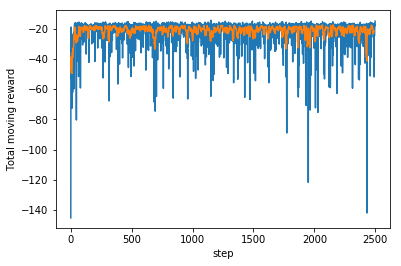

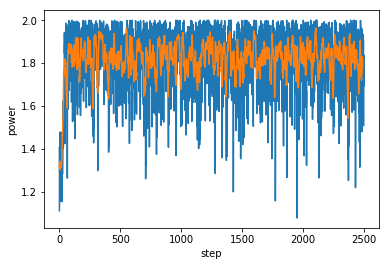

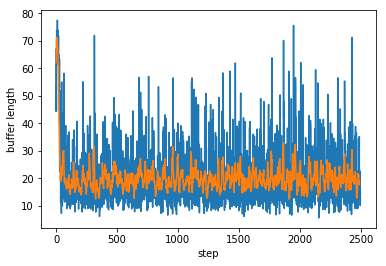

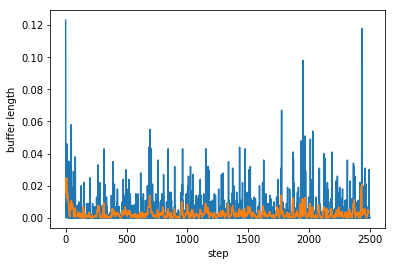

In [3]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

In [1]:
cur_init_ds_ep = env.reset()
    
cur_r_ep = np.zeros(len(user_list))
cur_p_ep = np.zeros(len(user_list))
cur_n_ep = np.zeros(len(user_list))
cur_ts_ep = np.zeros(len(user_list))
cur_rs_ep = np.zeros(len(user_list))
cur_ps_ep = np.zeros(len(user_list))
cur_ds_ep = np.zeros(len(user_list))
cur_ch_ep = np.zeros(len(user_list))
    
for j in range(1000):
    # first try to transmit from current state
    [cur_r, done, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
    cur_r_ep += cur_r
    cur_p_ep += cur_p
    cur_ts_ep += cur_ts
    cur_ps_ep += cur_ps
    cur_rs_ep += cur_rs
    cur_ds_ep += cur_ds
    cur_ch_ep += cur_ch
        
    print('%d:r:%f,p:%s,n:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (j, cur_r, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_init_ds_ep))
        
print('r:%f,p:%s,n:%s,tr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_n_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep))

NameError: name 'env' is not defined

In [3]:
graph = tf.get_default_graph()
inputs = graph.get_tensor_by_name("input_1"+":0")
scaled_out = graph.get_tensor_by_name("output_1"+":0")
print sess.run(scaled_out, feed_dict={inputs: [[7.22254768,2.3384,2.7784888e-05]]})

[[0.78826445 1.        ]]


In [2]:
res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit(False)
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])

0:r:-50.8910,p:1.4033,tr:1.4707,pr:1.3505,rev:2.9594,dbuf:72.5261,ch:0.00002568,ibuf:4
1:r:-57.9454,p:1.3913,tr:1.6529,pr:1.2218,rev:3.0360,dbuf:74.1439,ch:0.00002761,ibuf:30
2:r:-51.0844,p:1.1953,tr:1.5476,pr:1.2320,rev:2.8984,dbuf:73.1955,ch:0.00002990,ibuf:39
3:r:-18.2811,p:1.3469,tr:1.5860,pr:1.3673,rev:2.9762,dbuf:61.5868,ch:0.00002683,ibuf:35
4:r:-17.5547,p:1.2180,tr:1.7657,pr:1.2518,rev:3.0115,dbuf:55.9275,ch:0.00003238,ibuf:63
5:r:-55.6239,p:1.4116,tr:1.4240,pr:1.3390,rev:2.8791,dbuf:69.1011,ch:0.00002492,ibuf:48
6:r:-37.3900,p:1.2706,tr:1.3830,pr:1.5578,rev:3.0240,dbuf:59.5109,ch:0.00002915,ibuf:8
7:r:-32.6223,p:1.4738,tr:1.3452,pr:1.6902,rev:3.0674,dbuf:63.5657,ch:0.00002512,ibuf:71
8:r:-20.8140,p:1.2057,tr:1.4394,pr:1.5456,rev:3.0451,dbuf:49.6221,ch:0.00002902,ibuf:38
9:r:-19.3836,p:1.1973,tr:1.4459,pr:1.4838,rev:2.9358,dbuf:56.0717,ch:0.00002922,ibuf:86


In [3]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import ipdb as pdb
import time

MAX_EPISODE = 50
MAX_EPISODE_LEN = 1000

NUM_T = 1
NUM_R = 1
SIGMA2 = 0.3e-9

config = {'state_dim':3, 'action_dim':2};
train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                 'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                 'random_seed':1234}
user_config = [{'id':'1', 'rate':3, 'dis':100, 'action_bound':1, 
                'data_buf_size':100, 't_factor':0.9, 'penalty':1000}];

print user_config
# 0. initialize the session object
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
    
# 1. include all user in the system according to the user_config
user_list = [];
for info in user_config:
    info.update(config)
    user_list.append(MecTermLD(sess, info, train_config))
    print 'test'

# 2. create the simulation env
env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)
env.init_target_network()

res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])
sess.close()

[{'data_buf_size': 100, 'penalty': 1000, 'rate': 3, 'action_bound': 1, 'id': '1', 't_factor': 0.9, 'dis': 100}]
INFO:tensorflow:Restoring parameters from model/my_test_model
--Return--
None
> <ipython-input-3-a12846566f97>(30)<module>()
     29 graph = tf.get_default_graph()
---> 30 pdb.set_trace()
     31 

ipdb> graph
ipdb> graph.trainable_variables
*** AttributeError: 'Graph' object has no attribute 'trainable_variables'
ipdb> tf.trainable_variables()
[<tf.Variable 'fully_connected/weights:0' shape=(3, 400) dtype=float32_ref>, <tf.Variable 'fully_connected/BatchNorm/beta:0' shape=(400,) dtype=float32_ref>, <tf.Variable 'fully_connected_1/weights:0' shape=(3, 300) dtype=float32_ref>, <tf.Variable 'fully_connected_1/BatchNorm/beta:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'fully_connected_2/weights:0' shape=(300, 2) dtype=float32_ref>, <tf.Variable 'fully_connected_2/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'fully_connected_3/weights:0' shape=(3, 400) dtype=float32

BdbQuit: 

In [9]:
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
variable_names = [v.name for v in tf.trainable_variables()]
values = sess.run(variable_names)
print sess.run('fully_connected_2/weights:0')

INFO:tensorflow:Restoring parameters from model/my_test_model
[[0.1545126  0.15780352]
 [0.15616506 0.15971294]
 [0.06559879 0.09880391]
 [0.06487427 0.10064688]
 [0.15168335 0.16229852]
 [0.06257845 0.09748891]
 [0.06430701 0.09924787]
 [0.06548443 0.10012874]
 [0.15782878 0.15414344]
 [0.15429462 0.17596859]
 [0.05945097 0.0991616 ]
 [0.06383383 0.09632684]
 [0.06522399 0.10438306]
 [0.06095436 0.09916781]
 [0.06635379 0.0955418 ]
 [0.06379106 0.09433711]
 [0.06133086 0.09875894]
 [0.06503102 0.09639146]
 [0.15047684 0.17412661]
 [0.15663381 0.15740666]
 [0.17768952 0.15899988]
 [0.15730077 0.14491995]
 [0.05902164 0.10017106]
 [0.06845198 0.09686822]
 [0.15724926 0.14774598]
 [0.1529071  0.16426612]
 [0.1520101  0.15706535]
 [0.16091335 0.16260217]
 [0.15082897 0.16070077]
 [0.06310375 0.09398151]
 [0.06018374 0.10056869]
 [0.05968894 0.10066012]
 [0.15474424 0.16255529]
 [0.15111688 0.1622602 ]
 [0.0838669  0.18973866]
 [0.06870251 0.24295035]
 [0.06702217 0.10505467]
 [0.1529     

In [3]:
np.save('t_08/1', [1])